In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set storLimitInfo 'Indicate the number of columns of information from storage units'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set v2gLimitInfo 'Indicate the number of columns of information from electric vehicles'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set csLimitInfo 'Indicate the number of columns of information from charging stations'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

#genLimitInfo = np.arange(1, genLimit.shape[2]+1)
#loadLimitInfo = np.arange(1, loadLimit.shape[2]+1)
#storLimitInfo = np.arange(1, storLimit.shape[2]+1)
#v2gLimitInfo = np.arange(1, v2gLimit.shape[2]+1)
#csLimitInfo = np.arange(1, csLimit.shape[0]+1)

In [12]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)
_v2g = np.arange(1, v2g+1)
_cs = np.arange(1, cs+1)

In [13]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

NameError: name 'result_genActPower' is not defined

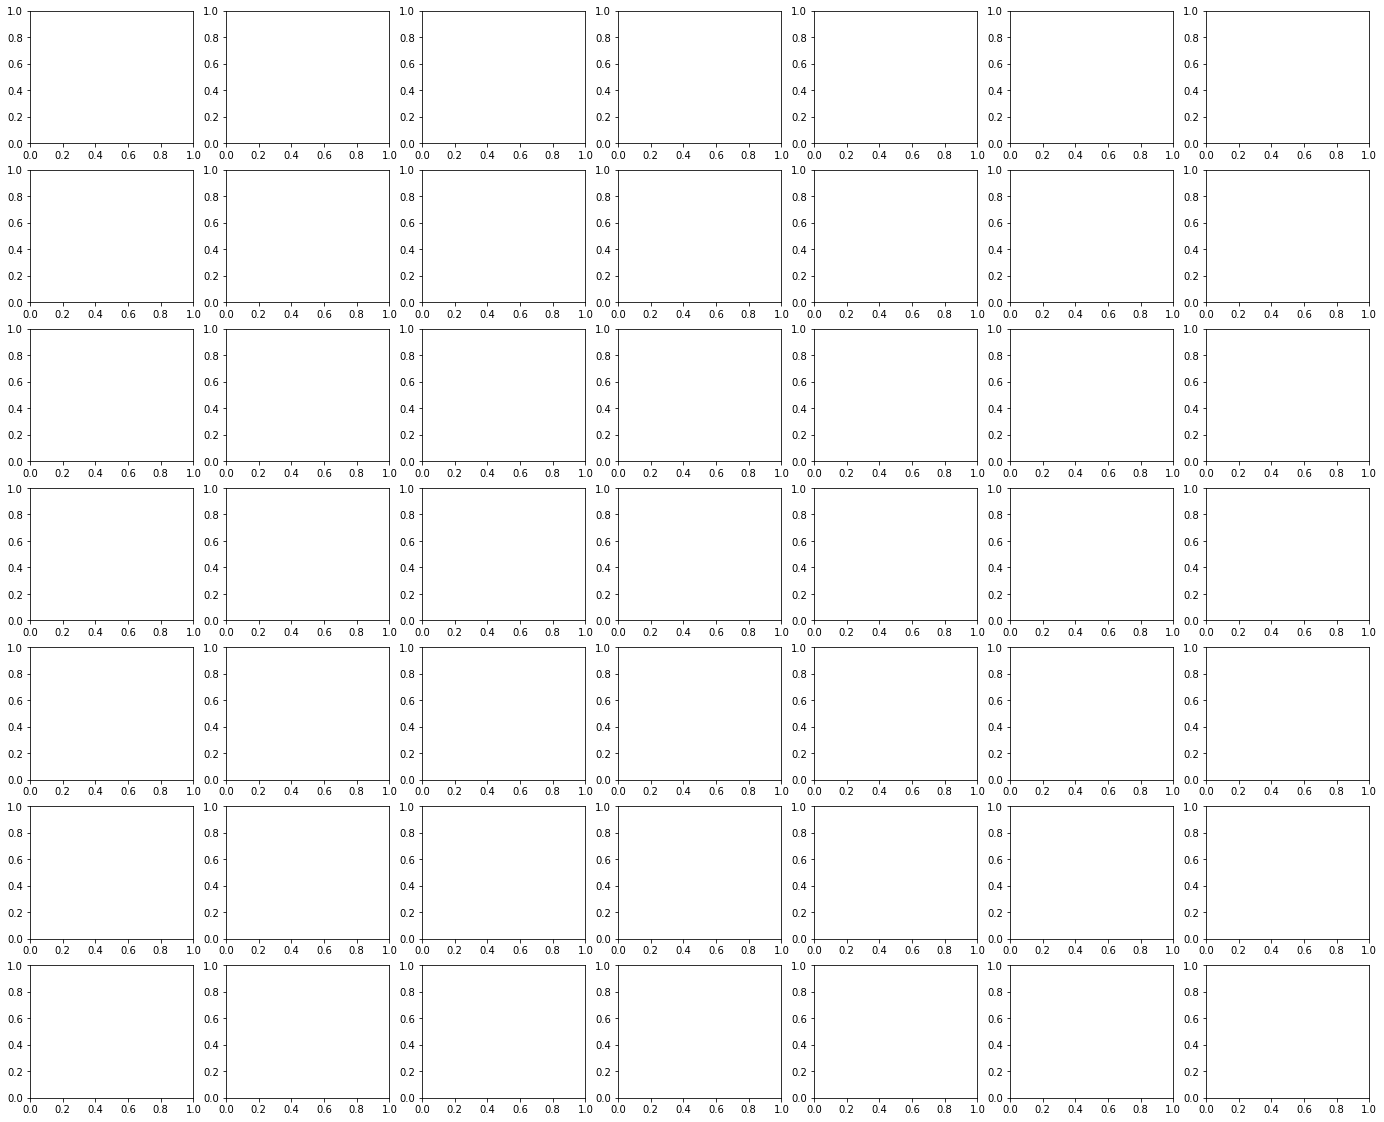

In [14]:
# Plot results

fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(result_storEnerState.values[i])
    axs[i, 3].legend(['storEnerState'])
    
for i in range(3):
    axs[i, 4].plot(result_storDchActPower.values[i])
    axs[i, 4].legend(['storDchActPower'])
    
for i in range(3):
    axs[i, 5].plot(result_storChActPower.values[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(result_v2gEnerState.values[i])
    axs[i, 6].legend(['v2gEnerState'])


plt.show()

In [14]:
# Pymoo import

import pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize
from pymoo.termination import get_termination

In [15]:
# Class to speed up code execution

class HeuristicData(object):
    def __init__(self):
        return
    
    
    def objectiveFunction(self):
        return
    
    
    def doIteration(self):
        return
    
    
    def newIteration(self):
        return
    

class EnergyCommunity(HeuristicData):
    
    def __init__(self, parameters, variables):
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        return
    
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def newIteration(self, encoded_vals):
        self.variableAssign(self.decode(encoded_vals))
        self.doIteration()
        return

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    

In [16]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [17]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [18]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [19]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            #'v2gDchActPower': v2gDchActPower,
            #'v2gChActPower': v2gChActPower,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs,
            #'storPieceSegments': np.array([1, 2, 3]),
            'storCapCost': storInfo[:, 5] * 0.00105,
            #'storCyclesMult': np.array([1000, 1200, 700]),
            'v2gCapCost': v2gInfo[:, 4] * 0.00105}
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [20]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [21]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': 30*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 30*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 100*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [22]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [23]:
# Properly shaped initial Solution

sol_shaped = {'genActPower': genLimit[:, :, 0],
              'genExcActPower': np.zeros(genExcActPower.shape),
              'pImp': pMaxImp,
              'pExp': np.zeros(pExp.shape),
              'loadRedActPower': np.zeros(loadRedActPower.shape),
              'loadENS': np.zeros(loadENS.shape),
              'storDchActPower': np.zeros(storDchActPower.shape),
              'storChActPower': np.zeros(storChActPower.shape),
              'EminRelaxStor': np.zeros(storEminRelaxStor.shape),
              #'v2gDchActPower': np.zeros(v2gDchActPower.shape),
              #'v2gChActPower': np.zeros(v2gChActPower.shape),
              'genXo': np.zeros(genXo.shape),
              'loadXo': np.zeros(loadXo.shape),
              'storDchXo': np.ones(storDchXo.shape),
              'storChXo': np.zeros(storChXo.shape),
              'v2gDchXo': np.zeros(v2gDchXo.shape),
              'v2gChXo': np.zeros(v2gChXo.shape)}

encoded_shaped = encode(sol_shaped)
decoded_shaped = decode(encoded_shaped, dict_var)

In [24]:
# Define a custom problem

class ProblemEC(Problem):
    
    def __init__(self, parameters, variables, xl, xu, n_var):
        super().__init__(n_var=n_var, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu, vtype=float)
        
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        obj = []
        #print(x)
        for temp in range(x.shape[0]):
            self.variableAssign(self.decode(x[temp]))
            self.doIteration()
            obj.append(self.objFn)
        out['F'] = obj

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        #print(new_variables.shape)
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded

In [25]:
# Instantiate the problem

name = 'run10'

customProblem = ProblemEC(parameters=decoded_pars,
                      variables=decoded_shaped,
                      xl=encoded_minvals,
                      xu=encoded_maxvals,
                      n_var=1584)
    
algorithm = DE(pop_size=10,
           sampling=LHS(),
           variant="DE/rand/1/bin",
           CR=0.3,
           dither="vector",
           jitter=False)
    
termination = get_termination('n_gen', 5e4)
    
temp_res = minimize(customProblem,
                    algorithm,
                    termination=termination,
                    #seed=42,
                    save_history=True,
                    verbose=True)

minimized_solution = pd.DataFrame(temp_res.X)
minimized_solution.to_csv('results/paper_de/'+name+'/solution.csv')

minimized_stats = pd.DataFrame({'objFun': temp_res.F,
                                'runtime': temp_res.exec_time})
minimized_stats.to_csv('results/paper_de/'+name+'/stats.csv')

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.098278E+06 |  1.917805E+06
     2 |       20 |  2.008190E+06 |  1.818170E+06
     3 |       30 |  1.877804E+06 |  1.517548E+06
     4 |       40 |  1.837730E+06 |  1.517548E+06
     5 |       50 |  1.807632E+06 |  1.517548E+06
     6 |       60 |  1.797654E+06 |  1.517548E+06
     7 |       70 |  1.727657E+06 |  1.417682E+06
     8 |       80 |  1.717610E+06 |  1.417682E+06
     9 |       90 |  1.707630E+06 |  1.417682E+06
    10 |      100 |  1.697605E+06 |  1.417682E+06
    11 |      110 |  1.657553E+06 |  1.417682E+06
    12 |      120 |  1.627529E+06 |  1.417682E+06
    13 |      130 |  1.627529E+06 |  1.417682E+06
    14 |      140 |  1.627492E+06 |  1.417317E+06
    15 |      150 |  1.627434E+06 |  1.417317E+06
    16 |      160 |  1.617310E+06 |  1.417317E+06
    17 |      170 |  1.607284E+06 |  1.417317E+06
    18 |      180 |  1.607284E+06 |  1.417317E+06
    19 |      190 |  1.557097E+06 |  1.417317E+06


   161 |     1610 |  3.034263E+05 |  1.132375E+05
   162 |     1620 |  3.033973E+05 |  1.132375E+05
   163 |     1630 |  3.033973E+05 |  1.132375E+05
   164 |     1640 |  2.833964E+05 |  1.132375E+05
   165 |     1650 |  2.733866E+05 |  1.132375E+05
   166 |     1660 |  2.633797E+05 |  1.132375E+05
   167 |     1670 |  2.633797E+05 |  1.132375E+05
   168 |     1680 |  2.633033E+05 |  1.132375E+05
   169 |     1690 |  2.633033E+05 |  1.132375E+05
   170 |     1700 |  2.532038E+05 |  1.130551E+05
   171 |     1710 |  2.332247E+05 |  1.130551E+05
   172 |     1720 |  2.332247E+05 |  1.130551E+05
   173 |     1730 |  2.232360E+05 |  1.130551E+05
   174 |     1740 |  2.132213E+05 |  1.130256E+05
   175 |     1750 |  1.932271E+05 |  1.124127E+05
   176 |     1760 |  1.732319E+05 |  1.124127E+05
   177 |     1770 |  1.632237E+05 |  1.124127E+05
   178 |     1780 |  1.531921E+05 |  1.124127E+05
   179 |     1790 |  1.531746E+05 |  1.124127E+05
   180 |     1800 |  1.431827E+05 |  1.124127E+05


   328 |     3280 |  9.061365E+04 |  1.050356E+04
   329 |     3290 |  9.060776E+04 |  1.050356E+04
   330 |     3300 |  8.062760E+04 |  1.038143E+04
   331 |     3310 |  8.052234E+04 |  1.038143E+04
   332 |     3320 |  8.047874E+04 |  1.038143E+04
   333 |     3330 |  8.044914E+04 |  1.038143E+04
   334 |     3340 |  7.035199E+04 |  1.019792E+04
   335 |     3350 |  7.031783E+04 |  1.019792E+04
   336 |     3360 |  5.025480E+04 |  1.012504E+04
   337 |     3370 |  5.025330E+04 |  1.012504E+04
   338 |     3380 |  5.022837E+04 |  1.012504E+04
   339 |     3390 |  3.025254E+04 |  1.002451E+04
   340 |     3400 |  3.022184E+04 |  1.002451E+04
   341 |     3410 |  3.020632E+04 |  9.901880E+03
   342 |     3420 |  3.014101E+04 |  9.901880E+03
   343 |     3430 |  2.015850E+04 |  9.901880E+03
   344 |     3440 |  2.014288E+04 |  9.901880E+03
   345 |     3450 |  2.013634E+04 |  9.901880E+03
   346 |     3460 |  2.007659E+04 |  9.901880E+03
   347 |     3470 |  2.005479E+04 |  9.901880E+03


   494 |     4940 |  5.675872E+03 |  5.604167E+03
   495 |     4950 |  5.664485E+03 |  5.600794E+03
   496 |     4960 |  5.627373E+03 |  5.494639E+03
   497 |     4970 |  5.617845E+03 |  5.472926E+03
   498 |     4980 |  5.590018E+03 |  5.463106E+03
   499 |     4990 |  5.572688E+03 |  5.404181E+03
   500 |     5000 |  5.554281E+03 |  5.404181E+03
   501 |     5010 |  5.547247E+03 |  5.404181E+03
   502 |     5020 |  5.536788E+03 |  5.404181E+03
   503 |     5030 |  5.501816E+03 |  5.404181E+03
   504 |     5040 |  5.487621E+03 |  5.404181E+03
   505 |     5050 |  5.463864E+03 |  5.397439E+03
   506 |     5060 |  5.454771E+03 |  5.366818E+03
   507 |     5070 |  5.419215E+03 |  5.362908E+03
   508 |     5080 |  5.408389E+03 |  5.362908E+03
   509 |     5090 |  5.392846E+03 |  5.334750E+03
   510 |     5100 |  5.388428E+03 |  5.334750E+03
   511 |     5110 |  5.368650E+03 |  5.291696E+03
   512 |     5120 |  5.357935E+03 |  5.291696E+03
   513 |     5130 |  5.340752E+03 |  5.272684E+03


   663 |     6630 |  4.067477E+03 |  4.029063E+03
   664 |     6640 |  4.059880E+03 |  4.029063E+03
   665 |     6650 |  4.058363E+03 |  4.029063E+03
   666 |     6660 |  4.058363E+03 |  4.029063E+03
   667 |     6670 |  4.052441E+03 |  4.024011E+03
   668 |     6680 |  4.043543E+03 |  4.024011E+03
   669 |     6690 |  4.043543E+03 |  4.024011E+03
   670 |     6700 |  4.031562E+03 |  3.994810E+03
   671 |     6710 |  4.028138E+03 |  3.991635E+03
   672 |     6720 |  4.026273E+03 |  3.991635E+03
   673 |     6730 |  4.009992E+03 |  3.983070E+03
   674 |     6740 |  3.999987E+03 |  3.953138E+03
   675 |     6750 |  3.998233E+03 |  3.953138E+03
   676 |     6760 |  3.994420E+03 |  3.953138E+03
   677 |     6770 |  3.984956E+03 |  3.953138E+03
   678 |     6780 |  3.983280E+03 |  3.953138E+03
   679 |     6790 |  3.978020E+03 |  3.933797E+03
   680 |     6800 |  3.973394E+03 |  3.933797E+03
   681 |     6810 |  3.967490E+03 |  3.920380E+03
   682 |     6820 |  3.957435E+03 |  3.920380E+03


   834 |     8340 |  3.217177E+03 |  3.168122E+03
   835 |     8350 |  3.214982E+03 |  3.168122E+03
   836 |     8360 |  3.205639E+03 |  3.154542E+03
   837 |     8370 |  3.197883E+03 |  3.154542E+03
   838 |     8380 |  3.195289E+03 |  3.145181E+03
   839 |     8390 |  3.180600E+03 |  3.140572E+03
   840 |     8400 |  3.177333E+03 |  3.140572E+03
   841 |     8410 |  3.163983E+03 |  3.106552E+03
   842 |     8420 |  3.143220E+03 |  3.106552E+03
   843 |     8430 |  3.139272E+03 |  3.106552E+03
   844 |     8440 |  3.136428E+03 |  3.106552E+03
   845 |     8450 |  3.134970E+03 |  3.106552E+03
   846 |     8460 |  3.133232E+03 |  3.106552E+03
   847 |     8470 |  3.128353E+03 |  3.106552E+03
   848 |     8480 |  3.127169E+03 |  3.100098E+03
   849 |     8490 |  3.117978E+03 |  3.100098E+03
   850 |     8500 |  3.113937E+03 |  3.095277E+03
   851 |     8510 |  3.113145E+03 |  3.095277E+03
   852 |     8520 |  3.106421E+03 |  3.095277E+03
   853 |     8530 |  3.102346E+03 |  3.087358E+03


  1002 |    10020 |  2.790265E+03 |  2.784253E+03
  1003 |    10030 |  2.789865E+03 |  2.784253E+03
  1004 |    10040 |  2.787781E+03 |  2.783686E+03
  1005 |    10050 |  2.786536E+03 |  2.780422E+03
  1006 |    10060 |  2.785053E+03 |  2.779914E+03
  1007 |    10070 |  2.783831E+03 |  2.777869E+03
  1008 |    10080 |  2.782707E+03 |  2.776594E+03
  1009 |    10090 |  2.780332E+03 |  2.769901E+03
  1010 |    10100 |  2.779328E+03 |  2.769901E+03
  1011 |    10110 |  2.778256E+03 |  2.769901E+03
  1012 |    10120 |  2.777475E+03 |  2.769901E+03
  1013 |    10130 |  2.776874E+03 |  2.769901E+03
  1014 |    10140 |  2.775771E+03 |  2.768150E+03
  1015 |    10150 |  2.775194E+03 |  2.768150E+03
  1016 |    10160 |  2.774457E+03 |  2.768150E+03
  1017 |    10170 |  2.773224E+03 |  2.763412E+03
  1018 |    10180 |  2.772316E+03 |  2.763412E+03
  1019 |    10190 |  2.770943E+03 |  2.763412E+03
  1020 |    10200 |  2.769090E+03 |  2.763412E+03
  1021 |    10210 |  2.768086E+03 |  2.763412E+03


  1171 |    11710 |  2.568177E+03 |  2.565472E+03
  1172 |    11720 |  2.567807E+03 |  2.565472E+03
  1173 |    11730 |  2.567379E+03 |  2.565024E+03
  1174 |    11740 |  2.567147E+03 |  2.564874E+03
  1175 |    11750 |  2.566404E+03 |  2.562315E+03
  1176 |    11760 |  2.566254E+03 |  2.562315E+03
  1177 |    11770 |  2.564918E+03 |  2.560029E+03
  1178 |    11780 |  2.564401E+03 |  2.560029E+03
  1179 |    11790 |  2.563511E+03 |  2.558994E+03
  1180 |    11800 |  2.563164E+03 |  2.558994E+03
  1181 |    11810 |  2.563013E+03 |  2.558994E+03
  1182 |    11820 |  2.562396E+03 |  2.558994E+03
  1183 |    11830 |  2.561733E+03 |  2.558994E+03
  1184 |    11840 |  2.560758E+03 |  2.558994E+03
  1185 |    11850 |  2.560323E+03 |  2.558679E+03
  1186 |    11860 |  2.559660E+03 |  2.555690E+03
  1187 |    11870 |  2.559524E+03 |  2.555690E+03
  1188 |    11880 |  2.559002E+03 |  2.555690E+03
  1189 |    11890 |  2.558908E+03 |  2.555690E+03
  1190 |    11900 |  2.558458E+03 |  2.555303E+03


  1341 |    13410 |  2.375912E+03 |  2.373347E+03
  1342 |    13420 |  2.375557E+03 |  2.373347E+03
  1343 |    13430 |  2.375325E+03 |  2.373347E+03
  1344 |    13440 |  2.375325E+03 |  2.373347E+03
  1345 |    13450 |  2.374580E+03 |  2.372355E+03
  1346 |    13460 |  2.374536E+03 |  2.372355E+03
  1347 |    13470 |  2.373854E+03 |  2.370904E+03
  1348 |    13480 |  2.373582E+03 |  2.369833E+03
  1349 |    13490 |  2.372294E+03 |  2.365687E+03
  1350 |    13500 |  2.372076E+03 |  2.365127E+03
  1351 |    13510 |  2.371497E+03 |  2.365127E+03
  1352 |    13520 |  2.371407E+03 |  2.365127E+03
  1353 |    13530 |  2.370794E+03 |  2.365127E+03
  1354 |    13540 |  2.370272E+03 |  2.365127E+03
  1355 |    13550 |  2.368996E+03 |  2.360803E+03
  1356 |    13560 |  2.368829E+03 |  2.360803E+03
  1357 |    13570 |  2.367945E+03 |  2.360803E+03
  1358 |    13580 |  2.367625E+03 |  2.360803E+03
  1359 |    13590 |  2.367341E+03 |  2.360803E+03
  1360 |    13600 |  2.367061E+03 |  2.360803E+03


  1509 |    15090 |  2.297673E+03 |  2.296125E+03
  1510 |    15100 |  2.297324E+03 |  2.294975E+03
  1511 |    15110 |  2.297057E+03 |  2.294975E+03
  1512 |    15120 |  2.296971E+03 |  2.294975E+03
  1513 |    15130 |  2.296652E+03 |  2.294975E+03
  1514 |    15140 |  2.296535E+03 |  2.294975E+03
  1515 |    15150 |  2.296355E+03 |  2.294975E+03
  1516 |    15160 |  2.296203E+03 |  2.294975E+03
  1517 |    15170 |  2.295831E+03 |  2.294406E+03
  1518 |    15180 |  2.295383E+03 |  2.293888E+03
  1519 |    15190 |  2.295127E+03 |  2.293888E+03
  1520 |    15200 |  2.294835E+03 |  2.291999E+03
  1521 |    15210 |  2.294469E+03 |  2.291999E+03
  1522 |    15220 |  2.294364E+03 |  2.291999E+03
  1523 |    15230 |  2.294089E+03 |  2.291999E+03
  1524 |    15240 |  2.293926E+03 |  2.291999E+03
  1525 |    15250 |  2.293492E+03 |  2.291999E+03
  1526 |    15260 |  2.293296E+03 |  2.291999E+03
  1527 |    15270 |  2.292912E+03 |  2.291838E+03
  1528 |    15280 |  2.292859E+03 |  2.291838E+03


  1673 |    16730 |  2.254222E+03 |  2.252732E+03
  1674 |    16740 |  2.254006E+03 |  2.252424E+03
  1675 |    16750 |  2.253682E+03 |  2.252424E+03
  1676 |    16760 |  2.253615E+03 |  2.252424E+03
  1677 |    16770 |  2.253577E+03 |  2.252041E+03
  1678 |    16780 |  2.253402E+03 |  2.252041E+03
  1679 |    16790 |  2.253137E+03 |  2.251580E+03
  1680 |    16800 |  2.252938E+03 |  2.251580E+03
  1681 |    16810 |  2.252796E+03 |  2.251580E+03
  1682 |    16820 |  2.252591E+03 |  2.251406E+03
  1683 |    16830 |  2.252321E+03 |  2.251369E+03
  1684 |    16840 |  2.251987E+03 |  2.250680E+03
  1685 |    16850 |  2.251437E+03 |  2.250680E+03
  1686 |    16860 |  2.251370E+03 |  2.250556E+03
  1687 |    16870 |  2.251267E+03 |  2.250556E+03
  1688 |    16880 |  2.251267E+03 |  2.250556E+03
  1689 |    16890 |  2.251178E+03 |  2.250066E+03
  1690 |    16900 |  2.250933E+03 |  2.250013E+03
  1691 |    16910 |  2.250801E+03 |  2.250013E+03
  1692 |    16920 |  2.250720E+03 |  2.250013E+03


  1838 |    18380 |  2.230007E+03 |  2.229467E+03
  1839 |    18390 |  2.229936E+03 |  2.229467E+03
  1840 |    18400 |  2.229775E+03 |  2.229308E+03
  1841 |    18410 |  2.229611E+03 |  2.229022E+03
  1842 |    18420 |  2.229512E+03 |  2.229022E+03
  1843 |    18430 |  2.229456E+03 |  2.229022E+03
  1844 |    18440 |  2.229443E+03 |  2.229022E+03
  1845 |    18450 |  2.229394E+03 |  2.229022E+03
  1846 |    18460 |  2.229340E+03 |  2.228813E+03
  1847 |    18470 |  2.229237E+03 |  2.228813E+03
  1848 |    18480 |  2.229130E+03 |  2.228706E+03
  1849 |    18490 |  2.229081E+03 |  2.228586E+03
  1850 |    18500 |  2.228822E+03 |  2.228454E+03
  1851 |    18510 |  2.228814E+03 |  2.228454E+03
  1852 |    18520 |  2.228717E+03 |  2.228254E+03
  1853 |    18530 |  2.228510E+03 |  2.227986E+03
  1854 |    18540 |  2.228477E+03 |  2.227897E+03
  1855 |    18550 |  2.228340E+03 |  2.227897E+03
  1856 |    18560 |  2.228234E+03 |  2.227897E+03
  1857 |    18570 |  2.228149E+03 |  2.227661E+03


  2004 |    20040 |  2.206920E+03 |  2.206515E+03
  2005 |    20050 |  2.206847E+03 |  2.206515E+03
  2006 |    20060 |  2.206789E+03 |  2.206515E+03
  2007 |    20070 |  2.206781E+03 |  2.206515E+03
  2008 |    20080 |  2.206722E+03 |  2.206465E+03
  2009 |    20090 |  2.206674E+03 |  2.206465E+03
  2010 |    20100 |  2.206662E+03 |  2.206465E+03
  2011 |    20110 |  2.206615E+03 |  2.206239E+03
  2012 |    20120 |  2.206541E+03 |  2.206239E+03
  2013 |    20130 |  2.206486E+03 |  2.206123E+03
  2014 |    20140 |  2.206217E+03 |  2.204630E+03
  2015 |    20150 |  2.205798E+03 |  2.202563E+03
  2016 |    20160 |  2.205736E+03 |  2.202563E+03
  2017 |    20170 |  2.204942E+03 |  2.198688E+03
  2018 |    20180 |  2.204470E+03 |  2.198688E+03
  2019 |    20190 |  2.204194E+03 |  2.198688E+03
  2020 |    20200 |  2.203509E+03 |  2.198338E+03
  2021 |    20210 |  2.202523E+03 |  2.196703E+03
  2022 |    20220 |  2.201688E+03 |  2.196703E+03
  2023 |    20230 |  2.201688E+03 |  2.196703E+03


  2173 |    21730 |  2.124974E+03 |  2.124509E+03
  2174 |    21740 |  2.124940E+03 |  2.124458E+03
  2175 |    21750 |  2.124883E+03 |  2.124458E+03
  2176 |    21760 |  2.124785E+03 |  2.124408E+03
  2177 |    21770 |  2.124777E+03 |  2.124408E+03
  2178 |    21780 |  2.124723E+03 |  2.124336E+03
  2179 |    21790 |  2.124647E+03 |  2.124158E+03
  2180 |    21800 |  2.124492E+03 |  2.124158E+03
  2181 |    21810 |  2.124342E+03 |  2.123748E+03
  2182 |    21820 |  2.124281E+03 |  2.123748E+03
  2183 |    21830 |  2.124188E+03 |  2.123748E+03
  2184 |    21840 |  2.124160E+03 |  2.123748E+03
  2185 |    21850 |  2.124084E+03 |  2.123748E+03
  2186 |    21860 |  2.123980E+03 |  2.123638E+03
  2187 |    21870 |  2.123889E+03 |  2.123460E+03
  2188 |    21880 |  2.123792E+03 |  2.122928E+03
  2189 |    21890 |  2.123684E+03 |  2.122928E+03
  2190 |    21900 |  2.123588E+03 |  2.122928E+03
  2191 |    21910 |  2.123516E+03 |  2.122915E+03
  2192 |    21920 |  2.123416E+03 |  2.122915E+03


  2342 |    23420 |  2.087198E+03 |  2.086862E+03
  2343 |    23430 |  2.087086E+03 |  2.086710E+03
  2344 |    23440 |  2.087021E+03 |  2.086710E+03
  2345 |    23450 |  2.086979E+03 |  2.086592E+03
  2346 |    23460 |  2.086934E+03 |  2.086592E+03
  2347 |    23470 |  2.086862E+03 |  2.086592E+03
  2348 |    23480 |  2.086827E+03 |  2.086592E+03
  2349 |    23490 |  2.086792E+03 |  2.086527E+03
  2350 |    23500 |  2.086723E+03 |  2.086519E+03
  2351 |    23510 |  2.086720E+03 |  2.086519E+03
  2352 |    23520 |  2.086693E+03 |  2.086519E+03
  2353 |    23530 |  2.086516E+03 |  2.085864E+03
  2354 |    23540 |  2.086303E+03 |  2.084137E+03
  2355 |    23550 |  2.086236E+03 |  2.083671E+03
  2356 |    23560 |  2.086188E+03 |  2.083671E+03
  2357 |    23570 |  2.086105E+03 |  2.083606E+03
  2358 |    23580 |  2.085841E+03 |  2.083606E+03
  2359 |    23590 |  2.085784E+03 |  2.083425E+03
  2360 |    23600 |  2.085721E+03 |  2.083425E+03
  2361 |    23610 |  2.085565E+03 |  2.083425E+03


  2513 |    25130 |  2.028678E+03 |  2.022617E+03
  2514 |    25140 |  2.027523E+03 |  2.022617E+03
  2515 |    25150 |  2.026296E+03 |  2.022588E+03
  2516 |    25160 |  2.025077E+03 |  2.022063E+03
  2517 |    25170 |  2.023830E+03 |  2.021786E+03
  2518 |    25180 |  2.023704E+03 |  2.021776E+03
  2519 |    25190 |  2.022925E+03 |  2.021427E+03
  2520 |    25200 |  2.022858E+03 |  2.021427E+03
  2521 |    25210 |  2.022762E+03 |  2.021247E+03
  2522 |    25220 |  2.022598E+03 |  2.020962E+03
  2523 |    25230 |  2.022557E+03 |  2.020962E+03
  2524 |    25240 |  2.022143E+03 |  2.020938E+03
  2525 |    25250 |  2.021490E+03 |  2.020212E+03
  2526 |    25260 |  2.020926E+03 |  2.020212E+03
  2527 |    25270 |  2.020757E+03 |  2.020212E+03
  2528 |    25280 |  2.020628E+03 |  2.019887E+03
  2529 |    25290 |  2.020120E+03 |  2.019043E+03
  2530 |    25300 |  2.019983E+03 |  2.018901E+03
  2531 |    25310 |  2.019870E+03 |  2.018804E+03
  2532 |    25320 |  2.019615E+03 |  2.018804E+03


  2676 |    26760 |  1.995516E+03 |  1.995045E+03
  2677 |    26770 |  1.995486E+03 |  1.995045E+03
  2678 |    26780 |  1.995460E+03 |  1.995045E+03
  2679 |    26790 |  1.995427E+03 |  1.995045E+03
  2680 |    26800 |  1.995356E+03 |  1.995045E+03
  2681 |    26810 |  1.995327E+03 |  1.995045E+03
  2682 |    26820 |  1.995248E+03 |  1.994897E+03
  2683 |    26830 |  1.995198E+03 |  1.994897E+03
  2684 |    26840 |  1.995151E+03 |  1.994897E+03
  2685 |    26850 |  1.995108E+03 |  1.994897E+03
  2686 |    26860 |  1.995044E+03 |  1.994875E+03
  2687 |    26870 |  1.995016E+03 |  1.994767E+03
  2688 |    26880 |  1.994963E+03 |  1.994677E+03
  2689 |    26890 |  1.994916E+03 |  1.994677E+03
  2690 |    26900 |  1.994885E+03 |  1.994677E+03
  2691 |    26910 |  1.994815E+03 |  1.994677E+03
  2692 |    26920 |  1.994798E+03 |  1.994677E+03
  2693 |    26930 |  1.994768E+03 |  1.994676E+03
  2694 |    26940 |  1.994757E+03 |  1.994658E+03
  2695 |    26950 |  1.994754E+03 |  1.994658E+03


  2844 |    28440 |  1.982095E+03 |  1.982007E+03
  2845 |    28450 |  1.982054E+03 |  1.981862E+03
  2846 |    28460 |  1.982030E+03 |  1.981862E+03
  2847 |    28470 |  1.982005E+03 |  1.981843E+03
  2848 |    28480 |  1.981974E+03 |  1.981668E+03
  2849 |    28490 |  1.981965E+03 |  1.981668E+03
  2850 |    28500 |  1.981612E+03 |  1.978562E+03
  2851 |    28510 |  1.981606E+03 |  1.978562E+03
  2852 |    28520 |  1.981559E+03 |  1.978562E+03
  2853 |    28530 |  1.981533E+03 |  1.978562E+03
  2854 |    28540 |  1.981519E+03 |  1.978562E+03
  2855 |    28550 |  1.981462E+03 |  1.978562E+03
  2856 |    28560 |  1.981418E+03 |  1.978542E+03
  2857 |    28570 |  1.981384E+03 |  1.978485E+03
  2858 |    28580 |  1.981365E+03 |  1.978485E+03
  2859 |    28590 |  1.981334E+03 |  1.978485E+03
  2860 |    28600 |  1.981286E+03 |  1.978485E+03
  2861 |    28610 |  1.981252E+03 |  1.978442E+03
  2862 |    28620 |  1.981237E+03 |  1.978442E+03
  2863 |    28630 |  1.981178E+03 |  1.978178E+03


  3011 |    30110 |  1.959245E+03 |  1.959183E+03
  3012 |    30120 |  1.959229E+03 |  1.959182E+03
  3013 |    30130 |  1.959210E+03 |  1.959141E+03
  3014 |    30140 |  1.959199E+03 |  1.959141E+03
  3015 |    30150 |  1.959189E+03 |  1.959141E+03
  3016 |    30160 |  1.959173E+03 |  1.959121E+03
  3017 |    30170 |  1.959162E+03 |  1.959113E+03
  3018 |    30180 |  1.959149E+03 |  1.959076E+03
  3019 |    30190 |  1.959123E+03 |  1.959059E+03
  3020 |    30200 |  1.959118E+03 |  1.959059E+03
  3021 |    30210 |  1.959118E+03 |  1.959059E+03
  3022 |    30220 |  1.959096E+03 |  1.958990E+03
  3023 |    30230 |  1.959085E+03 |  1.958990E+03
  3024 |    30240 |  1.959082E+03 |  1.958989E+03
  3025 |    30250 |  1.959050E+03 |  1.958906E+03
  3026 |    30260 |  1.959039E+03 |  1.958906E+03
  3027 |    30270 |  1.959029E+03 |  1.958906E+03
  3028 |    30280 |  1.959010E+03 |  1.958880E+03
  3029 |    30290 |  1.959003E+03 |  1.958880E+03
  3030 |    30300 |  1.958985E+03 |  1.958880E+03


  3177 |    31770 |  1.956445E+03 |  1.956335E+03
  3178 |    31780 |  1.956432E+03 |  1.956335E+03
  3179 |    31790 |  1.956403E+03 |  1.956298E+03
  3180 |    31800 |  1.956393E+03 |  1.956298E+03
  3181 |    31810 |  1.956380E+03 |  1.956298E+03
  3182 |    31820 |  1.956363E+03 |  1.956250E+03
  3183 |    31830 |  1.956340E+03 |  1.956239E+03
  3184 |    31840 |  1.956318E+03 |  1.956217E+03
  3185 |    31850 |  1.956309E+03 |  1.956217E+03
  3186 |    31860 |  1.956281E+03 |  1.956217E+03
  3187 |    31870 |  1.956252E+03 |  1.956105E+03
  3188 |    31880 |  1.956246E+03 |  1.956105E+03
  3189 |    31890 |  1.956233E+03 |  1.956105E+03
  3190 |    31900 |  1.956231E+03 |  1.956105E+03
  3191 |    31910 |  1.956200E+03 |  1.956105E+03
  3192 |    31920 |  1.956188E+03 |  1.956105E+03
  3193 |    31930 |  1.956166E+03 |  1.956086E+03
  3194 |    31940 |  1.956158E+03 |  1.956086E+03
  3195 |    31950 |  1.956153E+03 |  1.956086E+03
  3196 |    31960 |  1.956128E+03 |  1.956057E+03


  3344 |    33440 |  1.943471E+03 |  1.943310E+03
  3345 |    33450 |  1.943447E+03 |  1.943310E+03
  3346 |    33460 |  1.943433E+03 |  1.943310E+03
  3347 |    33470 |  1.943413E+03 |  1.943299E+03
  3348 |    33480 |  1.943399E+03 |  1.943299E+03
  3349 |    33490 |  1.943366E+03 |  1.943229E+03
  3350 |    33500 |  1.943362E+03 |  1.943229E+03
  3351 |    33510 |  1.943333E+03 |  1.943182E+03
  3352 |    33520 |  1.943303E+03 |  1.943134E+03
  3353 |    33530 |  1.943283E+03 |  1.943134E+03
  3354 |    33540 |  1.943227E+03 |  1.943018E+03
  3355 |    33550 |  1.943189E+03 |  1.943018E+03
  3356 |    33560 |  1.943168E+03 |  1.943018E+03
  3357 |    33570 |  1.943154E+03 |  1.943018E+03
  3358 |    33580 |  1.943142E+03 |  1.943018E+03
  3359 |    33590 |  1.943076E+03 |  1.942937E+03
  3360 |    33600 |  1.943060E+03 |  1.942937E+03
  3361 |    33610 |  1.943013E+03 |  1.942922E+03
  3362 |    33620 |  1.942975E+03 |  1.942764E+03
  3363 |    33630 |  1.942937E+03 |  1.942667E+03


  3512 |    35120 |  1.910941E+03 |  1.910838E+03
  3513 |    35130 |  1.910924E+03 |  1.910838E+03
  3514 |    35140 |  1.910917E+03 |  1.910837E+03
  3515 |    35150 |  1.910894E+03 |  1.910837E+03
  3516 |    35160 |  1.910884E+03 |  1.910837E+03
  3517 |    35170 |  1.910873E+03 |  1.910831E+03
  3518 |    35180 |  1.910859E+03 |  1.910790E+03
  3519 |    35190 |  1.910853E+03 |  1.910759E+03
  3520 |    35200 |  1.910826E+03 |  1.910683E+03
  3521 |    35210 |  1.910814E+03 |  1.910683E+03
  3522 |    35220 |  1.910798E+03 |  1.910683E+03
  3523 |    35230 |  1.910772E+03 |  1.910663E+03
  3524 |    35240 |  1.910765E+03 |  1.910663E+03
  3525 |    35250 |  1.910753E+03 |  1.910663E+03
  3526 |    35260 |  1.910738E+03 |  1.910639E+03
  3527 |    35270 |  1.910735E+03 |  1.910638E+03
  3528 |    35280 |  1.910713E+03 |  1.910638E+03
  3529 |    35290 |  1.910707E+03 |  1.910624E+03
  3530 |    35300 |  1.910675E+03 |  1.910560E+03
  3531 |    35310 |  1.910661E+03 |  1.910560E+03


  3677 |    36770 |  1.908241E+03 |  1.908134E+03
  3678 |    36780 |  1.908184E+03 |  1.908134E+03
  3679 |    36790 |  1.908121E+03 |  1.907780E+03
  3680 |    36800 |  1.908110E+03 |  1.907780E+03
  3681 |    36810 |  1.908083E+03 |  1.907780E+03
  3682 |    36820 |  1.908031E+03 |  1.907743E+03
  3683 |    36830 |  1.908004E+03 |  1.907743E+03
  3684 |    36840 |  1.907968E+03 |  1.907743E+03
  3685 |    36850 |  1.907946E+03 |  1.907743E+03
  3686 |    36860 |  1.907887E+03 |  1.907647E+03
  3687 |    36870 |  1.907848E+03 |  1.907647E+03
  3688 |    36880 |  1.907811E+03 |  1.907612E+03
  3689 |    36890 |  1.907773E+03 |  1.907574E+03
  3690 |    36900 |  1.907738E+03 |  1.907573E+03
  3691 |    36910 |  1.907691E+03 |  1.907444E+03
  3692 |    36920 |  1.907617E+03 |  1.907444E+03
  3693 |    36930 |  1.907601E+03 |  1.907444E+03
  3694 |    36940 |  1.907572E+03 |  1.907444E+03
  3695 |    36950 |  1.907554E+03 |  1.907444E+03
  3696 |    36960 |  1.907543E+03 |  1.907444E+03


  3843 |    38430 |  1.850408E+03 |  1.835380E+03
  3844 |    38440 |  1.850400E+03 |  1.835342E+03
  3845 |    38450 |  1.844103E+03 |  1.835342E+03
  3846 |    38460 |  1.844093E+03 |  1.835342E+03
  3847 |    38470 |  1.843259E+03 |  1.835342E+03
  3848 |    38480 |  1.842660E+03 |  1.833895E+03
  3849 |    38490 |  1.842402E+03 |  1.833895E+03
  3850 |    38500 |  1.841621E+03 |  1.833895E+03
  3851 |    38510 |  1.837904E+03 |  1.833857E+03
  3852 |    38520 |  1.836676E+03 |  1.833697E+03
  3853 |    38530 |  1.835771E+03 |  1.833686E+03
  3854 |    38540 |  1.835320E+03 |  1.833612E+03
  3855 |    38550 |  1.835034E+03 |  1.833612E+03
  3856 |    38560 |  1.834933E+03 |  1.833535E+03
  3857 |    38570 |  1.834081E+03 |  1.833496E+03
  3858 |    38580 |  1.834072E+03 |  1.833496E+03
  3859 |    38590 |  1.834067E+03 |  1.833451E+03
  3860 |    38600 |  1.833868E+03 |  1.833451E+03
  3861 |    38610 |  1.833827E+03 |  1.833451E+03
  3862 |    38620 |  1.833733E+03 |  1.833451E+03


  4008 |    40080 |  1.830595E+03 |  1.830524E+03
  4009 |    40090 |  1.830588E+03 |  1.830524E+03
  4010 |    40100 |  1.830569E+03 |  1.830508E+03
  4011 |    40110 |  1.830568E+03 |  1.830508E+03
  4012 |    40120 |  1.830560E+03 |  1.830500E+03
  4013 |    40130 |  1.830557E+03 |  1.830500E+03
  4014 |    40140 |  1.830553E+03 |  1.830477E+03
  4015 |    40150 |  1.830540E+03 |  1.830477E+03
  4016 |    40160 |  1.830539E+03 |  1.830477E+03
  4017 |    40170 |  1.830524E+03 |  1.830477E+03
  4018 |    40180 |  1.830515E+03 |  1.830451E+03
  4019 |    40190 |  1.830507E+03 |  1.830451E+03
  4020 |    40200 |  1.830494E+03 |  1.830411E+03
  4021 |    40210 |  1.830486E+03 |  1.830394E+03
  4022 |    40220 |  1.830480E+03 |  1.830394E+03
  4023 |    40230 |  1.830473E+03 |  1.830394E+03
  4024 |    40240 |  1.830463E+03 |  1.830394E+03
  4025 |    40250 |  1.830451E+03 |  1.830394E+03
  4026 |    40260 |  1.830443E+03 |  1.830394E+03
  4027 |    40270 |  1.830438E+03 |  1.830394E+03


  4173 |    41730 |  1.819511E+03 |  1.819196E+03
  4174 |    41740 |  1.819480E+03 |  1.819178E+03
  4175 |    41750 |  1.819468E+03 |  1.819178E+03
  4176 |    41760 |  1.819460E+03 |  1.819136E+03
  4177 |    41770 |  1.819383E+03 |  1.819121E+03
  4178 |    41780 |  1.819365E+03 |  1.819121E+03
  4179 |    41790 |  1.819357E+03 |  1.819121E+03
  4180 |    41800 |  1.819357E+03 |  1.819121E+03
  4181 |    41810 |  1.819351E+03 |  1.819115E+03
  4182 |    41820 |  1.819264E+03 |  1.818997E+03
  4183 |    41830 |  1.819232E+03 |  1.818997E+03
  4184 |    41840 |  1.819209E+03 |  1.818997E+03
  4185 |    41850 |  1.819162E+03 |  1.818932E+03
  4186 |    41860 |  1.819131E+03 |  1.818932E+03
  4187 |    41870 |  1.819040E+03 |  1.818932E+03
  4188 |    41880 |  1.818997E+03 |  1.818932E+03
  4189 |    41890 |  1.818983E+03 |  1.818899E+03
  4190 |    41900 |  1.818983E+03 |  1.818899E+03
  4191 |    41910 |  1.818959E+03 |  1.818892E+03
  4192 |    41920 |  1.818954E+03 |  1.818886E+03


  4337 |    43370 |  1.818005E+03 |  1.817975E+03
  4338 |    43380 |  1.817997E+03 |  1.817968E+03
  4339 |    43390 |  1.817996E+03 |  1.817968E+03
  4340 |    43400 |  1.817988E+03 |  1.817960E+03
  4341 |    43410 |  1.817984E+03 |  1.817942E+03
  4342 |    43420 |  1.817976E+03 |  1.817938E+03
  4343 |    43430 |  1.817976E+03 |  1.817938E+03
  4344 |    43440 |  1.817969E+03 |  1.817923E+03
  4345 |    43450 |  1.817960E+03 |  1.817882E+03
  4346 |    43460 |  1.817952E+03 |  1.817882E+03
  4347 |    43470 |  1.817940E+03 |  1.817882E+03
  4348 |    43480 |  1.817933E+03 |  1.817882E+03
  4349 |    43490 |  1.817918E+03 |  1.817882E+03
  4350 |    43500 |  1.817910E+03 |  1.817859E+03
  4351 |    43510 |  1.817894E+03 |  1.817859E+03
  4352 |    43520 |  1.817891E+03 |  1.817859E+03
  4353 |    43530 |  1.817890E+03 |  1.817859E+03
  4354 |    43540 |  1.817881E+03 |  1.817853E+03
  4355 |    43550 |  1.817871E+03 |  1.817853E+03
  4356 |    43560 |  1.817864E+03 |  1.817834E+03


  4502 |    45020 |  1.810147E+03 |  1.810081E+03
  4503 |    45030 |  1.809955E+03 |  1.808395E+03
  4504 |    45040 |  1.809775E+03 |  1.808330E+03
  4505 |    45050 |  1.809546E+03 |  1.808315E+03
  4506 |    45060 |  1.809377E+03 |  1.808315E+03
  4507 |    45070 |  1.809353E+03 |  1.808315E+03
  4508 |    45080 |  1.809162E+03 |  1.808315E+03
  4509 |    45090 |  1.809025E+03 |  1.808182E+03
  4510 |    45100 |  1.808805E+03 |  1.808182E+03
  4511 |    45110 |  1.808568E+03 |  1.807829E+03
  4512 |    45120 |  1.808467E+03 |  1.807823E+03
  4513 |    45130 |  1.808457E+03 |  1.807823E+03
  4514 |    45140 |  1.808428E+03 |  1.807823E+03
  4515 |    45150 |  1.808313E+03 |  1.807789E+03
  4516 |    45160 |  1.808165E+03 |  1.807655E+03
  4517 |    45170 |  1.808056E+03 |  1.807655E+03
  4518 |    45180 |  1.808024E+03 |  1.807655E+03
  4519 |    45190 |  1.807992E+03 |  1.807638E+03
  4520 |    45200 |  1.807987E+03 |  1.807638E+03
  4521 |    45210 |  1.807837E+03 |  1.807618E+03


  4668 |    46680 |  1.797109E+03 |  1.796171E+03
  4669 |    46690 |  1.797097E+03 |  1.796171E+03
  4670 |    46700 |  1.797090E+03 |  1.796152E+03
  4671 |    46710 |  1.797085E+03 |  1.796152E+03
  4672 |    46720 |  1.797080E+03 |  1.796145E+03
  4673 |    46730 |  1.797016E+03 |  1.796145E+03
  4674 |    46740 |  1.796879E+03 |  1.796142E+03
  4675 |    46750 |  1.796749E+03 |  1.796142E+03
  4676 |    46760 |  1.796741E+03 |  1.796127E+03
  4677 |    46770 |  1.796736E+03 |  1.796127E+03
  4678 |    46780 |  1.796654E+03 |  1.796111E+03
  4679 |    46790 |  1.796537E+03 |  1.796001E+03
  4680 |    46800 |  1.796490E+03 |  1.795699E+03
  4681 |    46810 |  1.796442E+03 |  1.795525E+03
  4682 |    46820 |  1.796410E+03 |  1.795525E+03
  4683 |    46830 |  1.796376E+03 |  1.795525E+03
  4684 |    46840 |  1.796346E+03 |  1.795300E+03
  4685 |    46850 |  1.796344E+03 |  1.795300E+03
  4686 |    46860 |  1.796214E+03 |  1.795300E+03
  4687 |    46870 |  1.796050E+03 |  1.795300E+03


  4835 |    48350 |  1.792947E+03 |  1.792903E+03
  4836 |    48360 |  1.792942E+03 |  1.792896E+03
  4837 |    48370 |  1.792937E+03 |  1.792888E+03
  4838 |    48380 |  1.792930E+03 |  1.792873E+03
  4839 |    48390 |  1.792927E+03 |  1.792869E+03
  4840 |    48400 |  1.792924E+03 |  1.792869E+03
  4841 |    48410 |  1.792916E+03 |  1.792869E+03
  4842 |    48420 |  1.792900E+03 |  1.792766E+03
  4843 |    48430 |  1.792865E+03 |  1.792731E+03
  4844 |    48440 |  1.792845E+03 |  1.792731E+03
  4845 |    48450 |  1.792831E+03 |  1.792731E+03
  4846 |    48460 |  1.792818E+03 |  1.792731E+03
  4847 |    48470 |  1.792803E+03 |  1.792731E+03
  4848 |    48480 |  1.792795E+03 |  1.792721E+03
  4849 |    48490 |  1.792787E+03 |  1.792703E+03
  4850 |    48500 |  1.792780E+03 |  1.792703E+03
  4851 |    48510 |  1.792768E+03 |  1.792701E+03
  4852 |    48520 |  1.792763E+03 |  1.792685E+03
  4853 |    48530 |  1.792757E+03 |  1.792685E+03
  4854 |    48540 |  1.792745E+03 |  1.792682E+03


  5002 |    50020 |  1.791785E+03 |  1.791710E+03
  5003 |    50030 |  1.791779E+03 |  1.791710E+03
  5004 |    50040 |  1.791767E+03 |  1.791710E+03
  5005 |    50050 |  1.791751E+03 |  1.791678E+03
  5006 |    50060 |  1.791744E+03 |  1.791678E+03
  5007 |    50070 |  1.791734E+03 |  1.791668E+03
  5008 |    50080 |  1.791705E+03 |  1.791581E+03
  5009 |    50090 |  1.791703E+03 |  1.791581E+03
  5010 |    50100 |  1.791703E+03 |  1.791581E+03
  5011 |    50110 |  1.791696E+03 |  1.791581E+03
  5012 |    50120 |  1.791689E+03 |  1.791573E+03
  5013 |    50130 |  1.791671E+03 |  1.791573E+03
  5014 |    50140 |  1.791665E+03 |  1.791573E+03
  5015 |    50150 |  1.791660E+03 |  1.791573E+03
  5016 |    50160 |  1.791652E+03 |  1.791573E+03
  5017 |    50170 |  1.791645E+03 |  1.791573E+03
  5018 |    50180 |  1.791641E+03 |  1.791570E+03
  5019 |    50190 |  1.791631E+03 |  1.791570E+03
  5020 |    50200 |  1.791620E+03 |  1.791550E+03
  5021 |    50210 |  1.791615E+03 |  1.791535E+03


  5171 |    51710 |  1.790266E+03 |  1.790142E+03
  5172 |    51720 |  1.790243E+03 |  1.790121E+03
  5173 |    51730 |  1.790230E+03 |  1.790121E+03
  5174 |    51740 |  1.790201E+03 |  1.790107E+03
  5175 |    51750 |  1.790191E+03 |  1.790107E+03
  5176 |    51760 |  1.790187E+03 |  1.790107E+03
  5177 |    51770 |  1.790184E+03 |  1.790092E+03
  5178 |    51780 |  1.790179E+03 |  1.790092E+03
  5179 |    51790 |  1.790153E+03 |  1.790076E+03
  5180 |    51800 |  1.790149E+03 |  1.790076E+03
  5181 |    51810 |  1.790121E+03 |  1.790076E+03
  5182 |    51820 |  1.790112E+03 |  1.790043E+03
  5183 |    51830 |  1.790105E+03 |  1.790043E+03
  5184 |    51840 |  1.790092E+03 |  1.790015E+03
  5185 |    51850 |  1.790083E+03 |  1.790015E+03
  5186 |    51860 |  1.790068E+03 |  1.790012E+03
  5187 |    51870 |  1.790064E+03 |  1.790012E+03
  5188 |    51880 |  1.790045E+03 |  1.789999E+03
  5189 |    51890 |  1.790040E+03 |  1.789999E+03
  5190 |    51900 |  1.790024E+03 |  1.789999E+03


  5340 |    53400 |  1.789120E+03 |  1.789103E+03
  5341 |    53410 |  1.789114E+03 |  1.789084E+03
  5342 |    53420 |  1.789112E+03 |  1.789084E+03
  5343 |    53430 |  1.789110E+03 |  1.789084E+03
  5344 |    53440 |  1.789108E+03 |  1.789084E+03
  5345 |    53450 |  1.789104E+03 |  1.789080E+03
  5346 |    53460 |  1.789100E+03 |  1.789080E+03
  5347 |    53470 |  1.789095E+03 |  1.789074E+03
  5348 |    53480 |  1.789090E+03 |  1.789074E+03
  5349 |    53490 |  1.789089E+03 |  1.789069E+03
  5350 |    53500 |  1.789084E+03 |  1.789069E+03
  5351 |    53510 |  1.789083E+03 |  1.789069E+03
  5352 |    53520 |  1.789081E+03 |  1.789063E+03
  5353 |    53530 |  1.789079E+03 |  1.789061E+03
  5354 |    53540 |  1.789077E+03 |  1.789061E+03
  5355 |    53550 |  1.789073E+03 |  1.789047E+03
  5356 |    53560 |  1.789071E+03 |  1.789032E+03
  5357 |    53570 |  1.789063E+03 |  1.789032E+03
  5358 |    53580 |  1.789062E+03 |  1.789032E+03
  5359 |    53590 |  1.789059E+03 |  1.789032E+03


  5508 |    55080 |  1.747224E+03 |  1.747130E+03
  5509 |    55090 |  1.747209E+03 |  1.747130E+03
  5510 |    55100 |  1.747205E+03 |  1.747130E+03
  5511 |    55110 |  1.747201E+03 |  1.747124E+03
  5512 |    55120 |  1.747197E+03 |  1.747124E+03
  5513 |    55130 |  1.747189E+03 |  1.747096E+03
  5514 |    55140 |  1.747187E+03 |  1.747096E+03
  5515 |    55150 |  1.747166E+03 |  1.747040E+03
  5516 |    55160 |  1.747127E+03 |  1.747040E+03
  5517 |    55170 |  1.747112E+03 |  1.747040E+03
  5518 |    55180 |  1.747099E+03 |  1.747040E+03
  5519 |    55190 |  1.747093E+03 |  1.747040E+03
  5520 |    55200 |  1.747081E+03 |  1.747025E+03
  5521 |    55210 |  1.747053E+03 |  1.747025E+03
  5522 |    55220 |  1.747043E+03 |  1.747009E+03
  5523 |    55230 |  1.747040E+03 |  1.747009E+03
  5524 |    55240 |  1.747033E+03 |  1.746999E+03
  5525 |    55250 |  1.747029E+03 |  1.746998E+03
  5526 |    55260 |  1.747025E+03 |  1.746994E+03
  5527 |    55270 |  1.747021E+03 |  1.746994E+03


  5673 |    56730 |  1.719656E+03 |  1.719634E+03
  5674 |    56740 |  1.719648E+03 |  1.719622E+03
  5675 |    56750 |  1.719645E+03 |  1.719622E+03
  5676 |    56760 |  1.719635E+03 |  1.719607E+03
  5677 |    56770 |  1.719623E+03 |  1.719567E+03
  5678 |    56780 |  1.719611E+03 |  1.719567E+03
  5679 |    56790 |  1.719605E+03 |  1.719567E+03
  5680 |    56800 |  1.719599E+03 |  1.719567E+03
  5681 |    56810 |  1.719594E+03 |  1.719552E+03
  5682 |    56820 |  1.719585E+03 |  1.719532E+03
  5683 |    56830 |  1.719582E+03 |  1.719529E+03
  5684 |    56840 |  1.719582E+03 |  1.719529E+03
  5685 |    56850 |  1.719576E+03 |  1.719529E+03
  5686 |    56860 |  1.719569E+03 |  1.719529E+03
  5687 |    56870 |  1.719565E+03 |  1.719527E+03
  5688 |    56880 |  1.719558E+03 |  1.719525E+03
  5689 |    56890 |  1.719549E+03 |  1.719504E+03
  5690 |    56900 |  1.719548E+03 |  1.719504E+03
  5691 |    56910 |  1.719544E+03 |  1.719495E+03
  5692 |    56920 |  1.719532E+03 |  1.719464E+03


  5843 |    58430 |  1.716668E+03 |  1.716592E+03
  5844 |    58440 |  1.716665E+03 |  1.716592E+03
  5845 |    58450 |  1.716654E+03 |  1.716592E+03
  5846 |    58460 |  1.716650E+03 |  1.716586E+03
  5847 |    58470 |  1.716636E+03 |  1.716571E+03
  5848 |    58480 |  1.716636E+03 |  1.716571E+03
  5849 |    58490 |  1.716608E+03 |  1.716525E+03
  5850 |    58500 |  1.716600E+03 |  1.716525E+03
  5851 |    58510 |  1.716594E+03 |  1.716525E+03
  5852 |    58520 |  1.716593E+03 |  1.716518E+03
  5853 |    58530 |  1.716574E+03 |  1.716518E+03
  5854 |    58540 |  1.716571E+03 |  1.716518E+03
  5855 |    58550 |  1.716568E+03 |  1.716518E+03
  5856 |    58560 |  1.716563E+03 |  1.716518E+03
  5857 |    58570 |  1.716557E+03 |  1.716510E+03
  5858 |    58580 |  1.716545E+03 |  1.716510E+03
  5859 |    58590 |  1.716523E+03 |  1.716384E+03
  5860 |    58600 |  1.716514E+03 |  1.716384E+03
  5861 |    58610 |  1.716505E+03 |  1.716384E+03
  5862 |    58620 |  1.716490E+03 |  1.716384E+03


  6009 |    60090 |  1.715681E+03 |  1.715666E+03
  6010 |    60100 |  1.715676E+03 |  1.715665E+03
  6011 |    60110 |  1.715673E+03 |  1.715658E+03
  6012 |    60120 |  1.715669E+03 |  1.715658E+03
  6013 |    60130 |  1.715662E+03 |  1.715646E+03
  6014 |    60140 |  1.715661E+03 |  1.715645E+03
  6015 |    60150 |  1.715657E+03 |  1.715645E+03
  6016 |    60160 |  1.715656E+03 |  1.715645E+03
  6017 |    60170 |  1.715652E+03 |  1.715630E+03
  6018 |    60180 |  1.715650E+03 |  1.715630E+03
  6019 |    60190 |  1.715649E+03 |  1.715630E+03
  6020 |    60200 |  1.715647E+03 |  1.715630E+03
  6021 |    60210 |  1.715644E+03 |  1.715630E+03
  6022 |    60220 |  1.715640E+03 |  1.715630E+03
  6023 |    60230 |  1.715640E+03 |  1.715630E+03
  6024 |    60240 |  1.715639E+03 |  1.715629E+03
  6025 |    60250 |  1.715633E+03 |  1.715606E+03
  6026 |    60260 |  1.715629E+03 |  1.715606E+03
  6027 |    60270 |  1.715622E+03 |  1.715606E+03
  6028 |    60280 |  1.715617E+03 |  1.715602E+03


  6173 |    61730 |  1.713030E+03 |  1.707327E+03
  6174 |    61740 |  1.713016E+03 |  1.707327E+03
  6175 |    61750 |  1.713016E+03 |  1.707327E+03
  6176 |    61760 |  1.712443E+03 |  1.707327E+03
  6177 |    61770 |  1.712441E+03 |  1.707327E+03
  6178 |    61780 |  1.712122E+03 |  1.707327E+03
  6179 |    61790 |  1.711763E+03 |  1.707041E+03
  6180 |    61800 |  1.710333E+03 |  1.703441E+03
  6181 |    61810 |  1.710331E+03 |  1.703427E+03
  6182 |    61820 |  1.710329E+03 |  1.703427E+03
  6183 |    61830 |  1.710316E+03 |  1.703345E+03
  6184 |    61840 |  1.709615E+03 |  1.703345E+03
  6185 |    61850 |  1.708541E+03 |  1.703345E+03
  6186 |    61860 |  1.707193E+03 |  1.702699E+03
  6187 |    61870 |  1.706585E+03 |  1.701324E+03
  6188 |    61880 |  1.705979E+03 |  1.701324E+03
  6189 |    61890 |  1.704768E+03 |  1.701282E+03
  6190 |    61900 |  1.704014E+03 |  1.701282E+03
  6191 |    61910 |  1.703676E+03 |  1.700664E+03
  6192 |    61920 |  1.703060E+03 |  1.700199E+03


  6340 |    63400 |  1.698727E+03 |  1.698586E+03
  6341 |    63410 |  1.698682E+03 |  1.698584E+03
  6342 |    63420 |  1.698639E+03 |  1.698584E+03
  6343 |    63430 |  1.698638E+03 |  1.698584E+03
  6344 |    63440 |  1.698634E+03 |  1.698577E+03
  6345 |    63450 |  1.698631E+03 |  1.698577E+03
  6346 |    63460 |  1.698589E+03 |  1.698577E+03
  6347 |    63470 |  1.698586E+03 |  1.698577E+03
  6348 |    63480 |  1.698583E+03 |  1.698576E+03
  6349 |    63490 |  1.698580E+03 |  1.698566E+03
  6350 |    63500 |  1.698576E+03 |  1.698550E+03
  6351 |    63510 |  1.698575E+03 |  1.698550E+03
  6352 |    63520 |  1.698573E+03 |  1.698550E+03
  6353 |    63530 |  1.698572E+03 |  1.698550E+03
  6354 |    63540 |  1.698439E+03 |  1.697273E+03
  6355 |    63550 |  1.698434E+03 |  1.697264E+03
  6356 |    63560 |  1.698302E+03 |  1.697262E+03
  6357 |    63570 |  1.698171E+03 |  1.697262E+03
  6358 |    63580 |  1.698171E+03 |  1.697260E+03
  6359 |    63590 |  1.698038E+03 |  1.697255E+03


  6505 |    65050 |  1.696655E+03 |  1.696643E+03
  6506 |    65060 |  1.696653E+03 |  1.696639E+03
  6507 |    65070 |  1.696650E+03 |  1.696635E+03
  6508 |    65080 |  1.696648E+03 |  1.696635E+03
  6509 |    65090 |  1.696642E+03 |  1.696630E+03
  6510 |    65100 |  1.696639E+03 |  1.696620E+03
  6511 |    65110 |  1.696637E+03 |  1.696620E+03
  6512 |    65120 |  1.696635E+03 |  1.696620E+03
  6513 |    65130 |  1.696632E+03 |  1.696609E+03
  6514 |    65140 |  1.696627E+03 |  1.696609E+03
  6515 |    65150 |  1.696624E+03 |  1.696599E+03
  6516 |    65160 |  1.696617E+03 |  1.696586E+03
  6517 |    65170 |  1.696612E+03 |  1.696581E+03
  6518 |    65180 |  1.696607E+03 |  1.696578E+03
  6519 |    65190 |  1.696600E+03 |  1.696578E+03
  6520 |    65200 |  1.696595E+03 |  1.696577E+03
  6521 |    65210 |  1.696587E+03 |  1.696554E+03
  6522 |    65220 |  1.696577E+03 |  1.696544E+03
  6523 |    65230 |  1.696574E+03 |  1.696544E+03
  6524 |    65240 |  1.696571E+03 |  1.696544E+03


  6672 |    66720 |  1.683411E+03 |  1.683352E+03
  6673 |    66730 |  1.683409E+03 |  1.683352E+03
  6674 |    66740 |  1.683393E+03 |  1.683321E+03
  6675 |    66750 |  1.683389E+03 |  1.683321E+03
  6676 |    66760 |  1.683383E+03 |  1.683321E+03
  6677 |    66770 |  1.683375E+03 |  1.683312E+03
  6678 |    66780 |  1.683366E+03 |  1.683312E+03
  6679 |    66790 |  1.683357E+03 |  1.683309E+03
  6680 |    66800 |  1.683344E+03 |  1.683309E+03
  6681 |    66810 |  1.683336E+03 |  1.683305E+03
  6682 |    66820 |  1.683324E+03 |  1.683263E+03
  6683 |    66830 |  1.683316E+03 |  1.683263E+03
  6684 |    66840 |  1.683301E+03 |  1.683259E+03
  6685 |    66850 |  1.683289E+03 |  1.683250E+03
  6686 |    66860 |  1.683278E+03 |  1.683202E+03
  6687 |    66870 |  1.683277E+03 |  1.683202E+03
  6688 |    66880 |  1.683276E+03 |  1.683201E+03
  6689 |    66890 |  1.683261E+03 |  1.683201E+03
  6690 |    66900 |  1.683238E+03 |  1.683199E+03
  6691 |    66910 |  1.683227E+03 |  1.683170E+03


  6836 |    68360 |  1.665943E+03 |  1.664706E+03
  6837 |    68370 |  1.665925E+03 |  1.664564E+03
  6838 |    68380 |  1.665733E+03 |  1.664293E+03
  6839 |    68390 |  1.665727E+03 |  1.664293E+03
  6840 |    68400 |  1.665713E+03 |  1.664293E+03
  6841 |    68410 |  1.665518E+03 |  1.664257E+03
  6842 |    68420 |  1.665315E+03 |  1.664237E+03
  6843 |    68430 |  1.665311E+03 |  1.664237E+03
  6844 |    68440 |  1.665229E+03 |  1.664223E+03
  6845 |    68450 |  1.664872E+03 |  1.664206E+03
  6846 |    68460 |  1.664693E+03 |  1.664194E+03
  6847 |    68470 |  1.664604E+03 |  1.664192E+03
  6848 |    68480 |  1.664598E+03 |  1.664192E+03
  6849 |    68490 |  1.664231E+03 |  1.664185E+03
  6850 |    68500 |  1.664208E+03 |  1.664170E+03
  6851 |    68510 |  1.664204E+03 |  1.664161E+03
  6852 |    68520 |  1.664193E+03 |  1.664161E+03
  6853 |    68530 |  1.664191E+03 |  1.664147E+03
  6854 |    68540 |  1.664180E+03 |  1.664143E+03
  6855 |    68550 |  1.664168E+03 |  1.664143E+03


  7003 |    70030 |  1.662418E+03 |  1.662395E+03
  7004 |    70040 |  1.662410E+03 |  1.662395E+03
  7005 |    70050 |  1.662407E+03 |  1.662394E+03
  7006 |    70060 |  1.662403E+03 |  1.662390E+03
  7007 |    70070 |  1.662401E+03 |  1.662387E+03
  7008 |    70080 |  1.662397E+03 |  1.662373E+03
  7009 |    70090 |  1.662391E+03 |  1.662354E+03
  7010 |    70100 |  1.662379E+03 |  1.662307E+03
  7011 |    70110 |  1.662360E+03 |  1.662291E+03
  7012 |    70120 |  1.662351E+03 |  1.662290E+03
  7013 |    70130 |  1.662344E+03 |  1.662290E+03
  7014 |    70140 |  1.662339E+03 |  1.662286E+03
  7015 |    70150 |  1.662337E+03 |  1.662286E+03
  7016 |    70160 |  1.662328E+03 |  1.662286E+03
  7017 |    70170 |  1.662320E+03 |  1.662274E+03
  7018 |    70180 |  1.662308E+03 |  1.662252E+03
  7019 |    70190 |  1.662298E+03 |  1.662240E+03
  7020 |    70200 |  1.662291E+03 |  1.662240E+03
  7021 |    70210 |  1.662288E+03 |  1.662226E+03
  7022 |    70220 |  1.662285E+03 |  1.662211E+03


  7171 |    71710 |  1.653886E+03 |  1.653679E+03
  7172 |    71720 |  1.653852E+03 |  1.653679E+03
  7173 |    71730 |  1.653844E+03 |  1.653679E+03
  7174 |    71740 |  1.653844E+03 |  1.653679E+03
  7175 |    71750 |  1.653844E+03 |  1.653679E+03
  7176 |    71760 |  1.653812E+03 |  1.653679E+03
  7177 |    71770 |  1.653801E+03 |  1.653679E+03
  7178 |    71780 |  1.653796E+03 |  1.653679E+03
  7179 |    71790 |  1.653791E+03 |  1.653679E+03
  7180 |    71800 |  1.653787E+03 |  1.653679E+03
  7181 |    71810 |  1.653783E+03 |  1.653679E+03
  7182 |    71820 |  1.653777E+03 |  1.653679E+03
  7183 |    71830 |  1.653773E+03 |  1.653679E+03
  7184 |    71840 |  1.653759E+03 |  1.653640E+03
  7185 |    71850 |  1.653755E+03 |  1.653631E+03
  7186 |    71860 |  1.653742E+03 |  1.653631E+03
  7187 |    71870 |  1.653712E+03 |  1.653595E+03
  7188 |    71880 |  1.653690E+03 |  1.653570E+03
  7189 |    71890 |  1.653672E+03 |  1.653570E+03
  7190 |    71900 |  1.653642E+03 |  1.653538E+03


  7338 |    73380 |  1.620417E+03 |  1.617339E+03
  7339 |    73390 |  1.620378E+03 |  1.617339E+03
  7340 |    73400 |  1.618443E+03 |  1.617336E+03
  7341 |    73410 |  1.618343E+03 |  1.617336E+03
  7342 |    73420 |  1.618309E+03 |  1.617336E+03
  7343 |    73430 |  1.618218E+03 |  1.617336E+03
  7344 |    73440 |  1.617897E+03 |  1.617267E+03
  7345 |    73450 |  1.617880E+03 |  1.617257E+03
  7346 |    73460 |  1.617810E+03 |  1.617219E+03
  7347 |    73470 |  1.617670E+03 |  1.617013E+03
  7348 |    73480 |  1.617642E+03 |  1.616996E+03
  7349 |    73490 |  1.617583E+03 |  1.616996E+03
  7350 |    73500 |  1.617565E+03 |  1.616930E+03
  7351 |    73510 |  1.617099E+03 |  1.616868E+03
  7352 |    73520 |  1.617057E+03 |  1.616846E+03
  7353 |    73530 |  1.617049E+03 |  1.616846E+03
  7354 |    73540 |  1.616989E+03 |  1.616755E+03
  7355 |    73550 |  1.616982E+03 |  1.616755E+03
  7356 |    73560 |  1.616955E+03 |  1.616755E+03
  7357 |    73570 |  1.616905E+03 |  1.616713E+03


  7504 |    75040 |  1.612233E+03 |  1.612047E+03
  7505 |    75050 |  1.612190E+03 |  1.612047E+03
  7506 |    75060 |  1.612185E+03 |  1.612032E+03
  7507 |    75070 |  1.612173E+03 |  1.612032E+03
  7508 |    75080 |  1.612157E+03 |  1.612032E+03
  7509 |    75090 |  1.612150E+03 |  1.612032E+03
  7510 |    75100 |  1.612127E+03 |  1.612007E+03
  7511 |    75110 |  1.612116E+03 |  1.612007E+03
  7512 |    75120 |  1.612090E+03 |  1.611966E+03
  7513 |    75130 |  1.612070E+03 |  1.611966E+03
  7514 |    75140 |  1.612067E+03 |  1.611966E+03
  7515 |    75150 |  1.612051E+03 |  1.611966E+03
  7516 |    75160 |  1.612038E+03 |  1.611919E+03
  7517 |    75170 |  1.612033E+03 |  1.611919E+03
  7518 |    75180 |  1.612000E+03 |  1.611905E+03
  7519 |    75190 |  1.611947E+03 |  1.611775E+03
  7520 |    75200 |  1.611919E+03 |  1.611775E+03
  7521 |    75210 |  1.611894E+03 |  1.611775E+03
  7522 |    75220 |  1.611885E+03 |  1.611775E+03
  7523 |    75230 |  1.611867E+03 |  1.611733E+03


  7668 |    76680 |  1.609380E+03 |  1.609340E+03
  7669 |    76690 |  1.609364E+03 |  1.609292E+03
  7670 |    76700 |  1.609353E+03 |  1.609292E+03
  7671 |    76710 |  1.609351E+03 |  1.609292E+03
  7672 |    76720 |  1.609345E+03 |  1.609288E+03
  7673 |    76730 |  1.609339E+03 |  1.609288E+03
  7674 |    76740 |  1.609332E+03 |  1.609282E+03
  7675 |    76750 |  1.608505E+03 |  1.601070E+03
  7676 |    76760 |  1.608487E+03 |  1.601042E+03
  7677 |    76770 |  1.608468E+03 |  1.600947E+03
  7678 |    76780 |  1.607324E+03 |  1.597916E+03
  7679 |    76790 |  1.607319E+03 |  1.597916E+03
  7680 |    76800 |  1.601962E+03 |  1.555857E+03
  7681 |    76810 |  1.597452E+03 |  1.555808E+03
  7682 |    76820 |  1.597443E+03 |  1.555808E+03
  7683 |    76830 |  1.592922E+03 |  1.555808E+03
  7684 |    76840 |  1.581779E+03 |  1.552230E+03
  7685 |    76850 |  1.581771E+03 |  1.552230E+03
  7686 |    76860 |  1.579732E+03 |  1.552230E+03
  7687 |    76870 |  1.575467E+03 |  1.552230E+03


  7835 |    78350 |  1.547174E+03 |  1.547137E+03
  7836 |    78360 |  1.547166E+03 |  1.547129E+03
  7837 |    78370 |  1.547163E+03 |  1.547129E+03
  7838 |    78380 |  1.547159E+03 |  1.547129E+03
  7839 |    78390 |  1.547155E+03 |  1.547129E+03
  7840 |    78400 |  1.547147E+03 |  1.547106E+03
  7841 |    78410 |  1.547141E+03 |  1.547086E+03
  7842 |    78420 |  1.547132E+03 |  1.547086E+03
  7843 |    78430 |  1.547127E+03 |  1.547086E+03
  7844 |    78440 |  1.547126E+03 |  1.547086E+03
  7845 |    78450 |  1.547108E+03 |  1.547074E+03
  7846 |    78460 |  1.547104E+03 |  1.547040E+03
  7847 |    78470 |  1.547102E+03 |  1.547040E+03
  7848 |    78480 |  1.547087E+03 |  1.547038E+03
  7849 |    78490 |  1.547070E+03 |  1.546965E+03
  7850 |    78500 |  1.547065E+03 |  1.546943E+03
  7851 |    78510 |  1.547060E+03 |  1.546943E+03
  7852 |    78520 |  1.547049E+03 |  1.546943E+03
  7853 |    78530 |  1.547030E+03 |  1.546943E+03
  7854 |    78540 |  1.547020E+03 |  1.546940E+03


  8000 |    80000 |  1.546137E+03 |  1.546130E+03
  8001 |    80010 |  1.546134E+03 |  1.546127E+03
  8002 |    80020 |  1.546134E+03 |  1.546127E+03
  8003 |    80030 |  1.546132E+03 |  1.546127E+03
  8004 |    80040 |  1.546131E+03 |  1.546126E+03
  8005 |    80050 |  1.546130E+03 |  1.546124E+03
  8006 |    80060 |  1.546129E+03 |  1.546123E+03
  8007 |    80070 |  1.546127E+03 |  1.546119E+03
  8008 |    80080 |  1.546124E+03 |  1.546114E+03
  8009 |    80090 |  1.546122E+03 |  1.546114E+03
  8010 |    80100 |  1.546121E+03 |  1.546114E+03
  8011 |    80110 |  1.546117E+03 |  1.546110E+03
  8012 |    80120 |  1.546116E+03 |  1.546109E+03
  8013 |    80130 |  1.546114E+03 |  1.546107E+03
  8014 |    80140 |  1.546113E+03 |  1.546107E+03
  8015 |    80150 |  1.546110E+03 |  1.546104E+03
  8016 |    80160 |  1.546109E+03 |  1.546104E+03
  8017 |    80170 |  1.546108E+03 |  1.546103E+03
  8018 |    80180 |  1.546106E+03 |  1.546100E+03
  8019 |    80190 |  1.546105E+03 |  1.546098E+03


  8170 |    81700 |  1.472196E+03 |  1.472189E+03
  8171 |    81710 |  1.472196E+03 |  1.472187E+03
  8172 |    81720 |  1.472194E+03 |  1.472187E+03
  8173 |    81730 |  1.472193E+03 |  1.472187E+03
  8174 |    81740 |  1.472190E+03 |  1.472180E+03
  8175 |    81750 |  1.472189E+03 |  1.472180E+03
  8176 |    81760 |  1.472187E+03 |  1.472178E+03
  8177 |    81770 |  1.472185E+03 |  1.472176E+03
  8178 |    81780 |  1.472180E+03 |  1.472176E+03
  8179 |    81790 |  1.472178E+03 |  1.472172E+03
  8180 |    81800 |  1.472176E+03 |  1.472169E+03
  8181 |    81810 |  1.472174E+03 |  1.472169E+03
  8182 |    81820 |  1.472174E+03 |  1.472169E+03
  8183 |    81830 |  1.472173E+03 |  1.472168E+03
  8184 |    81840 |  1.472170E+03 |  1.472165E+03
  8185 |    81850 |  1.472170E+03 |  1.472165E+03
  8186 |    81860 |  1.472169E+03 |  1.472163E+03
  8187 |    81870 |  1.472167E+03 |  1.472161E+03
  8188 |    81880 |  1.472167E+03 |  1.472161E+03
  8189 |    81890 |  1.472166E+03 |  1.472158E+03


  8339 |    83390 |  1.470429E+03 |  1.470419E+03
  8340 |    83400 |  1.470427E+03 |  1.470418E+03
  8341 |    83410 |  1.470426E+03 |  1.470418E+03
  8342 |    83420 |  1.470425E+03 |  1.470414E+03
  8343 |    83430 |  1.470424E+03 |  1.470414E+03
  8344 |    83440 |  1.470423E+03 |  1.470414E+03
  8345 |    83450 |  1.470419E+03 |  1.470407E+03
  8346 |    83460 |  1.470418E+03 |  1.470404E+03
  8347 |    83470 |  1.470416E+03 |  1.470404E+03
  8348 |    83480 |  1.470415E+03 |  1.470404E+03
  8349 |    83490 |  1.470412E+03 |  1.470398E+03
  8350 |    83500 |  1.470411E+03 |  1.470398E+03
  8351 |    83510 |  1.470409E+03 |  1.470398E+03
  8352 |    83520 |  1.470406E+03 |  1.470394E+03
  8353 |    83530 |  1.470404E+03 |  1.470394E+03
  8354 |    83540 |  1.470400E+03 |  1.470390E+03
  8355 |    83550 |  1.470398E+03 |  1.470390E+03
  8356 |    83560 |  1.470397E+03 |  1.470390E+03
  8357 |    83570 |  1.470396E+03 |  1.470390E+03
  8358 |    83580 |  1.470394E+03 |  1.470387E+03


  8505 |    85050 |  1.435512E+03 |  1.435485E+03
  8506 |    85060 |  1.435509E+03 |  1.435485E+03
  8507 |    85070 |  1.435507E+03 |  1.435485E+03
  8508 |    85080 |  1.435496E+03 |  1.435471E+03
  8509 |    85090 |  1.435495E+03 |  1.435471E+03
  8510 |    85100 |  1.435494E+03 |  1.435471E+03
  8511 |    85110 |  1.435485E+03 |  1.435471E+03
  8512 |    85120 |  1.435483E+03 |  1.435471E+03
  8513 |    85130 |  1.435481E+03 |  1.435458E+03
  8514 |    85140 |  1.435478E+03 |  1.435458E+03
  8515 |    85150 |  1.435469E+03 |  1.435451E+03
  8516 |    85160 |  1.435468E+03 |  1.435451E+03
  8517 |    85170 |  1.435468E+03 |  1.435451E+03
  8518 |    85180 |  1.435464E+03 |  1.435439E+03
  8519 |    85190 |  1.435462E+03 |  1.435439E+03
  8520 |    85200 |  1.435460E+03 |  1.435439E+03
  8521 |    85210 |  1.435459E+03 |  1.435439E+03
  8522 |    85220 |  1.435458E+03 |  1.435439E+03
  8523 |    85230 |  1.435451E+03 |  1.435426E+03
  8524 |    85240 |  1.435449E+03 |  1.435426E+03


  8673 |    86730 |  1.434292E+03 |  1.434247E+03
  8674 |    86740 |  1.434275E+03 |  1.434247E+03
  8675 |    86750 |  1.434271E+03 |  1.434245E+03
  8676 |    86760 |  1.434262E+03 |  1.434233E+03
  8677 |    86770 |  1.434252E+03 |  1.434223E+03
  8678 |    86780 |  1.434252E+03 |  1.434223E+03
  8679 |    86790 |  1.434243E+03 |  1.434211E+03
  8680 |    86800 |  1.434240E+03 |  1.434211E+03
  8681 |    86810 |  1.434234E+03 |  1.434211E+03
  8682 |    86820 |  1.434221E+03 |  1.434190E+03
  8683 |    86830 |  1.434217E+03 |  1.434190E+03
  8684 |    86840 |  1.434210E+03 |  1.434179E+03
  8685 |    86850 |  1.434208E+03 |  1.434179E+03
  8686 |    86860 |  1.434204E+03 |  1.434179E+03
  8687 |    86870 |  1.434198E+03 |  1.434161E+03
  8688 |    86880 |  1.434186E+03 |  1.434158E+03
  8689 |    86890 |  1.434181E+03 |  1.434153E+03
  8690 |    86900 |  1.434176E+03 |  1.434152E+03
  8691 |    86910 |  1.434175E+03 |  1.434141E+03
  8692 |    86920 |  1.434170E+03 |  1.434141E+03


  8840 |    88400 |  1.424460E+03 |  1.424428E+03
  8841 |    88410 |  1.424459E+03 |  1.424428E+03
  8842 |    88420 |  1.424457E+03 |  1.424426E+03
  8843 |    88430 |  1.424455E+03 |  1.424426E+03
  8844 |    88440 |  1.424453E+03 |  1.424426E+03
  8845 |    88450 |  1.424450E+03 |  1.424426E+03
  8846 |    88460 |  1.424442E+03 |  1.424419E+03
  8847 |    88470 |  1.424430E+03 |  1.424404E+03
  8848 |    88480 |  1.424428E+03 |  1.424404E+03
  8849 |    88490 |  1.424427E+03 |  1.424404E+03
  8850 |    88500 |  1.424418E+03 |  1.424385E+03
  8851 |    88510 |  1.424417E+03 |  1.424385E+03
  8852 |    88520 |  1.424413E+03 |  1.424385E+03
  8853 |    88530 |  1.424408E+03 |  1.424374E+03
  8854 |    88540 |  1.424401E+03 |  1.424328E+03
  8855 |    88550 |  1.424398E+03 |  1.424328E+03
  8856 |    88560 |  1.424390E+03 |  1.424328E+03
  8857 |    88570 |  1.424377E+03 |  1.424325E+03
  8858 |    88580 |  1.424367E+03 |  1.424324E+03
  8859 |    88590 |  1.424366E+03 |  1.424324E+03


  9007 |    90070 |  1.413272E+03 |  1.413261E+03
  9008 |    90080 |  1.413271E+03 |  1.413260E+03
  9009 |    90090 |  1.413268E+03 |  1.413257E+03
  9010 |    90100 |  1.413266E+03 |  1.413244E+03
  9011 |    90110 |  1.413264E+03 |  1.413244E+03
  9012 |    90120 |  1.413264E+03 |  1.413244E+03
  9013 |    90130 |  1.413263E+03 |  1.413244E+03
  9014 |    90140 |  1.413261E+03 |  1.413244E+03
  9015 |    90150 |  1.413260E+03 |  1.413244E+03
  9016 |    90160 |  1.413256E+03 |  1.413240E+03
  9017 |    90170 |  1.413253E+03 |  1.413240E+03
  9018 |    90180 |  1.413249E+03 |  1.413231E+03
  9019 |    90190 |  1.413248E+03 |  1.413231E+03
  9020 |    90200 |  1.413246E+03 |  1.413231E+03
  9021 |    90210 |  1.413243E+03 |  1.413217E+03
  9022 |    90220 |  1.413242E+03 |  1.413217E+03
  9023 |    90230 |  1.413235E+03 |  1.413201E+03
  9024 |    90240 |  1.413231E+03 |  1.413201E+03
  9025 |    90250 |  1.413228E+03 |  1.413201E+03
  9026 |    90260 |  1.413226E+03 |  1.413200E+03


  9172 |    91720 |  1.410215E+03 |  1.410203E+03
  9173 |    91730 |  1.410215E+03 |  1.410203E+03
  9174 |    91740 |  1.410214E+03 |  1.410203E+03
  9175 |    91750 |  1.410213E+03 |  1.410203E+03
  9176 |    91760 |  1.410211E+03 |  1.410203E+03
  9177 |    91770 |  1.410211E+03 |  1.410203E+03
  9178 |    91780 |  1.410210E+03 |  1.410201E+03
  9179 |    91790 |  1.410207E+03 |  1.410196E+03
  9180 |    91800 |  1.410206E+03 |  1.410196E+03
  9181 |    91810 |  1.410205E+03 |  1.410196E+03
  9182 |    91820 |  1.410204E+03 |  1.410193E+03
  9183 |    91830 |  1.410203E+03 |  1.410193E+03
  9184 |    91840 |  1.410201E+03 |  1.410192E+03
  9185 |    91850 |  1.410198E+03 |  1.410189E+03
  9186 |    91860 |  1.410198E+03 |  1.410189E+03
  9187 |    91870 |  1.410197E+03 |  1.410183E+03
  9188 |    91880 |  1.410196E+03 |  1.410183E+03
  9189 |    91890 |  1.410196E+03 |  1.410183E+03
  9190 |    91900 |  1.410195E+03 |  1.410183E+03
  9191 |    91910 |  1.410194E+03 |  1.410183E+03


  9340 |    93400 |  1.410001E+03 |  1.409994E+03
  9341 |    93410 |  1.410000E+03 |  1.409994E+03
  9342 |    93420 |  1.409999E+03 |  1.409992E+03
  9343 |    93430 |  1.409999E+03 |  1.409992E+03
  9344 |    93440 |  1.409998E+03 |  1.409992E+03
  9345 |    93450 |  1.409997E+03 |  1.409992E+03
  9346 |    93460 |  1.409996E+03 |  1.409989E+03
  9347 |    93470 |  1.409994E+03 |  1.409989E+03
  9348 |    93480 |  1.409994E+03 |  1.409989E+03
  9349 |    93490 |  1.409994E+03 |  1.409989E+03
  9350 |    93500 |  1.409993E+03 |  1.409989E+03
  9351 |    93510 |  1.409992E+03 |  1.409987E+03
  9352 |    93520 |  1.409992E+03 |  1.409986E+03
  9353 |    93530 |  1.409990E+03 |  1.409986E+03
  9354 |    93540 |  1.409989E+03 |  1.409985E+03
  9355 |    93550 |  1.409988E+03 |  1.409985E+03
  9356 |    93560 |  1.409987E+03 |  1.409985E+03
  9357 |    93570 |  1.409985E+03 |  1.409977E+03
  9358 |    93580 |  1.409985E+03 |  1.409977E+03
  9359 |    93590 |  1.409984E+03 |  1.409977E+03


  9505 |    95050 |  1.409717E+03 |  1.409711E+03
  9506 |    95060 |  1.409716E+03 |  1.409711E+03
  9507 |    95070 |  1.409714E+03 |  1.409706E+03
  9508 |    95080 |  1.409713E+03 |  1.409706E+03
  9509 |    95090 |  1.409712E+03 |  1.409704E+03
  9510 |    95100 |  1.409711E+03 |  1.409702E+03
  9511 |    95110 |  1.409711E+03 |  1.409702E+03
  9512 |    95120 |  1.409710E+03 |  1.409702E+03
  9513 |    95130 |  1.409710E+03 |  1.409699E+03
  9514 |    95140 |  1.409709E+03 |  1.409699E+03
  9515 |    95150 |  1.409708E+03 |  1.409699E+03
  9516 |    95160 |  1.409706E+03 |  1.409694E+03
  9517 |    95170 |  1.409706E+03 |  1.409694E+03
  9518 |    95180 |  1.409703E+03 |  1.409694E+03
  9519 |    95190 |  1.409699E+03 |  1.409688E+03
  9520 |    95200 |  1.409695E+03 |  1.409687E+03
  9521 |    95210 |  1.409692E+03 |  1.409675E+03
  9522 |    95220 |  1.409690E+03 |  1.409675E+03
  9523 |    95230 |  1.409689E+03 |  1.409675E+03
  9524 |    95240 |  1.409687E+03 |  1.409668E+03


  9674 |    96740 |  1.409516E+03 |  1.409505E+03
  9675 |    96750 |  1.409515E+03 |  1.409505E+03
  9676 |    96760 |  1.409514E+03 |  1.409501E+03
  9677 |    96770 |  1.409513E+03 |  1.409501E+03
  9678 |    96780 |  1.409512E+03 |  1.409501E+03
  9679 |    96790 |  1.409510E+03 |  1.409500E+03
  9680 |    96800 |  1.409509E+03 |  1.409500E+03
  9681 |    96810 |  1.409509E+03 |  1.409500E+03
  9682 |    96820 |  1.409508E+03 |  1.409499E+03
  9683 |    96830 |  1.409508E+03 |  1.409499E+03
  9684 |    96840 |  1.409506E+03 |  1.409499E+03
  9685 |    96850 |  1.409505E+03 |  1.409497E+03
  9686 |    96860 |  1.409504E+03 |  1.409488E+03
  9687 |    96870 |  1.409503E+03 |  1.409488E+03
  9688 |    96880 |  1.409501E+03 |  1.409487E+03
  9689 |    96890 |  1.409499E+03 |  1.409487E+03
  9690 |    96900 |  1.409496E+03 |  1.409484E+03
  9691 |    96910 |  1.409495E+03 |  1.409484E+03
  9692 |    96920 |  1.409493E+03 |  1.409484E+03
  9693 |    96930 |  1.409491E+03 |  1.409479E+03


  9840 |    98400 |  1.400222E+03 |  1.400217E+03
  9841 |    98410 |  1.400222E+03 |  1.400217E+03
  9842 |    98420 |  1.400220E+03 |  1.400216E+03
  9843 |    98430 |  1.400220E+03 |  1.400212E+03
  9844 |    98440 |  1.400220E+03 |  1.400212E+03
  9845 |    98450 |  1.400219E+03 |  1.400212E+03
  9846 |    98460 |  1.400218E+03 |  1.400212E+03
  9847 |    98470 |  1.400217E+03 |  1.400212E+03
  9848 |    98480 |  1.400216E+03 |  1.400212E+03
  9849 |    98490 |  1.400216E+03 |  1.400212E+03
  9850 |    98500 |  1.400215E+03 |  1.400212E+03
  9851 |    98510 |  1.400215E+03 |  1.400212E+03
  9852 |    98520 |  1.400214E+03 |  1.400208E+03
  9853 |    98530 |  1.400214E+03 |  1.400207E+03
  9854 |    98540 |  1.400213E+03 |  1.400206E+03
  9855 |    98550 |  1.400212E+03 |  1.400206E+03
  9856 |    98560 |  1.400211E+03 |  1.400206E+03
  9857 |    98570 |  1.400210E+03 |  1.400205E+03
  9858 |    98580 |  1.400209E+03 |  1.400204E+03
  9859 |    98590 |  1.400208E+03 |  1.400204E+03


 10006 |   100060 |  1.400138E+03 |  1.400136E+03
 10007 |   100070 |  1.400138E+03 |  1.400135E+03
 10008 |   100080 |  1.400137E+03 |  1.400135E+03
 10009 |   100090 |  1.400137E+03 |  1.400135E+03
 10010 |   100100 |  1.400137E+03 |  1.400135E+03
 10011 |   100110 |  1.400136E+03 |  1.400135E+03
 10012 |   100120 |  1.400136E+03 |  1.400134E+03
 10013 |   100130 |  1.400136E+03 |  1.400134E+03
 10014 |   100140 |  1.400136E+03 |  1.400134E+03
 10015 |   100150 |  1.400136E+03 |  1.400134E+03
 10016 |   100160 |  1.400136E+03 |  1.400134E+03
 10017 |   100170 |  1.400136E+03 |  1.400134E+03
 10018 |   100180 |  1.400135E+03 |  1.400134E+03
 10019 |   100190 |  1.400135E+03 |  1.400132E+03
 10020 |   100200 |  1.400135E+03 |  1.400132E+03
 10021 |   100210 |  1.400134E+03 |  1.400132E+03
 10022 |   100220 |  1.400134E+03 |  1.400130E+03
 10023 |   100230 |  1.400134E+03 |  1.400130E+03
 10024 |   100240 |  1.400134E+03 |  1.400130E+03
 10025 |   100250 |  1.400134E+03 |  1.400130E+03


 10172 |   101720 |  1.400090E+03 |  1.400089E+03
 10173 |   101730 |  1.400089E+03 |  1.400088E+03
 10174 |   101740 |  1.400089E+03 |  1.400088E+03
 10175 |   101750 |  1.400089E+03 |  1.400088E+03
 10176 |   101760 |  1.400089E+03 |  1.400088E+03
 10177 |   101770 |  1.400089E+03 |  1.400088E+03
 10178 |   101780 |  1.400088E+03 |  1.400087E+03
 10179 |   101790 |  1.400088E+03 |  1.400087E+03
 10180 |   101800 |  1.400088E+03 |  1.400087E+03
 10181 |   101810 |  1.400088E+03 |  1.400087E+03
 10182 |   101820 |  1.400088E+03 |  1.400087E+03
 10183 |   101830 |  1.400088E+03 |  1.400087E+03
 10184 |   101840 |  1.400088E+03 |  1.400087E+03
 10185 |   101850 |  1.400088E+03 |  1.400087E+03
 10186 |   101860 |  1.400087E+03 |  1.400087E+03
 10187 |   101870 |  1.400087E+03 |  1.400087E+03
 10188 |   101880 |  1.400087E+03 |  1.400086E+03
 10189 |   101890 |  1.400087E+03 |  1.400086E+03
 10190 |   101900 |  1.400087E+03 |  1.400086E+03
 10191 |   101910 |  1.400087E+03 |  1.400086E+03


 10341 |   103410 |  1.396308E+03 |  1.396301E+03
 10342 |   103420 |  1.396308E+03 |  1.396301E+03
 10343 |   103430 |  1.396307E+03 |  1.396301E+03
 10344 |   103440 |  1.396306E+03 |  1.396301E+03
 10345 |   103450 |  1.396305E+03 |  1.396301E+03
 10346 |   103460 |  1.396303E+03 |  1.396300E+03
 10347 |   103470 |  1.396303E+03 |  1.396300E+03
 10348 |   103480 |  1.396302E+03 |  1.396300E+03
 10349 |   103490 |  1.396301E+03 |  1.396298E+03
 10350 |   103500 |  1.396301E+03 |  1.396297E+03
 10351 |   103510 |  1.396300E+03 |  1.396296E+03
 10352 |   103520 |  1.396299E+03 |  1.396296E+03
 10353 |   103530 |  1.396298E+03 |  1.396295E+03
 10354 |   103540 |  1.396298E+03 |  1.396294E+03
 10355 |   103550 |  1.396297E+03 |  1.396294E+03
 10356 |   103560 |  1.396296E+03 |  1.396292E+03
 10357 |   103570 |  1.396294E+03 |  1.396288E+03
 10358 |   103580 |  1.396293E+03 |  1.396288E+03
 10359 |   103590 |  1.396293E+03 |  1.396288E+03
 10360 |   103600 |  1.396292E+03 |  1.396288E+03


 10506 |   105060 |  1.396214E+03 |  1.396205E+03
 10507 |   105070 |  1.396213E+03 |  1.396203E+03
 10508 |   105080 |  1.396213E+03 |  1.396203E+03
 10509 |   105090 |  1.396209E+03 |  1.396196E+03
 10510 |   105100 |  1.396207E+03 |  1.396194E+03
 10511 |   105110 |  1.396205E+03 |  1.396194E+03
 10512 |   105120 |  1.396204E+03 |  1.396193E+03
 10513 |   105130 |  1.396203E+03 |  1.396193E+03
 10514 |   105140 |  1.396203E+03 |  1.396193E+03
 10515 |   105150 |  1.396202E+03 |  1.396190E+03
 10516 |   105160 |  1.396200E+03 |  1.396190E+03
 10517 |   105170 |  1.396200E+03 |  1.396190E+03
 10518 |   105180 |  1.396200E+03 |  1.396189E+03
 10519 |   105190 |  1.396199E+03 |  1.396189E+03
 10520 |   105200 |  1.396199E+03 |  1.396189E+03
 10521 |   105210 |  1.396198E+03 |  1.396189E+03
 10522 |   105220 |  1.396197E+03 |  1.396189E+03
 10523 |   105230 |  1.396196E+03 |  1.396189E+03
 10524 |   105240 |  1.396195E+03 |  1.396187E+03
 10525 |   105250 |  1.396192E+03 |  1.396184E+03


 10673 |   106730 |  1.395959E+03 |  1.395917E+03
 10674 |   106740 |  1.395946E+03 |  1.395873E+03
 10675 |   106750 |  1.395944E+03 |  1.395870E+03
 10676 |   106760 |  1.395942E+03 |  1.395868E+03
 10677 |   106770 |  1.395934E+03 |  1.395868E+03
 10678 |   106780 |  1.395922E+03 |  1.395868E+03
 10679 |   106790 |  1.395922E+03 |  1.395868E+03
 10680 |   106800 |  1.395922E+03 |  1.395868E+03
 10681 |   106810 |  1.395922E+03 |  1.395867E+03
 10682 |   106820 |  1.395916E+03 |  1.395867E+03
 10683 |   106830 |  1.395909E+03 |  1.395867E+03
 10684 |   106840 |  1.395904E+03 |  1.395866E+03
 10685 |   106850 |  1.395896E+03 |  1.395866E+03
 10686 |   106860 |  1.395894E+03 |  1.395866E+03
 10687 |   106870 |  1.395887E+03 |  1.395866E+03
 10688 |   106880 |  1.395885E+03 |  1.395866E+03
 10689 |   106890 |  1.395882E+03 |  1.395860E+03
 10690 |   106900 |  1.395881E+03 |  1.395860E+03
 10691 |   106910 |  1.395880E+03 |  1.395858E+03
 10692 |   106920 |  1.395874E+03 |  1.395858E+03


 10839 |   108390 |  1.385210E+03 |  1.384792E+03
 10840 |   108400 |  1.385207E+03 |  1.384792E+03
 10841 |   108410 |  1.385162E+03 |  1.384792E+03
 10842 |   108420 |  1.385150E+03 |  1.384792E+03
 10843 |   108430 |  1.385146E+03 |  1.384792E+03
 10844 |   108440 |  1.385144E+03 |  1.384787E+03
 10845 |   108450 |  1.385067E+03 |  1.384755E+03
 10846 |   108460 |  1.384877E+03 |  1.384578E+03
 10847 |   108470 |  1.384855E+03 |  1.384578E+03
 10848 |   108480 |  1.384848E+03 |  1.384538E+03
 10849 |   108490 |  1.384758E+03 |  1.384368E+03
 10850 |   108500 |  1.384754E+03 |  1.384368E+03
 10851 |   108510 |  1.384700E+03 |  1.384281E+03
 10852 |   108520 |  1.384698E+03 |  1.384281E+03
 10853 |   108530 |  1.384627E+03 |  1.384281E+03
 10854 |   108540 |  1.384537E+03 |  1.384281E+03
 10855 |   108550 |  1.384519E+03 |  1.384281E+03
 10856 |   108560 |  1.384476E+03 |  1.384265E+03
 10857 |   108570 |  1.384468E+03 |  1.384265E+03
 10858 |   108580 |  1.384436E+03 |  1.384187E+03


 11004 |   110040 |  1.382925E+03 |  1.382909E+03
 11005 |   110050 |  1.382922E+03 |  1.382902E+03
 11006 |   110060 |  1.382921E+03 |  1.382902E+03
 11007 |   110070 |  1.382916E+03 |  1.382902E+03
 11008 |   110080 |  1.382914E+03 |  1.382902E+03
 11009 |   110090 |  1.382912E+03 |  1.382902E+03
 11010 |   110100 |  1.382908E+03 |  1.382893E+03
 11011 |   110110 |  1.382907E+03 |  1.382893E+03
 11012 |   110120 |  1.382904E+03 |  1.382893E+03
 11013 |   110130 |  1.382902E+03 |  1.382893E+03
 11014 |   110140 |  1.382900E+03 |  1.382893E+03
 11015 |   110150 |  1.382898E+03 |  1.382884E+03
 11016 |   110160 |  1.382894E+03 |  1.382877E+03
 11017 |   110170 |  1.382889E+03 |  1.382872E+03
 11018 |   110180 |  1.382885E+03 |  1.382870E+03
 11019 |   110190 |  1.382880E+03 |  1.382864E+03
 11020 |   110200 |  1.382878E+03 |  1.382862E+03
 11021 |   110210 |  1.382873E+03 |  1.382862E+03
 11022 |   110220 |  1.382871E+03 |  1.382862E+03
 11023 |   110230 |  1.382868E+03 |  1.382862E+03


 11170 |   111700 |  1.382478E+03 |  1.382470E+03
 11171 |   111710 |  1.382477E+03 |  1.382469E+03
 11172 |   111720 |  1.382477E+03 |  1.382467E+03
 11173 |   111730 |  1.382477E+03 |  1.382467E+03
 11174 |   111740 |  1.382476E+03 |  1.382467E+03
 11175 |   111750 |  1.382475E+03 |  1.382467E+03
 11176 |   111760 |  1.382472E+03 |  1.382455E+03
 11177 |   111770 |  1.382471E+03 |  1.382451E+03
 11178 |   111780 |  1.382469E+03 |  1.382451E+03
 11179 |   111790 |  1.382468E+03 |  1.382451E+03
 11180 |   111800 |  1.382465E+03 |  1.382451E+03
 11181 |   111810 |  1.382464E+03 |  1.382451E+03
 11182 |   111820 |  1.382463E+03 |  1.382451E+03
 11183 |   111830 |  1.382462E+03 |  1.382450E+03
 11184 |   111840 |  1.382462E+03 |  1.382446E+03
 11185 |   111850 |  1.382461E+03 |  1.382446E+03
 11186 |   111860 |  1.382461E+03 |  1.382446E+03
 11187 |   111870 |  1.382460E+03 |  1.382446E+03
 11188 |   111880 |  1.382458E+03 |  1.382446E+03
 11189 |   111890 |  1.382458E+03 |  1.382446E+03


 11338 |   113380 |  1.362837E+03 |  1.362087E+03
 11339 |   113390 |  1.362837E+03 |  1.362086E+03
 11340 |   113400 |  1.362777E+03 |  1.362086E+03
 11341 |   113410 |  1.362741E+03 |  1.362039E+03
 11342 |   113420 |  1.362665E+03 |  1.361836E+03
 11343 |   113430 |  1.362292E+03 |  1.361823E+03
 11344 |   113440 |  1.362253E+03 |  1.361823E+03
 11345 |   113450 |  1.362249E+03 |  1.361823E+03
 11346 |   113460 |  1.362085E+03 |  1.361769E+03
 11347 |   113470 |  1.362029E+03 |  1.361769E+03
 11348 |   113480 |  1.362027E+03 |  1.361769E+03
 11349 |   113490 |  1.361978E+03 |  1.361769E+03
 11350 |   113500 |  1.361952E+03 |  1.361769E+03
 11351 |   113510 |  1.361907E+03 |  1.361768E+03
 11352 |   113520 |  1.361874E+03 |  1.361765E+03
 11353 |   113530 |  1.361843E+03 |  1.361765E+03
 11354 |   113540 |  1.361840E+03 |  1.361765E+03
 11355 |   113550 |  1.361825E+03 |  1.361762E+03
 11356 |   113560 |  1.361821E+03 |  1.361758E+03
 11357 |   113570 |  1.361811E+03 |  1.361758E+03


 11506 |   115060 |  1.361543E+03 |  1.361453E+03
 11507 |   115070 |  1.361524E+03 |  1.361435E+03
 11508 |   115080 |  1.361524E+03 |  1.361435E+03
 11509 |   115090 |  1.361519E+03 |  1.361435E+03
 11510 |   115100 |  1.361511E+03 |  1.361435E+03
 11511 |   115110 |  1.361495E+03 |  1.361404E+03
 11512 |   115120 |  1.361489E+03 |  1.361404E+03
 11513 |   115130 |  1.361481E+03 |  1.361404E+03
 11514 |   115140 |  1.361457E+03 |  1.361394E+03
 11515 |   115150 |  1.361456E+03 |  1.361394E+03
 11516 |   115160 |  1.361435E+03 |  1.361394E+03
 11517 |   115170 |  1.361424E+03 |  1.361387E+03
 11518 |   115180 |  1.361417E+03 |  1.361370E+03
 11519 |   115190 |  1.361407E+03 |  1.361370E+03
 11520 |   115200 |  1.361402E+03 |  1.361370E+03
 11521 |   115210 |  1.361397E+03 |  1.361370E+03
 11522 |   115220 |  1.361392E+03 |  1.361370E+03
 11523 |   115230 |  1.361391E+03 |  1.361367E+03
 11524 |   115240 |  1.361390E+03 |  1.361366E+03
 11525 |   115250 |  1.361386E+03 |  1.361366E+03


 11673 |   116730 |  1.361204E+03 |  1.361201E+03
 11674 |   116740 |  1.361204E+03 |  1.361201E+03
 11675 |   116750 |  1.361203E+03 |  1.361200E+03
 11676 |   116760 |  1.361203E+03 |  1.361200E+03
 11677 |   116770 |  1.361202E+03 |  1.361200E+03
 11678 |   116780 |  1.361202E+03 |  1.361198E+03
 11679 |   116790 |  1.361202E+03 |  1.361198E+03
 11680 |   116800 |  1.361201E+03 |  1.361198E+03
 11681 |   116810 |  1.361200E+03 |  1.361198E+03
 11682 |   116820 |  1.361200E+03 |  1.361198E+03
 11683 |   116830 |  1.361199E+03 |  1.361196E+03
 11684 |   116840 |  1.361199E+03 |  1.361196E+03
 11685 |   116850 |  1.361199E+03 |  1.361196E+03
 11686 |   116860 |  1.361198E+03 |  1.361195E+03
 11687 |   116870 |  1.361198E+03 |  1.361195E+03
 11688 |   116880 |  1.361197E+03 |  1.361195E+03
 11689 |   116890 |  1.361196E+03 |  1.361194E+03
 11690 |   116900 |  1.361196E+03 |  1.361194E+03
 11691 |   116910 |  1.361196E+03 |  1.361194E+03
 11692 |   116920 |  1.361196E+03 |  1.361194E+03


 11838 |   118380 |  1.360947E+03 |  1.360944E+03
 11839 |   118390 |  1.360947E+03 |  1.360944E+03
 11840 |   118400 |  1.360946E+03 |  1.360941E+03
 11841 |   118410 |  1.360945E+03 |  1.360941E+03
 11842 |   118420 |  1.360945E+03 |  1.360941E+03
 11843 |   118430 |  1.360945E+03 |  1.360941E+03
 11844 |   118440 |  1.360944E+03 |  1.360941E+03
 11845 |   118450 |  1.360944E+03 |  1.360941E+03
 11846 |   118460 |  1.360943E+03 |  1.360941E+03
 11847 |   118470 |  1.360943E+03 |  1.360940E+03
 11848 |   118480 |  1.360942E+03 |  1.360940E+03
 11849 |   118490 |  1.360942E+03 |  1.360939E+03
 11850 |   118500 |  1.360941E+03 |  1.360938E+03
 11851 |   118510 |  1.360941E+03 |  1.360938E+03
 11852 |   118520 |  1.360940E+03 |  1.360936E+03
 11853 |   118530 |  1.360940E+03 |  1.360936E+03
 11854 |   118540 |  1.360939E+03 |  1.360936E+03
 11855 |   118550 |  1.360939E+03 |  1.360936E+03
 11856 |   118560 |  1.360939E+03 |  1.360936E+03
 11857 |   118570 |  1.360938E+03 |  1.360935E+03


 12002 |   120020 |  1.360394E+03 |  1.360345E+03
 12003 |   120030 |  1.360394E+03 |  1.360344E+03
 12004 |   120040 |  1.360393E+03 |  1.360344E+03
 12005 |   120050 |  1.360393E+03 |  1.360344E+03
 12006 |   120060 |  1.360391E+03 |  1.360342E+03
 12007 |   120070 |  1.360391E+03 |  1.360342E+03
 12008 |   120080 |  1.360388E+03 |  1.360342E+03
 12009 |   120090 |  1.360385E+03 |  1.360336E+03
 12010 |   120100 |  1.360343E+03 |  1.360336E+03
 12011 |   120110 |  1.360341E+03 |  1.360333E+03
 12012 |   120120 |  1.360341E+03 |  1.360333E+03
 12013 |   120130 |  1.360339E+03 |  1.360333E+03
 12014 |   120140 |  1.360338E+03 |  1.360333E+03
 12015 |   120150 |  1.360337E+03 |  1.360332E+03
 12016 |   120160 |  1.360335E+03 |  1.360331E+03
 12017 |   120170 |  1.360334E+03 |  1.360331E+03
 12018 |   120180 |  1.360333E+03 |  1.360330E+03
 12019 |   120190 |  1.360333E+03 |  1.360329E+03
 12020 |   120200 |  1.360331E+03 |  1.360315E+03
 12021 |   120210 |  1.360330E+03 |  1.360315E+03


 12167 |   121670 |  1.355351E+03 |  1.355046E+03
 12168 |   121680 |  1.355311E+03 |  1.355003E+03
 12169 |   121690 |  1.355245E+03 |  1.354864E+03
 12170 |   121700 |  1.355244E+03 |  1.354861E+03
 12171 |   121710 |  1.355206E+03 |  1.354861E+03
 12172 |   121720 |  1.355153E+03 |  1.354845E+03
 12173 |   121730 |  1.355052E+03 |  1.354807E+03
 12174 |   121740 |  1.354997E+03 |  1.354807E+03
 12175 |   121750 |  1.354930E+03 |  1.354749E+03
 12176 |   121760 |  1.354893E+03 |  1.354721E+03
 12177 |   121770 |  1.354839E+03 |  1.354652E+03
 12178 |   121780 |  1.354835E+03 |  1.354652E+03
 12179 |   121790 |  1.354777E+03 |  1.354652E+03
 12180 |   121800 |  1.354760E+03 |  1.354652E+03
 12181 |   121810 |  1.354711E+03 |  1.354524E+03
 12182 |   121820 |  1.354706E+03 |  1.354524E+03
 12183 |   121830 |  1.354683E+03 |  1.354520E+03
 12184 |   121840 |  1.354633E+03 |  1.354457E+03
 12185 |   121850 |  1.354599E+03 |  1.354457E+03
 12186 |   121860 |  1.354595E+03 |  1.354455E+03


 12333 |   123330 |  1.353818E+03 |  1.353794E+03
 12334 |   123340 |  1.353812E+03 |  1.353779E+03
 12335 |   123350 |  1.353806E+03 |  1.353779E+03
 12336 |   123360 |  1.353802E+03 |  1.353779E+03
 12337 |   123370 |  1.353802E+03 |  1.353779E+03
 12338 |   123380 |  1.353797E+03 |  1.353775E+03
 12339 |   123390 |  1.353796E+03 |  1.353773E+03
 12340 |   123400 |  1.353792E+03 |  1.353773E+03
 12341 |   123410 |  1.353787E+03 |  1.353773E+03
 12342 |   123420 |  1.353784E+03 |  1.353773E+03
 12343 |   123430 |  1.353784E+03 |  1.353773E+03
 12344 |   123440 |  1.353778E+03 |  1.353769E+03
 12345 |   123450 |  1.353778E+03 |  1.353768E+03
 12346 |   123460 |  1.353774E+03 |  1.353762E+03
 12347 |   123470 |  1.353770E+03 |  1.353759E+03
 12348 |   123480 |  1.353766E+03 |  1.353752E+03
 12349 |   123490 |  1.353761E+03 |  1.353748E+03
 12350 |   123500 |  1.353760E+03 |  1.353748E+03
 12351 |   123510 |  1.353756E+03 |  1.353745E+03
 12352 |   123520 |  1.353756E+03 |  1.353745E+03


 12502 |   125020 |  1.353610E+03 |  1.353609E+03
 12503 |   125030 |  1.353610E+03 |  1.353608E+03
 12504 |   125040 |  1.353610E+03 |  1.353608E+03
 12505 |   125050 |  1.353609E+03 |  1.353608E+03
 12506 |   125060 |  1.353609E+03 |  1.353608E+03
 12507 |   125070 |  1.353608E+03 |  1.353606E+03
 12508 |   125080 |  1.353608E+03 |  1.353606E+03
 12509 |   125090 |  1.353607E+03 |  1.353606E+03
 12510 |   125100 |  1.353607E+03 |  1.353605E+03
 12511 |   125110 |  1.353607E+03 |  1.353605E+03
 12512 |   125120 |  1.353606E+03 |  1.353605E+03
 12513 |   125130 |  1.353606E+03 |  1.353605E+03
 12514 |   125140 |  1.353606E+03 |  1.353605E+03
 12515 |   125150 |  1.353606E+03 |  1.353605E+03
 12516 |   125160 |  1.353606E+03 |  1.353605E+03
 12517 |   125170 |  1.353605E+03 |  1.353605E+03
 12518 |   125180 |  1.353605E+03 |  1.353604E+03
 12519 |   125190 |  1.353605E+03 |  1.353603E+03
 12520 |   125200 |  1.353604E+03 |  1.353598E+03
 12521 |   125210 |  1.353589E+03 |  1.353489E+03


 12669 |   126690 |  1.352897E+03 |  1.352891E+03
 12670 |   126700 |  1.352896E+03 |  1.352891E+03
 12671 |   126710 |  1.352894E+03 |  1.352889E+03
 12672 |   126720 |  1.352892E+03 |  1.352886E+03
 12673 |   126730 |  1.352892E+03 |  1.352885E+03
 12674 |   126740 |  1.352889E+03 |  1.352878E+03
 12675 |   126750 |  1.352887E+03 |  1.352878E+03
 12676 |   126760 |  1.352886E+03 |  1.352878E+03
 12677 |   126770 |  1.352885E+03 |  1.352878E+03
 12678 |   126780 |  1.352884E+03 |  1.352878E+03
 12679 |   126790 |  1.352884E+03 |  1.352878E+03
 12680 |   126800 |  1.352883E+03 |  1.352876E+03
 12681 |   126810 |  1.352883E+03 |  1.352876E+03
 12682 |   126820 |  1.352882E+03 |  1.352876E+03
 12683 |   126830 |  1.352881E+03 |  1.352876E+03
 12684 |   126840 |  1.352881E+03 |  1.352876E+03
 12685 |   126850 |  1.352879E+03 |  1.352872E+03
 12686 |   126860 |  1.352876E+03 |  1.352868E+03
 12687 |   126870 |  1.352876E+03 |  1.352868E+03
 12688 |   126880 |  1.352875E+03 |  1.352868E+03


 12834 |   128340 |  1.352753E+03 |  1.352752E+03
 12835 |   128350 |  1.352753E+03 |  1.352752E+03
 12836 |   128360 |  1.352753E+03 |  1.352752E+03
 12837 |   128370 |  1.352752E+03 |  1.352750E+03
 12838 |   128380 |  1.352752E+03 |  1.352750E+03
 12839 |   128390 |  1.352752E+03 |  1.352750E+03
 12840 |   128400 |  1.352752E+03 |  1.352750E+03
 12841 |   128410 |  1.352751E+03 |  1.352749E+03
 12842 |   128420 |  1.352749E+03 |  1.352733E+03
 12843 |   128430 |  1.352748E+03 |  1.352733E+03
 12844 |   128440 |  1.352747E+03 |  1.352733E+03
 12845 |   128450 |  1.352747E+03 |  1.352733E+03
 12846 |   128460 |  1.352747E+03 |  1.352733E+03
 12847 |   128470 |  1.352746E+03 |  1.352733E+03
 12848 |   128480 |  1.352746E+03 |  1.352732E+03
 12849 |   128490 |  1.352745E+03 |  1.352732E+03
 12850 |   128500 |  1.352744E+03 |  1.352732E+03
 12851 |   128510 |  1.352744E+03 |  1.352732E+03
 12852 |   128520 |  1.352743E+03 |  1.352732E+03
 12853 |   128530 |  1.352741E+03 |  1.352729E+03


 13001 |   130010 |  1.310251E+03 |  1.307990E+03
 13002 |   130020 |  1.310047E+03 |  1.307990E+03
 13003 |   130030 |  1.309517E+03 |  1.306855E+03
 13004 |   130040 |  1.308629E+03 |  1.304378E+03
 13005 |   130050 |  1.308555E+03 |  1.304378E+03
 13006 |   130060 |  1.308451E+03 |  1.304378E+03
 13007 |   130070 |  1.307604E+03 |  1.304377E+03
 13008 |   130080 |  1.306696E+03 |  1.303388E+03
 13009 |   130090 |  1.306133E+03 |  1.303388E+03
 13010 |   130100 |  1.305985E+03 |  1.303388E+03
 13011 |   130110 |  1.305559E+03 |  1.302283E+03
 13012 |   130120 |  1.304631E+03 |  1.302283E+03
 13013 |   130130 |  1.304630E+03 |  1.302283E+03
 13014 |   130140 |  1.303913E+03 |  1.302282E+03
 13015 |   130150 |  1.303912E+03 |  1.302282E+03
 13016 |   130160 |  1.303711E+03 |  1.302035E+03
 13017 |   130170 |  1.303583E+03 |  1.301794E+03
 13018 |   130180 |  1.303165E+03 |  1.301374E+03
 13019 |   130190 |  1.303108E+03 |  1.301374E+03
 13020 |   130200 |  1.302582E+03 |  1.299956E+03


 13165 |   131650 |  1.264635E+03 |  1.264555E+03
 13166 |   131660 |  1.264628E+03 |  1.264541E+03
 13167 |   131670 |  1.264590E+03 |  1.264506E+03
 13168 |   131680 |  1.264572E+03 |  1.264494E+03
 13169 |   131690 |  1.264543E+03 |  1.264462E+03
 13170 |   131700 |  1.264542E+03 |  1.264459E+03
 13171 |   131710 |  1.264530E+03 |  1.264459E+03
 13172 |   131720 |  1.264528E+03 |  1.264445E+03
 13173 |   131730 |  1.264512E+03 |  1.264423E+03
 13174 |   131740 |  1.264499E+03 |  1.264400E+03
 13175 |   131750 |  1.264482E+03 |  1.264394E+03
 13176 |   131760 |  1.264481E+03 |  1.264393E+03
 13177 |   131770 |  1.264449E+03 |  1.264393E+03
 13178 |   131780 |  1.264443E+03 |  1.264392E+03
 13179 |   131790 |  1.264429E+03 |  1.264385E+03
 13180 |   131800 |  1.264425E+03 |  1.264385E+03
 13181 |   131810 |  1.264423E+03 |  1.264375E+03
 13182 |   131820 |  1.264406E+03 |  1.264353E+03
 13183 |   131830 |  1.264397E+03 |  1.264338E+03
 13184 |   131840 |  1.264385E+03 |  1.264333E+03


 13330 |   133300 |  1.263936E+03 |  1.263932E+03
 13331 |   133310 |  1.263936E+03 |  1.263930E+03
 13332 |   133320 |  1.263936E+03 |  1.263930E+03
 13333 |   133330 |  1.263935E+03 |  1.263930E+03
 13334 |   133340 |  1.263934E+03 |  1.263930E+03
 13335 |   133350 |  1.263933E+03 |  1.263930E+03
 13336 |   133360 |  1.263932E+03 |  1.263927E+03
 13337 |   133370 |  1.263932E+03 |  1.263924E+03
 13338 |   133380 |  1.263932E+03 |  1.263924E+03
 13339 |   133390 |  1.263932E+03 |  1.263924E+03
 13340 |   133400 |  1.263931E+03 |  1.263924E+03
 13341 |   133410 |  1.263931E+03 |  1.263924E+03
 13342 |   133420 |  1.263930E+03 |  1.263924E+03
 13343 |   133430 |  1.263929E+03 |  1.263923E+03
 13344 |   133440 |  1.263928E+03 |  1.263923E+03
 13345 |   133450 |  1.263928E+03 |  1.263923E+03
 13346 |   133460 |  1.263928E+03 |  1.263923E+03
 13347 |   133470 |  1.263926E+03 |  1.263921E+03
 13348 |   133480 |  1.263924E+03 |  1.263921E+03
 13349 |   133490 |  1.263924E+03 |  1.263920E+03


 13494 |   134940 |  1.263846E+03 |  1.263843E+03
 13495 |   134950 |  1.263846E+03 |  1.263843E+03
 13496 |   134960 |  1.263845E+03 |  1.263843E+03
 13497 |   134970 |  1.263844E+03 |  1.263842E+03
 13498 |   134980 |  1.263844E+03 |  1.263842E+03
 13499 |   134990 |  1.263844E+03 |  1.263842E+03
 13500 |   135000 |  1.263843E+03 |  1.263841E+03
 13501 |   135010 |  1.263843E+03 |  1.263841E+03
 13502 |   135020 |  1.263843E+03 |  1.263841E+03
 13503 |   135030 |  1.263842E+03 |  1.263840E+03
 13504 |   135040 |  1.263841E+03 |  1.263840E+03
 13505 |   135050 |  1.263841E+03 |  1.263840E+03
 13506 |   135060 |  1.263841E+03 |  1.263838E+03
 13507 |   135070 |  1.263840E+03 |  1.263838E+03
 13508 |   135080 |  1.263840E+03 |  1.263837E+03
 13509 |   135090 |  1.263840E+03 |  1.263837E+03
 13510 |   135100 |  1.263839E+03 |  1.263837E+03
 13511 |   135110 |  1.263839E+03 |  1.263837E+03
 13512 |   135120 |  1.263838E+03 |  1.263837E+03
 13513 |   135130 |  1.263838E+03 |  1.263837E+03


 13663 |   136630 |  1.263796E+03 |  1.263795E+03
 13664 |   136640 |  1.263796E+03 |  1.263794E+03
 13665 |   136650 |  1.263795E+03 |  1.263794E+03
 13666 |   136660 |  1.263795E+03 |  1.263794E+03
 13667 |   136670 |  1.263795E+03 |  1.263794E+03
 13668 |   136680 |  1.263795E+03 |  1.263794E+03
 13669 |   136690 |  1.263795E+03 |  1.263794E+03
 13670 |   136700 |  1.263795E+03 |  1.263794E+03
 13671 |   136710 |  1.263794E+03 |  1.263794E+03
 13672 |   136720 |  1.263794E+03 |  1.263793E+03
 13673 |   136730 |  1.263794E+03 |  1.263793E+03
 13674 |   136740 |  1.263793E+03 |  1.263793E+03
 13675 |   136750 |  1.263793E+03 |  1.263792E+03
 13676 |   136760 |  1.263793E+03 |  1.263792E+03
 13677 |   136770 |  1.263793E+03 |  1.263792E+03
 13678 |   136780 |  1.263793E+03 |  1.263791E+03
 13679 |   136790 |  1.263793E+03 |  1.263791E+03
 13680 |   136800 |  1.263792E+03 |  1.263791E+03
 13681 |   136810 |  1.263792E+03 |  1.263791E+03
 13682 |   136820 |  1.263792E+03 |  1.263790E+03


 13832 |   138320 |  1.263756E+03 |  1.263755E+03
 13833 |   138330 |  1.263756E+03 |  1.263755E+03
 13834 |   138340 |  1.263756E+03 |  1.263755E+03
 13835 |   138350 |  1.263756E+03 |  1.263755E+03
 13836 |   138360 |  1.263756E+03 |  1.263755E+03
 13837 |   138370 |  1.263756E+03 |  1.263755E+03
 13838 |   138380 |  1.263755E+03 |  1.263754E+03
 13839 |   138390 |  1.263755E+03 |  1.263754E+03
 13840 |   138400 |  1.263755E+03 |  1.263754E+03
 13841 |   138410 |  1.263755E+03 |  1.263754E+03
 13842 |   138420 |  1.263755E+03 |  1.263754E+03
 13843 |   138430 |  1.263755E+03 |  1.263754E+03
 13844 |   138440 |  1.263754E+03 |  1.263754E+03
 13845 |   138450 |  1.263754E+03 |  1.263753E+03
 13846 |   138460 |  1.263754E+03 |  1.263753E+03
 13847 |   138470 |  1.263754E+03 |  1.263753E+03
 13848 |   138480 |  1.263754E+03 |  1.263753E+03
 13849 |   138490 |  1.263753E+03 |  1.263753E+03
 13850 |   138500 |  1.263753E+03 |  1.263753E+03
 13851 |   138510 |  1.263753E+03 |  1.263753E+03


 14001 |   140010 |  1.263667E+03 |  1.263581E+03
 14002 |   140020 |  1.263650E+03 |  1.263548E+03
 14003 |   140030 |  1.263634E+03 |  1.263548E+03
 14004 |   140040 |  1.263634E+03 |  1.263548E+03
 14005 |   140050 |  1.263634E+03 |  1.263548E+03
 14006 |   140060 |  1.263619E+03 |  1.263548E+03
 14007 |   140070 |  1.263601E+03 |  1.263548E+03
 14008 |   140080 |  1.263597E+03 |  1.263548E+03
 14009 |   140090 |  1.263595E+03 |  1.263548E+03
 14010 |   140100 |  1.263593E+03 |  1.263548E+03
 14011 |   140110 |  1.263593E+03 |  1.263547E+03
 14012 |   140120 |  1.263593E+03 |  1.263547E+03
 14013 |   140130 |  1.263588E+03 |  1.263531E+03
 14014 |   140140 |  1.263586E+03 |  1.263531E+03
 14015 |   140150 |  1.263586E+03 |  1.263531E+03
 14016 |   140160 |  1.263585E+03 |  1.263531E+03
 14017 |   140170 |  1.263584E+03 |  1.263531E+03
 14018 |   140180 |  1.263584E+03 |  1.263531E+03
 14019 |   140190 |  1.263581E+03 |  1.263531E+03
 14020 |   140200 |  1.263581E+03 |  1.263531E+03


 14170 |   141700 |  1.248363E+03 |  1.247449E+03
 14171 |   141710 |  1.248128E+03 |  1.247449E+03
 14172 |   141720 |  1.248072E+03 |  1.247094E+03
 14173 |   141730 |  1.248060E+03 |  1.247094E+03
 14174 |   141740 |  1.247942E+03 |  1.247094E+03
 14175 |   141750 |  1.247803E+03 |  1.247094E+03
 14176 |   141760 |  1.247748E+03 |  1.247094E+03
 14177 |   141770 |  1.247733E+03 |  1.247094E+03
 14178 |   141780 |  1.247633E+03 |  1.247088E+03
 14179 |   141790 |  1.247633E+03 |  1.247088E+03
 14180 |   141800 |  1.247552E+03 |  1.247088E+03
 14181 |   141810 |  1.247485E+03 |  1.247088E+03
 14182 |   141820 |  1.247457E+03 |  1.247088E+03
 14183 |   141830 |  1.247456E+03 |  1.247088E+03
 14184 |   141840 |  1.247416E+03 |  1.247088E+03
 14185 |   141850 |  1.247355E+03 |  1.247088E+03
 14186 |   141860 |  1.247345E+03 |  1.247088E+03
 14187 |   141870 |  1.247310E+03 |  1.247088E+03
 14188 |   141880 |  1.247254E+03 |  1.246911E+03
 14189 |   141890 |  1.247236E+03 |  1.246911E+03


 14335 |   143350 |  1.242935E+03 |  1.242907E+03
 14336 |   143360 |  1.242922E+03 |  1.242907E+03
 14337 |   143370 |  1.242920E+03 |  1.242904E+03
 14338 |   143380 |  1.242912E+03 |  1.242904E+03
 14339 |   143390 |  1.242908E+03 |  1.242899E+03
 14340 |   143400 |  1.242904E+03 |  1.242899E+03
 14341 |   143410 |  1.242904E+03 |  1.242899E+03
 14342 |   143420 |  1.242903E+03 |  1.242897E+03
 14343 |   143430 |  1.242903E+03 |  1.242897E+03
 14344 |   143440 |  1.242902E+03 |  1.242897E+03
 14345 |   143450 |  1.242902E+03 |  1.242897E+03
 14346 |   143460 |  1.242901E+03 |  1.242897E+03
 14347 |   143470 |  1.242901E+03 |  1.242897E+03
 14348 |   143480 |  1.242900E+03 |  1.242897E+03
 14349 |   143490 |  1.242899E+03 |  1.242897E+03
 14350 |   143500 |  1.242899E+03 |  1.242896E+03
 14351 |   143510 |  1.242899E+03 |  1.242896E+03
 14352 |   143520 |  1.242898E+03 |  1.242896E+03
 14353 |   143530 |  1.242896E+03 |  1.242881E+03
 14354 |   143540 |  1.242895E+03 |  1.242881E+03


 14502 |   145020 |  1.242741E+03 |  1.242740E+03
 14503 |   145030 |  1.242741E+03 |  1.242740E+03
 14504 |   145040 |  1.242741E+03 |  1.242739E+03
 14505 |   145050 |  1.242741E+03 |  1.242739E+03
 14506 |   145060 |  1.242740E+03 |  1.242739E+03
 14507 |   145070 |  1.242740E+03 |  1.242739E+03
 14508 |   145080 |  1.242740E+03 |  1.242738E+03
 14509 |   145090 |  1.242740E+03 |  1.242738E+03
 14510 |   145100 |  1.242739E+03 |  1.242737E+03
 14511 |   145110 |  1.242739E+03 |  1.242737E+03
 14512 |   145120 |  1.242739E+03 |  1.242737E+03
 14513 |   145130 |  1.242738E+03 |  1.242737E+03
 14514 |   145140 |  1.242738E+03 |  1.242737E+03
 14515 |   145150 |  1.242738E+03 |  1.242736E+03
 14516 |   145160 |  1.242737E+03 |  1.242736E+03
 14517 |   145170 |  1.242737E+03 |  1.242736E+03
 14518 |   145180 |  1.242737E+03 |  1.242736E+03
 14519 |   145190 |  1.242737E+03 |  1.242736E+03
 14520 |   145200 |  1.242737E+03 |  1.242736E+03
 14521 |   145210 |  1.242737E+03 |  1.242736E+03


 14669 |   146690 |  1.242731E+03 |  1.242730E+03
 14670 |   146700 |  1.242731E+03 |  1.242730E+03
 14671 |   146710 |  1.242731E+03 |  1.242730E+03
 14672 |   146720 |  1.242731E+03 |  1.242730E+03
 14673 |   146730 |  1.242731E+03 |  1.242730E+03
 14674 |   146740 |  1.242731E+03 |  1.242730E+03
 14675 |   146750 |  1.242731E+03 |  1.242730E+03
 14676 |   146760 |  1.242731E+03 |  1.242730E+03
 14677 |   146770 |  1.242731E+03 |  1.242730E+03
 14678 |   146780 |  1.242730E+03 |  1.242730E+03
 14679 |   146790 |  1.242692E+03 |  1.242345E+03
 14680 |   146800 |  1.242692E+03 |  1.242345E+03
 14681 |   146810 |  1.242673E+03 |  1.242345E+03
 14682 |   146820 |  1.242615E+03 |  1.242345E+03
 14683 |   146830 |  1.242557E+03 |  1.242345E+03
 14684 |   146840 |  1.242538E+03 |  1.242345E+03
 14685 |   146850 |  1.242403E+03 |  1.242153E+03
 14686 |   146860 |  1.242355E+03 |  1.242153E+03
 14687 |   146870 |  1.242355E+03 |  1.242153E+03
 14688 |   146880 |  1.242355E+03 |  1.242153E+03


 14835 |   148350 |  1.241870E+03 |  1.241859E+03
 14836 |   148360 |  1.241870E+03 |  1.241859E+03
 14837 |   148370 |  1.241868E+03 |  1.241859E+03
 14838 |   148380 |  1.241864E+03 |  1.241855E+03
 14839 |   148390 |  1.241862E+03 |  1.241854E+03
 14840 |   148400 |  1.241861E+03 |  1.241853E+03
 14841 |   148410 |  1.241861E+03 |  1.241853E+03
 14842 |   148420 |  1.241861E+03 |  1.241853E+03
 14843 |   148430 |  1.241857E+03 |  1.241848E+03
 14844 |   148440 |  1.241855E+03 |  1.241845E+03
 14845 |   148450 |  1.241854E+03 |  1.241845E+03
 14846 |   148460 |  1.241853E+03 |  1.241843E+03
 14847 |   148470 |  1.241853E+03 |  1.241843E+03
 14848 |   148480 |  1.241852E+03 |  1.241843E+03
 14849 |   148490 |  1.241851E+03 |  1.241843E+03
 14850 |   148500 |  1.241850E+03 |  1.241842E+03
 14851 |   148510 |  1.241850E+03 |  1.241842E+03
 14852 |   148520 |  1.241850E+03 |  1.241842E+03
 14853 |   148530 |  1.241850E+03 |  1.241842E+03
 14854 |   148540 |  1.241848E+03 |  1.241841E+03


 14998 |   149980 |  1.241791E+03 |  1.241791E+03
 14999 |   149990 |  1.241791E+03 |  1.241791E+03
 15000 |   150000 |  1.241791E+03 |  1.241791E+03
 15001 |   150010 |  1.241791E+03 |  1.241790E+03
 15002 |   150020 |  1.241791E+03 |  1.241790E+03
 15003 |   150030 |  1.241791E+03 |  1.241790E+03
 15004 |   150040 |  1.241791E+03 |  1.241790E+03
 15005 |   150050 |  1.241791E+03 |  1.241790E+03
 15006 |   150060 |  1.241791E+03 |  1.241790E+03
 15007 |   150070 |  1.241791E+03 |  1.241790E+03
 15008 |   150080 |  1.241790E+03 |  1.241790E+03
 15009 |   150090 |  1.241790E+03 |  1.241790E+03
 15010 |   150100 |  1.241790E+03 |  1.241790E+03
 15011 |   150110 |  1.241790E+03 |  1.241790E+03
 15012 |   150120 |  1.241790E+03 |  1.241790E+03
 15013 |   150130 |  1.241790E+03 |  1.241790E+03
 15014 |   150140 |  1.241790E+03 |  1.241790E+03
 15015 |   150150 |  1.241790E+03 |  1.241790E+03
 15016 |   150160 |  1.241790E+03 |  1.241790E+03
 15017 |   150170 |  1.241790E+03 |  1.241790E+03


 15165 |   151650 |  1.241725E+03 |  1.241721E+03
 15166 |   151660 |  1.241725E+03 |  1.241721E+03
 15167 |   151670 |  1.241724E+03 |  1.241721E+03
 15168 |   151680 |  1.241724E+03 |  1.241721E+03
 15169 |   151690 |  1.241723E+03 |  1.241721E+03
 15170 |   151700 |  1.241723E+03 |  1.241721E+03
 15171 |   151710 |  1.241722E+03 |  1.241720E+03
 15172 |   151720 |  1.241722E+03 |  1.241720E+03
 15173 |   151730 |  1.241722E+03 |  1.241720E+03
 15174 |   151740 |  1.241721E+03 |  1.241718E+03
 15175 |   151750 |  1.241720E+03 |  1.241718E+03
 15176 |   151760 |  1.241719E+03 |  1.241718E+03
 15177 |   151770 |  1.241719E+03 |  1.241718E+03
 15178 |   151780 |  1.241719E+03 |  1.241717E+03
 15179 |   151790 |  1.241718E+03 |  1.241717E+03
 15180 |   151800 |  1.241718E+03 |  1.241716E+03
 15181 |   151810 |  1.241717E+03 |  1.241716E+03
 15182 |   151820 |  1.241717E+03 |  1.241715E+03
 15183 |   151830 |  1.241717E+03 |  1.241715E+03
 15184 |   151840 |  1.241717E+03 |  1.241715E+03


 15331 |   153310 |  1.241705E+03 |  1.241705E+03
 15332 |   153320 |  1.241705E+03 |  1.241705E+03
 15333 |   153330 |  1.241705E+03 |  1.241705E+03
 15334 |   153340 |  1.241705E+03 |  1.241704E+03
 15335 |   153350 |  1.241705E+03 |  1.241704E+03
 15336 |   153360 |  1.241705E+03 |  1.241704E+03
 15337 |   153370 |  1.241705E+03 |  1.241704E+03
 15338 |   153380 |  1.241705E+03 |  1.241704E+03
 15339 |   153390 |  1.241704E+03 |  1.241704E+03
 15340 |   153400 |  1.241704E+03 |  1.241704E+03
 15341 |   153410 |  1.241704E+03 |  1.241704E+03
 15342 |   153420 |  1.241704E+03 |  1.241704E+03
 15343 |   153430 |  1.241704E+03 |  1.241704E+03
 15344 |   153440 |  1.241704E+03 |  1.241704E+03
 15345 |   153450 |  1.241704E+03 |  1.241704E+03
 15346 |   153460 |  1.241704E+03 |  1.241703E+03
 15347 |   153470 |  1.241704E+03 |  1.241703E+03
 15348 |   153480 |  1.241704E+03 |  1.241703E+03
 15349 |   153490 |  1.241704E+03 |  1.241703E+03
 15350 |   153500 |  1.241704E+03 |  1.241703E+03


 15498 |   154980 |  1.241212E+03 |  1.241212E+03
 15499 |   154990 |  1.241212E+03 |  1.241212E+03
 15500 |   155000 |  1.241212E+03 |  1.241212E+03
 15501 |   155010 |  1.241212E+03 |  1.241212E+03
 15502 |   155020 |  1.241212E+03 |  1.241211E+03
 15503 |   155030 |  1.241212E+03 |  1.241211E+03
 15504 |   155040 |  1.241212E+03 |  1.241211E+03
 15505 |   155050 |  1.241212E+03 |  1.241211E+03
 15506 |   155060 |  1.241212E+03 |  1.241211E+03
 15507 |   155070 |  1.241212E+03 |  1.241211E+03
 15508 |   155080 |  1.241212E+03 |  1.241211E+03
 15509 |   155090 |  1.241211E+03 |  1.241211E+03
 15510 |   155100 |  1.241211E+03 |  1.241211E+03
 15511 |   155110 |  1.241211E+03 |  1.241211E+03
 15512 |   155120 |  1.241211E+03 |  1.241211E+03
 15513 |   155130 |  1.241211E+03 |  1.241211E+03
 15514 |   155140 |  1.241211E+03 |  1.241211E+03
 15515 |   155150 |  1.241211E+03 |  1.241211E+03
 15516 |   155160 |  1.241211E+03 |  1.241211E+03
 15517 |   155170 |  1.241211E+03 |  1.241211E+03


 15664 |   156640 |  1.241203E+03 |  1.241203E+03
 15665 |   156650 |  1.241203E+03 |  1.241203E+03
 15666 |   156660 |  1.241203E+03 |  1.241203E+03
 15667 |   156670 |  1.241203E+03 |  1.241203E+03
 15668 |   156680 |  1.241203E+03 |  1.241203E+03
 15669 |   156690 |  1.241203E+03 |  1.241203E+03
 15670 |   156700 |  1.241203E+03 |  1.241203E+03
 15671 |   156710 |  1.241203E+03 |  1.241203E+03
 15672 |   156720 |  1.241203E+03 |  1.241202E+03
 15673 |   156730 |  1.241203E+03 |  1.241202E+03
 15674 |   156740 |  1.241203E+03 |  1.241202E+03
 15675 |   156750 |  1.241203E+03 |  1.241202E+03
 15676 |   156760 |  1.241203E+03 |  1.241202E+03
 15677 |   156770 |  1.241203E+03 |  1.241202E+03
 15678 |   156780 |  1.241202E+03 |  1.241202E+03
 15679 |   156790 |  1.241202E+03 |  1.241202E+03
 15680 |   156800 |  1.241202E+03 |  1.241202E+03
 15681 |   156810 |  1.241202E+03 |  1.241202E+03
 15682 |   156820 |  1.241202E+03 |  1.241202E+03
 15683 |   156830 |  1.241202E+03 |  1.241202E+03


 15828 |   158280 |  1.241123E+03 |  1.241122E+03
 15829 |   158290 |  1.241123E+03 |  1.241122E+03
 15830 |   158300 |  1.241123E+03 |  1.241122E+03
 15831 |   158310 |  1.241123E+03 |  1.241122E+03
 15832 |   158320 |  1.241122E+03 |  1.241122E+03
 15833 |   158330 |  1.241122E+03 |  1.241122E+03
 15834 |   158340 |  1.241122E+03 |  1.241122E+03
 15835 |   158350 |  1.241122E+03 |  1.241122E+03
 15836 |   158360 |  1.241122E+03 |  1.241122E+03
 15837 |   158370 |  1.241122E+03 |  1.241122E+03
 15838 |   158380 |  1.241122E+03 |  1.241121E+03
 15839 |   158390 |  1.241122E+03 |  1.241121E+03
 15840 |   158400 |  1.241122E+03 |  1.241121E+03
 15841 |   158410 |  1.241122E+03 |  1.241121E+03
 15842 |   158420 |  1.241121E+03 |  1.241121E+03
 15843 |   158430 |  1.241121E+03 |  1.241121E+03
 15844 |   158440 |  1.241121E+03 |  1.241121E+03
 15845 |   158450 |  1.241121E+03 |  1.241121E+03
 15846 |   158460 |  1.241121E+03 |  1.241121E+03
 15847 |   158470 |  1.241121E+03 |  1.241121E+03


 15995 |   159950 |  1.240526E+03 |  1.240403E+03
 15996 |   159960 |  1.240407E+03 |  1.240401E+03
 15997 |   159970 |  1.240406E+03 |  1.240401E+03
 15998 |   159980 |  1.240405E+03 |  1.240401E+03
 15999 |   159990 |  1.240405E+03 |  1.240401E+03
 16000 |   160000 |  1.240404E+03 |  1.240401E+03
 16001 |   160010 |  1.240403E+03 |  1.240401E+03
 16002 |   160020 |  1.240402E+03 |  1.240397E+03
 16003 |   160030 |  1.240402E+03 |  1.240397E+03
 16004 |   160040 |  1.240400E+03 |  1.240393E+03
 16005 |   160050 |  1.240399E+03 |  1.240393E+03
 16006 |   160060 |  1.240398E+03 |  1.240393E+03
 16007 |   160070 |  1.240397E+03 |  1.240393E+03
 16008 |   160080 |  1.240395E+03 |  1.240387E+03
 16009 |   160090 |  1.240395E+03 |  1.240387E+03
 16010 |   160100 |  1.240394E+03 |  1.240387E+03
 16011 |   160110 |  1.240392E+03 |  1.240387E+03
 16012 |   160120 |  1.240392E+03 |  1.240382E+03
 16013 |   160130 |  1.240391E+03 |  1.240382E+03
 16014 |   160140 |  1.240390E+03 |  1.240381E+03


 16161 |   161610 |  1.239651E+03 |  1.239022E+03
 16162 |   161620 |  1.239651E+03 |  1.239022E+03
 16163 |   161630 |  1.239651E+03 |  1.239022E+03
 16164 |   161640 |  1.239651E+03 |  1.239022E+03
 16165 |   161650 |  1.239546E+03 |  1.239022E+03
 16166 |   161660 |  1.239546E+03 |  1.239021E+03
 16167 |   161670 |  1.239546E+03 |  1.239021E+03
 16168 |   161680 |  1.239546E+03 |  1.239021E+03
 16169 |   161690 |  1.239441E+03 |  1.239021E+03
 16170 |   161700 |  1.239441E+03 |  1.239021E+03
 16171 |   161710 |  1.239441E+03 |  1.239021E+03
 16172 |   161720 |  1.239441E+03 |  1.239021E+03
 16173 |   161730 |  1.239441E+03 |  1.239021E+03
 16174 |   161740 |  1.239441E+03 |  1.239021E+03
 16175 |   161750 |  1.239126E+03 |  1.239021E+03
 16176 |   161760 |  1.239126E+03 |  1.239021E+03
 16177 |   161770 |  1.239126E+03 |  1.239021E+03
 16178 |   161780 |  1.239126E+03 |  1.239021E+03
 16179 |   161790 |  1.239126E+03 |  1.239021E+03
 16180 |   161800 |  1.239126E+03 |  1.239021E+03


 16324 |   163240 |  1.236398E+03 |  1.236379E+03
 16325 |   163250 |  1.236398E+03 |  1.236379E+03
 16326 |   163260 |  1.236393E+03 |  1.236369E+03
 16327 |   163270 |  1.236389E+03 |  1.236369E+03
 16328 |   163280 |  1.236388E+03 |  1.236369E+03
 16329 |   163290 |  1.236386E+03 |  1.236369E+03
 16330 |   163300 |  1.236385E+03 |  1.236369E+03
 16331 |   163310 |  1.236383E+03 |  1.236351E+03
 16332 |   163320 |  1.236378E+03 |  1.236344E+03
 16333 |   163330 |  1.236370E+03 |  1.236344E+03
 16334 |   163340 |  1.236365E+03 |  1.236337E+03
 16335 |   163350 |  1.236362E+03 |  1.236337E+03
 16336 |   163360 |  1.236362E+03 |  1.236337E+03
 16337 |   163370 |  1.236362E+03 |  1.236337E+03
 16338 |   163380 |  1.236354E+03 |  1.236324E+03
 16339 |   163390 |  1.236349E+03 |  1.236324E+03
 16340 |   163400 |  1.236340E+03 |  1.236320E+03
 16341 |   163410 |  1.236340E+03 |  1.236320E+03
 16342 |   163420 |  1.236338E+03 |  1.236320E+03
 16343 |   163430 |  1.236335E+03 |  1.236314E+03


 16489 |   164890 |  1.225568E+03 |  1.225559E+03
 16490 |   164900 |  1.225567E+03 |  1.225559E+03
 16491 |   164910 |  1.225566E+03 |  1.225559E+03
 16492 |   164920 |  1.225565E+03 |  1.225554E+03
 16493 |   164930 |  1.225563E+03 |  1.225554E+03
 16494 |   164940 |  1.225563E+03 |  1.225554E+03
 16495 |   164950 |  1.225563E+03 |  1.225554E+03
 16496 |   164960 |  1.225561E+03 |  1.225549E+03
 16497 |   164970 |  1.225561E+03 |  1.225549E+03
 16498 |   164980 |  1.225560E+03 |  1.225549E+03
 16499 |   164990 |  1.225559E+03 |  1.225549E+03
 16500 |   165000 |  1.225558E+03 |  1.225549E+03
 16501 |   165010 |  1.225557E+03 |  1.225539E+03
 16502 |   165020 |  1.225554E+03 |  1.225533E+03
 16503 |   165030 |  1.225554E+03 |  1.225533E+03
 16504 |   165040 |  1.225552E+03 |  1.225533E+03
 16505 |   165050 |  1.225552E+03 |  1.225533E+03
 16506 |   165060 |  1.225551E+03 |  1.225533E+03
 16507 |   165070 |  1.225549E+03 |  1.225533E+03
 16508 |   165080 |  1.225545E+03 |  1.225533E+03


 16653 |   166530 |  1.225361E+03 |  1.225358E+03
 16654 |   166540 |  1.225360E+03 |  1.225358E+03
 16655 |   166550 |  1.225359E+03 |  1.225355E+03
 16656 |   166560 |  1.225358E+03 |  1.225355E+03
 16657 |   166570 |  1.225357E+03 |  1.225355E+03
 16658 |   166580 |  1.225356E+03 |  1.225355E+03
 16659 |   166590 |  1.225356E+03 |  1.225354E+03
 16660 |   166600 |  1.225355E+03 |  1.225354E+03
 16661 |   166610 |  1.225355E+03 |  1.225353E+03
 16662 |   166620 |  1.225355E+03 |  1.225352E+03
 16663 |   166630 |  1.225354E+03 |  1.225352E+03
 16664 |   166640 |  1.225354E+03 |  1.225352E+03
 16665 |   166650 |  1.225353E+03 |  1.225352E+03
 16666 |   166660 |  1.225353E+03 |  1.225352E+03
 16667 |   166670 |  1.225353E+03 |  1.225352E+03
 16668 |   166680 |  1.225352E+03 |  1.225352E+03
 16669 |   166690 |  1.225352E+03 |  1.225352E+03
 16670 |   166700 |  1.225352E+03 |  1.225352E+03
 16671 |   166710 |  1.225351E+03 |  1.225347E+03
 16672 |   166720 |  1.225351E+03 |  1.225346E+03


 16819 |   168190 |  1.225282E+03 |  1.225280E+03
 16820 |   168200 |  1.225282E+03 |  1.225280E+03
 16821 |   168210 |  1.225282E+03 |  1.225280E+03
 16822 |   168220 |  1.225282E+03 |  1.225280E+03
 16823 |   168230 |  1.225281E+03 |  1.225279E+03
 16824 |   168240 |  1.225281E+03 |  1.225279E+03
 16825 |   168250 |  1.225281E+03 |  1.225279E+03
 16826 |   168260 |  1.225280E+03 |  1.225279E+03
 16827 |   168270 |  1.225280E+03 |  1.225279E+03
 16828 |   168280 |  1.225279E+03 |  1.225278E+03
 16829 |   168290 |  1.225279E+03 |  1.225278E+03
 16830 |   168300 |  1.225279E+03 |  1.225278E+03
 16831 |   168310 |  1.225278E+03 |  1.225275E+03
 16832 |   168320 |  1.225278E+03 |  1.225275E+03
 16833 |   168330 |  1.225278E+03 |  1.225275E+03
 16834 |   168340 |  1.225277E+03 |  1.225275E+03
 16835 |   168350 |  1.225277E+03 |  1.225275E+03
 16836 |   168360 |  1.225277E+03 |  1.225275E+03
 16837 |   168370 |  1.225276E+03 |  1.225274E+03
 16838 |   168380 |  1.225276E+03 |  1.225273E+03


 16986 |   169860 |  1.225195E+03 |  1.225188E+03
 16987 |   169870 |  1.225192E+03 |  1.225186E+03
 16988 |   169880 |  1.225192E+03 |  1.225186E+03
 16989 |   169890 |  1.225190E+03 |  1.225186E+03
 16990 |   169900 |  1.225189E+03 |  1.225185E+03
 16991 |   169910 |  1.225189E+03 |  1.225185E+03
 16992 |   169920 |  1.225187E+03 |  1.225185E+03
 16993 |   169930 |  1.225184E+03 |  1.225175E+03
 16994 |   169940 |  1.225183E+03 |  1.225175E+03
 16995 |   169950 |  1.225183E+03 |  1.225175E+03
 16996 |   169960 |  1.225182E+03 |  1.225175E+03
 16997 |   169970 |  1.225181E+03 |  1.225175E+03
 16998 |   169980 |  1.225179E+03 |  1.225175E+03
 16999 |   169990 |  1.225179E+03 |  1.225174E+03
 17000 |   170000 |  1.225177E+03 |  1.225172E+03
 17001 |   170010 |  1.225176E+03 |  1.225171E+03
 17002 |   170020 |  1.225176E+03 |  1.225169E+03
 17003 |   170030 |  1.225175E+03 |  1.225169E+03
 17004 |   170040 |  1.225173E+03 |  1.225169E+03
 17005 |   170050 |  1.225173E+03 |  1.225169E+03


 17151 |   171510 |  1.225080E+03 |  1.225077E+03
 17152 |   171520 |  1.225080E+03 |  1.225077E+03
 17153 |   171530 |  1.225080E+03 |  1.225077E+03
 17154 |   171540 |  1.225080E+03 |  1.225077E+03
 17155 |   171550 |  1.225080E+03 |  1.225077E+03
 17156 |   171560 |  1.225079E+03 |  1.225077E+03
 17157 |   171570 |  1.225079E+03 |  1.225077E+03
 17158 |   171580 |  1.225078E+03 |  1.225077E+03
 17159 |   171590 |  1.225078E+03 |  1.225077E+03
 17160 |   171600 |  1.225078E+03 |  1.225077E+03
 17161 |   171610 |  1.225078E+03 |  1.225077E+03
 17162 |   171620 |  1.225078E+03 |  1.225077E+03
 17163 |   171630 |  1.225078E+03 |  1.225077E+03
 17164 |   171640 |  1.225078E+03 |  1.225077E+03
 17165 |   171650 |  1.225077E+03 |  1.225076E+03
 17166 |   171660 |  1.225077E+03 |  1.225076E+03
 17167 |   171670 |  1.225077E+03 |  1.225076E+03
 17168 |   171680 |  1.225077E+03 |  1.225075E+03
 17169 |   171690 |  1.225077E+03 |  1.225075E+03
 17170 |   171700 |  1.225076E+03 |  1.225075E+03


 17317 |   173170 |  1.224846E+03 |  1.224798E+03
 17318 |   173180 |  1.224846E+03 |  1.224798E+03
 17319 |   173190 |  1.224846E+03 |  1.224797E+03
 17320 |   173200 |  1.224842E+03 |  1.224797E+03
 17321 |   173210 |  1.224837E+03 |  1.224797E+03
 17322 |   173220 |  1.224828E+03 |  1.224797E+03
 17323 |   173230 |  1.224820E+03 |  1.224788E+03
 17324 |   173240 |  1.224815E+03 |  1.224788E+03
 17325 |   173250 |  1.224811E+03 |  1.224788E+03
 17326 |   173260 |  1.224806E+03 |  1.224788E+03
 17327 |   173270 |  1.224805E+03 |  1.224788E+03
 17328 |   173280 |  1.224805E+03 |  1.224788E+03
 17329 |   173290 |  1.224805E+03 |  1.224788E+03
 17330 |   173300 |  1.224802E+03 |  1.224788E+03
 17331 |   173310 |  1.224802E+03 |  1.224788E+03
 17332 |   173320 |  1.224802E+03 |  1.224788E+03
 17333 |   173330 |  1.224802E+03 |  1.224788E+03
 17334 |   173340 |  1.224798E+03 |  1.224783E+03
 17335 |   173350 |  1.224798E+03 |  1.224783E+03
 17336 |   173360 |  1.224798E+03 |  1.224783E+03


 17482 |   174820 |  1.224712E+03 |  1.224712E+03
 17483 |   174830 |  1.224712E+03 |  1.224711E+03
 17484 |   174840 |  1.224712E+03 |  1.224711E+03
 17485 |   174850 |  1.224712E+03 |  1.224711E+03
 17486 |   174860 |  1.224712E+03 |  1.224711E+03
 17487 |   174870 |  1.224712E+03 |  1.224711E+03
 17488 |   174880 |  1.224712E+03 |  1.224711E+03
 17489 |   174890 |  1.224712E+03 |  1.224711E+03
 17490 |   174900 |  1.224712E+03 |  1.224711E+03
 17491 |   174910 |  1.224712E+03 |  1.224711E+03
 17492 |   174920 |  1.224711E+03 |  1.224711E+03
 17493 |   174930 |  1.224711E+03 |  1.224711E+03
 17494 |   174940 |  1.224711E+03 |  1.224711E+03
 17495 |   174950 |  1.224711E+03 |  1.224711E+03
 17496 |   174960 |  1.224711E+03 |  1.224711E+03
 17497 |   174970 |  1.224711E+03 |  1.224710E+03
 17498 |   174980 |  1.224711E+03 |  1.224710E+03
 17499 |   174990 |  1.224711E+03 |  1.224710E+03
 17500 |   175000 |  1.224710E+03 |  1.224710E+03
 17501 |   175010 |  1.224710E+03 |  1.224710E+03


 17648 |   176480 |  1.224439E+03 |  1.224438E+03
 17649 |   176490 |  1.224439E+03 |  1.224438E+03
 17650 |   176500 |  1.224439E+03 |  1.224438E+03
 17651 |   176510 |  1.224439E+03 |  1.224437E+03
 17652 |   176520 |  1.224439E+03 |  1.224437E+03
 17653 |   176530 |  1.224439E+03 |  1.224437E+03
 17654 |   176540 |  1.224438E+03 |  1.224437E+03
 17655 |   176550 |  1.224438E+03 |  1.224437E+03
 17656 |   176560 |  1.224438E+03 |  1.224437E+03
 17657 |   176570 |  1.224438E+03 |  1.224437E+03
 17658 |   176580 |  1.224438E+03 |  1.224437E+03
 17659 |   176590 |  1.224438E+03 |  1.224437E+03
 17660 |   176600 |  1.224438E+03 |  1.224437E+03
 17661 |   176610 |  1.224437E+03 |  1.224437E+03
 17662 |   176620 |  1.224437E+03 |  1.224437E+03
 17663 |   176630 |  1.224437E+03 |  1.224437E+03
 17664 |   176640 |  1.224437E+03 |  1.224437E+03
 17665 |   176650 |  1.224437E+03 |  1.224437E+03
 17666 |   176660 |  1.224437E+03 |  1.224436E+03
 17667 |   176670 |  1.224437E+03 |  1.224436E+03


 17814 |   178140 |  1.222698E+03 |  1.222673E+03
 17815 |   178150 |  1.222698E+03 |  1.222673E+03
 17816 |   178160 |  1.222693E+03 |  1.222673E+03
 17817 |   178170 |  1.222690E+03 |  1.222670E+03
 17818 |   178180 |  1.222690E+03 |  1.222670E+03
 17819 |   178190 |  1.222682E+03 |  1.222663E+03
 17820 |   178200 |  1.222682E+03 |  1.222663E+03
 17821 |   178210 |  1.222679E+03 |  1.222663E+03
 17822 |   178220 |  1.222677E+03 |  1.222663E+03
 17823 |   178230 |  1.222677E+03 |  1.222663E+03
 17824 |   178240 |  1.222675E+03 |  1.222660E+03
 17825 |   178250 |  1.222675E+03 |  1.222660E+03
 17826 |   178260 |  1.222670E+03 |  1.222640E+03
 17827 |   178270 |  1.222667E+03 |  1.222630E+03
 17828 |   178280 |  1.222661E+03 |  1.222630E+03
 17829 |   178290 |  1.222658E+03 |  1.222630E+03
 17830 |   178300 |  1.222657E+03 |  1.222630E+03
 17831 |   178310 |  1.222656E+03 |  1.222630E+03
 17832 |   178320 |  1.222655E+03 |  1.222629E+03
 17833 |   178330 |  1.222654E+03 |  1.222629E+03


 17979 |   179790 |  1.222596E+03 |  1.222596E+03
 17980 |   179800 |  1.222596E+03 |  1.222596E+03
 17981 |   179810 |  1.222596E+03 |  1.222596E+03
 17982 |   179820 |  1.222596E+03 |  1.222596E+03
 17983 |   179830 |  1.222596E+03 |  1.222596E+03
 17984 |   179840 |  1.222596E+03 |  1.222596E+03
 17985 |   179850 |  1.222596E+03 |  1.222596E+03
 17986 |   179860 |  1.222596E+03 |  1.222596E+03
 17987 |   179870 |  1.222596E+03 |  1.222596E+03
 17988 |   179880 |  1.222596E+03 |  1.222596E+03
 17989 |   179890 |  1.222596E+03 |  1.222596E+03
 17990 |   179900 |  1.222596E+03 |  1.222596E+03
 17991 |   179910 |  1.222596E+03 |  1.222596E+03
 17992 |   179920 |  1.222596E+03 |  1.222596E+03
 17993 |   179930 |  1.222596E+03 |  1.222596E+03
 17994 |   179940 |  1.222596E+03 |  1.222596E+03
 17995 |   179950 |  1.222596E+03 |  1.222596E+03
 17996 |   179960 |  1.222596E+03 |  1.222596E+03
 17997 |   179970 |  1.222596E+03 |  1.222596E+03
 17998 |   179980 |  1.222596E+03 |  1.222596E+03


 18144 |   181440 |  1.222594E+03 |  1.222594E+03
 18145 |   181450 |  1.222594E+03 |  1.222594E+03
 18146 |   181460 |  1.222594E+03 |  1.222594E+03
 18147 |   181470 |  1.222594E+03 |  1.222594E+03
 18148 |   181480 |  1.222594E+03 |  1.222594E+03
 18149 |   181490 |  1.222594E+03 |  1.222594E+03
 18150 |   181500 |  1.222594E+03 |  1.222594E+03
 18151 |   181510 |  1.222594E+03 |  1.222594E+03
 18152 |   181520 |  1.222594E+03 |  1.222594E+03
 18153 |   181530 |  1.222594E+03 |  1.222594E+03
 18154 |   181540 |  1.222594E+03 |  1.222594E+03
 18155 |   181550 |  1.222594E+03 |  1.222594E+03
 18156 |   181560 |  1.222594E+03 |  1.222594E+03
 18157 |   181570 |  1.222594E+03 |  1.222594E+03
 18158 |   181580 |  1.222594E+03 |  1.222594E+03
 18159 |   181590 |  1.222594E+03 |  1.222594E+03
 18160 |   181600 |  1.222594E+03 |  1.222594E+03
 18161 |   181610 |  1.222594E+03 |  1.222594E+03
 18162 |   181620 |  1.222594E+03 |  1.222594E+03
 18163 |   181630 |  1.222594E+03 |  1.222594E+03


 18311 |   183110 |  1.222594E+03 |  1.222594E+03
 18312 |   183120 |  1.222594E+03 |  1.222594E+03
 18313 |   183130 |  1.222594E+03 |  1.222594E+03
 18314 |   183140 |  1.222594E+03 |  1.222594E+03
 18315 |   183150 |  1.222594E+03 |  1.222594E+03
 18316 |   183160 |  1.222594E+03 |  1.222594E+03
 18317 |   183170 |  1.222594E+03 |  1.222594E+03
 18318 |   183180 |  1.222594E+03 |  1.222594E+03
 18319 |   183190 |  1.222594E+03 |  1.222594E+03
 18320 |   183200 |  1.222594E+03 |  1.222594E+03
 18321 |   183210 |  1.222594E+03 |  1.222594E+03
 18322 |   183220 |  1.222594E+03 |  1.222594E+03
 18323 |   183230 |  1.222594E+03 |  1.222594E+03
 18324 |   183240 |  1.222594E+03 |  1.222594E+03
 18325 |   183250 |  1.222594E+03 |  1.222594E+03
 18326 |   183260 |  1.222594E+03 |  1.222594E+03
 18327 |   183270 |  1.222594E+03 |  1.222594E+03
 18328 |   183280 |  1.222594E+03 |  1.222594E+03
 18329 |   183290 |  1.222594E+03 |  1.222594E+03
 18330 |   183300 |  1.222594E+03 |  1.222594E+03


 18476 |   184760 |  1.222562E+03 |  1.222559E+03
 18477 |   184770 |  1.222562E+03 |  1.222559E+03
 18478 |   184780 |  1.222562E+03 |  1.222559E+03
 18479 |   184790 |  1.222562E+03 |  1.222559E+03
 18480 |   184800 |  1.222562E+03 |  1.222559E+03
 18481 |   184810 |  1.222561E+03 |  1.222559E+03
 18482 |   184820 |  1.222561E+03 |  1.222559E+03
 18483 |   184830 |  1.222560E+03 |  1.222557E+03
 18484 |   184840 |  1.222560E+03 |  1.222557E+03
 18485 |   184850 |  1.222559E+03 |  1.222555E+03
 18486 |   184860 |  1.222559E+03 |  1.222555E+03
 18487 |   184870 |  1.222558E+03 |  1.222555E+03
 18488 |   184880 |  1.222558E+03 |  1.222555E+03
 18489 |   184890 |  1.222558E+03 |  1.222555E+03
 18490 |   184900 |  1.222557E+03 |  1.222555E+03
 18491 |   184910 |  1.222557E+03 |  1.222555E+03
 18492 |   184920 |  1.222557E+03 |  1.222555E+03
 18493 |   184930 |  1.222556E+03 |  1.222555E+03
 18494 |   184940 |  1.222556E+03 |  1.222553E+03
 18495 |   184950 |  1.222556E+03 |  1.222553E+03


 18642 |   186420 |  1.215139E+03 |  1.215020E+03
 18643 |   186430 |  1.215139E+03 |  1.215020E+03
 18644 |   186440 |  1.215119E+03 |  1.215020E+03
 18645 |   186450 |  1.215119E+03 |  1.215020E+03
 18646 |   186460 |  1.215119E+03 |  1.215020E+03
 18647 |   186470 |  1.215119E+03 |  1.215020E+03
 18648 |   186480 |  1.215076E+03 |  1.215019E+03
 18649 |   186490 |  1.215051E+03 |  1.214963E+03
 18650 |   186500 |  1.215050E+03 |  1.214963E+03
 18651 |   186510 |  1.215041E+03 |  1.214963E+03
 18652 |   186520 |  1.215041E+03 |  1.214963E+03
 18653 |   186530 |  1.215037E+03 |  1.214963E+03
 18654 |   186540 |  1.215032E+03 |  1.214963E+03
 18655 |   186550 |  1.215022E+03 |  1.214963E+03
 18656 |   186560 |  1.215014E+03 |  1.214939E+03
 18657 |   186570 |  1.214984E+03 |  1.214913E+03
 18658 |   186580 |  1.214984E+03 |  1.214913E+03
 18659 |   186590 |  1.214978E+03 |  1.214913E+03
 18660 |   186600 |  1.214978E+03 |  1.214913E+03
 18661 |   186610 |  1.214978E+03 |  1.214913E+03


 18810 |   188100 |  1.214762E+03 |  1.214758E+03
 18811 |   188110 |  1.214761E+03 |  1.214758E+03
 18812 |   188120 |  1.214761E+03 |  1.214756E+03
 18813 |   188130 |  1.214760E+03 |  1.214756E+03
 18814 |   188140 |  1.214760E+03 |  1.214756E+03
 18815 |   188150 |  1.214760E+03 |  1.214756E+03
 18816 |   188160 |  1.214760E+03 |  1.214756E+03
 18817 |   188170 |  1.214759E+03 |  1.214755E+03
 18818 |   188180 |  1.214758E+03 |  1.214755E+03
 18819 |   188190 |  1.214758E+03 |  1.214755E+03
 18820 |   188200 |  1.214757E+03 |  1.214755E+03
 18821 |   188210 |  1.214757E+03 |  1.214755E+03
 18822 |   188220 |  1.214756E+03 |  1.214754E+03
 18823 |   188230 |  1.214755E+03 |  1.214753E+03
 18824 |   188240 |  1.214755E+03 |  1.214753E+03
 18825 |   188250 |  1.214755E+03 |  1.214753E+03
 18826 |   188260 |  1.214755E+03 |  1.214753E+03
 18827 |   188270 |  1.214755E+03 |  1.214752E+03
 18828 |   188280 |  1.214754E+03 |  1.214751E+03
 18829 |   188290 |  1.214754E+03 |  1.214751E+03


 18977 |   189770 |  1.205022E+03 |  1.205022E+03
 18978 |   189780 |  1.205022E+03 |  1.205022E+03
 18979 |   189790 |  1.205022E+03 |  1.205022E+03
 18980 |   189800 |  1.205022E+03 |  1.205022E+03
 18981 |   189810 |  1.205022E+03 |  1.205022E+03
 18982 |   189820 |  1.205020E+03 |  1.205001E+03
 18983 |   189830 |  1.205020E+03 |  1.205001E+03
 18984 |   189840 |  1.205019E+03 |  1.205001E+03
 18985 |   189850 |  1.205019E+03 |  1.205001E+03
 18986 |   189860 |  1.205019E+03 |  1.205001E+03
 18987 |   189870 |  1.205017E+03 |  1.205001E+03
 18988 |   189880 |  1.205017E+03 |  1.205001E+03
 18989 |   189890 |  1.205015E+03 |  1.205001E+03
 18990 |   189900 |  1.205015E+03 |  1.205001E+03
 18991 |   189910 |  1.205014E+03 |  1.205001E+03
 18992 |   189920 |  1.205014E+03 |  1.205001E+03
 18993 |   189930 |  1.205010E+03 |  1.204992E+03
 18994 |   189940 |  1.205007E+03 |  1.204984E+03
 18995 |   189950 |  1.205007E+03 |  1.204984E+03
 18996 |   189960 |  1.205002E+03 |  1.204972E+03


 19141 |   191410 |  1.204910E+03 |  1.204909E+03
 19142 |   191420 |  1.204910E+03 |  1.204908E+03
 19143 |   191430 |  1.204909E+03 |  1.204908E+03
 19144 |   191440 |  1.204909E+03 |  1.204908E+03
 19145 |   191450 |  1.204909E+03 |  1.204908E+03
 19146 |   191460 |  1.204909E+03 |  1.204908E+03
 19147 |   191470 |  1.204909E+03 |  1.204908E+03
 19148 |   191480 |  1.204908E+03 |  1.204908E+03
 19149 |   191490 |  1.204908E+03 |  1.204908E+03
 19150 |   191500 |  1.204908E+03 |  1.204908E+03
 19151 |   191510 |  1.204908E+03 |  1.204907E+03
 19152 |   191520 |  1.204908E+03 |  1.204907E+03
 19153 |   191530 |  1.204908E+03 |  1.204907E+03
 19154 |   191540 |  1.204908E+03 |  1.204907E+03
 19155 |   191550 |  1.204908E+03 |  1.204907E+03
 19156 |   191560 |  1.204908E+03 |  1.204907E+03
 19157 |   191570 |  1.204907E+03 |  1.204907E+03
 19158 |   191580 |  1.204907E+03 |  1.204907E+03
 19159 |   191590 |  1.204907E+03 |  1.204907E+03
 19160 |   191600 |  1.204907E+03 |  1.204907E+03


 19309 |   193090 |  1.203622E+03 |  1.203622E+03
 19310 |   193100 |  1.203622E+03 |  1.203622E+03
 19311 |   193110 |  1.203622E+03 |  1.203622E+03
 19312 |   193120 |  1.203622E+03 |  1.203622E+03
 19313 |   193130 |  1.203622E+03 |  1.203622E+03
 19314 |   193140 |  1.203622E+03 |  1.203622E+03
 19315 |   193150 |  1.203622E+03 |  1.203622E+03
 19316 |   193160 |  1.203622E+03 |  1.203622E+03
 19317 |   193170 |  1.203622E+03 |  1.203622E+03
 19318 |   193180 |  1.203622E+03 |  1.203622E+03
 19319 |   193190 |  1.203622E+03 |  1.203622E+03
 19320 |   193200 |  1.203622E+03 |  1.203622E+03
 19321 |   193210 |  1.203622E+03 |  1.203622E+03
 19322 |   193220 |  1.203622E+03 |  1.203622E+03
 19323 |   193230 |  1.203622E+03 |  1.203622E+03
 19324 |   193240 |  1.203622E+03 |  1.203622E+03
 19325 |   193250 |  1.203622E+03 |  1.203622E+03
 19326 |   193260 |  1.203622E+03 |  1.203622E+03
 19327 |   193270 |  1.203622E+03 |  1.203622E+03
 19328 |   193280 |  1.203622E+03 |  1.203622E+03


 19477 |   194770 |  1.203049E+03 |  1.203049E+03
 19478 |   194780 |  1.203049E+03 |  1.203049E+03
 19479 |   194790 |  1.203049E+03 |  1.203049E+03
 19480 |   194800 |  1.203049E+03 |  1.203049E+03
 19481 |   194810 |  1.203049E+03 |  1.203049E+03
 19482 |   194820 |  1.203049E+03 |  1.203049E+03
 19483 |   194830 |  1.201788E+03 |  1.190434E+03
 19484 |   194840 |  1.201788E+03 |  1.190434E+03
 19485 |   194850 |  1.201788E+03 |  1.190434E+03
 19486 |   194860 |  1.199731E+03 |  1.182482E+03
 19487 |   194870 |  1.199731E+03 |  1.182482E+03
 19488 |   194880 |  1.199731E+03 |  1.182482E+03
 19489 |   194890 |  1.199731E+03 |  1.182482E+03
 19490 |   194900 |  1.194494E+03 |  1.150675E+03
 19491 |   194910 |  1.183434E+03 |  1.092449E+03
 19492 |   194920 |  1.178032E+03 |  1.092449E+03
 19493 |   194930 |  1.178032E+03 |  1.092449E+03
 19494 |   194940 |  1.178032E+03 |  1.092449E+03
 19495 |   194950 |  1.169269E+03 |  1.092449E+03
 19496 |   194960 |  1.166981E+03 |  1.082971E+03


 19646 |   196460 |  1.059672E+03 |  1.059667E+03
 19647 |   196470 |  1.059670E+03 |  1.059662E+03
 19648 |   196480 |  1.059668E+03 |  1.059662E+03
 19649 |   196490 |  1.059667E+03 |  1.059662E+03
 19650 |   196500 |  1.059666E+03 |  1.059662E+03
 19651 |   196510 |  1.059666E+03 |  1.059660E+03
 19652 |   196520 |  1.059666E+03 |  1.059660E+03
 19653 |   196530 |  1.059665E+03 |  1.059660E+03
 19654 |   196540 |  1.059664E+03 |  1.059660E+03
 19655 |   196550 |  1.059664E+03 |  1.059660E+03
 19656 |   196560 |  1.059664E+03 |  1.059660E+03
 19657 |   196570 |  1.059664E+03 |  1.059660E+03
 19658 |   196580 |  1.059663E+03 |  1.059659E+03
 19659 |   196590 |  1.059663E+03 |  1.059658E+03
 19660 |   196600 |  1.059663E+03 |  1.059658E+03
 19661 |   196610 |  1.059663E+03 |  1.059658E+03
 19662 |   196620 |  1.059662E+03 |  1.059657E+03
 19663 |   196630 |  1.059661E+03 |  1.059657E+03
 19664 |   196640 |  1.059661E+03 |  1.059657E+03
 19665 |   196650 |  1.059661E+03 |  1.059657E+03


 19812 |   198120 |  1.059399E+03 |  1.059398E+03
 19813 |   198130 |  1.059399E+03 |  1.059398E+03
 19814 |   198140 |  1.059399E+03 |  1.059398E+03
 19815 |   198150 |  1.059399E+03 |  1.059398E+03
 19816 |   198160 |  1.059399E+03 |  1.059398E+03
 19817 |   198170 |  1.059398E+03 |  1.059398E+03
 19818 |   198180 |  1.059398E+03 |  1.059398E+03
 19819 |   198190 |  1.059398E+03 |  1.059398E+03
 19820 |   198200 |  1.059398E+03 |  1.059398E+03
 19821 |   198210 |  1.059398E+03 |  1.059398E+03
 19822 |   198220 |  1.059398E+03 |  1.059398E+03
 19823 |   198230 |  1.059398E+03 |  1.059398E+03
 19824 |   198240 |  1.059398E+03 |  1.059398E+03
 19825 |   198250 |  1.059398E+03 |  1.059397E+03
 19826 |   198260 |  1.059398E+03 |  1.059397E+03
 19827 |   198270 |  1.059398E+03 |  1.059397E+03
 19828 |   198280 |  1.059398E+03 |  1.059397E+03
 19829 |   198290 |  1.059398E+03 |  1.059397E+03
 19830 |   198300 |  1.059397E+03 |  1.059389E+03
 19831 |   198310 |  1.059397E+03 |  1.059389E+03


 19976 |   199760 |  1.059378E+03 |  1.059378E+03
 19977 |   199770 |  1.059378E+03 |  1.059378E+03
 19978 |   199780 |  1.059378E+03 |  1.059378E+03
 19979 |   199790 |  1.059378E+03 |  1.059378E+03
 19980 |   199800 |  1.059378E+03 |  1.059378E+03
 19981 |   199810 |  1.059378E+03 |  1.059378E+03
 19982 |   199820 |  1.059378E+03 |  1.059378E+03
 19983 |   199830 |  1.059378E+03 |  1.059378E+03
 19984 |   199840 |  1.059378E+03 |  1.059378E+03
 19985 |   199850 |  1.059378E+03 |  1.059378E+03
 19986 |   199860 |  1.059378E+03 |  1.059378E+03
 19987 |   199870 |  1.059378E+03 |  1.059378E+03
 19988 |   199880 |  1.059378E+03 |  1.059378E+03
 19989 |   199890 |  1.059378E+03 |  1.059378E+03
 19990 |   199900 |  1.059378E+03 |  1.059378E+03
 19991 |   199910 |  1.059378E+03 |  1.059378E+03
 19992 |   199920 |  1.059378E+03 |  1.059378E+03
 19993 |   199930 |  1.059378E+03 |  1.059378E+03
 19994 |   199940 |  1.059378E+03 |  1.059378E+03
 19995 |   199950 |  1.059378E+03 |  1.059378E+03


 20142 |   201420 |  1.059377E+03 |  1.059377E+03
 20143 |   201430 |  1.059377E+03 |  1.059377E+03
 20144 |   201440 |  1.059377E+03 |  1.059377E+03
 20145 |   201450 |  1.059377E+03 |  1.059377E+03
 20146 |   201460 |  1.059377E+03 |  1.059377E+03
 20147 |   201470 |  1.059377E+03 |  1.059377E+03
 20148 |   201480 |  1.059377E+03 |  1.059377E+03
 20149 |   201490 |  1.059377E+03 |  1.059377E+03
 20150 |   201500 |  1.059377E+03 |  1.059377E+03
 20151 |   201510 |  1.059377E+03 |  1.059377E+03
 20152 |   201520 |  1.059377E+03 |  1.059377E+03
 20153 |   201530 |  1.059377E+03 |  1.059377E+03
 20154 |   201540 |  1.059377E+03 |  1.059377E+03
 20155 |   201550 |  1.059377E+03 |  1.059377E+03
 20156 |   201560 |  1.059377E+03 |  1.059377E+03
 20157 |   201570 |  1.059377E+03 |  1.059377E+03
 20158 |   201580 |  1.059377E+03 |  1.059377E+03
 20159 |   201590 |  1.059377E+03 |  1.059377E+03
 20160 |   201600 |  1.059377E+03 |  1.059377E+03
 20161 |   201610 |  1.059377E+03 |  1.059376E+03


 20309 |   203090 |  1.059368E+03 |  1.059367E+03
 20310 |   203100 |  1.059368E+03 |  1.059367E+03
 20311 |   203110 |  1.059368E+03 |  1.059367E+03
 20312 |   203120 |  1.059368E+03 |  1.059367E+03
 20313 |   203130 |  1.059368E+03 |  1.059367E+03
 20314 |   203140 |  1.059368E+03 |  1.059367E+03
 20315 |   203150 |  1.059368E+03 |  1.059367E+03
 20316 |   203160 |  1.059367E+03 |  1.059367E+03
 20317 |   203170 |  1.059367E+03 |  1.059366E+03
 20318 |   203180 |  1.059367E+03 |  1.059366E+03
 20319 |   203190 |  1.059367E+03 |  1.059366E+03
 20320 |   203200 |  1.059367E+03 |  1.059366E+03
 20321 |   203210 |  1.059367E+03 |  1.059366E+03
 20322 |   203220 |  1.059366E+03 |  1.059366E+03
 20323 |   203230 |  1.059366E+03 |  1.059366E+03
 20324 |   203240 |  1.059366E+03 |  1.059366E+03
 20325 |   203250 |  1.059366E+03 |  1.059366E+03
 20326 |   203260 |  1.059366E+03 |  1.059366E+03
 20327 |   203270 |  1.059366E+03 |  1.059366E+03
 20328 |   203280 |  1.059366E+03 |  1.059365E+03


 20477 |   204770 |  1.059242E+03 |  1.059242E+03
 20478 |   204780 |  1.059231E+03 |  1.059131E+03
 20479 |   204790 |  1.059231E+03 |  1.059131E+03
 20480 |   204800 |  1.059231E+03 |  1.059131E+03
 20481 |   204810 |  1.059231E+03 |  1.059131E+03
 20482 |   204820 |  1.059231E+03 |  1.059131E+03
 20483 |   204830 |  1.059231E+03 |  1.059131E+03
 20484 |   204840 |  1.059231E+03 |  1.059131E+03
 20485 |   204850 |  1.059220E+03 |  1.059131E+03
 20486 |   204860 |  1.059220E+03 |  1.059131E+03
 20487 |   204870 |  1.059220E+03 |  1.059131E+03
 20488 |   204880 |  1.059208E+03 |  1.059131E+03
 20489 |   204890 |  1.059189E+03 |  1.059127E+03
 20490 |   204900 |  1.059186E+03 |  1.059127E+03
 20491 |   204910 |  1.059174E+03 |  1.059127E+03
 20492 |   204920 |  1.059162E+03 |  1.059127E+03
 20493 |   204930 |  1.059162E+03 |  1.059127E+03
 20494 |   204940 |  1.059151E+03 |  1.059127E+03
 20495 |   204950 |  1.059150E+03 |  1.059125E+03
 20496 |   204960 |  1.059150E+03 |  1.059125E+03


 20642 |   206420 |  1.049773E+03 |  1.049761E+03
 20643 |   206430 |  1.049771E+03 |  1.049761E+03
 20644 |   206440 |  1.049769E+03 |  1.049761E+03
 20645 |   206450 |  1.049767E+03 |  1.049757E+03
 20646 |   206460 |  1.049767E+03 |  1.049757E+03
 20647 |   206470 |  1.049765E+03 |  1.049757E+03
 20648 |   206480 |  1.049762E+03 |  1.049748E+03
 20649 |   206490 |  1.049760E+03 |  1.049748E+03
 20650 |   206500 |  1.049759E+03 |  1.049748E+03
 20651 |   206510 |  1.049757E+03 |  1.049748E+03
 20652 |   206520 |  1.049755E+03 |  1.049744E+03
 20653 |   206530 |  1.049754E+03 |  1.049744E+03
 20654 |   206540 |  1.049751E+03 |  1.049740E+03
 20655 |   206550 |  1.049751E+03 |  1.049740E+03
 20656 |   206560 |  1.049748E+03 |  1.049740E+03
 20657 |   206570 |  1.049748E+03 |  1.049740E+03
 20658 |   206580 |  1.049748E+03 |  1.049740E+03
 20659 |   206590 |  1.049748E+03 |  1.049740E+03
 20660 |   206600 |  1.049746E+03 |  1.049736E+03
 20661 |   206610 |  1.049744E+03 |  1.049735E+03


 20808 |   208080 |  1.009111E+03 |  1.009111E+03
 20809 |   208090 |  1.009111E+03 |  1.009111E+03
 20810 |   208100 |  1.009111E+03 |  1.009111E+03
 20811 |   208110 |  1.009111E+03 |  1.009110E+03
 20812 |   208120 |  1.009111E+03 |  1.009110E+03
 20813 |   208130 |  1.009111E+03 |  1.009110E+03
 20814 |   208140 |  1.009111E+03 |  1.009110E+03
 20815 |   208150 |  1.009111E+03 |  1.009110E+03
 20816 |   208160 |  1.009111E+03 |  1.009110E+03
 20817 |   208170 |  1.009111E+03 |  1.009110E+03
 20818 |   208180 |  1.009111E+03 |  1.009110E+03
 20819 |   208190 |  1.009111E+03 |  1.009110E+03
 20820 |   208200 |  1.009110E+03 |  1.009110E+03
 20821 |   208210 |  1.009110E+03 |  1.009110E+03
 20822 |   208220 |  1.009110E+03 |  1.009110E+03
 20823 |   208230 |  1.009110E+03 |  1.009110E+03
 20824 |   208240 |  1.009110E+03 |  1.009110E+03
 20825 |   208250 |  1.009110E+03 |  1.009110E+03
 20826 |   208260 |  1.009110E+03 |  1.009110E+03
 20827 |   208270 |  1.009110E+03 |  1.009110E+03


 20972 |   209720 |  1.009015E+03 |  1.008999E+03
 20973 |   209730 |  1.009010E+03 |  1.008999E+03
 20974 |   209740 |  1.009010E+03 |  1.008999E+03
 20975 |   209750 |  1.009010E+03 |  1.008999E+03
 20976 |   209760 |  1.009010E+03 |  1.008999E+03
 20977 |   209770 |  1.009006E+03 |  1.008999E+03
 20978 |   209780 |  1.009003E+03 |  1.008999E+03
 20979 |   209790 |  1.009003E+03 |  1.008999E+03
 20980 |   209800 |  1.009002E+03 |  1.008999E+03
 20981 |   209810 |  1.009002E+03 |  1.008999E+03
 20982 |   209820 |  1.008999E+03 |  1.008999E+03
 20983 |   209830 |  1.008999E+03 |  1.008999E+03
 20984 |   209840 |  1.008999E+03 |  1.008999E+03
 20985 |   209850 |  1.008999E+03 |  1.008999E+03
 20986 |   209860 |  1.008999E+03 |  1.008999E+03
 20987 |   209870 |  1.008999E+03 |  1.008999E+03
 20988 |   209880 |  1.008999E+03 |  1.008999E+03
 20989 |   209890 |  1.008999E+03 |  1.008999E+03
 20990 |   209900 |  1.008999E+03 |  1.008999E+03
 20991 |   209910 |  1.008999E+03 |  1.008999E+03


 21139 |   211390 |  1.008999E+03 |  1.008999E+03
 21140 |   211400 |  1.008999E+03 |  1.008999E+03
 21141 |   211410 |  1.008999E+03 |  1.008999E+03
 21142 |   211420 |  1.008999E+03 |  1.008999E+03
 21143 |   211430 |  1.008999E+03 |  1.008999E+03
 21144 |   211440 |  1.008999E+03 |  1.008999E+03
 21145 |   211450 |  1.008999E+03 |  1.008999E+03
 21146 |   211460 |  1.008999E+03 |  1.008999E+03
 21147 |   211470 |  1.008999E+03 |  1.008999E+03
 21148 |   211480 |  1.008999E+03 |  1.008999E+03
 21149 |   211490 |  1.008999E+03 |  1.008999E+03
 21150 |   211500 |  1.008999E+03 |  1.008999E+03
 21151 |   211510 |  1.008999E+03 |  1.008999E+03
 21152 |   211520 |  1.008999E+03 |  1.008999E+03
 21153 |   211530 |  1.008999E+03 |  1.008999E+03
 21154 |   211540 |  1.008999E+03 |  1.008999E+03
 21155 |   211550 |  1.008999E+03 |  1.008999E+03
 21156 |   211560 |  1.008999E+03 |  1.008999E+03
 21157 |   211570 |  1.008999E+03 |  1.008999E+03
 21158 |   211580 |  1.008999E+03 |  1.008999E+03


 21305 |   213050 |  1.008938E+03 |  1.008861E+03
 21306 |   213060 |  1.008920E+03 |  1.008835E+03
 21307 |   213070 |  1.008905E+03 |  1.008802E+03
 21308 |   213080 |  1.008872E+03 |  1.008802E+03
 21309 |   213090 |  1.008854E+03 |  1.008789E+03
 21310 |   213100 |  1.008854E+03 |  1.008789E+03
 21311 |   213110 |  1.008829E+03 |  1.008789E+03
 21312 |   213120 |  1.008828E+03 |  1.008789E+03
 21313 |   213130 |  1.008822E+03 |  1.008789E+03
 21314 |   213140 |  1.008821E+03 |  1.008789E+03
 21315 |   213150 |  1.008820E+03 |  1.008789E+03
 21316 |   213160 |  1.008816E+03 |  1.008783E+03
 21317 |   213170 |  1.008802E+03 |  1.008783E+03
 21318 |   213180 |  1.008799E+03 |  1.008783E+03
 21319 |   213190 |  1.008791E+03 |  1.008783E+03
 21320 |   213200 |  1.008790E+03 |  1.008783E+03
 21321 |   213210 |  1.008790E+03 |  1.008783E+03
 21322 |   213220 |  1.008790E+03 |  1.008783E+03
 21323 |   213230 |  1.008789E+03 |  1.008783E+03
 21324 |   213240 |  1.008786E+03 |  1.008782E+03


 21473 |   214730 |  1.008773E+03 |  1.008773E+03
 21474 |   214740 |  1.008773E+03 |  1.008773E+03
 21475 |   214750 |  1.008773E+03 |  1.008773E+03
 21476 |   214760 |  1.008773E+03 |  1.008773E+03
 21477 |   214770 |  1.008773E+03 |  1.008773E+03
 21478 |   214780 |  1.008773E+03 |  1.008772E+03
 21479 |   214790 |  1.008773E+03 |  1.008772E+03
 21480 |   214800 |  1.008773E+03 |  1.008772E+03
 21481 |   214810 |  1.008773E+03 |  1.008772E+03
 21482 |   214820 |  1.008773E+03 |  1.008772E+03
 21483 |   214830 |  1.008773E+03 |  1.008772E+03
 21484 |   214840 |  1.008773E+03 |  1.008772E+03
 21485 |   214850 |  1.008773E+03 |  1.008772E+03
 21486 |   214860 |  1.008773E+03 |  1.008772E+03
 21487 |   214870 |  1.008773E+03 |  1.008772E+03
 21488 |   214880 |  1.008772E+03 |  1.008772E+03
 21489 |   214890 |  1.008772E+03 |  1.008772E+03
 21490 |   214900 |  1.008772E+03 |  1.008772E+03
 21491 |   214910 |  1.008772E+03 |  1.008772E+03
 21492 |   214920 |  1.008772E+03 |  1.008772E+03


 21637 |   216370 |  1.008728E+03 |  1.008727E+03
 21638 |   216380 |  1.008728E+03 |  1.008727E+03
 21639 |   216390 |  1.008728E+03 |  1.008727E+03
 21640 |   216400 |  1.008728E+03 |  1.008727E+03
 21641 |   216410 |  1.008728E+03 |  1.008727E+03
 21642 |   216420 |  1.008728E+03 |  1.008726E+03
 21643 |   216430 |  1.008727E+03 |  1.008726E+03
 21644 |   216440 |  1.008727E+03 |  1.008726E+03
 21645 |   216450 |  1.008727E+03 |  1.008726E+03
 21646 |   216460 |  1.008727E+03 |  1.008726E+03
 21647 |   216470 |  1.008726E+03 |  1.008725E+03
 21648 |   216480 |  1.008726E+03 |  1.008724E+03
 21649 |   216490 |  1.008726E+03 |  1.008723E+03
 21650 |   216500 |  1.008725E+03 |  1.008723E+03
 21651 |   216510 |  1.008725E+03 |  1.008723E+03
 21652 |   216520 |  1.008725E+03 |  1.008723E+03
 21653 |   216530 |  1.008725E+03 |  1.008723E+03
 21654 |   216540 |  1.008725E+03 |  1.008723E+03
 21655 |   216550 |  1.008725E+03 |  1.008723E+03
 21656 |   216560 |  1.008725E+03 |  1.008723E+03


 21803 |   218030 |  1.008711E+03 |  1.008711E+03
 21804 |   218040 |  1.008711E+03 |  1.008711E+03
 21805 |   218050 |  1.008711E+03 |  1.008711E+03
 21806 |   218060 |  1.008711E+03 |  1.008711E+03
 21807 |   218070 |  1.008711E+03 |  1.008710E+03
 21808 |   218080 |  1.008711E+03 |  1.008710E+03
 21809 |   218090 |  1.008711E+03 |  1.008710E+03
 21810 |   218100 |  1.008711E+03 |  1.008710E+03
 21811 |   218110 |  1.008711E+03 |  1.008710E+03
 21812 |   218120 |  1.008711E+03 |  1.008710E+03
 21813 |   218130 |  1.008711E+03 |  1.008710E+03
 21814 |   218140 |  1.008711E+03 |  1.008710E+03
 21815 |   218150 |  1.008710E+03 |  1.008710E+03
 21816 |   218160 |  1.008710E+03 |  1.008710E+03
 21817 |   218170 |  1.008710E+03 |  1.008710E+03
 21818 |   218180 |  1.008710E+03 |  1.008710E+03
 21819 |   218190 |  1.008710E+03 |  1.008710E+03
 21820 |   218200 |  1.008710E+03 |  1.008710E+03
 21821 |   218210 |  1.008710E+03 |  1.008710E+03
 21822 |   218220 |  1.008710E+03 |  1.008710E+03


 21968 |   219680 |  1.008704E+03 |  1.008703E+03
 21969 |   219690 |  1.008704E+03 |  1.008703E+03
 21970 |   219700 |  1.008704E+03 |  1.008703E+03
 21971 |   219710 |  1.008704E+03 |  1.008703E+03
 21972 |   219720 |  1.008704E+03 |  1.008703E+03
 21973 |   219730 |  1.008704E+03 |  1.008703E+03
 21974 |   219740 |  1.008704E+03 |  1.008703E+03
 21975 |   219750 |  1.008703E+03 |  1.008703E+03
 21976 |   219760 |  1.008703E+03 |  1.008703E+03
 21977 |   219770 |  1.008703E+03 |  1.008703E+03
 21978 |   219780 |  1.008703E+03 |  1.008703E+03
 21979 |   219790 |  1.008703E+03 |  1.008703E+03
 21980 |   219800 |  1.008703E+03 |  1.008702E+03
 21981 |   219810 |  1.008703E+03 |  1.008702E+03
 21982 |   219820 |  1.008703E+03 |  1.008702E+03
 21983 |   219830 |  1.008702E+03 |  1.008702E+03
 21984 |   219840 |  1.008702E+03 |  1.008702E+03
 21985 |   219850 |  1.008702E+03 |  1.008702E+03
 21986 |   219860 |  1.008702E+03 |  1.008702E+03
 21987 |   219870 |  1.008702E+03 |  1.008701E+03


 22135 |   221350 |  1.007701E+03 |  1.007432E+03
 22136 |   221360 |  1.007699E+03 |  1.007431E+03
 22137 |   221370 |  1.007610E+03 |  1.007431E+03
 22138 |   221380 |  1.007453E+03 |  1.007431E+03
 22139 |   221390 |  1.007451E+03 |  1.007429E+03
 22140 |   221400 |  1.007448E+03 |  1.007421E+03
 22141 |   221410 |  1.007435E+03 |  1.007302E+03
 22142 |   221420 |  1.007433E+03 |  1.007290E+03
 22143 |   221430 |  1.007419E+03 |  1.007290E+03
 22144 |   221440 |  1.007404E+03 |  1.007290E+03
 22145 |   221450 |  1.007389E+03 |  1.007290E+03
 22146 |   221460 |  1.007359E+03 |  1.007290E+03
 22147 |   221470 |  1.007345E+03 |  1.007289E+03
 22148 |   221480 |  1.007329E+03 |  1.007283E+03
 22149 |   221490 |  1.007315E+03 |  1.007283E+03
 22150 |   221500 |  1.007303E+03 |  1.007282E+03
 22151 |   221510 |  1.007303E+03 |  1.007282E+03
 22152 |   221520 |  1.007301E+03 |  1.007275E+03
 22153 |   221530 |  1.007298E+03 |  1.007271E+03
 22154 |   221540 |  1.007295E+03 |  1.007267E+03


 22301 |   223010 |  1.006990E+03 |  1.006986E+03
 22302 |   223020 |  1.006989E+03 |  1.006986E+03
 22303 |   223030 |  1.006989E+03 |  1.006986E+03
 22304 |   223040 |  1.006989E+03 |  1.006985E+03
 22305 |   223050 |  1.006989E+03 |  1.006985E+03
 22306 |   223060 |  1.006988E+03 |  1.006984E+03
 22307 |   223070 |  1.006987E+03 |  1.006984E+03
 22308 |   223080 |  1.006987E+03 |  1.006984E+03
 22309 |   223090 |  1.006986E+03 |  1.006983E+03
 22310 |   223100 |  1.006986E+03 |  1.006983E+03
 22311 |   223110 |  1.006985E+03 |  1.006982E+03
 22312 |   223120 |  1.006985E+03 |  1.006982E+03
 22313 |   223130 |  1.006984E+03 |  1.006980E+03
 22314 |   223140 |  1.006984E+03 |  1.006980E+03
 22315 |   223150 |  1.006983E+03 |  1.006978E+03
 22316 |   223160 |  1.006981E+03 |  1.006978E+03
 22317 |   223170 |  1.006981E+03 |  1.006978E+03
 22318 |   223180 |  1.006981E+03 |  1.006978E+03
 22319 |   223190 |  1.006981E+03 |  1.006978E+03
 22320 |   223200 |  1.006981E+03 |  1.006978E+03


 22466 |   224660 |  1.006954E+03 |  1.006953E+03
 22467 |   224670 |  1.006954E+03 |  1.006953E+03
 22468 |   224680 |  1.006954E+03 |  1.006953E+03
 22469 |   224690 |  1.006954E+03 |  1.006953E+03
 22470 |   224700 |  1.006953E+03 |  1.006953E+03
 22471 |   224710 |  1.006953E+03 |  1.006953E+03
 22472 |   224720 |  1.006953E+03 |  1.006952E+03
 22473 |   224730 |  1.006953E+03 |  1.006952E+03
 22474 |   224740 |  1.006953E+03 |  1.006952E+03
 22475 |   224750 |  1.006953E+03 |  1.006952E+03
 22476 |   224760 |  1.006953E+03 |  1.006952E+03
 22477 |   224770 |  1.006953E+03 |  1.006952E+03
 22478 |   224780 |  1.006953E+03 |  1.006952E+03
 22479 |   224790 |  1.006953E+03 |  1.006952E+03
 22480 |   224800 |  1.006952E+03 |  1.006952E+03
 22481 |   224810 |  1.006952E+03 |  1.006952E+03
 22482 |   224820 |  1.006952E+03 |  1.006952E+03
 22483 |   224830 |  1.006952E+03 |  1.006952E+03
 22484 |   224840 |  1.006952E+03 |  1.006951E+03
 22485 |   224850 |  1.006952E+03 |  1.006951E+03


 22631 |   226310 |  1.006947E+03 |  1.006947E+03
 22632 |   226320 |  1.006947E+03 |  1.006947E+03
 22633 |   226330 |  1.006947E+03 |  1.006947E+03
 22634 |   226340 |  1.006947E+03 |  1.006947E+03
 22635 |   226350 |  1.006947E+03 |  1.006947E+03
 22636 |   226360 |  1.006947E+03 |  1.006947E+03
 22637 |   226370 |  1.006947E+03 |  1.006947E+03
 22638 |   226380 |  1.006947E+03 |  1.006947E+03
 22639 |   226390 |  1.006946E+03 |  1.006937E+03
 22640 |   226400 |  1.006946E+03 |  1.006937E+03
 22641 |   226410 |  1.006945E+03 |  1.006937E+03
 22642 |   226420 |  1.006945E+03 |  1.006937E+03
 22643 |   226430 |  1.006945E+03 |  1.006937E+03
 22644 |   226440 |  1.006945E+03 |  1.006937E+03
 22645 |   226450 |  1.006944E+03 |  1.006937E+03
 22646 |   226460 |  1.006943E+03 |  1.006937E+03
 22647 |   226470 |  1.006941E+03 |  1.006937E+03
 22648 |   226480 |  1.006940E+03 |  1.006936E+03
 22649 |   226490 |  1.006939E+03 |  1.006936E+03
 22650 |   226500 |  1.006939E+03 |  1.006936E+03


 22800 |   228000 |  1.006910E+03 |  1.006910E+03
 22801 |   228010 |  1.006910E+03 |  1.006910E+03
 22802 |   228020 |  1.006910E+03 |  1.006910E+03
 22803 |   228030 |  1.006910E+03 |  1.006910E+03
 22804 |   228040 |  1.006910E+03 |  1.006909E+03
 22805 |   228050 |  1.006910E+03 |  1.006909E+03
 22806 |   228060 |  1.006910E+03 |  1.006909E+03
 22807 |   228070 |  1.006910E+03 |  1.006909E+03
 22808 |   228080 |  1.006910E+03 |  1.006909E+03
 22809 |   228090 |  1.006910E+03 |  1.006909E+03
 22810 |   228100 |  1.006910E+03 |  1.006909E+03
 22811 |   228110 |  1.006910E+03 |  1.006909E+03
 22812 |   228120 |  1.006909E+03 |  1.006909E+03
 22813 |   228130 |  1.006909E+03 |  1.006909E+03
 22814 |   228140 |  1.006909E+03 |  1.006909E+03
 22815 |   228150 |  1.006909E+03 |  1.006909E+03
 22816 |   228160 |  1.006909E+03 |  1.006909E+03
 22817 |   228170 |  1.006909E+03 |  1.006909E+03
 22818 |   228180 |  1.006909E+03 |  1.006909E+03
 22819 |   228190 |  1.006909E+03 |  1.006909E+03


 22965 |   229650 |  1.006884E+03 |  1.006883E+03
 22966 |   229660 |  1.006884E+03 |  1.006883E+03
 22967 |   229670 |  1.006884E+03 |  1.006883E+03
 22968 |   229680 |  1.006884E+03 |  1.006883E+03
 22969 |   229690 |  1.006884E+03 |  1.006883E+03
 22970 |   229700 |  1.006884E+03 |  1.006883E+03
 22971 |   229710 |  1.006884E+03 |  1.006883E+03
 22972 |   229720 |  1.006883E+03 |  1.006882E+03
 22973 |   229730 |  1.006883E+03 |  1.006882E+03
 22974 |   229740 |  1.006883E+03 |  1.006882E+03
 22975 |   229750 |  1.006883E+03 |  1.006882E+03
 22976 |   229760 |  1.006883E+03 |  1.006882E+03
 22977 |   229770 |  1.006883E+03 |  1.006882E+03
 22978 |   229780 |  1.006882E+03 |  1.006882E+03
 22979 |   229790 |  1.006882E+03 |  1.006882E+03
 22980 |   229800 |  1.006882E+03 |  1.006882E+03
 22981 |   229810 |  1.006882E+03 |  1.006882E+03
 22982 |   229820 |  1.006882E+03 |  1.006882E+03
 22983 |   229830 |  1.006882E+03 |  1.006882E+03
 22984 |   229840 |  1.006882E+03 |  1.006881E+03


 23131 |   231310 |  1.006747E+03 |  1.006747E+03
 23132 |   231320 |  1.006747E+03 |  1.006747E+03
 23133 |   231330 |  1.006747E+03 |  1.006747E+03
 23134 |   231340 |  1.006747E+03 |  1.006747E+03
 23135 |   231350 |  1.006747E+03 |  1.006747E+03
 23136 |   231360 |  1.006747E+03 |  1.006747E+03
 23137 |   231370 |  1.006747E+03 |  1.006747E+03
 23138 |   231380 |  1.006747E+03 |  1.006746E+03
 23139 |   231390 |  1.006747E+03 |  1.006746E+03
 23140 |   231400 |  1.006747E+03 |  1.006746E+03
 23141 |   231410 |  1.006747E+03 |  1.006746E+03
 23142 |   231420 |  1.006747E+03 |  1.006746E+03
 23143 |   231430 |  1.006747E+03 |  1.006746E+03
 23144 |   231440 |  1.006747E+03 |  1.006746E+03
 23145 |   231450 |  1.006746E+03 |  1.006746E+03
 23146 |   231460 |  1.006746E+03 |  1.006746E+03
 23147 |   231470 |  1.006746E+03 |  1.006746E+03
 23148 |   231480 |  1.006746E+03 |  1.006746E+03
 23149 |   231490 |  1.006746E+03 |  1.006746E+03
 23150 |   231500 |  1.006746E+03 |  1.006746E+03


 23296 |   232960 |  1.006696E+03 |  1.006674E+03
 23297 |   232970 |  1.006694E+03 |  1.006674E+03
 23298 |   232980 |  1.006691E+03 |  1.006674E+03
 23299 |   232990 |  1.006685E+03 |  1.006673E+03
 23300 |   233000 |  1.006683E+03 |  1.006673E+03
 23301 |   233010 |  1.006683E+03 |  1.006673E+03
 23302 |   233020 |  1.006682E+03 |  1.006673E+03
 23303 |   233030 |  1.006680E+03 |  1.006664E+03
 23304 |   233040 |  1.006677E+03 |  1.006664E+03
 23305 |   233050 |  1.006677E+03 |  1.006664E+03
 23306 |   233060 |  1.006677E+03 |  1.006664E+03
 23307 |   233070 |  1.006675E+03 |  1.006663E+03
 23308 |   233080 |  1.006675E+03 |  1.006663E+03
 23309 |   233090 |  1.006673E+03 |  1.006663E+03
 23310 |   233100 |  1.006672E+03 |  1.006663E+03
 23311 |   233110 |  1.006670E+03 |  1.006663E+03
 23312 |   233120 |  1.006669E+03 |  1.006663E+03
 23313 |   233130 |  1.006669E+03 |  1.006662E+03
 23314 |   233140 |  1.006669E+03 |  1.006661E+03
 23315 |   233150 |  1.006667E+03 |  1.006661E+03


 23461 |   234610 |  1.006633E+03 |  1.006632E+03
 23462 |   234620 |  1.006633E+03 |  1.006632E+03
 23463 |   234630 |  1.006633E+03 |  1.006632E+03
 23464 |   234640 |  1.006633E+03 |  1.006632E+03
 23465 |   234650 |  1.006633E+03 |  1.006632E+03
 23466 |   234660 |  1.006633E+03 |  1.006632E+03
 23467 |   234670 |  1.006633E+03 |  1.006632E+03
 23468 |   234680 |  1.006632E+03 |  1.006632E+03
 23469 |   234690 |  1.006632E+03 |  1.006632E+03
 23470 |   234700 |  1.006632E+03 |  1.006632E+03
 23471 |   234710 |  1.006632E+03 |  1.006632E+03
 23472 |   234720 |  1.006632E+03 |  1.006632E+03
 23473 |   234730 |  1.006632E+03 |  1.006632E+03
 23474 |   234740 |  1.006632E+03 |  1.006632E+03
 23475 |   234750 |  1.006632E+03 |  1.006632E+03
 23476 |   234760 |  1.006632E+03 |  1.006632E+03
 23477 |   234770 |  1.006632E+03 |  1.006632E+03
 23478 |   234780 |  1.006632E+03 |  1.006632E+03
 23479 |   234790 |  1.006632E+03 |  1.006632E+03
 23480 |   234800 |  1.006632E+03 |  1.006632E+03


 23627 |   236270 |  1.006628E+03 |  1.006628E+03
 23628 |   236280 |  1.006628E+03 |  1.006628E+03
 23629 |   236290 |  1.006628E+03 |  1.006628E+03
 23630 |   236300 |  1.006628E+03 |  1.006628E+03
 23631 |   236310 |  1.006628E+03 |  1.006628E+03
 23632 |   236320 |  1.006628E+03 |  1.006628E+03
 23633 |   236330 |  1.006628E+03 |  1.006628E+03
 23634 |   236340 |  1.006628E+03 |  1.006628E+03
 23635 |   236350 |  1.006628E+03 |  1.006628E+03
 23636 |   236360 |  1.006628E+03 |  1.006628E+03
 23637 |   236370 |  1.006628E+03 |  1.006628E+03
 23638 |   236380 |  1.006628E+03 |  1.006628E+03
 23639 |   236390 |  1.006628E+03 |  1.006628E+03
 23640 |   236400 |  1.006628E+03 |  1.006628E+03
 23641 |   236410 |  1.006628E+03 |  1.006628E+03
 23642 |   236420 |  1.006628E+03 |  1.006628E+03
 23643 |   236430 |  1.006628E+03 |  1.006628E+03
 23644 |   236440 |  1.006628E+03 |  1.006628E+03
 23645 |   236450 |  1.006620E+03 |  1.006552E+03
 23646 |   236460 |  1.006620E+03 |  1.006552E+03


 23793 |   237930 |  1.006289E+03 |  1.006286E+03
 23794 |   237940 |  1.006287E+03 |  1.006280E+03
 23795 |   237950 |  1.006285E+03 |  1.006279E+03
 23796 |   237960 |  1.006285E+03 |  1.006279E+03
 23797 |   237970 |  1.006284E+03 |  1.006279E+03
 23798 |   237980 |  1.006282E+03 |  1.006279E+03
 23799 |   237990 |  1.006281E+03 |  1.006279E+03
 23800 |   238000 |  1.006281E+03 |  1.006279E+03
 23801 |   238010 |  1.006280E+03 |  1.006277E+03
 23802 |   238020 |  1.006280E+03 |  1.006277E+03
 23803 |   238030 |  1.006279E+03 |  1.006277E+03
 23804 |   238040 |  1.006278E+03 |  1.006275E+03
 23805 |   238050 |  1.006278E+03 |  1.006275E+03
 23806 |   238060 |  1.006278E+03 |  1.006274E+03
 23807 |   238070 |  1.006277E+03 |  1.006274E+03
 23808 |   238080 |  1.006276E+03 |  1.006274E+03
 23809 |   238090 |  1.006276E+03 |  1.006273E+03
 23810 |   238100 |  1.006275E+03 |  1.006273E+03
 23811 |   238110 |  1.006275E+03 |  1.006273E+03
 23812 |   238120 |  1.006274E+03 |  1.006272E+03


 23958 |   239580 |  1.006236E+03 |  1.006235E+03
 23959 |   239590 |  1.006236E+03 |  1.006235E+03
 23960 |   239600 |  1.006235E+03 |  1.006235E+03
 23961 |   239610 |  1.006235E+03 |  1.006235E+03
 23962 |   239620 |  1.006235E+03 |  1.006235E+03
 23963 |   239630 |  1.006235E+03 |  1.006235E+03
 23964 |   239640 |  1.006235E+03 |  1.006235E+03
 23965 |   239650 |  1.006235E+03 |  1.006235E+03
 23966 |   239660 |  1.006235E+03 |  1.006235E+03
 23967 |   239670 |  1.006235E+03 |  1.006235E+03
 23968 |   239680 |  1.006235E+03 |  1.006235E+03
 23969 |   239690 |  1.006235E+03 |  1.006235E+03
 23970 |   239700 |  1.006235E+03 |  1.006234E+03
 23971 |   239710 |  1.006235E+03 |  1.006234E+03
 23972 |   239720 |  1.006235E+03 |  1.006234E+03
 23973 |   239730 |  1.006235E+03 |  1.006234E+03
 23974 |   239740 |  1.006235E+03 |  1.006234E+03
 23975 |   239750 |  1.006235E+03 |  1.006234E+03
 23976 |   239760 |  1.006235E+03 |  1.006234E+03
 23977 |   239770 |  1.006235E+03 |  1.006234E+03


 24123 |   241230 |  1.006231E+03 |  1.006231E+03
 24124 |   241240 |  1.006231E+03 |  1.006231E+03
 24125 |   241250 |  1.006231E+03 |  1.006231E+03
 24126 |   241260 |  1.006231E+03 |  1.006231E+03
 24127 |   241270 |  1.006231E+03 |  1.006231E+03
 24128 |   241280 |  1.006231E+03 |  1.006231E+03
 24129 |   241290 |  1.006231E+03 |  1.006231E+03
 24130 |   241300 |  1.006231E+03 |  1.006231E+03
 24131 |   241310 |  1.006231E+03 |  1.006231E+03
 24132 |   241320 |  1.006231E+03 |  1.006231E+03
 24133 |   241330 |  1.006231E+03 |  1.006231E+03
 24134 |   241340 |  1.006231E+03 |  1.006231E+03
 24135 |   241350 |  1.006231E+03 |  1.006231E+03
 24136 |   241360 |  1.006231E+03 |  1.006231E+03
 24137 |   241370 |  1.006231E+03 |  1.006231E+03
 24138 |   241380 |  1.006231E+03 |  1.006231E+03
 24139 |   241390 |  1.006231E+03 |  1.006231E+03
 24140 |   241400 |  1.006231E+03 |  1.006231E+03
 24141 |   241410 |  1.006231E+03 |  1.006231E+03
 24142 |   241420 |  1.006231E+03 |  1.006231E+03


 24288 |   242880 |  1.005943E+03 |  1.005933E+03
 24289 |   242890 |  1.005941E+03 |  1.005933E+03
 24290 |   242900 |  1.005941E+03 |  1.005933E+03
 24291 |   242910 |  1.005941E+03 |  1.005933E+03
 24292 |   242920 |  1.005941E+03 |  1.005933E+03
 24293 |   242930 |  1.005937E+03 |  1.005927E+03
 24294 |   242940 |  1.005937E+03 |  1.005927E+03
 24295 |   242950 |  1.005937E+03 |  1.005927E+03
 24296 |   242960 |  1.005937E+03 |  1.005927E+03
 24297 |   242970 |  1.005936E+03 |  1.005927E+03
 24298 |   242980 |  1.005935E+03 |  1.005927E+03
 24299 |   242990 |  1.005935E+03 |  1.005926E+03
 24300 |   243000 |  1.005935E+03 |  1.005926E+03
 24301 |   243010 |  1.005935E+03 |  1.005926E+03
 24302 |   243020 |  1.005935E+03 |  1.005926E+03
 24303 |   243030 |  1.005934E+03 |  1.005926E+03
 24304 |   243040 |  1.005933E+03 |  1.005926E+03
 24305 |   243050 |  1.005933E+03 |  1.005926E+03
 24306 |   243060 |  1.005933E+03 |  1.005926E+03
 24307 |   243070 |  1.005933E+03 |  1.005926E+03


 24452 |   244520 |  1.005678E+03 |  1.005678E+03
 24453 |   244530 |  1.005678E+03 |  1.005678E+03
 24454 |   244540 |  1.005678E+03 |  1.005678E+03
 24455 |   244550 |  1.005678E+03 |  1.005678E+03
 24456 |   244560 |  1.005678E+03 |  1.005678E+03
 24457 |   244570 |  1.005678E+03 |  1.005678E+03
 24458 |   244580 |  1.005678E+03 |  1.005678E+03
 24459 |   244590 |  1.005678E+03 |  1.005678E+03
 24460 |   244600 |  1.005678E+03 |  1.005678E+03
 24461 |   244610 |  1.005678E+03 |  1.005678E+03
 24462 |   244620 |  1.005678E+03 |  1.005678E+03
 24463 |   244630 |  1.005678E+03 |  1.005678E+03
 24464 |   244640 |  1.005678E+03 |  1.005678E+03
 24465 |   244650 |  1.005678E+03 |  1.005678E+03
 24466 |   244660 |  1.005677E+03 |  1.005670E+03
 24467 |   244670 |  1.005676E+03 |  1.005670E+03
 24468 |   244680 |  1.005675E+03 |  1.005670E+03
 24469 |   244690 |  1.005674E+03 |  1.005666E+03
 24470 |   244700 |  1.005673E+03 |  1.005664E+03
 24471 |   244710 |  1.005672E+03 |  1.005664E+03


 24618 |   246180 |  9.764379E+02 |  9.764354E+02
 24619 |   246190 |  9.764373E+02 |  9.764354E+02
 24620 |   246200 |  9.764370E+02 |  9.764354E+02
 24621 |   246210 |  9.764364E+02 |  9.764340E+02
 24622 |   246220 |  9.764359E+02 |  9.764340E+02
 24623 |   246230 |  9.764357E+02 |  9.764338E+02
 24624 |   246240 |  9.764353E+02 |  9.764315E+02
 24625 |   246250 |  9.764348E+02 |  9.764315E+02
 24626 |   246260 |  9.764344E+02 |  9.764315E+02
 24627 |   246270 |  9.764343E+02 |  9.764315E+02
 24628 |   246280 |  9.764329E+02 |  9.764300E+02
 24629 |   246290 |  9.764328E+02 |  9.764299E+02
 24630 |   246300 |  9.764325E+02 |  9.764299E+02
 24631 |   246310 |  9.764323E+02 |  9.764299E+02
 24632 |   246320 |  9.764318E+02 |  9.764282E+02
 24633 |   246330 |  9.764314E+02 |  9.764282E+02
 24634 |   246340 |  9.764311E+02 |  9.764282E+02
 24635 |   246350 |  9.764304E+02 |  9.764282E+02
 24636 |   246360 |  9.764295E+02 |  9.764276E+02
 24637 |   246370 |  9.764290E+02 |  9.764265E+02


 24783 |   247830 |  9.764226E+02 |  9.764226E+02
 24784 |   247840 |  9.764226E+02 |  9.764226E+02
 24785 |   247850 |  9.764226E+02 |  9.764225E+02
 24786 |   247860 |  9.764226E+02 |  9.764225E+02
 24787 |   247870 |  9.764226E+02 |  9.764225E+02
 24788 |   247880 |  9.764225E+02 |  9.764225E+02
 24789 |   247890 |  9.764225E+02 |  9.764225E+02
 24790 |   247900 |  9.764225E+02 |  9.764225E+02
 24791 |   247910 |  9.764225E+02 |  9.764225E+02
 24792 |   247920 |  9.764225E+02 |  9.764225E+02
 24793 |   247930 |  9.764225E+02 |  9.764225E+02
 24794 |   247940 |  9.764225E+02 |  9.764225E+02
 24795 |   247950 |  9.764225E+02 |  9.764225E+02
 24796 |   247960 |  9.764225E+02 |  9.764225E+02
 24797 |   247970 |  9.764225E+02 |  9.764225E+02
 24798 |   247980 |  9.764225E+02 |  9.764224E+02
 24799 |   247990 |  9.764225E+02 |  9.764224E+02
 24800 |   248000 |  9.764225E+02 |  9.764224E+02
 24801 |   248010 |  9.764225E+02 |  9.764224E+02
 24802 |   248020 |  9.764225E+02 |  9.764224E+02


 24948 |   249480 |  9.764221E+02 |  9.764221E+02
 24949 |   249490 |  9.764221E+02 |  9.764221E+02
 24950 |   249500 |  9.764221E+02 |  9.764221E+02
 24951 |   249510 |  9.764221E+02 |  9.764221E+02
 24952 |   249520 |  9.764221E+02 |  9.764221E+02
 24953 |   249530 |  9.764221E+02 |  9.764221E+02
 24954 |   249540 |  9.764221E+02 |  9.764221E+02
 24955 |   249550 |  9.764221E+02 |  9.764221E+02
 24956 |   249560 |  9.764221E+02 |  9.764221E+02
 24957 |   249570 |  9.764221E+02 |  9.764221E+02
 24958 |   249580 |  9.764221E+02 |  9.764221E+02
 24959 |   249590 |  9.764221E+02 |  9.764220E+02
 24960 |   249600 |  9.764221E+02 |  9.764220E+02
 24961 |   249610 |  9.764221E+02 |  9.764220E+02
 24962 |   249620 |  9.764221E+02 |  9.764220E+02
 24963 |   249630 |  9.764221E+02 |  9.764220E+02
 24964 |   249640 |  9.764221E+02 |  9.764220E+02
 24965 |   249650 |  9.764221E+02 |  9.764220E+02
 24966 |   249660 |  9.764220E+02 |  9.764220E+02
 24967 |   249670 |  9.764220E+02 |  9.764220E+02


 25114 |   251140 |  9.764211E+02 |  9.764210E+02
 25115 |   251150 |  9.764211E+02 |  9.764210E+02
 25116 |   251160 |  9.764211E+02 |  9.764210E+02
 25117 |   251170 |  9.764210E+02 |  9.764210E+02
 25118 |   251180 |  9.764210E+02 |  9.764210E+02
 25119 |   251190 |  9.764210E+02 |  9.764210E+02
 25120 |   251200 |  9.764210E+02 |  9.764209E+02
 25121 |   251210 |  9.764210E+02 |  9.764209E+02
 25122 |   251220 |  9.764210E+02 |  9.764209E+02
 25123 |   251230 |  9.764210E+02 |  9.764209E+02
 25124 |   251240 |  9.764210E+02 |  9.764209E+02
 25125 |   251250 |  9.764210E+02 |  9.764209E+02
 25126 |   251260 |  9.764210E+02 |  9.764209E+02
 25127 |   251270 |  9.764210E+02 |  9.764209E+02
 25128 |   251280 |  9.764210E+02 |  9.764209E+02
 25129 |   251290 |  9.764210E+02 |  9.764209E+02
 25130 |   251300 |  9.764209E+02 |  9.764209E+02
 25131 |   251310 |  9.764209E+02 |  9.764209E+02
 25132 |   251320 |  9.764209E+02 |  9.764209E+02
 25133 |   251330 |  9.764209E+02 |  9.764209E+02


 25278 |   252780 |  9.764207E+02 |  9.764207E+02
 25279 |   252790 |  9.764207E+02 |  9.764207E+02
 25280 |   252800 |  9.764207E+02 |  9.764207E+02
 25281 |   252810 |  9.764207E+02 |  9.764207E+02
 25282 |   252820 |  9.764207E+02 |  9.764207E+02
 25283 |   252830 |  9.764207E+02 |  9.764207E+02
 25284 |   252840 |  9.764207E+02 |  9.764207E+02
 25285 |   252850 |  9.764207E+02 |  9.764207E+02
 25286 |   252860 |  9.764207E+02 |  9.764207E+02
 25287 |   252870 |  9.764207E+02 |  9.764207E+02
 25288 |   252880 |  9.764207E+02 |  9.764207E+02
 25289 |   252890 |  9.764207E+02 |  9.764207E+02
 25290 |   252900 |  9.764207E+02 |  9.764207E+02
 25291 |   252910 |  9.764207E+02 |  9.764207E+02
 25292 |   252920 |  9.764207E+02 |  9.764207E+02
 25293 |   252930 |  9.764207E+02 |  9.764207E+02
 25294 |   252940 |  9.764207E+02 |  9.764207E+02
 25295 |   252950 |  9.764207E+02 |  9.764207E+02
 25296 |   252960 |  9.764207E+02 |  9.764207E+02
 25297 |   252970 |  9.764207E+02 |  9.764207E+02


 25443 |   254430 |  9.764206E+02 |  9.764206E+02
 25444 |   254440 |  9.764206E+02 |  9.764206E+02
 25445 |   254450 |  9.764206E+02 |  9.764206E+02
 25446 |   254460 |  9.764206E+02 |  9.764206E+02
 25447 |   254470 |  9.764206E+02 |  9.764206E+02
 25448 |   254480 |  9.764206E+02 |  9.764206E+02
 25449 |   254490 |  9.764206E+02 |  9.764206E+02
 25450 |   254500 |  9.764206E+02 |  9.764206E+02
 25451 |   254510 |  9.764206E+02 |  9.764206E+02
 25452 |   254520 |  9.764206E+02 |  9.764206E+02
 25453 |   254530 |  9.764206E+02 |  9.764206E+02
 25454 |   254540 |  9.764206E+02 |  9.764206E+02
 25455 |   254550 |  9.764206E+02 |  9.764206E+02
 25456 |   254560 |  9.764206E+02 |  9.764206E+02
 25457 |   254570 |  9.764206E+02 |  9.764206E+02
 25458 |   254580 |  9.764206E+02 |  9.764206E+02
 25459 |   254590 |  9.764206E+02 |  9.764206E+02
 25460 |   254600 |  9.764206E+02 |  9.764206E+02
 25461 |   254610 |  9.764206E+02 |  9.764206E+02
 25462 |   254620 |  9.764206E+02 |  9.764206E+02


 25608 |   256080 |  9.763577E+02 |  9.763564E+02
 25609 |   256090 |  9.763577E+02 |  9.763564E+02
 25610 |   256100 |  9.763577E+02 |  9.763564E+02
 25611 |   256110 |  9.763576E+02 |  9.763563E+02
 25612 |   256120 |  9.763575E+02 |  9.763563E+02
 25613 |   256130 |  9.763575E+02 |  9.763563E+02
 25614 |   256140 |  9.763574E+02 |  9.763563E+02
 25615 |   256150 |  9.763573E+02 |  9.763562E+02
 25616 |   256160 |  9.763572E+02 |  9.763557E+02
 25617 |   256170 |  9.763568E+02 |  9.763557E+02
 25618 |   256180 |  9.763568E+02 |  9.763557E+02
 25619 |   256190 |  9.763568E+02 |  9.763557E+02
 25620 |   256200 |  9.763564E+02 |  9.763552E+02
 25621 |   256210 |  9.763564E+02 |  9.763552E+02
 25622 |   256220 |  9.763564E+02 |  9.763552E+02
 25623 |   256230 |  9.763564E+02 |  9.763552E+02
 25624 |   256240 |  9.763561E+02 |  9.763552E+02
 25625 |   256250 |  9.763561E+02 |  9.763552E+02
 25626 |   256260 |  9.763558E+02 |  9.763552E+02
 25627 |   256270 |  9.763555E+02 |  9.763551E+02


 25773 |   257730 |  9.763504E+02 |  9.763503E+02
 25774 |   257740 |  9.763504E+02 |  9.763503E+02
 25775 |   257750 |  9.763503E+02 |  9.763503E+02
 25776 |   257760 |  9.763503E+02 |  9.763503E+02
 25777 |   257770 |  9.763503E+02 |  9.763503E+02
 25778 |   257780 |  9.763503E+02 |  9.763503E+02
 25779 |   257790 |  9.763503E+02 |  9.763503E+02
 25780 |   257800 |  9.763503E+02 |  9.763502E+02
 25781 |   257810 |  9.763503E+02 |  9.763502E+02
 25782 |   257820 |  9.763503E+02 |  9.763502E+02
 25783 |   257830 |  9.763503E+02 |  9.763502E+02
 25784 |   257840 |  9.763503E+02 |  9.763502E+02
 25785 |   257850 |  9.763503E+02 |  9.763502E+02
 25786 |   257860 |  9.763503E+02 |  9.763502E+02
 25787 |   257870 |  9.763503E+02 |  9.763502E+02
 25788 |   257880 |  9.763503E+02 |  9.763502E+02
 25789 |   257890 |  9.763502E+02 |  9.763502E+02
 25790 |   257900 |  9.763502E+02 |  9.763502E+02
 25791 |   257910 |  9.763502E+02 |  9.763502E+02
 25792 |   257920 |  9.763502E+02 |  9.763502E+02


 25938 |   259380 |  9.763481E+02 |  9.763474E+02
 25939 |   259390 |  9.763480E+02 |  9.763468E+02
 25940 |   259400 |  9.763480E+02 |  9.763468E+02
 25941 |   259410 |  9.763478E+02 |  9.763468E+02
 25942 |   259420 |  9.763477E+02 |  9.763465E+02
 25943 |   259430 |  9.763475E+02 |  9.763465E+02
 25944 |   259440 |  9.763475E+02 |  9.763465E+02
 25945 |   259450 |  9.763474E+02 |  9.763465E+02
 25946 |   259460 |  9.763471E+02 |  9.763465E+02
 25947 |   259470 |  9.763468E+02 |  9.763459E+02
 25948 |   259480 |  9.763468E+02 |  9.763459E+02
 25949 |   259490 |  9.763467E+02 |  9.763455E+02
 25950 |   259500 |  9.763465E+02 |  9.763455E+02
 25951 |   259510 |  9.763465E+02 |  9.763455E+02
 25952 |   259520 |  9.763463E+02 |  9.763453E+02
 25953 |   259530 |  9.763462E+02 |  9.763453E+02
 25954 |   259540 |  9.763461E+02 |  9.763453E+02
 25955 |   259550 |  9.763461E+02 |  9.763453E+02
 25956 |   259560 |  9.763461E+02 |  9.763453E+02
 25957 |   259570 |  9.763461E+02 |  9.763453E+02


 26103 |   261030 |  9.760916E+02 |  9.760894E+02
 26104 |   261040 |  9.760908E+02 |  9.760887E+02
 26105 |   261050 |  9.760907E+02 |  9.760887E+02
 26106 |   261060 |  9.760899E+02 |  9.760883E+02
 26107 |   261070 |  9.760899E+02 |  9.760883E+02
 26108 |   261080 |  9.760896E+02 |  9.760875E+02
 26109 |   261090 |  9.760892E+02 |  9.760863E+02
 26110 |   261100 |  9.760889E+02 |  9.760863E+02
 26111 |   261110 |  9.760888E+02 |  9.760863E+02
 26112 |   261120 |  9.760886E+02 |  9.760863E+02
 26113 |   261130 |  9.760881E+02 |  9.760863E+02
 26114 |   261140 |  9.760879E+02 |  9.760863E+02
 26115 |   261150 |  9.760878E+02 |  9.760863E+02
 26116 |   261160 |  9.760877E+02 |  9.760859E+02
 26117 |   261170 |  9.760872E+02 |  9.760846E+02
 26118 |   261180 |  9.760869E+02 |  9.760846E+02
 26119 |   261190 |  9.760869E+02 |  9.760846E+02
 26120 |   261200 |  9.760866E+02 |  9.760846E+02
 26121 |   261210 |  9.760858E+02 |  9.760823E+02
 26122 |   261220 |  9.760849E+02 |  9.760823E+02


 26267 |   262670 |  9.760692E+02 |  9.760688E+02
 26268 |   262680 |  9.760692E+02 |  9.760688E+02
 26269 |   262690 |  9.760691E+02 |  9.760688E+02
 26270 |   262700 |  9.760691E+02 |  9.760688E+02
 26271 |   262710 |  9.760691E+02 |  9.760688E+02
 26272 |   262720 |  9.760691E+02 |  9.760688E+02
 26273 |   262730 |  9.760690E+02 |  9.760687E+02
 26274 |   262740 |  9.760690E+02 |  9.760687E+02
 26275 |   262750 |  9.760690E+02 |  9.760687E+02
 26276 |   262760 |  9.760690E+02 |  9.760687E+02
 26277 |   262770 |  9.760690E+02 |  9.760687E+02
 26278 |   262780 |  9.760689E+02 |  9.760687E+02
 26279 |   262790 |  9.760689E+02 |  9.760687E+02
 26280 |   262800 |  9.760689E+02 |  9.760687E+02
 26281 |   262810 |  9.760689E+02 |  9.760687E+02
 26282 |   262820 |  9.760688E+02 |  9.760687E+02
 26283 |   262830 |  9.760688E+02 |  9.760687E+02
 26284 |   262840 |  9.760688E+02 |  9.760687E+02
 26285 |   262850 |  9.760688E+02 |  9.760687E+02
 26286 |   262860 |  9.760688E+02 |  9.760687E+02


 26432 |   264320 |  9.694527E+02 |  9.694527E+02
 26433 |   264330 |  9.694527E+02 |  9.694527E+02
 26434 |   264340 |  9.694527E+02 |  9.694527E+02
 26435 |   264350 |  9.694527E+02 |  9.694527E+02
 26436 |   264360 |  9.694527E+02 |  9.694527E+02
 26437 |   264370 |  9.694527E+02 |  9.694526E+02
 26438 |   264380 |  9.694527E+02 |  9.694526E+02
 26439 |   264390 |  9.694527E+02 |  9.694526E+02
 26440 |   264400 |  9.694527E+02 |  9.694526E+02
 26441 |   264410 |  9.694527E+02 |  9.694526E+02
 26442 |   264420 |  9.694526E+02 |  9.694526E+02
 26443 |   264430 |  9.694526E+02 |  9.694526E+02
 26444 |   264440 |  9.694526E+02 |  9.694526E+02
 26445 |   264450 |  9.694526E+02 |  9.694526E+02
 26446 |   264460 |  9.694526E+02 |  9.694526E+02
 26447 |   264470 |  9.694526E+02 |  9.694526E+02
 26448 |   264480 |  9.694526E+02 |  9.694526E+02
 26449 |   264490 |  9.694526E+02 |  9.694526E+02
 26450 |   264500 |  9.694526E+02 |  9.694526E+02
 26451 |   264510 |  9.694526E+02 |  9.694526E+02


 26597 |   265970 |  9.693506E+02 |  9.693473E+02
 26598 |   265980 |  9.693506E+02 |  9.693473E+02
 26599 |   265990 |  9.693506E+02 |  9.693473E+02
 26600 |   266000 |  9.693500E+02 |  9.693473E+02
 26601 |   266010 |  9.693496E+02 |  9.693473E+02
 26602 |   266020 |  9.693496E+02 |  9.693473E+02
 26603 |   266030 |  9.693494E+02 |  9.693473E+02
 26604 |   266040 |  9.693491E+02 |  9.693473E+02
 26605 |   266050 |  9.693491E+02 |  9.693473E+02
 26606 |   266060 |  9.693482E+02 |  9.693459E+02
 26607 |   266070 |  9.693482E+02 |  9.693459E+02
 26608 |   266080 |  9.693481E+02 |  9.693459E+02
 26609 |   266090 |  9.693478E+02 |  9.693443E+02
 26610 |   266100 |  9.693473E+02 |  9.693443E+02
 26611 |   266110 |  9.693469E+02 |  9.693443E+02
 26612 |   266120 |  9.693463E+02 |  9.693426E+02
 26613 |   266130 |  9.693462E+02 |  9.693426E+02
 26614 |   266140 |  9.693453E+02 |  9.693419E+02
 26615 |   266150 |  9.693451E+02 |  9.693415E+02
 26616 |   266160 |  9.693451E+02 |  9.693415E+02


 26762 |   267620 |  9.691963E+02 |  9.691795E+02
 26763 |   267630 |  9.691963E+02 |  9.691795E+02
 26764 |   267640 |  9.691926E+02 |  9.691795E+02
 26765 |   267650 |  9.691915E+02 |  9.691795E+02
 26766 |   267660 |  9.691895E+02 |  9.691728E+02
 26767 |   267670 |  9.691892E+02 |  9.691728E+02
 26768 |   267680 |  9.691880E+02 |  9.691702E+02
 26769 |   267690 |  9.691852E+02 |  9.691702E+02
 26770 |   267700 |  9.691852E+02 |  9.691702E+02
 26771 |   267710 |  9.691804E+02 |  9.691702E+02
 26772 |   267720 |  9.691771E+02 |  9.691676E+02
 26773 |   267730 |  9.691753E+02 |  9.691663E+02
 26774 |   267740 |  9.691742E+02 |  9.691652E+02
 26775 |   267750 |  9.691721E+02 |  9.691626E+02
 26776 |   267760 |  9.691706E+02 |  9.691626E+02
 26777 |   267770 |  9.691676E+02 |  9.691626E+02
 26778 |   267780 |  9.691675E+02 |  9.691626E+02
 26779 |   267790 |  9.691674E+02 |  9.691626E+02
 26780 |   267800 |  9.691674E+02 |  9.691626E+02
 26781 |   267810 |  9.691663E+02 |  9.691622E+02


 26927 |   269270 |  9.688728E+02 |  9.679117E+02
 26928 |   269280 |  9.688728E+02 |  9.679117E+02
 26929 |   269290 |  9.688725E+02 |  9.679103E+02
 26930 |   269300 |  9.688062E+02 |  9.679103E+02
 26931 |   269310 |  9.687421E+02 |  9.679103E+02
 26932 |   269320 |  9.687420E+02 |  9.679103E+02
 26933 |   269330 |  9.687070E+02 |  9.679103E+02
 26934 |   269340 |  9.686703E+02 |  9.678557E+02
 26935 |   269350 |  9.686703E+02 |  9.678556E+02
 26936 |   269360 |  9.686703E+02 |  9.678556E+02
 26937 |   269370 |  9.686702E+02 |  9.678556E+02
 26938 |   269380 |  9.686702E+02 |  9.678556E+02
 26939 |   269390 |  9.686702E+02 |  9.678556E+02
 26940 |   269400 |  9.686702E+02 |  9.678556E+02
 26941 |   269410 |  9.685277E+02 |  9.678547E+02
 26942 |   269420 |  9.685275E+02 |  9.678547E+02
 26943 |   269430 |  9.685275E+02 |  9.678547E+02
 26944 |   269440 |  9.685274E+02 |  9.678547E+02
 26945 |   269450 |  9.685274E+02 |  9.678547E+02
 26946 |   269460 |  9.685271E+02 |  9.678530E+02


 27091 |   270910 |  9.677824E+02 |  9.677815E+02
 27092 |   270920 |  9.677823E+02 |  9.677815E+02
 27093 |   270930 |  9.677822E+02 |  9.677815E+02
 27094 |   270940 |  9.677822E+02 |  9.677814E+02
 27095 |   270950 |  9.677820E+02 |  9.677811E+02
 27096 |   270960 |  9.677817E+02 |  9.677810E+02
 27097 |   270970 |  9.677817E+02 |  9.677810E+02
 27098 |   270980 |  9.677816E+02 |  9.677807E+02
 27099 |   270990 |  9.677815E+02 |  9.677807E+02
 27100 |   271000 |  9.677815E+02 |  9.677807E+02
 27101 |   271010 |  9.677815E+02 |  9.677807E+02
 27102 |   271020 |  9.677813E+02 |  9.677807E+02
 27103 |   271030 |  9.677812E+02 |  9.677806E+02
 27104 |   271040 |  9.677811E+02 |  9.677804E+02
 27105 |   271050 |  9.677811E+02 |  9.677804E+02
 27106 |   271060 |  9.677810E+02 |  9.677801E+02
 27107 |   271070 |  9.677809E+02 |  9.677801E+02
 27108 |   271080 |  9.677808E+02 |  9.677800E+02
 27109 |   271090 |  9.677807E+02 |  9.677800E+02
 27110 |   271100 |  9.677806E+02 |  9.677800E+02


 27255 |   272550 |  9.677786E+02 |  9.677785E+02
 27256 |   272560 |  9.677786E+02 |  9.677785E+02
 27257 |   272570 |  9.677786E+02 |  9.677785E+02
 27258 |   272580 |  9.677786E+02 |  9.677785E+02
 27259 |   272590 |  9.677786E+02 |  9.677785E+02
 27260 |   272600 |  9.677786E+02 |  9.677785E+02
 27261 |   272610 |  9.677786E+02 |  9.677785E+02
 27262 |   272620 |  9.677786E+02 |  9.677785E+02
 27263 |   272630 |  9.677786E+02 |  9.677785E+02
 27264 |   272640 |  9.677786E+02 |  9.677785E+02
 27265 |   272650 |  9.677786E+02 |  9.677785E+02
 27266 |   272660 |  9.677786E+02 |  9.677784E+02
 27267 |   272670 |  9.677786E+02 |  9.677784E+02
 27268 |   272680 |  9.677785E+02 |  9.677784E+02
 27269 |   272690 |  9.677785E+02 |  9.677784E+02
 27270 |   272700 |  9.677785E+02 |  9.677784E+02
 27271 |   272710 |  9.677785E+02 |  9.677784E+02
 27272 |   272720 |  9.677785E+02 |  9.677784E+02
 27273 |   272730 |  9.677785E+02 |  9.677784E+02
 27274 |   272740 |  9.677785E+02 |  9.677782E+02


 27420 |   274200 |  9.677031E+02 |  9.677001E+02
 27421 |   274210 |  9.677030E+02 |  9.677001E+02
 27422 |   274220 |  9.677030E+02 |  9.677001E+02
 27423 |   274230 |  9.677030E+02 |  9.677001E+02
 27424 |   274240 |  9.677026E+02 |  9.677001E+02
 27425 |   274250 |  9.677026E+02 |  9.677001E+02
 27426 |   274260 |  9.677026E+02 |  9.677001E+02
 27427 |   274270 |  9.677026E+02 |  9.677000E+02
 27428 |   274280 |  9.677023E+02 |  9.677000E+02
 27429 |   274290 |  9.677013E+02 |  9.676995E+02
 27430 |   274300 |  9.677010E+02 |  9.676995E+02
 27431 |   274310 |  9.677006E+02 |  9.676995E+02
 27432 |   274320 |  9.677005E+02 |  9.676995E+02
 27433 |   274330 |  9.677004E+02 |  9.676989E+02
 27434 |   274340 |  9.677004E+02 |  9.676989E+02
 27435 |   274350 |  9.677004E+02 |  9.676989E+02
 27436 |   274360 |  9.677002E+02 |  9.676989E+02
 27437 |   274370 |  9.676999E+02 |  9.676989E+02
 27438 |   274380 |  9.676996E+02 |  9.676988E+02
 27439 |   274390 |  9.676995E+02 |  9.676988E+02


 27584 |   275840 |  9.676952E+02 |  9.676917E+02
 27585 |   275850 |  9.676952E+02 |  9.676917E+02
 27586 |   275860 |  9.676948E+02 |  9.676917E+02
 27587 |   275870 |  9.676948E+02 |  9.676917E+02
 27588 |   275880 |  9.676948E+02 |  9.676917E+02
 27589 |   275890 |  9.676948E+02 |  9.676917E+02
 27590 |   275900 |  9.676948E+02 |  9.676917E+02
 27591 |   275910 |  9.676948E+02 |  9.676917E+02
 27592 |   275920 |  9.676946E+02 |  9.676917E+02
 27593 |   275930 |  9.676942E+02 |  9.676917E+02
 27594 |   275940 |  9.676940E+02 |  9.676917E+02
 27595 |   275950 |  9.676935E+02 |  9.676917E+02
 27596 |   275960 |  9.676927E+02 |  9.676903E+02
 27597 |   275970 |  9.676926E+02 |  9.676903E+02
 27598 |   275980 |  9.676926E+02 |  9.676903E+02
 27599 |   275990 |  9.676920E+02 |  9.676903E+02
 27600 |   276000 |  9.676920E+02 |  9.676903E+02
 27601 |   276010 |  9.676920E+02 |  9.676903E+02
 27602 |   276020 |  9.676920E+02 |  9.676903E+02
 27603 |   276030 |  9.676919E+02 |  9.676902E+02


 27748 |   277480 |  9.676767E+02 |  9.676766E+02
 27749 |   277490 |  9.676767E+02 |  9.676766E+02
 27750 |   277500 |  9.676766E+02 |  9.676766E+02
 27751 |   277510 |  9.676766E+02 |  9.676766E+02
 27752 |   277520 |  9.676766E+02 |  9.676766E+02
 27753 |   277530 |  9.676766E+02 |  9.676766E+02
 27754 |   277540 |  9.676766E+02 |  9.676766E+02
 27755 |   277550 |  9.676766E+02 |  9.676766E+02
 27756 |   277560 |  9.676766E+02 |  9.676766E+02
 27757 |   277570 |  9.676766E+02 |  9.676766E+02
 27758 |   277580 |  9.676766E+02 |  9.676766E+02
 27759 |   277590 |  9.676766E+02 |  9.676766E+02
 27760 |   277600 |  9.676766E+02 |  9.676766E+02
 27761 |   277610 |  9.676766E+02 |  9.676766E+02
 27762 |   277620 |  9.676766E+02 |  9.676766E+02
 27763 |   277630 |  9.676766E+02 |  9.676765E+02
 27764 |   277640 |  9.676766E+02 |  9.676765E+02
 27765 |   277650 |  9.676766E+02 |  9.676765E+02
 27766 |   277660 |  9.676766E+02 |  9.676765E+02
 27767 |   277670 |  9.676766E+02 |  9.676765E+02


 27912 |   279120 |  9.676760E+02 |  9.676760E+02
 27913 |   279130 |  9.676760E+02 |  9.676760E+02
 27914 |   279140 |  9.676760E+02 |  9.676760E+02
 27915 |   279150 |  9.676760E+02 |  9.676760E+02
 27916 |   279160 |  9.676760E+02 |  9.676760E+02
 27917 |   279170 |  9.676760E+02 |  9.676760E+02
 27918 |   279180 |  9.676760E+02 |  9.676760E+02
 27919 |   279190 |  9.676760E+02 |  9.676760E+02
 27920 |   279200 |  9.676760E+02 |  9.676760E+02
 27921 |   279210 |  9.676760E+02 |  9.676760E+02
 27922 |   279220 |  9.676760E+02 |  9.676760E+02
 27923 |   279230 |  9.676760E+02 |  9.676760E+02
 27924 |   279240 |  9.676760E+02 |  9.676760E+02
 27925 |   279250 |  9.676760E+02 |  9.676760E+02
 27926 |   279260 |  9.676760E+02 |  9.676760E+02
 27927 |   279270 |  9.676760E+02 |  9.676760E+02
 27928 |   279280 |  9.676760E+02 |  9.676760E+02
 27929 |   279290 |  9.676760E+02 |  9.676760E+02
 27930 |   279300 |  9.676760E+02 |  9.676760E+02
 27931 |   279310 |  9.676760E+02 |  9.676760E+02


 28079 |   280790 |  8.656837E+02 |  8.656822E+02
 28080 |   280800 |  8.656834E+02 |  8.656820E+02
 28081 |   280810 |  8.656832E+02 |  8.656820E+02
 28082 |   280820 |  8.656830E+02 |  8.656816E+02
 28083 |   280830 |  8.656828E+02 |  8.656816E+02
 28084 |   280840 |  8.656826E+02 |  8.656816E+02
 28085 |   280850 |  8.656825E+02 |  8.656816E+02
 28086 |   280860 |  8.656825E+02 |  8.656816E+02
 28087 |   280870 |  8.656823E+02 |  8.656810E+02
 28088 |   280880 |  8.656821E+02 |  8.656810E+02
 28089 |   280890 |  8.656821E+02 |  8.656810E+02
 28090 |   280900 |  8.656821E+02 |  8.656810E+02
 28091 |   280910 |  8.656818E+02 |  8.656810E+02
 28092 |   280920 |  8.656818E+02 |  8.656810E+02
 28093 |   280930 |  8.656816E+02 |  8.656810E+02
 28094 |   280940 |  8.656815E+02 |  8.656810E+02
 28095 |   280950 |  8.656814E+02 |  8.656809E+02
 28096 |   280960 |  8.656813E+02 |  8.656809E+02
 28097 |   280970 |  8.656812E+02 |  8.656809E+02
 28098 |   280980 |  8.656811E+02 |  8.656809E+02


 28246 |   282460 |  8.333448E+02 |  8.333437E+02
 28247 |   282470 |  8.333446E+02 |  8.333437E+02
 28248 |   282480 |  8.333445E+02 |  8.333437E+02
 28249 |   282490 |  8.333444E+02 |  8.333437E+02
 28250 |   282500 |  8.333443E+02 |  8.333437E+02
 28251 |   282510 |  8.333442E+02 |  8.333436E+02
 28252 |   282520 |  8.333440E+02 |  8.333436E+02
 28253 |   282530 |  8.333440E+02 |  8.333436E+02
 28254 |   282540 |  8.333440E+02 |  8.333436E+02
 28255 |   282550 |  8.333440E+02 |  8.333436E+02
 28256 |   282560 |  8.333440E+02 |  8.333436E+02
 28257 |   282570 |  8.333439E+02 |  8.333436E+02
 28258 |   282580 |  8.333438E+02 |  8.333436E+02
 28259 |   282590 |  8.333438E+02 |  8.333436E+02
 28260 |   282600 |  8.333438E+02 |  8.333436E+02
 28261 |   282610 |  8.333436E+02 |  8.333436E+02
 28262 |   282620 |  8.333436E+02 |  8.333436E+02
 28263 |   282630 |  8.333436E+02 |  8.333436E+02
 28264 |   282640 |  8.333436E+02 |  8.333435E+02
 28265 |   282650 |  8.333436E+02 |  8.333435E+02


 28414 |   284140 |  8.333432E+02 |  8.333432E+02
 28415 |   284150 |  8.333432E+02 |  8.333432E+02
 28416 |   284160 |  8.333432E+02 |  8.333432E+02
 28417 |   284170 |  8.333432E+02 |  8.333432E+02
 28418 |   284180 |  8.333432E+02 |  8.333432E+02
 28419 |   284190 |  8.333432E+02 |  8.333432E+02
 28420 |   284200 |  8.333432E+02 |  8.333432E+02
 28421 |   284210 |  8.333432E+02 |  8.333432E+02
 28422 |   284220 |  8.333432E+02 |  8.333432E+02
 28423 |   284230 |  8.333432E+02 |  8.333432E+02
 28424 |   284240 |  8.333432E+02 |  8.333432E+02
 28425 |   284250 |  8.333432E+02 |  8.333431E+02
 28426 |   284260 |  8.333432E+02 |  8.333431E+02
 28427 |   284270 |  8.333432E+02 |  8.333431E+02
 28428 |   284280 |  8.333432E+02 |  8.333431E+02
 28429 |   284290 |  8.333432E+02 |  8.333431E+02
 28430 |   284300 |  8.333432E+02 |  8.333431E+02
 28431 |   284310 |  8.333432E+02 |  8.333431E+02
 28432 |   284320 |  8.333431E+02 |  8.333431E+02
 28433 |   284330 |  8.333431E+02 |  8.333431E+02


 28578 |   285780 |  8.333431E+02 |  8.333431E+02
 28579 |   285790 |  8.333431E+02 |  8.333431E+02
 28580 |   285800 |  8.333431E+02 |  8.333431E+02
 28581 |   285810 |  8.333431E+02 |  8.333431E+02
 28582 |   285820 |  8.333431E+02 |  8.333431E+02
 28583 |   285830 |  8.333431E+02 |  8.333431E+02
 28584 |   285840 |  8.333431E+02 |  8.333431E+02
 28585 |   285850 |  8.333431E+02 |  8.333431E+02
 28586 |   285860 |  8.333431E+02 |  8.333431E+02
 28587 |   285870 |  8.333431E+02 |  8.333431E+02
 28588 |   285880 |  8.333431E+02 |  8.333431E+02
 28589 |   285890 |  8.333431E+02 |  8.333431E+02
 28590 |   285900 |  8.333431E+02 |  8.333431E+02
 28591 |   285910 |  8.333431E+02 |  8.333431E+02
 28592 |   285920 |  8.333431E+02 |  8.333431E+02
 28593 |   285930 |  8.333431E+02 |  8.333431E+02
 28594 |   285940 |  8.333431E+02 |  8.333431E+02
 28595 |   285950 |  8.333431E+02 |  8.333431E+02
 28596 |   285960 |  8.333431E+02 |  8.333431E+02
 28597 |   285970 |  8.333431E+02 |  8.333431E+02


 28746 |   287460 |  8.333081E+02 |  8.333079E+02
 28747 |   287470 |  8.333081E+02 |  8.333079E+02
 28748 |   287480 |  8.333081E+02 |  8.333079E+02
 28749 |   287490 |  8.333081E+02 |  8.333079E+02
 28750 |   287500 |  8.333081E+02 |  8.333079E+02
 28751 |   287510 |  8.333081E+02 |  8.333079E+02
 28752 |   287520 |  8.333080E+02 |  8.333079E+02
 28753 |   287530 |  8.333080E+02 |  8.333079E+02
 28754 |   287540 |  8.333080E+02 |  8.333079E+02
 28755 |   287550 |  8.333080E+02 |  8.333078E+02
 28756 |   287560 |  8.333080E+02 |  8.333078E+02
 28757 |   287570 |  8.333079E+02 |  8.333077E+02
 28758 |   287580 |  8.333079E+02 |  8.333077E+02
 28759 |   287590 |  8.333079E+02 |  8.333077E+02
 28760 |   287600 |  8.333079E+02 |  8.333077E+02
 28761 |   287610 |  8.333078E+02 |  8.333077E+02
 28762 |   287620 |  8.333078E+02 |  8.333077E+02
 28763 |   287630 |  8.333078E+02 |  8.333077E+02
 28764 |   287640 |  8.333078E+02 |  8.333077E+02
 28765 |   287650 |  8.333077E+02 |  8.333077E+02


 28913 |   289130 |  8.330383E+02 |  8.330368E+02
 28914 |   289140 |  8.330382E+02 |  8.330368E+02
 28915 |   289150 |  8.330379E+02 |  8.330367E+02
 28916 |   289160 |  8.330379E+02 |  8.330367E+02
 28917 |   289170 |  8.330378E+02 |  8.330367E+02
 28918 |   289180 |  8.330376E+02 |  8.330367E+02
 28919 |   289190 |  8.330375E+02 |  8.330356E+02
 28920 |   289200 |  8.330371E+02 |  8.330353E+02
 28921 |   289210 |  8.330364E+02 |  8.330348E+02
 28922 |   289220 |  8.330360E+02 |  8.330346E+02
 28923 |   289230 |  8.330358E+02 |  8.330346E+02
 28924 |   289240 |  8.330358E+02 |  8.330346E+02
 28925 |   289250 |  8.330355E+02 |  8.330341E+02
 28926 |   289260 |  8.330350E+02 |  8.330341E+02
 28927 |   289270 |  8.330350E+02 |  8.330341E+02
 28928 |   289280 |  8.330348E+02 |  8.330340E+02
 28929 |   289290 |  8.330348E+02 |  8.330340E+02
 28930 |   289300 |  8.330347E+02 |  8.330340E+02
 28931 |   289310 |  8.330347E+02 |  8.330340E+02
 28932 |   289320 |  8.330345E+02 |  8.330334E+02


 29078 |   290780 |  8.330314E+02 |  8.330313E+02
 29079 |   290790 |  8.330314E+02 |  8.330313E+02
 29080 |   290800 |  8.330314E+02 |  8.330313E+02
 29081 |   290810 |  8.330313E+02 |  8.330313E+02
 29082 |   290820 |  8.330313E+02 |  8.330313E+02
 29083 |   290830 |  8.330313E+02 |  8.330313E+02
 29084 |   290840 |  8.330313E+02 |  8.330313E+02
 29085 |   290850 |  8.330313E+02 |  8.330313E+02
 29086 |   290860 |  8.330313E+02 |  8.330313E+02
 29087 |   290870 |  8.330313E+02 |  8.330313E+02
 29088 |   290880 |  8.330313E+02 |  8.330313E+02
 29089 |   290890 |  8.330313E+02 |  8.330313E+02
 29090 |   290900 |  8.330313E+02 |  8.330313E+02
 29091 |   290910 |  8.330313E+02 |  8.330313E+02
 29092 |   290920 |  8.330313E+02 |  8.330313E+02
 29093 |   290930 |  8.330313E+02 |  8.330313E+02
 29094 |   290940 |  8.330313E+02 |  8.330313E+02
 29095 |   290950 |  8.330313E+02 |  8.330313E+02
 29096 |   290960 |  8.330313E+02 |  8.330313E+02
 29097 |   290970 |  8.330313E+02 |  8.330313E+02


 29243 |   292430 |  8.330259E+02 |  8.330259E+02
 29244 |   292440 |  8.330259E+02 |  8.330259E+02
 29245 |   292450 |  8.330259E+02 |  8.330259E+02
 29246 |   292460 |  8.330259E+02 |  8.330259E+02
 29247 |   292470 |  8.330259E+02 |  8.330259E+02
 29248 |   292480 |  8.330259E+02 |  8.330259E+02
 29249 |   292490 |  8.330259E+02 |  8.330259E+02
 29250 |   292500 |  8.330259E+02 |  8.330259E+02
 29251 |   292510 |  8.330259E+02 |  8.330259E+02
 29252 |   292520 |  8.330259E+02 |  8.330259E+02
 29253 |   292530 |  8.330259E+02 |  8.330259E+02
 29254 |   292540 |  8.330259E+02 |  8.330259E+02
 29255 |   292550 |  8.330259E+02 |  8.330259E+02
 29256 |   292560 |  8.330259E+02 |  8.330259E+02
 29257 |   292570 |  8.330259E+02 |  8.330259E+02
 29258 |   292580 |  8.330259E+02 |  8.330259E+02
 29259 |   292590 |  8.330259E+02 |  8.330259E+02
 29260 |   292600 |  8.330241E+02 |  8.330078E+02
 29261 |   292610 |  8.330241E+02 |  8.330078E+02
 29262 |   292620 |  8.330223E+02 |  8.330078E+02


 29409 |   294090 |  8.329830E+02 |  8.329819E+02
 29410 |   294100 |  8.329830E+02 |  8.329819E+02
 29411 |   294110 |  8.329830E+02 |  8.329819E+02
 29412 |   294120 |  8.329825E+02 |  8.329814E+02
 29413 |   294130 |  8.329824E+02 |  8.329812E+02
 29414 |   294140 |  8.329824E+02 |  8.329812E+02
 29415 |   294150 |  8.329822E+02 |  8.329805E+02
 29416 |   294160 |  8.329821E+02 |  8.329805E+02
 29417 |   294170 |  8.329821E+02 |  8.329805E+02
 29418 |   294180 |  8.329821E+02 |  8.329805E+02
 29419 |   294190 |  8.329821E+02 |  8.329805E+02
 29420 |   294200 |  8.329821E+02 |  8.329805E+02
 29421 |   294210 |  8.329818E+02 |  8.329805E+02
 29422 |   294220 |  8.329815E+02 |  8.329803E+02
 29423 |   294230 |  8.329814E+02 |  8.329803E+02
 29424 |   294240 |  8.329814E+02 |  8.329803E+02
 29425 |   294250 |  8.329814E+02 |  8.329803E+02
 29426 |   294260 |  8.329813E+02 |  8.329799E+02
 29427 |   294270 |  8.329813E+02 |  8.329799E+02
 29428 |   294280 |  8.329812E+02 |  8.329799E+02


 29573 |   295730 |  8.329750E+02 |  8.329750E+02
 29574 |   295740 |  8.329750E+02 |  8.329750E+02
 29575 |   295750 |  8.329750E+02 |  8.329750E+02
 29576 |   295760 |  8.329750E+02 |  8.329750E+02
 29577 |   295770 |  8.329750E+02 |  8.329750E+02
 29578 |   295780 |  8.329750E+02 |  8.329750E+02
 29579 |   295790 |  8.329750E+02 |  8.329750E+02
 29580 |   295800 |  8.329750E+02 |  8.329750E+02
 29581 |   295810 |  8.329750E+02 |  8.329750E+02
 29582 |   295820 |  8.329750E+02 |  8.329750E+02
 29583 |   295830 |  8.329750E+02 |  8.329750E+02
 29584 |   295840 |  8.329750E+02 |  8.329750E+02
 29585 |   295850 |  8.329750E+02 |  8.329750E+02
 29586 |   295860 |  8.329750E+02 |  8.329750E+02
 29587 |   295870 |  8.329750E+02 |  8.329750E+02
 29588 |   295880 |  8.329750E+02 |  8.329750E+02
 29589 |   295890 |  8.329750E+02 |  8.329750E+02
 29590 |   295900 |  8.329750E+02 |  8.329750E+02
 29591 |   295910 |  8.329750E+02 |  8.329750E+02
 29592 |   295920 |  8.329750E+02 |  8.329750E+02


 29739 |   297390 |  8.329750E+02 |  8.329750E+02
 29740 |   297400 |  8.329750E+02 |  8.329750E+02
 29741 |   297410 |  8.329750E+02 |  8.329750E+02
 29742 |   297420 |  8.329750E+02 |  8.329750E+02
 29743 |   297430 |  8.329750E+02 |  8.329750E+02
 29744 |   297440 |  8.329750E+02 |  8.329750E+02
 29745 |   297450 |  8.329750E+02 |  8.329750E+02
 29746 |   297460 |  8.329750E+02 |  8.329750E+02
 29747 |   297470 |  8.329750E+02 |  8.329750E+02
 29748 |   297480 |  8.329750E+02 |  8.329750E+02
 29749 |   297490 |  8.329750E+02 |  8.329750E+02
 29750 |   297500 |  8.329750E+02 |  8.329750E+02
 29751 |   297510 |  8.329750E+02 |  8.329750E+02
 29752 |   297520 |  8.329750E+02 |  8.329750E+02
 29753 |   297530 |  8.329750E+02 |  8.329750E+02
 29754 |   297540 |  8.329750E+02 |  8.329750E+02
 29755 |   297550 |  8.329750E+02 |  8.329750E+02
 29756 |   297560 |  8.329750E+02 |  8.329750E+02
 29757 |   297570 |  8.329750E+02 |  8.329750E+02
 29758 |   297580 |  8.329750E+02 |  8.329750E+02


 29906 |   299060 |  8.329750E+02 |  8.329750E+02
 29907 |   299070 |  8.329750E+02 |  8.329750E+02
 29908 |   299080 |  8.329750E+02 |  8.329750E+02
 29909 |   299090 |  8.329750E+02 |  8.329750E+02
 29910 |   299100 |  8.329750E+02 |  8.329750E+02
 29911 |   299110 |  8.329750E+02 |  8.329750E+02
 29912 |   299120 |  8.329750E+02 |  8.329750E+02
 29913 |   299130 |  8.329750E+02 |  8.329750E+02
 29914 |   299140 |  8.329750E+02 |  8.329750E+02
 29915 |   299150 |  8.329750E+02 |  8.329750E+02
 29916 |   299160 |  8.329750E+02 |  8.329750E+02
 29917 |   299170 |  8.329750E+02 |  8.329750E+02
 29918 |   299180 |  8.329750E+02 |  8.329750E+02
 29919 |   299190 |  8.329750E+02 |  8.329750E+02
 29920 |   299200 |  8.329750E+02 |  8.329750E+02
 29921 |   299210 |  8.329750E+02 |  8.329750E+02
 29922 |   299220 |  8.329750E+02 |  8.329750E+02
 29923 |   299230 |  8.329750E+02 |  8.329750E+02
 29924 |   299240 |  8.329750E+02 |  8.329750E+02
 29925 |   299250 |  8.329750E+02 |  8.329750E+02


 30072 |   300720 |  8.329587E+02 |  8.329566E+02
 30073 |   300730 |  8.329584E+02 |  8.329565E+02
 30074 |   300740 |  8.329579E+02 |  8.329565E+02
 30075 |   300750 |  8.329576E+02 |  8.329565E+02
 30076 |   300760 |  8.329572E+02 |  8.329556E+02
 30077 |   300770 |  8.329570E+02 |  8.329552E+02
 30078 |   300780 |  8.329567E+02 |  8.329552E+02
 30079 |   300790 |  8.329562E+02 |  8.329539E+02
 30080 |   300800 |  8.329558E+02 |  8.329539E+02
 30081 |   300810 |  8.329558E+02 |  8.329539E+02
 30082 |   300820 |  8.329558E+02 |  8.329539E+02
 30083 |   300830 |  8.329556E+02 |  8.329539E+02
 30084 |   300840 |  8.329555E+02 |  8.329539E+02
 30085 |   300850 |  8.329551E+02 |  8.329539E+02
 30086 |   300860 |  8.329550E+02 |  8.329539E+02
 30087 |   300870 |  8.329547E+02 |  8.329539E+02
 30088 |   300880 |  8.329547E+02 |  8.329539E+02
 30089 |   300890 |  8.329546E+02 |  8.329536E+02
 30090 |   300900 |  8.329546E+02 |  8.329536E+02
 30091 |   300910 |  8.329545E+02 |  8.329536E+02


 30238 |   302380 |  8.329491E+02 |  8.329491E+02
 30239 |   302390 |  8.329491E+02 |  8.329491E+02
 30240 |   302400 |  8.329491E+02 |  8.329490E+02
 30241 |   302410 |  8.329491E+02 |  8.329490E+02
 30242 |   302420 |  8.329491E+02 |  8.329490E+02
 30243 |   302430 |  8.329491E+02 |  8.329490E+02
 30244 |   302440 |  8.329491E+02 |  8.329490E+02
 30245 |   302450 |  8.329491E+02 |  8.329490E+02
 30246 |   302460 |  8.329491E+02 |  8.329490E+02
 30247 |   302470 |  8.329491E+02 |  8.329490E+02
 30248 |   302480 |  8.329491E+02 |  8.329490E+02
 30249 |   302490 |  8.329490E+02 |  8.329490E+02
 30250 |   302500 |  8.329490E+02 |  8.329489E+02
 30251 |   302510 |  8.329490E+02 |  8.329489E+02
 30252 |   302520 |  8.329490E+02 |  8.329489E+02
 30253 |   302530 |  8.329490E+02 |  8.329489E+02
 30254 |   302540 |  8.329490E+02 |  8.329489E+02
 30255 |   302550 |  8.329490E+02 |  8.329489E+02
 30256 |   302560 |  8.329490E+02 |  8.329489E+02
 30257 |   302570 |  8.329490E+02 |  8.329489E+02


 30403 |   304030 |  8.327818E+02 |  8.327737E+02
 30404 |   304040 |  8.327818E+02 |  8.327737E+02
 30405 |   304050 |  8.327818E+02 |  8.327737E+02
 30406 |   304060 |  8.327788E+02 |  8.327724E+02
 30407 |   304070 |  8.327770E+02 |  8.327724E+02
 30408 |   304080 |  8.327756E+02 |  8.327721E+02
 30409 |   304090 |  8.327750E+02 |  8.327721E+02
 30410 |   304100 |  8.327750E+02 |  8.327721E+02
 30411 |   304110 |  8.327750E+02 |  8.327721E+02
 30412 |   304120 |  8.327750E+02 |  8.327721E+02
 30413 |   304130 |  8.327749E+02 |  8.327721E+02
 30414 |   304140 |  8.327744E+02 |  8.327721E+02
 30415 |   304150 |  8.327743E+02 |  8.327721E+02
 30416 |   304160 |  8.327738E+02 |  8.327721E+02
 30417 |   304170 |  8.327736E+02 |  8.327721E+02
 30418 |   304180 |  8.327735E+02 |  8.327721E+02
 30419 |   304190 |  8.327734E+02 |  8.327721E+02
 30420 |   304200 |  8.327734E+02 |  8.327721E+02
 30421 |   304210 |  8.327732E+02 |  8.327721E+02
 30422 |   304220 |  8.327732E+02 |  8.327721E+02


 30570 |   305700 |  8.327718E+02 |  8.327718E+02
 30571 |   305710 |  8.327718E+02 |  8.327718E+02
 30572 |   305720 |  8.327718E+02 |  8.327718E+02
 30573 |   305730 |  8.327718E+02 |  8.327718E+02
 30574 |   305740 |  8.327718E+02 |  8.327718E+02
 30575 |   305750 |  8.327718E+02 |  8.327718E+02
 30576 |   305760 |  8.327718E+02 |  8.327718E+02
 30577 |   305770 |  8.327718E+02 |  8.327718E+02
 30578 |   305780 |  8.327718E+02 |  8.327718E+02
 30579 |   305790 |  8.327718E+02 |  8.327718E+02
 30580 |   305800 |  8.327718E+02 |  8.327718E+02
 30581 |   305810 |  8.327718E+02 |  8.327718E+02
 30582 |   305820 |  8.327718E+02 |  8.327718E+02
 30583 |   305830 |  8.327718E+02 |  8.327718E+02
 30584 |   305840 |  8.327718E+02 |  8.327718E+02
 30585 |   305850 |  8.327718E+02 |  8.327718E+02
 30586 |   305860 |  8.327718E+02 |  8.327718E+02
 30587 |   305870 |  8.327718E+02 |  8.327718E+02
 30588 |   305880 |  8.327718E+02 |  8.327718E+02
 30589 |   305890 |  8.327718E+02 |  8.327718E+02


 30734 |   307340 |  8.327718E+02 |  8.327718E+02
 30735 |   307350 |  8.327718E+02 |  8.327718E+02
 30736 |   307360 |  8.327718E+02 |  8.327718E+02
 30737 |   307370 |  8.327718E+02 |  8.327718E+02
 30738 |   307380 |  8.327718E+02 |  8.327718E+02
 30739 |   307390 |  8.327718E+02 |  8.327718E+02
 30740 |   307400 |  8.327718E+02 |  8.327718E+02
 30741 |   307410 |  8.327718E+02 |  8.327718E+02
 30742 |   307420 |  8.327718E+02 |  8.327718E+02
 30743 |   307430 |  8.327718E+02 |  8.327718E+02
 30744 |   307440 |  8.327718E+02 |  8.327718E+02
 30745 |   307450 |  8.327718E+02 |  8.327718E+02
 30746 |   307460 |  8.327718E+02 |  8.327718E+02
 30747 |   307470 |  8.327718E+02 |  8.327718E+02
 30748 |   307480 |  8.327718E+02 |  8.327718E+02
 30749 |   307490 |  8.327718E+02 |  8.327718E+02
 30750 |   307500 |  8.327718E+02 |  8.327718E+02
 30751 |   307510 |  8.327718E+02 |  8.327718E+02
 30752 |   307520 |  8.327718E+02 |  8.327718E+02
 30753 |   307530 |  8.327718E+02 |  8.327718E+02


 30899 |   308990 |  8.325989E+02 |  8.325805E+02
 30900 |   309000 |  8.325989E+02 |  8.325805E+02
 30901 |   309010 |  8.325989E+02 |  8.325805E+02
 30902 |   309020 |  8.325987E+02 |  8.325805E+02
 30903 |   309030 |  8.325982E+02 |  8.325805E+02
 30904 |   309040 |  8.325981E+02 |  8.325805E+02
 30905 |   309050 |  8.325979E+02 |  8.325804E+02
 30906 |   309060 |  8.325976E+02 |  8.325781E+02
 30907 |   309070 |  8.325974E+02 |  8.325781E+02
 30908 |   309080 |  8.325966E+02 |  8.325769E+02
 30909 |   309090 |  8.325963E+02 |  8.325769E+02
 30910 |   309100 |  8.325962E+02 |  8.325769E+02
 30911 |   309110 |  8.325962E+02 |  8.325769E+02
 30912 |   309120 |  8.325962E+02 |  8.325769E+02
 30913 |   309130 |  8.325951E+02 |  8.325767E+02
 30914 |   309140 |  8.325948E+02 |  8.325767E+02
 30915 |   309150 |  8.325941E+02 |  8.325752E+02
 30916 |   309160 |  8.325941E+02 |  8.325752E+02
 30917 |   309170 |  8.325941E+02 |  8.325752E+02
 30918 |   309180 |  8.325939E+02 |  8.325752E+02


 31066 |   310660 |  8.325545E+02 |  8.325545E+02
 31067 |   310670 |  8.325545E+02 |  8.325545E+02
 31068 |   310680 |  8.325545E+02 |  8.325545E+02
 31069 |   310690 |  8.325545E+02 |  8.325545E+02
 31070 |   310700 |  8.325545E+02 |  8.325545E+02
 31071 |   310710 |  8.325545E+02 |  8.325545E+02
 31072 |   310720 |  8.325545E+02 |  8.325545E+02
 31073 |   310730 |  8.325545E+02 |  8.325545E+02
 31074 |   310740 |  8.325545E+02 |  8.325545E+02
 31075 |   310750 |  8.325545E+02 |  8.325545E+02
 31076 |   310760 |  8.325545E+02 |  8.325545E+02
 31077 |   310770 |  8.325545E+02 |  8.325545E+02
 31078 |   310780 |  8.325545E+02 |  8.325545E+02
 31079 |   310790 |  8.325545E+02 |  8.325545E+02
 31080 |   310800 |  8.325545E+02 |  8.325545E+02
 31081 |   310810 |  8.325545E+02 |  8.325545E+02
 31082 |   310820 |  8.325545E+02 |  8.325545E+02
 31083 |   310830 |  8.325545E+02 |  8.325545E+02
 31084 |   310840 |  8.325545E+02 |  8.325545E+02
 31085 |   310850 |  8.325545E+02 |  8.325545E+02


 31230 |   312300 |  8.324521E+02 |  8.324518E+02
 31231 |   312310 |  8.324520E+02 |  8.324517E+02
 31232 |   312320 |  8.324519E+02 |  8.324517E+02
 31233 |   312330 |  8.324519E+02 |  8.324517E+02
 31234 |   312340 |  8.324519E+02 |  8.324517E+02
 31235 |   312350 |  8.324518E+02 |  8.324517E+02
 31236 |   312360 |  8.324518E+02 |  8.324517E+02
 31237 |   312370 |  8.324518E+02 |  8.324516E+02
 31238 |   312380 |  8.324518E+02 |  8.324516E+02
 31239 |   312390 |  8.324518E+02 |  8.324516E+02
 31240 |   312400 |  8.324518E+02 |  8.324516E+02
 31241 |   312410 |  8.324517E+02 |  8.324516E+02
 31242 |   312420 |  8.324517E+02 |  8.324515E+02
 31243 |   312430 |  8.324517E+02 |  8.324515E+02
 31244 |   312440 |  8.324517E+02 |  8.324515E+02
 31245 |   312450 |  8.324517E+02 |  8.324515E+02
 31246 |   312460 |  8.324517E+02 |  8.324515E+02
 31247 |   312470 |  8.324517E+02 |  8.324515E+02
 31248 |   312480 |  8.324516E+02 |  8.324515E+02
 31249 |   312490 |  8.324516E+02 |  8.324515E+02


 31395 |   313950 |  8.317495E+02 |  8.317495E+02
 31396 |   313960 |  8.317495E+02 |  8.317495E+02
 31397 |   313970 |  8.317495E+02 |  8.317495E+02
 31398 |   313980 |  8.317495E+02 |  8.317495E+02
 31399 |   313990 |  8.317495E+02 |  8.317495E+02
 31400 |   314000 |  8.317495E+02 |  8.317495E+02
 31401 |   314010 |  8.317495E+02 |  8.317495E+02
 31402 |   314020 |  8.317495E+02 |  8.317495E+02
 31403 |   314030 |  8.317495E+02 |  8.317495E+02
 31404 |   314040 |  8.317495E+02 |  8.317495E+02
 31405 |   314050 |  8.317495E+02 |  8.317495E+02
 31406 |   314060 |  8.317495E+02 |  8.317495E+02
 31407 |   314070 |  8.317495E+02 |  8.317495E+02
 31408 |   314080 |  8.317473E+02 |  8.317274E+02
 31409 |   314090 |  8.317473E+02 |  8.317274E+02
 31410 |   314100 |  8.317473E+02 |  8.317274E+02
 31411 |   314110 |  8.317473E+02 |  8.317274E+02
 31412 |   314120 |  8.317462E+02 |  8.317274E+02
 31413 |   314130 |  8.317456E+02 |  8.317274E+02
 31414 |   314140 |  8.317445E+02 |  8.317274E+02


 31561 |   315610 |  8.316868E+02 |  8.316868E+02
 31562 |   315620 |  8.316868E+02 |  8.316868E+02
 31563 |   315630 |  8.316868E+02 |  8.316868E+02
 31564 |   315640 |  8.316868E+02 |  8.316868E+02
 31565 |   315650 |  8.316868E+02 |  8.316868E+02
 31566 |   315660 |  8.316868E+02 |  8.316868E+02
 31567 |   315670 |  8.316868E+02 |  8.316868E+02
 31568 |   315680 |  8.316868E+02 |  8.316868E+02
 31569 |   315690 |  8.316868E+02 |  8.316867E+02
 31570 |   315700 |  8.316868E+02 |  8.316867E+02
 31571 |   315710 |  8.316868E+02 |  8.316867E+02
 31572 |   315720 |  8.316868E+02 |  8.316867E+02
 31573 |   315730 |  8.316868E+02 |  8.316867E+02
 31574 |   315740 |  8.316868E+02 |  8.316867E+02
 31575 |   315750 |  8.316868E+02 |  8.316867E+02
 31576 |   315760 |  8.316868E+02 |  8.316867E+02
 31577 |   315770 |  8.316868E+02 |  8.316867E+02
 31578 |   315780 |  8.316868E+02 |  8.316867E+02
 31579 |   315790 |  8.316868E+02 |  8.316867E+02
 31580 |   315800 |  8.316868E+02 |  8.316867E+02


 31728 |   317280 |  8.316818E+02 |  8.316806E+02
 31729 |   317290 |  8.316817E+02 |  8.316806E+02
 31730 |   317300 |  8.316816E+02 |  8.316806E+02
 31731 |   317310 |  8.316816E+02 |  8.316806E+02
 31732 |   317320 |  8.316814E+02 |  8.316806E+02
 31733 |   317330 |  8.316814E+02 |  8.316806E+02
 31734 |   317340 |  8.316813E+02 |  8.316806E+02
 31735 |   317350 |  8.316812E+02 |  8.316801E+02
 31736 |   317360 |  8.316809E+02 |  8.316798E+02
 31737 |   317370 |  8.316805E+02 |  8.316798E+02
 31738 |   317380 |  8.316804E+02 |  8.316794E+02
 31739 |   317390 |  8.316801E+02 |  8.316794E+02
 31740 |   317400 |  8.316799E+02 |  8.316788E+02
 31741 |   317410 |  8.316798E+02 |  8.316788E+02
 31742 |   317420 |  8.316798E+02 |  8.316788E+02
 31743 |   317430 |  8.316798E+02 |  8.316788E+02
 31744 |   317440 |  8.316796E+02 |  8.316788E+02
 31745 |   317450 |  8.316795E+02 |  8.316788E+02
 31746 |   317460 |  8.316795E+02 |  8.316788E+02
 31747 |   317470 |  8.316795E+02 |  8.316788E+02


 31893 |   318930 |  8.316625E+02 |  8.316625E+02
 31894 |   318940 |  8.316625E+02 |  8.316625E+02
 31895 |   318950 |  8.316625E+02 |  8.316625E+02
 31896 |   318960 |  8.316625E+02 |  8.316625E+02
 31897 |   318970 |  8.316625E+02 |  8.316625E+02
 31898 |   318980 |  8.316625E+02 |  8.316625E+02
 31899 |   318990 |  8.316625E+02 |  8.316625E+02
 31900 |   319000 |  8.316625E+02 |  8.316625E+02
 31901 |   319010 |  8.316625E+02 |  8.316625E+02
 31902 |   319020 |  8.316625E+02 |  8.316625E+02
 31903 |   319030 |  8.316625E+02 |  8.316625E+02
 31904 |   319040 |  8.316625E+02 |  8.316625E+02
 31905 |   319050 |  8.316625E+02 |  8.316625E+02
 31906 |   319060 |  8.316625E+02 |  8.316625E+02
 31907 |   319070 |  8.316625E+02 |  8.316625E+02
 31908 |   319080 |  8.316625E+02 |  8.316625E+02
 31909 |   319090 |  8.316625E+02 |  8.316625E+02
 31910 |   319100 |  8.316625E+02 |  8.316625E+02
 31911 |   319110 |  8.316625E+02 |  8.316625E+02
 31912 |   319120 |  8.316625E+02 |  8.316625E+02


 32057 |   320570 |  8.316606E+02 |  8.316606E+02
 32058 |   320580 |  8.316606E+02 |  8.316606E+02
 32059 |   320590 |  8.316606E+02 |  8.316606E+02
 32060 |   320600 |  8.316606E+02 |  8.316606E+02
 32061 |   320610 |  8.316606E+02 |  8.316606E+02
 32062 |   320620 |  8.316606E+02 |  8.316606E+02
 32063 |   320630 |  8.316606E+02 |  8.316606E+02
 32064 |   320640 |  8.316606E+02 |  8.316606E+02
 32065 |   320650 |  8.316606E+02 |  8.316606E+02
 32066 |   320660 |  8.316606E+02 |  8.316606E+02
 32067 |   320670 |  8.316606E+02 |  8.316606E+02
 32068 |   320680 |  8.316606E+02 |  8.316606E+02
 32069 |   320690 |  8.316606E+02 |  8.316606E+02
 32070 |   320700 |  8.316606E+02 |  8.316606E+02
 32071 |   320710 |  8.316606E+02 |  8.316606E+02
 32072 |   320720 |  8.316606E+02 |  8.316606E+02
 32073 |   320730 |  8.316606E+02 |  8.316606E+02
 32074 |   320740 |  8.316606E+02 |  8.316606E+02
 32075 |   320750 |  8.316606E+02 |  8.316606E+02
 32076 |   320760 |  8.316606E+02 |  8.316606E+02


 32222 |   322220 |  8.316601E+02 |  8.316601E+02
 32223 |   322230 |  8.316601E+02 |  8.316601E+02
 32224 |   322240 |  8.316601E+02 |  8.316601E+02
 32225 |   322250 |  8.316601E+02 |  8.316601E+02
 32226 |   322260 |  8.316601E+02 |  8.316601E+02
 32227 |   322270 |  8.316601E+02 |  8.316601E+02
 32228 |   322280 |  8.316601E+02 |  8.316601E+02
 32229 |   322290 |  8.316601E+02 |  8.316601E+02
 32230 |   322300 |  8.316601E+02 |  8.316601E+02
 32231 |   322310 |  8.316601E+02 |  8.316601E+02
 32232 |   322320 |  8.316601E+02 |  8.316601E+02
 32233 |   322330 |  8.316601E+02 |  8.316601E+02
 32234 |   322340 |  8.316601E+02 |  8.316601E+02
 32235 |   322350 |  8.316601E+02 |  8.316601E+02
 32236 |   322360 |  8.316601E+02 |  8.316601E+02
 32237 |   322370 |  8.316601E+02 |  8.316601E+02
 32238 |   322380 |  8.316601E+02 |  8.316601E+02
 32239 |   322390 |  8.316601E+02 |  8.316601E+02
 32240 |   322400 |  8.316601E+02 |  8.316601E+02
 32241 |   322410 |  8.316601E+02 |  8.316601E+02


 32387 |   323870 |  8.275438E+02 |  8.090847E+02
 32388 |   323880 |  8.275438E+02 |  8.090847E+02
 32389 |   323890 |  8.275438E+02 |  8.090847E+02
 32390 |   323900 |  8.275438E+02 |  8.090847E+02
 32391 |   323910 |  8.275438E+02 |  8.090847E+02
 32392 |   323920 |  8.275438E+02 |  8.090847E+02
 32393 |   323930 |  8.275438E+02 |  8.090847E+02
 32394 |   323940 |  8.275438E+02 |  8.090847E+02
 32395 |   323950 |  8.275438E+02 |  8.090847E+02
 32396 |   323960 |  8.275438E+02 |  8.090847E+02
 32397 |   323970 |  8.275438E+02 |  8.090847E+02
 32398 |   323980 |  8.275438E+02 |  8.090847E+02
 32399 |   323990 |  8.275438E+02 |  8.090847E+02
 32400 |   324000 |  8.275438E+02 |  8.090847E+02
 32401 |   324010 |  8.275438E+02 |  8.090847E+02
 32402 |   324020 |  8.275438E+02 |  8.090847E+02
 32403 |   324030 |  8.275438E+02 |  8.090847E+02
 32404 |   324040 |  8.275438E+02 |  8.090847E+02
 32405 |   324050 |  8.275438E+02 |  8.090847E+02
 32406 |   324060 |  8.275438E+02 |  8.090847E+02


 32554 |   325540 |  7.234813E+02 |  7.234813E+02
 32555 |   325550 |  7.234813E+02 |  7.234813E+02
 32556 |   325560 |  7.234813E+02 |  7.234813E+02
 32557 |   325570 |  7.234813E+02 |  7.234813E+02
 32558 |   325580 |  7.234813E+02 |  7.234813E+02
 32559 |   325590 |  7.234813E+02 |  7.234813E+02
 32560 |   325600 |  7.234813E+02 |  7.234813E+02
 32561 |   325610 |  7.234813E+02 |  7.234813E+02
 32562 |   325620 |  7.234813E+02 |  7.234813E+02
 32563 |   325630 |  7.234813E+02 |  7.234813E+02
 32564 |   325640 |  7.234813E+02 |  7.234813E+02
 32565 |   325650 |  7.234813E+02 |  7.234813E+02
 32566 |   325660 |  7.234813E+02 |  7.234813E+02
 32567 |   325670 |  7.234813E+02 |  7.234813E+02
 32568 |   325680 |  7.234813E+02 |  7.234813E+02
 32569 |   325690 |  7.234813E+02 |  7.234813E+02
 32570 |   325700 |  7.234813E+02 |  7.234813E+02
 32571 |   325710 |  7.234813E+02 |  7.234813E+02
 32572 |   325720 |  7.234813E+02 |  7.234813E+02
 32573 |   325730 |  7.234813E+02 |  7.234813E+02


 32719 |   327190 |  7.234813E+02 |  7.234813E+02
 32720 |   327200 |  7.234813E+02 |  7.234813E+02
 32721 |   327210 |  7.234813E+02 |  7.234813E+02
 32722 |   327220 |  7.234813E+02 |  7.234813E+02
 32723 |   327230 |  7.234813E+02 |  7.234813E+02
 32724 |   327240 |  7.234813E+02 |  7.234813E+02
 32725 |   327250 |  7.234813E+02 |  7.234813E+02
 32726 |   327260 |  7.234813E+02 |  7.234813E+02
 32727 |   327270 |  7.234813E+02 |  7.234813E+02
 32728 |   327280 |  7.234813E+02 |  7.234813E+02
 32729 |   327290 |  7.234813E+02 |  7.234813E+02
 32730 |   327300 |  7.234813E+02 |  7.234813E+02
 32731 |   327310 |  7.234813E+02 |  7.234813E+02
 32732 |   327320 |  7.234813E+02 |  7.234813E+02
 32733 |   327330 |  7.234813E+02 |  7.234813E+02
 32734 |   327340 |  7.234813E+02 |  7.234813E+02
 32735 |   327350 |  7.234813E+02 |  7.234813E+02
 32736 |   327360 |  7.234813E+02 |  7.234813E+02
 32737 |   327370 |  7.234813E+02 |  7.234813E+02
 32738 |   327380 |  7.234813E+02 |  7.234813E+02


 32887 |   328870 |  7.234813E+02 |  7.234813E+02
 32888 |   328880 |  7.234813E+02 |  7.234813E+02
 32889 |   328890 |  7.234813E+02 |  7.234813E+02
 32890 |   328900 |  7.234813E+02 |  7.234813E+02
 32891 |   328910 |  7.234813E+02 |  7.234813E+02
 32892 |   328920 |  7.234813E+02 |  7.234813E+02
 32893 |   328930 |  7.234813E+02 |  7.234813E+02
 32894 |   328940 |  7.234813E+02 |  7.234813E+02
 32895 |   328950 |  7.234813E+02 |  7.234813E+02
 32896 |   328960 |  7.234813E+02 |  7.234813E+02
 32897 |   328970 |  7.234813E+02 |  7.234813E+02
 32898 |   328980 |  7.234813E+02 |  7.234813E+02
 32899 |   328990 |  7.234813E+02 |  7.234813E+02
 32900 |   329000 |  7.234813E+02 |  7.234813E+02
 32901 |   329010 |  7.234813E+02 |  7.234813E+02
 32902 |   329020 |  7.234813E+02 |  7.234813E+02
 32903 |   329030 |  7.234813E+02 |  7.234813E+02
 32904 |   329040 |  7.234813E+02 |  7.234813E+02
 32905 |   329050 |  7.234813E+02 |  7.234813E+02
 32906 |   329060 |  7.234813E+02 |  7.234813E+02


 33052 |   330520 |  7.234813E+02 |  7.234813E+02
 33053 |   330530 |  7.234813E+02 |  7.234813E+02
 33054 |   330540 |  7.234813E+02 |  7.234813E+02
 33055 |   330550 |  7.234813E+02 |  7.234813E+02
 33056 |   330560 |  7.234813E+02 |  7.234813E+02
 33057 |   330570 |  7.234813E+02 |  7.234813E+02
 33058 |   330580 |  7.234813E+02 |  7.234813E+02
 33059 |   330590 |  7.234813E+02 |  7.234813E+02
 33060 |   330600 |  7.234813E+02 |  7.234813E+02
 33061 |   330610 |  7.234813E+02 |  7.234813E+02
 33062 |   330620 |  7.234813E+02 |  7.234813E+02
 33063 |   330630 |  7.234813E+02 |  7.234813E+02
 33064 |   330640 |  7.234813E+02 |  7.234813E+02
 33065 |   330650 |  7.234813E+02 |  7.234813E+02
 33066 |   330660 |  7.234813E+02 |  7.234813E+02
 33067 |   330670 |  7.234813E+02 |  7.234813E+02
 33068 |   330680 |  7.234813E+02 |  7.234813E+02
 33069 |   330690 |  7.234813E+02 |  7.234813E+02
 33070 |   330700 |  7.234813E+02 |  7.234813E+02
 33071 |   330710 |  7.234813E+02 |  7.234813E+02


 33218 |   332180 |  7.008396E+02 |  7.008375E+02
 33219 |   332190 |  7.008390E+02 |  7.008375E+02
 33220 |   332200 |  7.008386E+02 |  7.008369E+02
 33221 |   332210 |  7.008381E+02 |  7.008367E+02
 33222 |   332220 |  7.008381E+02 |  7.008367E+02
 33223 |   332230 |  7.008380E+02 |  7.008367E+02
 33224 |   332240 |  7.008376E+02 |  7.008367E+02
 33225 |   332250 |  7.008374E+02 |  7.008357E+02
 33226 |   332260 |  7.008372E+02 |  7.008357E+02
 33227 |   332270 |  7.008370E+02 |  7.008357E+02
 33228 |   332280 |  7.008369E+02 |  7.008357E+02
 33229 |   332290 |  7.008363E+02 |  7.008339E+02
 33230 |   332300 |  7.008359E+02 |  7.008339E+02
 33231 |   332310 |  7.008357E+02 |  7.008339E+02
 33232 |   332320 |  7.008353E+02 |  7.008338E+02
 33233 |   332330 |  7.008353E+02 |  7.008338E+02
 33234 |   332340 |  7.008351E+02 |  7.008332E+02
 33235 |   332350 |  7.008347E+02 |  7.008332E+02
 33236 |   332360 |  7.008343E+02 |  7.008332E+02
 33237 |   332370 |  7.008341E+02 |  7.008332E+02


 33386 |   333860 |  6.882980E+02 |  6.882613E+02
 33387 |   333870 |  6.882959E+02 |  6.882613E+02
 33388 |   333880 |  6.882850E+02 |  6.882486E+02
 33389 |   333890 |  6.882748E+02 |  6.882475E+02
 33390 |   333900 |  6.882677E+02 |  6.882339E+02
 33391 |   333910 |  6.882651E+02 |  6.882339E+02
 33392 |   333920 |  6.882607E+02 |  6.882173E+02
 33393 |   333930 |  6.882585E+02 |  6.882173E+02
 33394 |   333940 |  6.882571E+02 |  6.882173E+02
 33395 |   333950 |  6.882545E+02 |  6.882130E+02
 33396 |   333960 |  6.882512E+02 |  6.882111E+02
 33397 |   333970 |  6.882411E+02 |  6.882111E+02
 33398 |   333980 |  6.882307E+02 |  6.882102E+02
 33399 |   333990 |  6.882306E+02 |  6.882102E+02
 33400 |   334000 |  6.882267E+02 |  6.881966E+02
 33401 |   334010 |  6.882225E+02 |  6.881966E+02
 33402 |   334020 |  6.882176E+02 |  6.881918E+02
 33403 |   334030 |  6.882145E+02 |  6.881918E+02
 33404 |   334040 |  6.882094E+02 |  6.881772E+02
 33405 |   334050 |  6.882038E+02 |  6.881770E+02


 33552 |   335520 |  6.794993E+02 |  6.794980E+02
 33553 |   335530 |  6.794990E+02 |  6.794979E+02
 33554 |   335540 |  6.794989E+02 |  6.794979E+02
 33555 |   335550 |  6.794988E+02 |  6.794979E+02
 33556 |   335560 |  6.794987E+02 |  6.794979E+02
 33557 |   335570 |  6.794986E+02 |  6.794978E+02
 33558 |   335580 |  6.794984E+02 |  6.794969E+02
 33559 |   335590 |  6.794983E+02 |  6.794969E+02
 33560 |   335600 |  6.794981E+02 |  6.794969E+02
 33561 |   335610 |  6.794976E+02 |  6.794960E+02
 33562 |   335620 |  6.794976E+02 |  6.794960E+02
 33563 |   335630 |  6.794975E+02 |  6.794960E+02
 33564 |   335640 |  6.794974E+02 |  6.794960E+02
 33565 |   335650 |  6.794974E+02 |  6.794960E+02
 33566 |   335660 |  6.794972E+02 |  6.794960E+02
 33567 |   335670 |  6.794971E+02 |  6.794960E+02
 33568 |   335680 |  6.794969E+02 |  6.794960E+02
 33569 |   335690 |  6.794965E+02 |  6.794960E+02
 33570 |   335700 |  6.794963E+02 |  6.794956E+02
 33571 |   335710 |  6.794962E+02 |  6.794956E+02


 33718 |   337180 |  6.794152E+02 |  6.793879E+02
 33719 |   337190 |  6.794077E+02 |  6.793785E+02
 33720 |   337200 |  6.794077E+02 |  6.793785E+02
 33721 |   337210 |  6.794016E+02 |  6.793647E+02
 33722 |   337220 |  6.793957E+02 |  6.793621E+02
 33723 |   337230 |  6.793948E+02 |  6.793553E+02
 33724 |   337240 |  6.793948E+02 |  6.793553E+02
 33725 |   337250 |  6.793912E+02 |  6.793553E+02
 33726 |   337260 |  6.793897E+02 |  6.793553E+02
 33727 |   337270 |  6.793775E+02 |  6.793527E+02
 33728 |   337280 |  6.793704E+02 |  6.793457E+02
 33729 |   337290 |  6.793699E+02 |  6.793457E+02
 33730 |   337300 |  6.793699E+02 |  6.793457E+02
 33731 |   337310 |  6.793699E+02 |  6.793457E+02
 33732 |   337320 |  6.793653E+02 |  6.793263E+02
 33733 |   337330 |  6.793605E+02 |  6.793263E+02
 33734 |   337340 |  6.793537E+02 |  6.793263E+02
 33735 |   337350 |  6.793457E+02 |  6.793251E+02
 33736 |   337360 |  6.793440E+02 |  6.793121E+02
 33737 |   337370 |  6.793389E+02 |  6.793121E+02


 33883 |   338830 |  6.792331E+02 |  6.792306E+02
 33884 |   338840 |  6.792327E+02 |  6.792306E+02
 33885 |   338850 |  6.792323E+02 |  6.792306E+02
 33886 |   338860 |  6.792321E+02 |  6.792306E+02
 33887 |   338870 |  6.792320E+02 |  6.792306E+02
 33888 |   338880 |  6.792320E+02 |  6.792306E+02
 33889 |   338890 |  6.792318E+02 |  6.792306E+02
 33890 |   338900 |  6.792317E+02 |  6.792306E+02
 33891 |   338910 |  6.792317E+02 |  6.792306E+02
 33892 |   338920 |  6.792314E+02 |  6.792306E+02
 33893 |   338930 |  6.792313E+02 |  6.792305E+02
 33894 |   338940 |  6.792309E+02 |  6.792297E+02
 33895 |   338950 |  6.792306E+02 |  6.792288E+02
 33896 |   338960 |  6.792306E+02 |  6.792288E+02
 33897 |   338970 |  6.792305E+02 |  6.792283E+02
 33898 |   338980 |  6.792302E+02 |  6.792283E+02
 33899 |   338990 |  6.792296E+02 |  6.792274E+02
 33900 |   339000 |  6.792289E+02 |  6.792274E+02
 33901 |   339010 |  6.792289E+02 |  6.792274E+02
 33902 |   339020 |  6.792288E+02 |  6.792274E+02


 34051 |   340510 |  6.783051E+02 |  6.783050E+02
 34052 |   340520 |  6.783051E+02 |  6.783050E+02
 34053 |   340530 |  6.783050E+02 |  6.783050E+02
 34054 |   340540 |  6.783050E+02 |  6.783050E+02
 34055 |   340550 |  6.783050E+02 |  6.783050E+02
 34056 |   340560 |  6.783050E+02 |  6.783050E+02
 34057 |   340570 |  6.783050E+02 |  6.783050E+02
 34058 |   340580 |  6.783050E+02 |  6.783050E+02
 34059 |   340590 |  6.783050E+02 |  6.783050E+02
 34060 |   340600 |  6.783050E+02 |  6.783050E+02
 34061 |   340610 |  6.783050E+02 |  6.783050E+02
 34062 |   340620 |  6.783050E+02 |  6.783050E+02
 34063 |   340630 |  6.783050E+02 |  6.783050E+02
 34064 |   340640 |  6.783050E+02 |  6.783050E+02
 34065 |   340650 |  6.783050E+02 |  6.783049E+02
 34066 |   340660 |  6.783050E+02 |  6.783049E+02
 34067 |   340670 |  6.783050E+02 |  6.783049E+02
 34068 |   340680 |  6.783050E+02 |  6.783049E+02
 34069 |   340690 |  6.783050E+02 |  6.783049E+02
 34070 |   340700 |  6.783049E+02 |  6.783049E+02


 34215 |   342150 |  6.782971E+02 |  6.782970E+02
 34216 |   342160 |  6.782971E+02 |  6.782970E+02
 34217 |   342170 |  6.782971E+02 |  6.782970E+02
 34218 |   342180 |  6.782971E+02 |  6.782970E+02
 34219 |   342190 |  6.782971E+02 |  6.782970E+02
 34220 |   342200 |  6.782970E+02 |  6.782970E+02
 34221 |   342210 |  6.782970E+02 |  6.782970E+02
 34222 |   342220 |  6.782970E+02 |  6.782970E+02
 34223 |   342230 |  6.782970E+02 |  6.782970E+02
 34224 |   342240 |  6.782970E+02 |  6.782970E+02
 34225 |   342250 |  6.782970E+02 |  6.782970E+02
 34226 |   342260 |  6.782970E+02 |  6.782970E+02
 34227 |   342270 |  6.782970E+02 |  6.782970E+02
 34228 |   342280 |  6.782970E+02 |  6.782970E+02
 34229 |   342290 |  6.782970E+02 |  6.782970E+02
 34230 |   342300 |  6.782970E+02 |  6.782970E+02
 34231 |   342310 |  6.782970E+02 |  6.782970E+02
 34232 |   342320 |  6.782970E+02 |  6.782970E+02
 34233 |   342330 |  6.782970E+02 |  6.782970E+02
 34234 |   342340 |  6.782970E+02 |  6.782970E+02


 34379 |   343790 |  6.782970E+02 |  6.782970E+02
 34380 |   343800 |  6.782970E+02 |  6.782970E+02
 34381 |   343810 |  6.782970E+02 |  6.782970E+02
 34382 |   343820 |  6.782970E+02 |  6.782970E+02
 34383 |   343830 |  6.782970E+02 |  6.782970E+02
 34384 |   343840 |  6.782970E+02 |  6.782970E+02
 34385 |   343850 |  6.782970E+02 |  6.782970E+02
 34386 |   343860 |  6.782970E+02 |  6.782970E+02
 34387 |   343870 |  6.782970E+02 |  6.782970E+02
 34388 |   343880 |  6.782970E+02 |  6.782970E+02
 34389 |   343890 |  6.782970E+02 |  6.782970E+02
 34390 |   343900 |  6.782970E+02 |  6.782970E+02
 34391 |   343910 |  6.782970E+02 |  6.782970E+02
 34392 |   343920 |  6.782970E+02 |  6.782970E+02
 34393 |   343930 |  6.782970E+02 |  6.782970E+02
 34394 |   343940 |  6.782970E+02 |  6.782970E+02
 34395 |   343950 |  6.782970E+02 |  6.782970E+02
 34396 |   343960 |  6.782970E+02 |  6.782970E+02
 34397 |   343970 |  6.782970E+02 |  6.782970E+02
 34398 |   343980 |  6.782970E+02 |  6.782970E+02


 34543 |   345430 |  6.782965E+02 |  6.782965E+02
 34544 |   345440 |  6.782965E+02 |  6.782965E+02
 34545 |   345450 |  6.782965E+02 |  6.782965E+02
 34546 |   345460 |  6.782965E+02 |  6.782965E+02
 34547 |   345470 |  6.782965E+02 |  6.782965E+02
 34548 |   345480 |  6.782965E+02 |  6.782965E+02
 34549 |   345490 |  6.782965E+02 |  6.782965E+02
 34550 |   345500 |  6.782965E+02 |  6.782965E+02
 34551 |   345510 |  6.782965E+02 |  6.782965E+02
 34552 |   345520 |  6.782965E+02 |  6.782965E+02
 34553 |   345530 |  6.782965E+02 |  6.782965E+02
 34554 |   345540 |  6.782965E+02 |  6.782965E+02
 34555 |   345550 |  6.782965E+02 |  6.782965E+02
 34556 |   345560 |  6.782965E+02 |  6.782965E+02
 34557 |   345570 |  6.782965E+02 |  6.782965E+02
 34558 |   345580 |  6.782965E+02 |  6.782965E+02
 34559 |   345590 |  6.782965E+02 |  6.782965E+02
 34560 |   345600 |  6.782965E+02 |  6.782965E+02
 34561 |   345610 |  6.782965E+02 |  6.782965E+02
 34562 |   345620 |  6.782965E+02 |  6.782965E+02


 34710 |   347100 |  6.782027E+02 |  6.782004E+02
 34711 |   347110 |  6.782018E+02 |  6.782004E+02
 34712 |   347120 |  6.782018E+02 |  6.782004E+02
 34713 |   347130 |  6.782017E+02 |  6.782002E+02
 34714 |   347140 |  6.782015E+02 |  6.782002E+02
 34715 |   347150 |  6.782010E+02 |  6.782002E+02
 34716 |   347160 |  6.782009E+02 |  6.782002E+02
 34717 |   347170 |  6.782008E+02 |  6.782000E+02
 34718 |   347180 |  6.782008E+02 |  6.782000E+02
 34719 |   347190 |  6.782006E+02 |  6.781998E+02
 34720 |   347200 |  6.782005E+02 |  6.781998E+02
 34721 |   347210 |  6.782005E+02 |  6.781998E+02
 34722 |   347220 |  6.782004E+02 |  6.781988E+02
 34723 |   347230 |  6.782003E+02 |  6.781988E+02
 34724 |   347240 |  6.782002E+02 |  6.781988E+02
 34725 |   347250 |  6.781999E+02 |  6.781987E+02
 34726 |   347260 |  6.781998E+02 |  6.781987E+02
 34727 |   347270 |  6.781994E+02 |  6.781981E+02
 34728 |   347280 |  6.781991E+02 |  6.781977E+02
 34729 |   347290 |  6.781991E+02 |  6.781977E+02


 34877 |   348770 |  6.780865E+02 |  6.780864E+02
 34878 |   348780 |  6.780865E+02 |  6.780864E+02
 34879 |   348790 |  6.780864E+02 |  6.780863E+02
 34880 |   348800 |  6.780864E+02 |  6.780863E+02
 34881 |   348810 |  6.780864E+02 |  6.780863E+02
 34882 |   348820 |  6.780864E+02 |  6.780863E+02
 34883 |   348830 |  6.780864E+02 |  6.780862E+02
 34884 |   348840 |  6.780864E+02 |  6.780862E+02
 34885 |   348850 |  6.780863E+02 |  6.780862E+02
 34886 |   348860 |  6.780863E+02 |  6.780862E+02
 34887 |   348870 |  6.780863E+02 |  6.780862E+02
 34888 |   348880 |  6.780863E+02 |  6.780861E+02
 34889 |   348890 |  6.780863E+02 |  6.780861E+02
 34890 |   348900 |  6.780863E+02 |  6.780860E+02
 34891 |   348910 |  6.780862E+02 |  6.780859E+02
 34892 |   348920 |  6.780862E+02 |  6.780859E+02
 34893 |   348930 |  6.780862E+02 |  6.780859E+02
 34894 |   348940 |  6.780862E+02 |  6.780859E+02
 34895 |   348950 |  6.780862E+02 |  6.780859E+02
 34896 |   348960 |  6.780861E+02 |  6.780859E+02


 35043 |   350430 |  6.780173E+02 |  6.780172E+02
 35044 |   350440 |  6.780173E+02 |  6.780172E+02
 35045 |   350450 |  6.780173E+02 |  6.780172E+02
 35046 |   350460 |  6.780172E+02 |  6.780172E+02
 35047 |   350470 |  6.780172E+02 |  6.780171E+02
 35048 |   350480 |  6.780172E+02 |  6.780171E+02
 35049 |   350490 |  6.780172E+02 |  6.780171E+02
 35050 |   350500 |  6.780172E+02 |  6.780171E+02
 35051 |   350510 |  6.780172E+02 |  6.780171E+02
 35052 |   350520 |  6.780172E+02 |  6.780171E+02
 35053 |   350530 |  6.780172E+02 |  6.780171E+02
 35054 |   350540 |  6.780172E+02 |  6.780171E+02
 35055 |   350550 |  6.780172E+02 |  6.780171E+02
 35056 |   350560 |  6.780172E+02 |  6.780171E+02
 35057 |   350570 |  6.780172E+02 |  6.780171E+02
 35058 |   350580 |  6.780171E+02 |  6.780171E+02
 35059 |   350590 |  6.780171E+02 |  6.780171E+02
 35060 |   350600 |  6.780171E+02 |  6.780171E+02
 35061 |   350610 |  6.780171E+02 |  6.780171E+02
 35062 |   350620 |  6.780171E+02 |  6.780171E+02


 35207 |   352070 |  6.780170E+02 |  6.780170E+02
 35208 |   352080 |  6.780170E+02 |  6.780170E+02
 35209 |   352090 |  6.780170E+02 |  6.780170E+02
 35210 |   352100 |  6.780170E+02 |  6.780170E+02
 35211 |   352110 |  6.780170E+02 |  6.780170E+02
 35212 |   352120 |  6.780170E+02 |  6.780170E+02
 35213 |   352130 |  6.780170E+02 |  6.780170E+02
 35214 |   352140 |  6.780170E+02 |  6.780170E+02
 35215 |   352150 |  6.780170E+02 |  6.780170E+02
 35216 |   352160 |  6.780170E+02 |  6.780170E+02
 35217 |   352170 |  6.780170E+02 |  6.780170E+02
 35218 |   352180 |  6.780170E+02 |  6.780170E+02
 35219 |   352190 |  6.780170E+02 |  6.780170E+02
 35220 |   352200 |  6.780170E+02 |  6.780170E+02
 35221 |   352210 |  6.780170E+02 |  6.780170E+02
 35222 |   352220 |  6.780170E+02 |  6.780170E+02
 35223 |   352230 |  6.780170E+02 |  6.780170E+02
 35224 |   352240 |  6.780170E+02 |  6.780170E+02
 35225 |   352250 |  6.780170E+02 |  6.780170E+02
 35226 |   352260 |  6.780170E+02 |  6.780170E+02


 35375 |   353750 |  6.780085E+02 |  6.780084E+02
 35376 |   353760 |  6.780084E+02 |  6.780084E+02
 35377 |   353770 |  6.780084E+02 |  6.780084E+02
 35378 |   353780 |  6.780084E+02 |  6.780084E+02
 35379 |   353790 |  6.780084E+02 |  6.780083E+02
 35380 |   353800 |  6.780084E+02 |  6.780083E+02
 35381 |   353810 |  6.780084E+02 |  6.780083E+02
 35382 |   353820 |  6.780084E+02 |  6.780083E+02
 35383 |   353830 |  6.780084E+02 |  6.780083E+02
 35384 |   353840 |  6.780084E+02 |  6.780083E+02
 35385 |   353850 |  6.780084E+02 |  6.780083E+02
 35386 |   353860 |  6.780084E+02 |  6.780083E+02
 35387 |   353870 |  6.780084E+02 |  6.780083E+02
 35388 |   353880 |  6.780084E+02 |  6.780083E+02
 35389 |   353890 |  6.780084E+02 |  6.780083E+02
 35390 |   353900 |  6.780083E+02 |  6.780083E+02
 35391 |   353910 |  6.780083E+02 |  6.780083E+02
 35392 |   353920 |  6.780083E+02 |  6.780083E+02
 35393 |   353930 |  6.780083E+02 |  6.780083E+02
 35394 |   353940 |  6.780083E+02 |  6.780083E+02


 35542 |   355420 |  6.778991E+02 |  6.778985E+02
 35543 |   355430 |  6.778991E+02 |  6.778985E+02
 35544 |   355440 |  6.778991E+02 |  6.778985E+02
 35545 |   355450 |  6.778991E+02 |  6.778985E+02
 35546 |   355460 |  6.778991E+02 |  6.778985E+02
 35547 |   355470 |  6.778990E+02 |  6.778985E+02
 35548 |   355480 |  6.778990E+02 |  6.778985E+02
 35549 |   355490 |  6.778990E+02 |  6.778985E+02
 35550 |   355500 |  6.778989E+02 |  6.778985E+02
 35551 |   355510 |  6.778988E+02 |  6.778985E+02
 35552 |   355520 |  6.778987E+02 |  6.778983E+02
 35553 |   355530 |  6.778987E+02 |  6.778983E+02
 35554 |   355540 |  6.778986E+02 |  6.778983E+02
 35555 |   355550 |  6.778986E+02 |  6.778983E+02
 35556 |   355560 |  6.778985E+02 |  6.778982E+02
 35557 |   355570 |  6.778984E+02 |  6.778981E+02
 35558 |   355580 |  6.778984E+02 |  6.778981E+02
 35559 |   355590 |  6.778984E+02 |  6.778981E+02
 35560 |   355600 |  6.778984E+02 |  6.778981E+02
 35561 |   355610 |  6.778983E+02 |  6.778979E+02


 35709 |   357090 |  6.778969E+02 |  6.778969E+02
 35710 |   357100 |  6.778969E+02 |  6.778969E+02
 35711 |   357110 |  6.778969E+02 |  6.778969E+02
 35712 |   357120 |  6.778969E+02 |  6.778969E+02
 35713 |   357130 |  6.778969E+02 |  6.778969E+02
 35714 |   357140 |  6.778969E+02 |  6.778969E+02
 35715 |   357150 |  6.778969E+02 |  6.778969E+02
 35716 |   357160 |  6.778969E+02 |  6.778969E+02
 35717 |   357170 |  6.778969E+02 |  6.778969E+02
 35718 |   357180 |  6.778969E+02 |  6.778969E+02
 35719 |   357190 |  6.778969E+02 |  6.778969E+02
 35720 |   357200 |  6.778969E+02 |  6.778969E+02
 35721 |   357210 |  6.778969E+02 |  6.778969E+02
 35722 |   357220 |  6.778969E+02 |  6.778969E+02
 35723 |   357230 |  6.778969E+02 |  6.778969E+02
 35724 |   357240 |  6.778969E+02 |  6.778969E+02
 35725 |   357250 |  6.778969E+02 |  6.778969E+02
 35726 |   357260 |  6.778969E+02 |  6.778969E+02
 35727 |   357270 |  6.778969E+02 |  6.778969E+02
 35728 |   357280 |  6.778969E+02 |  6.778969E+02


 35876 |   358760 |  6.778969E+02 |  6.778969E+02
 35877 |   358770 |  6.778969E+02 |  6.778969E+02
 35878 |   358780 |  6.778969E+02 |  6.778969E+02
 35879 |   358790 |  6.778969E+02 |  6.778969E+02
 35880 |   358800 |  6.778969E+02 |  6.778969E+02
 35881 |   358810 |  6.778969E+02 |  6.778969E+02
 35882 |   358820 |  6.778969E+02 |  6.778969E+02
 35883 |   358830 |  6.778969E+02 |  6.778969E+02
 35884 |   358840 |  6.778969E+02 |  6.778969E+02
 35885 |   358850 |  6.778969E+02 |  6.778969E+02
 35886 |   358860 |  6.778969E+02 |  6.778969E+02
 35887 |   358870 |  6.778969E+02 |  6.778969E+02
 35888 |   358880 |  6.778969E+02 |  6.778969E+02
 35889 |   358890 |  6.778969E+02 |  6.778969E+02
 35890 |   358900 |  6.778969E+02 |  6.778969E+02
 35891 |   358910 |  6.778969E+02 |  6.778969E+02
 35892 |   358920 |  6.778969E+02 |  6.778969E+02
 35893 |   358930 |  6.778969E+02 |  6.778969E+02
 35894 |   358940 |  6.778969E+02 |  6.778969E+02
 35895 |   358950 |  6.778969E+02 |  6.778969E+02


 36040 |   360400 |  6.778968E+02 |  6.778953E+02
 36041 |   360410 |  6.778968E+02 |  6.778953E+02
 36042 |   360420 |  6.778968E+02 |  6.778953E+02
 36043 |   360430 |  6.778968E+02 |  6.778953E+02
 36044 |   360440 |  6.778966E+02 |  6.778953E+02
 36045 |   360450 |  6.778964E+02 |  6.778953E+02
 36046 |   360460 |  6.778964E+02 |  6.778953E+02
 36047 |   360470 |  6.778963E+02 |  6.778953E+02
 36048 |   360480 |  6.778963E+02 |  6.778953E+02
 36049 |   360490 |  6.778963E+02 |  6.778953E+02
 36050 |   360500 |  6.778963E+02 |  6.778953E+02
 36051 |   360510 |  6.778961E+02 |  6.778953E+02
 36052 |   360520 |  6.778961E+02 |  6.778953E+02
 36053 |   360530 |  6.778961E+02 |  6.778953E+02
 36054 |   360540 |  6.778960E+02 |  6.778953E+02
 36055 |   360550 |  6.778959E+02 |  6.778953E+02
 36056 |   360560 |  6.778958E+02 |  6.778946E+02
 36057 |   360570 |  6.778958E+02 |  6.778946E+02
 36058 |   360580 |  6.778958E+02 |  6.778946E+02
 36059 |   360590 |  6.778958E+02 |  6.778946E+02


 36205 |   362050 |  6.778899E+02 |  6.778898E+02
 36206 |   362060 |  6.778899E+02 |  6.778898E+02
 36207 |   362070 |  6.778899E+02 |  6.778898E+02
 36208 |   362080 |  6.778899E+02 |  6.778898E+02
 36209 |   362090 |  6.778899E+02 |  6.778898E+02
 36210 |   362100 |  6.778899E+02 |  6.778898E+02
 36211 |   362110 |  6.778898E+02 |  6.778898E+02
 36212 |   362120 |  6.778898E+02 |  6.778898E+02
 36213 |   362130 |  6.778898E+02 |  6.778898E+02
 36214 |   362140 |  6.778898E+02 |  6.778898E+02
 36215 |   362150 |  6.778898E+02 |  6.778898E+02
 36216 |   362160 |  6.778898E+02 |  6.778898E+02
 36217 |   362170 |  6.778898E+02 |  6.778898E+02
 36218 |   362180 |  6.778898E+02 |  6.778898E+02
 36219 |   362190 |  6.778898E+02 |  6.778898E+02
 36220 |   362200 |  6.778898E+02 |  6.778898E+02
 36221 |   362210 |  6.778898E+02 |  6.778897E+02
 36222 |   362220 |  6.778898E+02 |  6.778897E+02
 36223 |   362230 |  6.778898E+02 |  6.778897E+02
 36224 |   362240 |  6.778898E+02 |  6.778897E+02


 36370 |   363700 |  6.778896E+02 |  6.778896E+02
 36371 |   363710 |  6.778896E+02 |  6.778896E+02
 36372 |   363720 |  6.778896E+02 |  6.778896E+02
 36373 |   363730 |  6.778896E+02 |  6.778896E+02
 36374 |   363740 |  6.778896E+02 |  6.778896E+02
 36375 |   363750 |  6.778896E+02 |  6.778896E+02
 36376 |   363760 |  6.778896E+02 |  6.778896E+02
 36377 |   363770 |  6.778896E+02 |  6.778896E+02
 36378 |   363780 |  6.778896E+02 |  6.778896E+02
 36379 |   363790 |  6.778896E+02 |  6.778896E+02
 36380 |   363800 |  6.778896E+02 |  6.778896E+02
 36381 |   363810 |  6.778896E+02 |  6.778896E+02
 36382 |   363820 |  6.778896E+02 |  6.778896E+02
 36383 |   363830 |  6.778896E+02 |  6.778896E+02
 36384 |   363840 |  6.778896E+02 |  6.778896E+02
 36385 |   363850 |  6.778896E+02 |  6.778896E+02
 36386 |   363860 |  6.778896E+02 |  6.778896E+02
 36387 |   363870 |  6.778896E+02 |  6.778896E+02
 36388 |   363880 |  6.778896E+02 |  6.778896E+02
 36389 |   363890 |  6.778896E+02 |  6.778896E+02


 36536 |   365360 |  6.778896E+02 |  6.778896E+02
 36537 |   365370 |  6.778896E+02 |  6.778896E+02
 36538 |   365380 |  6.778896E+02 |  6.778896E+02
 36539 |   365390 |  6.778896E+02 |  6.778896E+02
 36540 |   365400 |  6.778896E+02 |  6.778896E+02
 36541 |   365410 |  6.778896E+02 |  6.778896E+02
 36542 |   365420 |  6.778896E+02 |  6.778896E+02
 36543 |   365430 |  6.778896E+02 |  6.778896E+02
 36544 |   365440 |  6.778896E+02 |  6.778896E+02
 36545 |   365450 |  6.778896E+02 |  6.778896E+02
 36546 |   365460 |  6.778896E+02 |  6.778896E+02
 36547 |   365470 |  6.778896E+02 |  6.778896E+02
 36548 |   365480 |  6.778896E+02 |  6.778896E+02
 36549 |   365490 |  6.778896E+02 |  6.778896E+02
 36550 |   365500 |  6.778896E+02 |  6.778896E+02
 36551 |   365510 |  6.778896E+02 |  6.778896E+02
 36552 |   365520 |  6.778896E+02 |  6.778896E+02
 36553 |   365530 |  6.778896E+02 |  6.778896E+02
 36554 |   365540 |  6.778896E+02 |  6.778896E+02
 36555 |   365550 |  6.778896E+02 |  6.778896E+02


 36703 |   367030 |  6.778896E+02 |  6.778896E+02
 36704 |   367040 |  6.778896E+02 |  6.778896E+02
 36705 |   367050 |  6.778896E+02 |  6.778896E+02
 36706 |   367060 |  6.778896E+02 |  6.778896E+02
 36707 |   367070 |  6.778896E+02 |  6.778896E+02
 36708 |   367080 |  6.778896E+02 |  6.778896E+02
 36709 |   367090 |  6.778896E+02 |  6.778896E+02
 36710 |   367100 |  6.778896E+02 |  6.778896E+02
 36711 |   367110 |  6.778896E+02 |  6.778896E+02
 36712 |   367120 |  6.778896E+02 |  6.778896E+02
 36713 |   367130 |  6.778896E+02 |  6.778896E+02
 36714 |   367140 |  6.778896E+02 |  6.778896E+02
 36715 |   367150 |  6.778896E+02 |  6.778896E+02
 36716 |   367160 |  6.778896E+02 |  6.778896E+02
 36717 |   367170 |  6.778896E+02 |  6.778896E+02
 36718 |   367180 |  6.778896E+02 |  6.778896E+02
 36719 |   367190 |  6.778896E+02 |  6.778896E+02
 36720 |   367200 |  6.778896E+02 |  6.778896E+02
 36721 |   367210 |  6.778896E+02 |  6.778896E+02
 36722 |   367220 |  6.778896E+02 |  6.778896E+02


 36868 |   368680 |  6.778896E+02 |  6.778896E+02
 36869 |   368690 |  6.778896E+02 |  6.778896E+02
 36870 |   368700 |  6.778896E+02 |  6.778896E+02
 36871 |   368710 |  6.778896E+02 |  6.778896E+02
 36872 |   368720 |  6.778896E+02 |  6.778896E+02
 36873 |   368730 |  6.778896E+02 |  6.778896E+02
 36874 |   368740 |  6.778896E+02 |  6.778896E+02
 36875 |   368750 |  6.778896E+02 |  6.778896E+02
 36876 |   368760 |  6.778896E+02 |  6.778896E+02
 36877 |   368770 |  6.778896E+02 |  6.778896E+02
 36878 |   368780 |  6.778896E+02 |  6.778896E+02
 36879 |   368790 |  6.778896E+02 |  6.778896E+02
 36880 |   368800 |  6.778896E+02 |  6.778896E+02
 36881 |   368810 |  6.778896E+02 |  6.778896E+02
 36882 |   368820 |  6.778896E+02 |  6.778896E+02
 36883 |   368830 |  6.778896E+02 |  6.778896E+02
 36884 |   368840 |  6.778896E+02 |  6.778896E+02
 36885 |   368850 |  6.778896E+02 |  6.778896E+02
 36886 |   368860 |  6.778896E+02 |  6.778896E+02
 36887 |   368870 |  6.778896E+02 |  6.778896E+02


 37033 |   370330 |  6.778896E+02 |  6.778896E+02
 37034 |   370340 |  6.778896E+02 |  6.778896E+02
 37035 |   370350 |  6.778896E+02 |  6.778896E+02
 37036 |   370360 |  6.778896E+02 |  6.778896E+02
 37037 |   370370 |  6.778896E+02 |  6.778896E+02
 37038 |   370380 |  6.778896E+02 |  6.778896E+02
 37039 |   370390 |  6.778896E+02 |  6.778896E+02
 37040 |   370400 |  6.778896E+02 |  6.778896E+02
 37041 |   370410 |  6.778896E+02 |  6.778896E+02
 37042 |   370420 |  6.778896E+02 |  6.778896E+02
 37043 |   370430 |  6.778896E+02 |  6.778896E+02
 37044 |   370440 |  6.778896E+02 |  6.778896E+02
 37045 |   370450 |  6.778896E+02 |  6.778896E+02
 37046 |   370460 |  6.778896E+02 |  6.778896E+02
 37047 |   370470 |  6.778896E+02 |  6.778896E+02
 37048 |   370480 |  6.778896E+02 |  6.778896E+02
 37049 |   370490 |  6.778896E+02 |  6.778896E+02
 37050 |   370500 |  6.778896E+02 |  6.778896E+02
 37051 |   370510 |  6.778896E+02 |  6.778896E+02
 37052 |   370520 |  6.778896E+02 |  6.778896E+02


 37199 |   371990 |  6.778896E+02 |  6.778896E+02
 37200 |   372000 |  6.778896E+02 |  6.778896E+02
 37201 |   372010 |  6.778896E+02 |  6.778896E+02
 37202 |   372020 |  6.778896E+02 |  6.778896E+02
 37203 |   372030 |  6.778896E+02 |  6.778896E+02
 37204 |   372040 |  6.778896E+02 |  6.778896E+02
 37205 |   372050 |  6.778896E+02 |  6.778896E+02
 37206 |   372060 |  6.778896E+02 |  6.778896E+02
 37207 |   372070 |  6.778896E+02 |  6.778896E+02
 37208 |   372080 |  6.778896E+02 |  6.778896E+02
 37209 |   372090 |  6.778896E+02 |  6.778896E+02
 37210 |   372100 |  6.778896E+02 |  6.778896E+02
 37211 |   372110 |  6.778896E+02 |  6.778896E+02
 37212 |   372120 |  6.778896E+02 |  6.778896E+02
 37213 |   372130 |  6.778896E+02 |  6.778896E+02
 37214 |   372140 |  6.778896E+02 |  6.778896E+02
 37215 |   372150 |  6.778896E+02 |  6.778896E+02
 37216 |   372160 |  6.778896E+02 |  6.778896E+02
 37217 |   372170 |  6.778896E+02 |  6.778896E+02
 37218 |   372180 |  6.778896E+02 |  6.778896E+02


 37366 |   373660 |  6.775680E+02 |  6.775554E+02
 37367 |   373670 |  6.775680E+02 |  6.775554E+02
 37368 |   373680 |  6.775673E+02 |  6.775554E+02
 37369 |   373690 |  6.775668E+02 |  6.775554E+02
 37370 |   373700 |  6.775655E+02 |  6.775554E+02
 37371 |   373710 |  6.775655E+02 |  6.775554E+02
 37372 |   373720 |  6.775651E+02 |  6.775554E+02
 37373 |   373730 |  6.775651E+02 |  6.775554E+02
 37374 |   373740 |  6.775607E+02 |  6.775554E+02
 37375 |   373750 |  6.775602E+02 |  6.775554E+02
 37376 |   373760 |  6.775591E+02 |  6.775554E+02
 37377 |   373770 |  6.775591E+02 |  6.775554E+02
 37378 |   373780 |  6.775577E+02 |  6.775554E+02
 37379 |   373790 |  6.775576E+02 |  6.775553E+02
 37380 |   373800 |  6.775576E+02 |  6.775553E+02
 37381 |   373810 |  6.775576E+02 |  6.775553E+02
 37382 |   373820 |  6.775576E+02 |  6.775553E+02
 37383 |   373830 |  6.775576E+02 |  6.775553E+02
 37384 |   373840 |  6.775576E+02 |  6.775553E+02
 37385 |   373850 |  6.775566E+02 |  6.775553E+02


 37530 |   375300 |  6.775553E+02 |  6.775553E+02
 37531 |   375310 |  6.775553E+02 |  6.775553E+02
 37532 |   375320 |  6.775553E+02 |  6.775553E+02
 37533 |   375330 |  6.775553E+02 |  6.775553E+02
 37534 |   375340 |  6.775553E+02 |  6.775553E+02
 37535 |   375350 |  6.775553E+02 |  6.775553E+02
 37536 |   375360 |  6.775553E+02 |  6.775553E+02
 37537 |   375370 |  6.775553E+02 |  6.775553E+02
 37538 |   375380 |  6.775553E+02 |  6.775553E+02
 37539 |   375390 |  6.775553E+02 |  6.775553E+02
 37540 |   375400 |  6.775553E+02 |  6.775553E+02
 37541 |   375410 |  6.775553E+02 |  6.775553E+02
 37542 |   375420 |  6.775553E+02 |  6.775553E+02
 37543 |   375430 |  6.775553E+02 |  6.775553E+02
 37544 |   375440 |  6.775553E+02 |  6.775553E+02
 37545 |   375450 |  6.775553E+02 |  6.775553E+02
 37546 |   375460 |  6.775553E+02 |  6.775553E+02
 37547 |   375470 |  6.775553E+02 |  6.775553E+02
 37548 |   375480 |  6.775553E+02 |  6.775553E+02
 37549 |   375490 |  6.775553E+02 |  6.775553E+02


 37695 |   376950 |  6.775553E+02 |  6.775553E+02
 37696 |   376960 |  6.775553E+02 |  6.775553E+02
 37697 |   376970 |  6.775553E+02 |  6.775553E+02
 37698 |   376980 |  6.775553E+02 |  6.775553E+02
 37699 |   376990 |  6.775553E+02 |  6.775553E+02
 37700 |   377000 |  6.775553E+02 |  6.775553E+02
 37701 |   377010 |  6.775553E+02 |  6.775553E+02
 37702 |   377020 |  6.775553E+02 |  6.775553E+02
 37703 |   377030 |  6.775553E+02 |  6.775553E+02
 37704 |   377040 |  6.775553E+02 |  6.775553E+02
 37705 |   377050 |  6.775553E+02 |  6.775553E+02
 37706 |   377060 |  6.775553E+02 |  6.775553E+02
 37707 |   377070 |  6.775553E+02 |  6.775553E+02
 37708 |   377080 |  6.775553E+02 |  6.775553E+02
 37709 |   377090 |  6.775553E+02 |  6.775553E+02
 37710 |   377100 |  6.775553E+02 |  6.775553E+02
 37711 |   377110 |  6.775553E+02 |  6.775553E+02
 37712 |   377120 |  6.775553E+02 |  6.775553E+02
 37713 |   377130 |  6.775553E+02 |  6.775553E+02
 37714 |   377140 |  6.775553E+02 |  6.775553E+02


 37861 |   378610 |  6.775276E+02 |  6.775276E+02
 37862 |   378620 |  6.775276E+02 |  6.775276E+02
 37863 |   378630 |  6.775276E+02 |  6.775276E+02
 37864 |   378640 |  6.775276E+02 |  6.775276E+02
 37865 |   378650 |  6.775276E+02 |  6.775276E+02
 37866 |   378660 |  6.775276E+02 |  6.775276E+02
 37867 |   378670 |  6.775276E+02 |  6.775276E+02
 37868 |   378680 |  6.775276E+02 |  6.775276E+02
 37869 |   378690 |  6.775276E+02 |  6.775276E+02
 37870 |   378700 |  6.775276E+02 |  6.775276E+02
 37871 |   378710 |  6.775276E+02 |  6.775276E+02
 37872 |   378720 |  6.775276E+02 |  6.775276E+02
 37873 |   378730 |  6.775276E+02 |  6.775276E+02
 37874 |   378740 |  6.775276E+02 |  6.775276E+02
 37875 |   378750 |  6.775276E+02 |  6.775276E+02
 37876 |   378760 |  6.775276E+02 |  6.775276E+02
 37877 |   378770 |  6.775276E+02 |  6.775276E+02
 37878 |   378780 |  6.775276E+02 |  6.775276E+02
 37879 |   378790 |  6.775276E+02 |  6.775276E+02
 37880 |   378800 |  6.775276E+02 |  6.775276E+02


 38025 |   380250 |  6.775268E+02 |  6.775268E+02
 38026 |   380260 |  6.775268E+02 |  6.775268E+02
 38027 |   380270 |  6.775268E+02 |  6.775268E+02
 38028 |   380280 |  6.775268E+02 |  6.775268E+02
 38029 |   380290 |  6.775268E+02 |  6.775268E+02
 38030 |   380300 |  6.775268E+02 |  6.775268E+02
 38031 |   380310 |  6.775268E+02 |  6.775268E+02
 38032 |   380320 |  6.775268E+02 |  6.775268E+02
 38033 |   380330 |  6.775268E+02 |  6.775268E+02
 38034 |   380340 |  6.775268E+02 |  6.775268E+02
 38035 |   380350 |  6.775268E+02 |  6.775268E+02
 38036 |   380360 |  6.775268E+02 |  6.775268E+02
 38037 |   380370 |  6.775268E+02 |  6.775268E+02
 38038 |   380380 |  6.775268E+02 |  6.775268E+02
 38039 |   380390 |  6.775268E+02 |  6.775268E+02
 38040 |   380400 |  6.775268E+02 |  6.775268E+02
 38041 |   380410 |  6.775268E+02 |  6.775268E+02
 38042 |   380420 |  6.775268E+02 |  6.775268E+02
 38043 |   380430 |  6.775268E+02 |  6.775268E+02
 38044 |   380440 |  6.775268E+02 |  6.775268E+02


 38190 |   381900 |  6.775268E+02 |  6.775268E+02
 38191 |   381910 |  6.775268E+02 |  6.775268E+02
 38192 |   381920 |  6.775268E+02 |  6.775268E+02
 38193 |   381930 |  6.775268E+02 |  6.775268E+02
 38194 |   381940 |  6.775268E+02 |  6.775268E+02
 38195 |   381950 |  6.775268E+02 |  6.775268E+02
 38196 |   381960 |  6.775268E+02 |  6.775268E+02
 38197 |   381970 |  6.775268E+02 |  6.775268E+02
 38198 |   381980 |  6.775268E+02 |  6.775268E+02
 38199 |   381990 |  6.775268E+02 |  6.775268E+02
 38200 |   382000 |  6.775268E+02 |  6.775268E+02
 38201 |   382010 |  6.775268E+02 |  6.775268E+02
 38202 |   382020 |  6.775268E+02 |  6.775268E+02
 38203 |   382030 |  6.775268E+02 |  6.775268E+02
 38204 |   382040 |  6.775268E+02 |  6.775268E+02
 38205 |   382050 |  6.775268E+02 |  6.775268E+02
 38206 |   382060 |  6.775268E+02 |  6.775268E+02
 38207 |   382070 |  6.775268E+02 |  6.775268E+02
 38208 |   382080 |  6.775268E+02 |  6.775268E+02
 38209 |   382090 |  6.775268E+02 |  6.775268E+02


 38354 |   383540 |  6.774034E+02 |  6.773499E+02
 38355 |   383550 |  6.774034E+02 |  6.773499E+02
 38356 |   383560 |  6.773975E+02 |  6.773499E+02
 38357 |   383570 |  6.773890E+02 |  6.773499E+02
 38358 |   383580 |  6.773885E+02 |  6.773499E+02
 38359 |   383590 |  6.773885E+02 |  6.773499E+02
 38360 |   383600 |  6.773867E+02 |  6.773499E+02
 38361 |   383610 |  6.773867E+02 |  6.773499E+02
 38362 |   383620 |  6.773812E+02 |  6.773499E+02
 38363 |   383630 |  6.773812E+02 |  6.773499E+02
 38364 |   383640 |  6.773812E+02 |  6.773499E+02
 38365 |   383650 |  6.773719E+02 |  6.773487E+02
 38366 |   383660 |  6.773697E+02 |  6.773487E+02
 38367 |   383670 |  6.773697E+02 |  6.773487E+02
 38368 |   383680 |  6.773697E+02 |  6.773487E+02
 38369 |   383690 |  6.773697E+02 |  6.773487E+02
 38370 |   383700 |  6.773633E+02 |  6.773487E+02
 38371 |   383710 |  6.773612E+02 |  6.773459E+02
 38372 |   383720 |  6.773612E+02 |  6.773459E+02
 38373 |   383730 |  6.773612E+02 |  6.773459E+02


 38518 |   385180 |  6.772509E+02 |  6.772503E+02
 38519 |   385190 |  6.772509E+02 |  6.772503E+02
 38520 |   385200 |  6.772509E+02 |  6.772503E+02
 38521 |   385210 |  6.772506E+02 |  6.772503E+02
 38522 |   385220 |  6.772505E+02 |  6.772503E+02
 38523 |   385230 |  6.772505E+02 |  6.772503E+02
 38524 |   385240 |  6.772505E+02 |  6.772503E+02
 38525 |   385250 |  6.772505E+02 |  6.772503E+02
 38526 |   385260 |  6.772505E+02 |  6.772503E+02
 38527 |   385270 |  6.772504E+02 |  6.772503E+02
 38528 |   385280 |  6.772504E+02 |  6.772502E+02
 38529 |   385290 |  6.772504E+02 |  6.772502E+02
 38530 |   385300 |  6.772503E+02 |  6.772502E+02
 38531 |   385310 |  6.772503E+02 |  6.772502E+02
 38532 |   385320 |  6.772503E+02 |  6.772502E+02
 38533 |   385330 |  6.772503E+02 |  6.772502E+02
 38534 |   385340 |  6.772503E+02 |  6.772502E+02
 38535 |   385350 |  6.772503E+02 |  6.772502E+02
 38536 |   385360 |  6.772503E+02 |  6.772502E+02
 38537 |   385370 |  6.772503E+02 |  6.772502E+02


 38683 |   386830 |  6.771486E+02 |  6.771365E+02
 38684 |   386840 |  6.771486E+02 |  6.771365E+02
 38685 |   386850 |  6.771457E+02 |  6.771318E+02
 38686 |   386860 |  6.771420E+02 |  6.771307E+02
 38687 |   386870 |  6.771420E+02 |  6.771307E+02
 38688 |   386880 |  6.771411E+02 |  6.771307E+02
 38689 |   386890 |  6.771393E+02 |  6.771307E+02
 38690 |   386900 |  6.771344E+02 |  6.771288E+02
 38691 |   386910 |  6.771320E+02 |  6.771234E+02
 38692 |   386920 |  6.771318E+02 |  6.771234E+02
 38693 |   386930 |  6.771318E+02 |  6.771234E+02
 38694 |   386940 |  6.771307E+02 |  6.771234E+02
 38695 |   386950 |  6.771290E+02 |  6.771225E+02
 38696 |   386960 |  6.771290E+02 |  6.771225E+02
 38697 |   386970 |  6.771290E+02 |  6.771225E+02
 38698 |   386980 |  6.771284E+02 |  6.771168E+02
 38699 |   386990 |  6.771284E+02 |  6.771168E+02
 38700 |   387000 |  6.771281E+02 |  6.771168E+02
 38701 |   387010 |  6.771265E+02 |  6.771126E+02
 38702 |   387020 |  6.771264E+02 |  6.771126E+02


 38849 |   388490 |  6.770904E+02 |  6.770904E+02
 38850 |   388500 |  6.770904E+02 |  6.770904E+02
 38851 |   388510 |  6.770904E+02 |  6.770904E+02
 38852 |   388520 |  6.770904E+02 |  6.770904E+02
 38853 |   388530 |  6.770904E+02 |  6.770904E+02
 38854 |   388540 |  6.770904E+02 |  6.770904E+02
 38855 |   388550 |  6.770904E+02 |  6.770904E+02
 38856 |   388560 |  6.770904E+02 |  6.770904E+02
 38857 |   388570 |  6.770904E+02 |  6.770904E+02
 38858 |   388580 |  6.770904E+02 |  6.770904E+02
 38859 |   388590 |  6.770904E+02 |  6.770904E+02
 38860 |   388600 |  6.770904E+02 |  6.770904E+02
 38861 |   388610 |  6.770904E+02 |  6.770904E+02
 38862 |   388620 |  6.770904E+02 |  6.770904E+02
 38863 |   388630 |  6.770904E+02 |  6.770904E+02
 38864 |   388640 |  6.770904E+02 |  6.770904E+02
 38865 |   388650 |  6.770904E+02 |  6.770904E+02
 38866 |   388660 |  6.770904E+02 |  6.770904E+02
 38867 |   388670 |  6.770904E+02 |  6.770904E+02
 38868 |   388680 |  6.770904E+02 |  6.770904E+02


 39013 |   390130 |  6.770904E+02 |  6.770904E+02
 39014 |   390140 |  6.770904E+02 |  6.770904E+02
 39015 |   390150 |  6.770904E+02 |  6.770904E+02
 39016 |   390160 |  6.770904E+02 |  6.770904E+02
 39017 |   390170 |  6.770904E+02 |  6.770904E+02
 39018 |   390180 |  6.770904E+02 |  6.770904E+02
 39019 |   390190 |  6.770904E+02 |  6.770904E+02
 39020 |   390200 |  6.770904E+02 |  6.770904E+02
 39021 |   390210 |  6.770904E+02 |  6.770904E+02
 39022 |   390220 |  6.770904E+02 |  6.770904E+02
 39023 |   390230 |  6.770904E+02 |  6.770904E+02
 39024 |   390240 |  6.770904E+02 |  6.770904E+02
 39025 |   390250 |  6.770904E+02 |  6.770904E+02
 39026 |   390260 |  6.770904E+02 |  6.770904E+02
 39027 |   390270 |  6.770904E+02 |  6.770904E+02
 39028 |   390280 |  6.770904E+02 |  6.770904E+02
 39029 |   390290 |  6.770904E+02 |  6.770904E+02
 39030 |   390300 |  6.770904E+02 |  6.770904E+02
 39031 |   390310 |  6.770904E+02 |  6.770904E+02
 39032 |   390320 |  6.770904E+02 |  6.770904E+02


 39178 |   391780 |  6.770904E+02 |  6.770904E+02
 39179 |   391790 |  6.770904E+02 |  6.770904E+02
 39180 |   391800 |  6.770904E+02 |  6.770904E+02
 39181 |   391810 |  6.770904E+02 |  6.770904E+02
 39182 |   391820 |  6.770904E+02 |  6.770904E+02
 39183 |   391830 |  6.770904E+02 |  6.770904E+02
 39184 |   391840 |  6.770904E+02 |  6.770904E+02
 39185 |   391850 |  6.770904E+02 |  6.770904E+02
 39186 |   391860 |  6.770904E+02 |  6.770904E+02
 39187 |   391870 |  6.770904E+02 |  6.770904E+02
 39188 |   391880 |  6.770904E+02 |  6.770904E+02
 39189 |   391890 |  6.770904E+02 |  6.770904E+02
 39190 |   391900 |  6.770904E+02 |  6.770904E+02
 39191 |   391910 |  6.770904E+02 |  6.770904E+02
 39192 |   391920 |  6.770904E+02 |  6.770904E+02
 39193 |   391930 |  6.770904E+02 |  6.770904E+02
 39194 |   391940 |  6.770904E+02 |  6.770904E+02
 39195 |   391950 |  6.770863E+02 |  6.770491E+02
 39196 |   391960 |  6.770863E+02 |  6.770491E+02
 39197 |   391970 |  6.770863E+02 |  6.770491E+02


 39342 |   393420 |  6.766789E+02 |  6.766635E+02
 39343 |   393430 |  6.766782E+02 |  6.766635E+02
 39344 |   393440 |  6.766782E+02 |  6.766635E+02
 39345 |   393450 |  6.766782E+02 |  6.766635E+02
 39346 |   393460 |  6.766759E+02 |  6.766635E+02
 39347 |   393470 |  6.766758E+02 |  6.766635E+02
 39348 |   393480 |  6.766757E+02 |  6.766635E+02
 39349 |   393490 |  6.766738E+02 |  6.766635E+02
 39350 |   393500 |  6.766703E+02 |  6.766625E+02
 39351 |   393510 |  6.766703E+02 |  6.766625E+02
 39352 |   393520 |  6.766687E+02 |  6.766625E+02
 39353 |   393530 |  6.766672E+02 |  6.766583E+02
 39354 |   393540 |  6.766656E+02 |  6.766583E+02
 39355 |   393550 |  6.766646E+02 |  6.766583E+02
 39356 |   393560 |  6.766627E+02 |  6.766560E+02
 39357 |   393570 |  6.766598E+02 |  6.766547E+02
 39358 |   393580 |  6.766598E+02 |  6.766547E+02
 39359 |   393590 |  6.766598E+02 |  6.766547E+02
 39360 |   393600 |  6.766587E+02 |  6.766547E+02
 39361 |   393610 |  6.766585E+02 |  6.766547E+02


 39506 |   395060 |  6.766395E+02 |  6.766389E+02
 39507 |   395070 |  6.766394E+02 |  6.766389E+02
 39508 |   395080 |  6.766393E+02 |  6.766389E+02
 39509 |   395090 |  6.766393E+02 |  6.766389E+02
 39510 |   395100 |  6.766392E+02 |  6.766389E+02
 39511 |   395110 |  6.766392E+02 |  6.766389E+02
 39512 |   395120 |  6.766392E+02 |  6.766389E+02
 39513 |   395130 |  6.766392E+02 |  6.766389E+02
 39514 |   395140 |  6.766392E+02 |  6.766389E+02
 39515 |   395150 |  6.766391E+02 |  6.766388E+02
 39516 |   395160 |  6.766390E+02 |  6.766385E+02
 39517 |   395170 |  6.766389E+02 |  6.766385E+02
 39518 |   395180 |  6.766389E+02 |  6.766385E+02
 39519 |   395190 |  6.766388E+02 |  6.766384E+02
 39520 |   395200 |  6.766387E+02 |  6.766381E+02
 39521 |   395210 |  6.766387E+02 |  6.766380E+02
 39522 |   395220 |  6.766384E+02 |  6.766379E+02
 39523 |   395230 |  6.766383E+02 |  6.766378E+02
 39524 |   395240 |  6.766383E+02 |  6.766378E+02
 39525 |   395250 |  6.766383E+02 |  6.766378E+02


 39670 |   396700 |  6.766369E+02 |  6.766369E+02
 39671 |   396710 |  6.766369E+02 |  6.766369E+02
 39672 |   396720 |  6.766369E+02 |  6.766369E+02
 39673 |   396730 |  6.766369E+02 |  6.766369E+02
 39674 |   396740 |  6.766369E+02 |  6.766369E+02
 39675 |   396750 |  6.766369E+02 |  6.766369E+02
 39676 |   396760 |  6.766369E+02 |  6.766369E+02
 39677 |   396770 |  6.766369E+02 |  6.766369E+02
 39678 |   396780 |  6.766369E+02 |  6.766369E+02
 39679 |   396790 |  6.766369E+02 |  6.766369E+02
 39680 |   396800 |  6.766369E+02 |  6.766369E+02
 39681 |   396810 |  6.766369E+02 |  6.766368E+02
 39682 |   396820 |  6.766369E+02 |  6.766368E+02
 39683 |   396830 |  6.766369E+02 |  6.766368E+02
 39684 |   396840 |  6.766369E+02 |  6.766368E+02
 39685 |   396850 |  6.766369E+02 |  6.766368E+02
 39686 |   396860 |  6.766369E+02 |  6.766368E+02
 39687 |   396870 |  6.766369E+02 |  6.766368E+02
 39688 |   396880 |  6.766368E+02 |  6.766368E+02
 39689 |   396890 |  6.766368E+02 |  6.766368E+02


 39835 |   398350 |  6.751046E+02 |  6.750913E+02
 39836 |   398360 |  6.751017E+02 |  6.750913E+02
 39837 |   398370 |  6.750999E+02 |  6.750913E+02
 39838 |   398380 |  6.750977E+02 |  6.750913E+02
 39839 |   398390 |  6.750977E+02 |  6.750913E+02
 39840 |   398400 |  6.750977E+02 |  6.750913E+02
 39841 |   398410 |  6.750971E+02 |  6.750913E+02
 39842 |   398420 |  6.750965E+02 |  6.750913E+02
 39843 |   398430 |  6.750963E+02 |  6.750913E+02
 39844 |   398440 |  6.750955E+02 |  6.750913E+02
 39845 |   398450 |  6.750945E+02 |  6.750895E+02
 39846 |   398460 |  6.750937E+02 |  6.750895E+02
 39847 |   398470 |  6.750932E+02 |  6.750889E+02
 39848 |   398480 |  6.750925E+02 |  6.750863E+02
 39849 |   398490 |  6.750912E+02 |  6.750863E+02
 39850 |   398500 |  6.750900E+02 |  6.750857E+02
 39851 |   398510 |  6.750893E+02 |  6.750856E+02
 39852 |   398520 |  6.750893E+02 |  6.750856E+02
 39853 |   398530 |  6.750893E+02 |  6.750856E+02
 39854 |   398540 |  6.750889E+02 |  6.750856E+02


 40001 |   400010 |  6.750840E+02 |  6.750840E+02
 40002 |   400020 |  6.750840E+02 |  6.750840E+02
 40003 |   400030 |  6.750840E+02 |  6.750840E+02
 40004 |   400040 |  6.750840E+02 |  6.750840E+02
 40005 |   400050 |  6.750840E+02 |  6.750840E+02
 40006 |   400060 |  6.750840E+02 |  6.750840E+02
 40007 |   400070 |  6.750840E+02 |  6.750840E+02
 40008 |   400080 |  6.750840E+02 |  6.750840E+02
 40009 |   400090 |  6.750840E+02 |  6.750840E+02
 40010 |   400100 |  6.750840E+02 |  6.750840E+02
 40011 |   400110 |  6.750840E+02 |  6.750840E+02
 40012 |   400120 |  6.750840E+02 |  6.750840E+02
 40013 |   400130 |  6.750840E+02 |  6.750840E+02
 40014 |   400140 |  6.750840E+02 |  6.750840E+02
 40015 |   400150 |  6.750840E+02 |  6.750840E+02
 40016 |   400160 |  6.750840E+02 |  6.750840E+02
 40017 |   400170 |  6.750840E+02 |  6.750840E+02
 40018 |   400180 |  6.750840E+02 |  6.750840E+02
 40019 |   400190 |  6.750840E+02 |  6.750840E+02
 40020 |   400200 |  6.750840E+02 |  6.750840E+02


 40166 |   401660 |  6.750276E+02 |  6.750239E+02
 40167 |   401670 |  6.750264E+02 |  6.750239E+02
 40168 |   401680 |  6.750263E+02 |  6.750239E+02
 40169 |   401690 |  6.750261E+02 |  6.750239E+02
 40170 |   401700 |  6.750259E+02 |  6.750236E+02
 40171 |   401710 |  6.750252E+02 |  6.750225E+02
 40172 |   401720 |  6.750241E+02 |  6.750212E+02
 40173 |   401730 |  6.750241E+02 |  6.750212E+02
 40174 |   401740 |  6.750241E+02 |  6.750212E+02
 40175 |   401750 |  6.750235E+02 |  6.750212E+02
 40176 |   401760 |  6.750234E+02 |  6.750212E+02
 40177 |   401770 |  6.750226E+02 |  6.750208E+02
 40178 |   401780 |  6.750221E+02 |  6.750205E+02
 40179 |   401790 |  6.750220E+02 |  6.750205E+02
 40180 |   401800 |  6.750218E+02 |  6.750201E+02
 40181 |   401810 |  6.750217E+02 |  6.750201E+02
 40182 |   401820 |  6.750212E+02 |  6.750190E+02
 40183 |   401830 |  6.750208E+02 |  6.750190E+02
 40184 |   401840 |  6.750203E+02 |  6.750186E+02
 40185 |   401850 |  6.750202E+02 |  6.750186E+02


 40331 |   403310 |  6.750152E+02 |  6.750152E+02
 40332 |   403320 |  6.750152E+02 |  6.750152E+02
 40333 |   403330 |  6.750152E+02 |  6.750152E+02
 40334 |   403340 |  6.750152E+02 |  6.750152E+02
 40335 |   403350 |  6.750152E+02 |  6.750152E+02
 40336 |   403360 |  6.750152E+02 |  6.750152E+02
 40337 |   403370 |  6.750152E+02 |  6.750152E+02
 40338 |   403380 |  6.750152E+02 |  6.750152E+02
 40339 |   403390 |  6.750152E+02 |  6.750152E+02
 40340 |   403400 |  6.750152E+02 |  6.750152E+02
 40341 |   403410 |  6.750152E+02 |  6.750152E+02
 40342 |   403420 |  6.750152E+02 |  6.750152E+02
 40343 |   403430 |  6.750152E+02 |  6.750152E+02
 40344 |   403440 |  6.750152E+02 |  6.750152E+02
 40345 |   403450 |  6.750152E+02 |  6.750152E+02
 40346 |   403460 |  6.750152E+02 |  6.750152E+02
 40347 |   403470 |  6.750152E+02 |  6.750152E+02
 40348 |   403480 |  6.750152E+02 |  6.750152E+02
 40349 |   403490 |  6.750152E+02 |  6.750152E+02
 40350 |   403500 |  6.750152E+02 |  6.750152E+02


 40495 |   404950 |  6.750152E+02 |  6.750152E+02
 40496 |   404960 |  6.750152E+02 |  6.750152E+02
 40497 |   404970 |  6.750152E+02 |  6.750152E+02
 40498 |   404980 |  6.750152E+02 |  6.750152E+02
 40499 |   404990 |  6.750152E+02 |  6.750152E+02
 40500 |   405000 |  6.750152E+02 |  6.750152E+02
 40501 |   405010 |  6.750152E+02 |  6.750152E+02
 40502 |   405020 |  6.750152E+02 |  6.750152E+02
 40503 |   405030 |  6.750152E+02 |  6.750152E+02
 40504 |   405040 |  6.750152E+02 |  6.750152E+02
 40505 |   405050 |  6.750152E+02 |  6.750152E+02
 40506 |   405060 |  6.750152E+02 |  6.750152E+02
 40507 |   405070 |  6.750152E+02 |  6.750152E+02
 40508 |   405080 |  6.750152E+02 |  6.750152E+02
 40509 |   405090 |  6.750152E+02 |  6.750152E+02
 40510 |   405100 |  6.750152E+02 |  6.750152E+02
 40511 |   405110 |  6.750152E+02 |  6.750152E+02
 40512 |   405120 |  6.750152E+02 |  6.750152E+02
 40513 |   405130 |  6.750152E+02 |  6.750152E+02
 40514 |   405140 |  6.750152E+02 |  6.750152E+02


 40660 |   406600 |  6.750152E+02 |  6.750152E+02
 40661 |   406610 |  6.750152E+02 |  6.750152E+02
 40662 |   406620 |  6.750152E+02 |  6.750152E+02
 40663 |   406630 |  6.750152E+02 |  6.750152E+02
 40664 |   406640 |  6.750152E+02 |  6.750152E+02
 40665 |   406650 |  6.750152E+02 |  6.750152E+02
 40666 |   406660 |  6.750152E+02 |  6.750152E+02
 40667 |   406670 |  6.750152E+02 |  6.750152E+02
 40668 |   406680 |  6.750152E+02 |  6.750152E+02
 40669 |   406690 |  6.750152E+02 |  6.750152E+02
 40670 |   406700 |  6.750152E+02 |  6.750152E+02
 40671 |   406710 |  6.750152E+02 |  6.750152E+02
 40672 |   406720 |  6.750152E+02 |  6.750152E+02
 40673 |   406730 |  6.750152E+02 |  6.750152E+02
 40674 |   406740 |  6.750152E+02 |  6.750152E+02
 40675 |   406750 |  6.750152E+02 |  6.750152E+02
 40676 |   406760 |  6.750152E+02 |  6.750152E+02
 40677 |   406770 |  6.750152E+02 |  6.750152E+02
 40678 |   406780 |  6.750152E+02 |  6.750152E+02
 40679 |   406790 |  6.750152E+02 |  6.750152E+02


 40826 |   408260 |  6.750152E+02 |  6.750152E+02
 40827 |   408270 |  6.750152E+02 |  6.750152E+02
 40828 |   408280 |  6.750152E+02 |  6.750152E+02
 40829 |   408290 |  6.750152E+02 |  6.750152E+02
 40830 |   408300 |  6.750152E+02 |  6.750152E+02
 40831 |   408310 |  6.750152E+02 |  6.750152E+02
 40832 |   408320 |  6.750152E+02 |  6.750152E+02
 40833 |   408330 |  6.750152E+02 |  6.750152E+02
 40834 |   408340 |  6.750152E+02 |  6.750152E+02
 40835 |   408350 |  6.750152E+02 |  6.750152E+02
 40836 |   408360 |  6.750152E+02 |  6.750152E+02
 40837 |   408370 |  6.750152E+02 |  6.750152E+02
 40838 |   408380 |  6.750152E+02 |  6.750152E+02
 40839 |   408390 |  6.750152E+02 |  6.750152E+02
 40840 |   408400 |  6.750152E+02 |  6.750152E+02
 40841 |   408410 |  6.750152E+02 |  6.750152E+02
 40842 |   408420 |  6.750152E+02 |  6.750152E+02
 40843 |   408430 |  6.750152E+02 |  6.750152E+02
 40844 |   408440 |  6.750152E+02 |  6.750152E+02
 40845 |   408450 |  6.750152E+02 |  6.750152E+02


 40993 |   409930 |  6.750115E+02 |  6.750110E+02
 40994 |   409940 |  6.750114E+02 |  6.750107E+02
 40995 |   409950 |  6.750114E+02 |  6.750107E+02
 40996 |   409960 |  6.750114E+02 |  6.750107E+02
 40997 |   409970 |  6.750114E+02 |  6.750107E+02
 40998 |   409980 |  6.750113E+02 |  6.750107E+02
 40999 |   409990 |  6.750113E+02 |  6.750107E+02
 41000 |   410000 |  6.750113E+02 |  6.750107E+02
 41001 |   410010 |  6.750113E+02 |  6.750107E+02
 41002 |   410020 |  6.750112E+02 |  6.750107E+02
 41003 |   410030 |  6.750111E+02 |  6.750107E+02
 41004 |   410040 |  6.750110E+02 |  6.750107E+02
 41005 |   410050 |  6.750110E+02 |  6.750107E+02
 41006 |   410060 |  6.750110E+02 |  6.750107E+02
 41007 |   410070 |  6.750110E+02 |  6.750107E+02
 41008 |   410080 |  6.750110E+02 |  6.750106E+02
 41009 |   410090 |  6.750110E+02 |  6.750106E+02
 41010 |   410100 |  6.750110E+02 |  6.750106E+02
 41011 |   410110 |  6.750108E+02 |  6.750106E+02
 41012 |   410120 |  6.750108E+02 |  6.750106E+02


 41157 |   411570 |  6.750088E+02 |  6.750088E+02
 41158 |   411580 |  6.750088E+02 |  6.750088E+02
 41159 |   411590 |  6.750088E+02 |  6.750088E+02
 41160 |   411600 |  6.750088E+02 |  6.750088E+02
 41161 |   411610 |  6.750088E+02 |  6.750088E+02
 41162 |   411620 |  6.750088E+02 |  6.750088E+02
 41163 |   411630 |  6.750088E+02 |  6.750088E+02
 41164 |   411640 |  6.750088E+02 |  6.750088E+02
 41165 |   411650 |  6.750088E+02 |  6.750088E+02
 41166 |   411660 |  6.750088E+02 |  6.750088E+02
 41167 |   411670 |  6.750088E+02 |  6.750088E+02
 41168 |   411680 |  6.750088E+02 |  6.750088E+02
 41169 |   411690 |  6.750088E+02 |  6.750088E+02
 41170 |   411700 |  6.750088E+02 |  6.750088E+02
 41171 |   411710 |  6.750088E+02 |  6.750088E+02
 41172 |   411720 |  6.750088E+02 |  6.750088E+02
 41173 |   411730 |  6.750088E+02 |  6.750088E+02
 41174 |   411740 |  6.750088E+02 |  6.750088E+02
 41175 |   411750 |  6.750088E+02 |  6.750088E+02
 41176 |   411760 |  6.750088E+02 |  6.750088E+02


 41321 |   413210 |  6.750088E+02 |  6.750088E+02
 41322 |   413220 |  6.750088E+02 |  6.750088E+02
 41323 |   413230 |  6.750088E+02 |  6.750088E+02
 41324 |   413240 |  6.750088E+02 |  6.750088E+02
 41325 |   413250 |  6.750088E+02 |  6.750088E+02
 41326 |   413260 |  6.750088E+02 |  6.750088E+02
 41327 |   413270 |  6.750088E+02 |  6.750088E+02
 41328 |   413280 |  6.750088E+02 |  6.750088E+02
 41329 |   413290 |  6.750088E+02 |  6.750088E+02
 41330 |   413300 |  6.750088E+02 |  6.750088E+02
 41331 |   413310 |  6.750088E+02 |  6.750088E+02
 41332 |   413320 |  6.750088E+02 |  6.750088E+02
 41333 |   413330 |  6.750088E+02 |  6.750088E+02
 41334 |   413340 |  6.750088E+02 |  6.750088E+02
 41335 |   413350 |  6.750088E+02 |  6.750088E+02
 41336 |   413360 |  6.750088E+02 |  6.750088E+02
 41337 |   413370 |  6.750088E+02 |  6.750088E+02
 41338 |   413380 |  6.750088E+02 |  6.750088E+02
 41339 |   413390 |  6.750088E+02 |  6.750088E+02
 41340 |   413400 |  6.750088E+02 |  6.750088E+02


 41485 |   414850 |  6.746793E+02 |  6.746705E+02
 41486 |   414860 |  6.746778E+02 |  6.746705E+02
 41487 |   414870 |  6.746778E+02 |  6.746705E+02
 41488 |   414880 |  6.746778E+02 |  6.746705E+02
 41489 |   414890 |  6.746772E+02 |  6.746705E+02
 41490 |   414900 |  6.746767E+02 |  6.746695E+02
 41491 |   414910 |  6.746752E+02 |  6.746669E+02
 41492 |   414920 |  6.746725E+02 |  6.746624E+02
 41493 |   414930 |  6.746717E+02 |  6.746624E+02
 41494 |   414940 |  6.746698E+02 |  6.746602E+02
 41495 |   414950 |  6.746687E+02 |  6.746602E+02
 41496 |   414960 |  6.746677E+02 |  6.746602E+02
 41497 |   414970 |  6.746668E+02 |  6.746602E+02
 41498 |   414980 |  6.746647E+02 |  6.746595E+02
 41499 |   414990 |  6.746645E+02 |  6.746595E+02
 41500 |   415000 |  6.746645E+02 |  6.746595E+02
 41501 |   415010 |  6.746613E+02 |  6.746502E+02
 41502 |   415020 |  6.746613E+02 |  6.746502E+02
 41503 |   415030 |  6.746611E+02 |  6.746502E+02
 41504 |   415040 |  6.746603E+02 |  6.746502E+02


 41649 |   416490 |  6.746460E+02 |  6.746460E+02
 41650 |   416500 |  6.746460E+02 |  6.746460E+02
 41651 |   416510 |  6.746460E+02 |  6.746460E+02
 41652 |   416520 |  6.746460E+02 |  6.746460E+02
 41653 |   416530 |  6.746460E+02 |  6.746460E+02
 41654 |   416540 |  6.746460E+02 |  6.746460E+02
 41655 |   416550 |  6.746460E+02 |  6.746460E+02
 41656 |   416560 |  6.746460E+02 |  6.746460E+02
 41657 |   416570 |  6.746460E+02 |  6.746460E+02
 41658 |   416580 |  6.746460E+02 |  6.746460E+02
 41659 |   416590 |  6.746460E+02 |  6.746460E+02
 41660 |   416600 |  6.746460E+02 |  6.746460E+02
 41661 |   416610 |  6.746460E+02 |  6.746460E+02
 41662 |   416620 |  6.746460E+02 |  6.746460E+02
 41663 |   416630 |  6.746460E+02 |  6.746460E+02
 41664 |   416640 |  6.746460E+02 |  6.746460E+02
 41665 |   416650 |  6.746460E+02 |  6.746460E+02
 41666 |   416660 |  6.746460E+02 |  6.746460E+02
 41667 |   416670 |  6.746460E+02 |  6.746460E+02
 41668 |   416680 |  6.746460E+02 |  6.746460E+02


 41813 |   418130 |  6.746460E+02 |  6.746460E+02
 41814 |   418140 |  6.746460E+02 |  6.746460E+02
 41815 |   418150 |  6.746460E+02 |  6.746460E+02
 41816 |   418160 |  6.746460E+02 |  6.746460E+02
 41817 |   418170 |  6.746460E+02 |  6.746460E+02
 41818 |   418180 |  6.746460E+02 |  6.746460E+02
 41819 |   418190 |  6.746460E+02 |  6.746460E+02
 41820 |   418200 |  6.746460E+02 |  6.746460E+02
 41821 |   418210 |  6.746460E+02 |  6.746460E+02
 41822 |   418220 |  6.746460E+02 |  6.746460E+02
 41823 |   418230 |  6.746460E+02 |  6.746460E+02
 41824 |   418240 |  6.746460E+02 |  6.746460E+02
 41825 |   418250 |  6.746460E+02 |  6.746460E+02
 41826 |   418260 |  6.746460E+02 |  6.746460E+02
 41827 |   418270 |  6.746460E+02 |  6.746460E+02
 41828 |   418280 |  6.746460E+02 |  6.746460E+02
 41829 |   418290 |  6.746460E+02 |  6.746460E+02
 41830 |   418300 |  6.746460E+02 |  6.746460E+02
 41831 |   418310 |  6.746460E+02 |  6.746460E+02
 41832 |   418320 |  6.746460E+02 |  6.746460E+02


 41977 |   419770 |  6.745460E+02 |  6.745439E+02
 41978 |   419780 |  6.745459E+02 |  6.745439E+02
 41979 |   419790 |  6.745451E+02 |  6.745421E+02
 41980 |   419800 |  6.745451E+02 |  6.745421E+02
 41981 |   419810 |  6.745442E+02 |  6.745418E+02
 41982 |   419820 |  6.745439E+02 |  6.745418E+02
 41983 |   419830 |  6.745438E+02 |  6.745418E+02
 41984 |   419840 |  6.745437E+02 |  6.745418E+02
 41985 |   419850 |  6.745437E+02 |  6.745418E+02
 41986 |   419860 |  6.745433E+02 |  6.745418E+02
 41987 |   419870 |  6.745430E+02 |  6.745418E+02
 41988 |   419880 |  6.745428E+02 |  6.745418E+02
 41989 |   419890 |  6.745428E+02 |  6.745418E+02
 41990 |   419900 |  6.745425E+02 |  6.745407E+02
 41991 |   419910 |  6.745422E+02 |  6.745404E+02
 41992 |   419920 |  6.745422E+02 |  6.745404E+02
 41993 |   419930 |  6.745418E+02 |  6.745404E+02
 41994 |   419940 |  6.745412E+02 |  6.745396E+02
 41995 |   419950 |  6.745411E+02 |  6.745396E+02
 41996 |   419960 |  6.745409E+02 |  6.745396E+02


 42141 |   421410 |  6.745356E+02 |  6.745356E+02
 42142 |   421420 |  6.745356E+02 |  6.745355E+02
 42143 |   421430 |  6.745356E+02 |  6.745355E+02
 42144 |   421440 |  6.745356E+02 |  6.745355E+02
 42145 |   421450 |  6.745356E+02 |  6.745355E+02
 42146 |   421460 |  6.745356E+02 |  6.745355E+02
 42147 |   421470 |  6.745355E+02 |  6.745355E+02
 42148 |   421480 |  6.745355E+02 |  6.745355E+02
 42149 |   421490 |  6.745355E+02 |  6.745355E+02
 42150 |   421500 |  6.745355E+02 |  6.745355E+02
 42151 |   421510 |  6.745355E+02 |  6.745355E+02
 42152 |   421520 |  6.745355E+02 |  6.745355E+02
 42153 |   421530 |  6.745355E+02 |  6.745355E+02
 42154 |   421540 |  6.745355E+02 |  6.745355E+02
 42155 |   421550 |  6.745355E+02 |  6.745355E+02
 42156 |   421560 |  6.745355E+02 |  6.745355E+02
 42157 |   421570 |  6.745355E+02 |  6.745355E+02
 42158 |   421580 |  6.745355E+02 |  6.745355E+02
 42159 |   421590 |  6.745355E+02 |  6.745355E+02
 42160 |   421600 |  6.745355E+02 |  6.745355E+02


 42305 |   423050 |  6.745355E+02 |  6.745355E+02
 42306 |   423060 |  6.745355E+02 |  6.745355E+02
 42307 |   423070 |  6.745355E+02 |  6.745355E+02
 42308 |   423080 |  6.745355E+02 |  6.745355E+02
 42309 |   423090 |  6.745355E+02 |  6.745355E+02
 42310 |   423100 |  6.745355E+02 |  6.745355E+02
 42311 |   423110 |  6.745355E+02 |  6.745355E+02
 42312 |   423120 |  6.745355E+02 |  6.745355E+02
 42313 |   423130 |  6.745355E+02 |  6.745355E+02
 42314 |   423140 |  6.745355E+02 |  6.745355E+02
 42315 |   423150 |  6.745355E+02 |  6.745355E+02
 42316 |   423160 |  6.745355E+02 |  6.745355E+02
 42317 |   423170 |  6.745355E+02 |  6.745355E+02
 42318 |   423180 |  6.745355E+02 |  6.745355E+02
 42319 |   423190 |  6.745355E+02 |  6.745355E+02
 42320 |   423200 |  6.745355E+02 |  6.745355E+02
 42321 |   423210 |  6.745355E+02 |  6.745355E+02
 42322 |   423220 |  6.745355E+02 |  6.745355E+02
 42323 |   423230 |  6.745355E+02 |  6.745355E+02
 42324 |   423240 |  6.745355E+02 |  6.745355E+02


 42469 |   424690 |  6.744352E+02 |  6.744352E+02
 42470 |   424700 |  6.744352E+02 |  6.744352E+02
 42471 |   424710 |  6.744352E+02 |  6.744352E+02
 42472 |   424720 |  6.744352E+02 |  6.744352E+02
 42473 |   424730 |  6.744352E+02 |  6.744352E+02
 42474 |   424740 |  6.744352E+02 |  6.744352E+02
 42475 |   424750 |  6.744352E+02 |  6.744352E+02
 42476 |   424760 |  6.744352E+02 |  6.744352E+02
 42477 |   424770 |  6.744352E+02 |  6.744352E+02
 42478 |   424780 |  6.744352E+02 |  6.744352E+02
 42479 |   424790 |  6.744352E+02 |  6.744352E+02
 42480 |   424800 |  6.744352E+02 |  6.744352E+02
 42481 |   424810 |  6.744352E+02 |  6.744352E+02
 42482 |   424820 |  6.744352E+02 |  6.744352E+02
 42483 |   424830 |  6.744352E+02 |  6.744352E+02
 42484 |   424840 |  6.744352E+02 |  6.744352E+02
 42485 |   424850 |  6.744352E+02 |  6.744352E+02
 42486 |   424860 |  6.744352E+02 |  6.744352E+02
 42487 |   424870 |  6.744352E+02 |  6.744352E+02
 42488 |   424880 |  6.744352E+02 |  6.744352E+02


 42636 |   426360 |  6.744352E+02 |  6.744352E+02
 42637 |   426370 |  6.744352E+02 |  6.744352E+02
 42638 |   426380 |  6.744352E+02 |  6.744352E+02
 42639 |   426390 |  6.744352E+02 |  6.744352E+02
 42640 |   426400 |  6.744352E+02 |  6.744352E+02
 42641 |   426410 |  6.744352E+02 |  6.744352E+02
 42642 |   426420 |  6.744352E+02 |  6.744352E+02
 42643 |   426430 |  6.744352E+02 |  6.744352E+02
 42644 |   426440 |  6.744352E+02 |  6.744352E+02
 42645 |   426450 |  6.744352E+02 |  6.744352E+02
 42646 |   426460 |  6.744352E+02 |  6.744352E+02
 42647 |   426470 |  6.744352E+02 |  6.744352E+02
 42648 |   426480 |  6.744352E+02 |  6.744352E+02
 42649 |   426490 |  6.744352E+02 |  6.744352E+02
 42650 |   426500 |  6.744352E+02 |  6.744352E+02
 42651 |   426510 |  6.744352E+02 |  6.744352E+02
 42652 |   426520 |  6.744352E+02 |  6.744352E+02
 42653 |   426530 |  6.744352E+02 |  6.744352E+02
 42654 |   426540 |  6.744352E+02 |  6.744352E+02
 42655 |   426550 |  6.744352E+02 |  6.744352E+02


 42800 |   428000 |  6.744352E+02 |  6.744352E+02
 42801 |   428010 |  6.744352E+02 |  6.744352E+02
 42802 |   428020 |  6.744352E+02 |  6.744352E+02
 42803 |   428030 |  6.744352E+02 |  6.744352E+02
 42804 |   428040 |  6.744352E+02 |  6.744352E+02
 42805 |   428050 |  6.744352E+02 |  6.744352E+02
 42806 |   428060 |  6.744352E+02 |  6.744352E+02
 42807 |   428070 |  6.744352E+02 |  6.744352E+02
 42808 |   428080 |  6.744352E+02 |  6.744352E+02
 42809 |   428090 |  6.744352E+02 |  6.744352E+02
 42810 |   428100 |  6.744352E+02 |  6.744352E+02
 42811 |   428110 |  6.744352E+02 |  6.744352E+02
 42812 |   428120 |  6.744352E+02 |  6.744352E+02
 42813 |   428130 |  6.744352E+02 |  6.744352E+02
 42814 |   428140 |  6.744352E+02 |  6.744352E+02
 42815 |   428150 |  6.744352E+02 |  6.744352E+02
 42816 |   428160 |  6.744352E+02 |  6.744352E+02
 42817 |   428170 |  6.744352E+02 |  6.744352E+02
 42818 |   428180 |  6.744352E+02 |  6.744352E+02
 42819 |   428190 |  6.744352E+02 |  6.744352E+02


 42967 |   429670 |  6.725211E+02 |  6.724982E+02
 42968 |   429680 |  6.725211E+02 |  6.724982E+02
 42969 |   429690 |  6.725207E+02 |  6.724947E+02
 42970 |   429700 |  6.725207E+02 |  6.724947E+02
 42971 |   429710 |  6.724975E+02 |  6.724947E+02
 42972 |   429720 |  6.724970E+02 |  6.724947E+02
 42973 |   429730 |  6.724970E+02 |  6.724947E+02
 42974 |   429740 |  6.724968E+02 |  6.724947E+02
 42975 |   429750 |  6.724960E+02 |  6.724938E+02
 42976 |   429760 |  6.724956E+02 |  6.724938E+02
 42977 |   429770 |  6.724956E+02 |  6.724938E+02
 42978 |   429780 |  6.724952E+02 |  6.724925E+02
 42979 |   429790 |  6.724952E+02 |  6.724925E+02
 42980 |   429800 |  6.724949E+02 |  6.724925E+02
 42981 |   429810 |  6.724942E+02 |  6.724918E+02
 42982 |   429820 |  6.724942E+02 |  6.724918E+02
 42983 |   429830 |  6.724938E+02 |  6.724918E+02
 42984 |   429840 |  6.724934E+02 |  6.724916E+02
 42985 |   429850 |  6.724934E+02 |  6.724916E+02
 42986 |   429860 |  6.724934E+02 |  6.724916E+02


 43131 |   431310 |  6.724867E+02 |  6.724867E+02
 43132 |   431320 |  6.724867E+02 |  6.724867E+02
 43133 |   431330 |  6.724867E+02 |  6.724867E+02
 43134 |   431340 |  6.724867E+02 |  6.724867E+02
 43135 |   431350 |  6.724867E+02 |  6.724867E+02
 43136 |   431360 |  6.724862E+02 |  6.724819E+02
 43137 |   431370 |  6.724860E+02 |  6.724819E+02
 43138 |   431380 |  6.724854E+02 |  6.724819E+02
 43139 |   431390 |  6.724854E+02 |  6.724819E+02
 43140 |   431400 |  6.724848E+02 |  6.724819E+02
 43141 |   431410 |  6.724845E+02 |  6.724819E+02
 43142 |   431420 |  6.724842E+02 |  6.724819E+02
 43143 |   431430 |  6.724841E+02 |  6.724819E+02
 43144 |   431440 |  6.724836E+02 |  6.724819E+02
 43145 |   431450 |  6.724836E+02 |  6.724819E+02
 43146 |   431460 |  6.724832E+02 |  6.724819E+02
 43147 |   431470 |  6.724832E+02 |  6.724818E+02
 43148 |   431480 |  6.724832E+02 |  6.724818E+02
 43149 |   431490 |  6.724832E+02 |  6.724818E+02
 43150 |   431500 |  6.724831E+02 |  6.724818E+02


 43295 |   432950 |  6.724799E+02 |  6.724799E+02
 43296 |   432960 |  6.724799E+02 |  6.724799E+02
 43297 |   432970 |  6.724799E+02 |  6.724799E+02
 43298 |   432980 |  6.724799E+02 |  6.724799E+02
 43299 |   432990 |  6.724799E+02 |  6.724799E+02
 43300 |   433000 |  6.724799E+02 |  6.724799E+02
 43301 |   433010 |  6.724799E+02 |  6.724799E+02
 43302 |   433020 |  6.724799E+02 |  6.724799E+02
 43303 |   433030 |  6.724799E+02 |  6.724799E+02
 43304 |   433040 |  6.724799E+02 |  6.724799E+02
 43305 |   433050 |  6.724799E+02 |  6.724799E+02
 43306 |   433060 |  6.724799E+02 |  6.724799E+02
 43307 |   433070 |  6.724799E+02 |  6.724799E+02
 43308 |   433080 |  6.724799E+02 |  6.724799E+02
 43309 |   433090 |  6.724799E+02 |  6.724799E+02
 43310 |   433100 |  6.724799E+02 |  6.724799E+02
 43311 |   433110 |  6.724799E+02 |  6.724799E+02
 43312 |   433120 |  6.724799E+02 |  6.724799E+02
 43313 |   433130 |  6.724799E+02 |  6.724799E+02
 43314 |   433140 |  6.724799E+02 |  6.724799E+02


 43462 |   434620 |  6.724655E+02 |  6.724654E+02
 43463 |   434630 |  6.724655E+02 |  6.724654E+02
 43464 |   434640 |  6.724654E+02 |  6.724654E+02
 43465 |   434650 |  6.724654E+02 |  6.724654E+02
 43466 |   434660 |  6.724654E+02 |  6.724654E+02
 43467 |   434670 |  6.724654E+02 |  6.724654E+02
 43468 |   434680 |  6.724654E+02 |  6.724654E+02
 43469 |   434690 |  6.724654E+02 |  6.724654E+02
 43470 |   434700 |  6.724654E+02 |  6.724654E+02
 43471 |   434710 |  6.724654E+02 |  6.724654E+02
 43472 |   434720 |  6.724654E+02 |  6.724654E+02
 43473 |   434730 |  6.724654E+02 |  6.724654E+02
 43474 |   434740 |  6.724654E+02 |  6.724654E+02
 43475 |   434750 |  6.724654E+02 |  6.724654E+02
 43476 |   434760 |  6.724654E+02 |  6.724654E+02
 43477 |   434770 |  6.724654E+02 |  6.724654E+02
 43478 |   434780 |  6.724654E+02 |  6.724654E+02
 43479 |   434790 |  6.724654E+02 |  6.724654E+02
 43480 |   434800 |  6.724654E+02 |  6.724654E+02
 43481 |   434810 |  6.724654E+02 |  6.724654E+02


 43629 |   436290 |  6.724654E+02 |  6.724654E+02
 43630 |   436300 |  6.724654E+02 |  6.724654E+02
 43631 |   436310 |  6.724654E+02 |  6.724654E+02
 43632 |   436320 |  6.724654E+02 |  6.724654E+02
 43633 |   436330 |  6.724654E+02 |  6.724654E+02
 43634 |   436340 |  6.724654E+02 |  6.724654E+02
 43635 |   436350 |  6.724654E+02 |  6.724654E+02
 43636 |   436360 |  6.724654E+02 |  6.724654E+02
 43637 |   436370 |  6.724654E+02 |  6.724654E+02
 43638 |   436380 |  6.724654E+02 |  6.724654E+02
 43639 |   436390 |  6.724654E+02 |  6.724654E+02
 43640 |   436400 |  6.724654E+02 |  6.724654E+02
 43641 |   436410 |  6.724654E+02 |  6.724654E+02
 43642 |   436420 |  6.724654E+02 |  6.724654E+02
 43643 |   436430 |  6.724654E+02 |  6.724654E+02
 43644 |   436440 |  6.724654E+02 |  6.724654E+02
 43645 |   436450 |  6.724654E+02 |  6.724654E+02
 43646 |   436460 |  6.724654E+02 |  6.724654E+02
 43647 |   436470 |  6.724654E+02 |  6.724654E+02
 43648 |   436480 |  6.724654E+02 |  6.724654E+02


 43794 |   437940 |  6.724654E+02 |  6.724654E+02
 43795 |   437950 |  6.724654E+02 |  6.724654E+02
 43796 |   437960 |  6.724654E+02 |  6.724654E+02
 43797 |   437970 |  6.724654E+02 |  6.724654E+02
 43798 |   437980 |  6.724654E+02 |  6.724654E+02
 43799 |   437990 |  6.724654E+02 |  6.724654E+02
 43800 |   438000 |  6.724654E+02 |  6.724654E+02
 43801 |   438010 |  6.724654E+02 |  6.724654E+02
 43802 |   438020 |  6.724654E+02 |  6.724654E+02
 43803 |   438030 |  6.724654E+02 |  6.724654E+02
 43804 |   438040 |  6.724654E+02 |  6.724654E+02
 43805 |   438050 |  6.724654E+02 |  6.724654E+02
 43806 |   438060 |  6.724654E+02 |  6.724654E+02
 43807 |   438070 |  6.724654E+02 |  6.724654E+02
 43808 |   438080 |  6.724654E+02 |  6.724654E+02
 43809 |   438090 |  6.724654E+02 |  6.724654E+02
 43810 |   438100 |  6.724654E+02 |  6.724654E+02
 43811 |   438110 |  6.724654E+02 |  6.724654E+02
 43812 |   438120 |  6.724654E+02 |  6.724654E+02
 43813 |   438130 |  6.724654E+02 |  6.724654E+02


 43958 |   439580 |  6.659423E+02 |  6.659100E+02
 43959 |   439590 |  6.659423E+02 |  6.659100E+02
 43960 |   439600 |  6.659405E+02 |  6.659100E+02
 43961 |   439610 |  6.659346E+02 |  6.659100E+02
 43962 |   439620 |  6.659346E+02 |  6.659100E+02
 43963 |   439630 |  6.659346E+02 |  6.659100E+02
 43964 |   439640 |  6.659344E+02 |  6.659100E+02
 43965 |   439650 |  6.659344E+02 |  6.659100E+02
 43966 |   439660 |  6.659263E+02 |  6.659100E+02
 43967 |   439670 |  6.659262E+02 |  6.659100E+02
 43968 |   439680 |  6.659227E+02 |  6.659100E+02
 43969 |   439690 |  6.659227E+02 |  6.659100E+02
 43970 |   439700 |  6.659227E+02 |  6.659100E+02
 43971 |   439710 |  6.659182E+02 |  6.659100E+02
 43972 |   439720 |  6.659182E+02 |  6.659099E+02
 43973 |   439730 |  6.659182E+02 |  6.659099E+02
 43974 |   439740 |  6.659180E+02 |  6.659099E+02
 43975 |   439750 |  6.659167E+02 |  6.659099E+02
 43976 |   439760 |  6.659160E+02 |  6.659099E+02
 43977 |   439770 |  6.659160E+02 |  6.659099E+02


 44125 |   441250 |  6.659010E+02 |  6.659009E+02
 44126 |   441260 |  6.659010E+02 |  6.659009E+02
 44127 |   441270 |  6.659010E+02 |  6.659009E+02
 44128 |   441280 |  6.659009E+02 |  6.659009E+02
 44129 |   441290 |  6.659009E+02 |  6.659009E+02
 44130 |   441300 |  6.659009E+02 |  6.659009E+02
 44131 |   441310 |  6.659009E+02 |  6.659009E+02
 44132 |   441320 |  6.659009E+02 |  6.659009E+02
 44133 |   441330 |  6.659009E+02 |  6.659009E+02
 44134 |   441340 |  6.659009E+02 |  6.659009E+02
 44135 |   441350 |  6.659009E+02 |  6.659009E+02
 44136 |   441360 |  6.659009E+02 |  6.659009E+02
 44137 |   441370 |  6.659009E+02 |  6.659008E+02
 44138 |   441380 |  6.659009E+02 |  6.659008E+02
 44139 |   441390 |  6.659009E+02 |  6.659008E+02
 44140 |   441400 |  6.659009E+02 |  6.659008E+02
 44141 |   441410 |  6.659009E+02 |  6.659008E+02
 44142 |   441420 |  6.659009E+02 |  6.659008E+02
 44143 |   441430 |  6.659009E+02 |  6.659008E+02
 44144 |   441440 |  6.659009E+02 |  6.659008E+02


 44289 |   442890 |  6.659005E+02 |  6.659005E+02
 44290 |   442900 |  6.659005E+02 |  6.659005E+02
 44291 |   442910 |  6.659005E+02 |  6.659005E+02
 44292 |   442920 |  6.659005E+02 |  6.659005E+02
 44293 |   442930 |  6.659005E+02 |  6.659005E+02
 44294 |   442940 |  6.659005E+02 |  6.659005E+02
 44295 |   442950 |  6.659005E+02 |  6.659005E+02
 44296 |   442960 |  6.659005E+02 |  6.659005E+02
 44297 |   442970 |  6.659005E+02 |  6.659005E+02
 44298 |   442980 |  6.659005E+02 |  6.659005E+02
 44299 |   442990 |  6.659005E+02 |  6.659005E+02
 44300 |   443000 |  6.659005E+02 |  6.659005E+02
 44301 |   443010 |  6.659005E+02 |  6.659005E+02
 44302 |   443020 |  6.659005E+02 |  6.659005E+02
 44303 |   443030 |  6.659005E+02 |  6.659005E+02
 44304 |   443040 |  6.659005E+02 |  6.659005E+02
 44305 |   443050 |  6.659005E+02 |  6.659005E+02
 44306 |   443060 |  6.659005E+02 |  6.659005E+02
 44307 |   443070 |  6.659005E+02 |  6.659005E+02
 44308 |   443080 |  6.659005E+02 |  6.659005E+02


 44455 |   444550 |  6.659005E+02 |  6.659005E+02
 44456 |   444560 |  6.659005E+02 |  6.659005E+02
 44457 |   444570 |  6.659005E+02 |  6.659005E+02
 44458 |   444580 |  6.659005E+02 |  6.659005E+02
 44459 |   444590 |  6.659005E+02 |  6.659005E+02
 44460 |   444600 |  6.659005E+02 |  6.659005E+02
 44461 |   444610 |  6.659005E+02 |  6.659005E+02
 44462 |   444620 |  6.659005E+02 |  6.659005E+02
 44463 |   444630 |  6.659005E+02 |  6.659005E+02
 44464 |   444640 |  6.659005E+02 |  6.659005E+02
 44465 |   444650 |  6.659005E+02 |  6.659005E+02
 44466 |   444660 |  6.659005E+02 |  6.659005E+02
 44467 |   444670 |  6.659005E+02 |  6.659005E+02
 44468 |   444680 |  6.659005E+02 |  6.659005E+02
 44469 |   444690 |  6.659005E+02 |  6.659005E+02
 44470 |   444700 |  6.659005E+02 |  6.659005E+02
 44471 |   444710 |  6.659005E+02 |  6.659005E+02
 44472 |   444720 |  6.659005E+02 |  6.659005E+02
 44473 |   444730 |  6.659005E+02 |  6.659005E+02
 44474 |   444740 |  6.659005E+02 |  6.659005E+02


 44619 |   446190 |  6.659005E+02 |  6.659005E+02
 44620 |   446200 |  6.659005E+02 |  6.659005E+02
 44621 |   446210 |  6.659005E+02 |  6.659005E+02
 44622 |   446220 |  6.659005E+02 |  6.659005E+02
 44623 |   446230 |  6.659005E+02 |  6.659005E+02
 44624 |   446240 |  6.659005E+02 |  6.659005E+02
 44625 |   446250 |  6.659005E+02 |  6.659005E+02
 44626 |   446260 |  6.659005E+02 |  6.659005E+02
 44627 |   446270 |  6.659005E+02 |  6.659005E+02
 44628 |   446280 |  6.659005E+02 |  6.659005E+02
 44629 |   446290 |  6.659005E+02 |  6.659005E+02
 44630 |   446300 |  6.659005E+02 |  6.659005E+02
 44631 |   446310 |  6.659005E+02 |  6.659005E+02
 44632 |   446320 |  6.659005E+02 |  6.659005E+02
 44633 |   446330 |  6.659005E+02 |  6.659005E+02
 44634 |   446340 |  6.659005E+02 |  6.659005E+02
 44635 |   446350 |  6.659005E+02 |  6.659005E+02
 44636 |   446360 |  6.659005E+02 |  6.659005E+02
 44637 |   446370 |  6.659005E+02 |  6.659005E+02
 44638 |   446380 |  6.659005E+02 |  6.659005E+02


 44783 |   447830 |  6.659005E+02 |  6.659005E+02
 44784 |   447840 |  6.659005E+02 |  6.659005E+02
 44785 |   447850 |  6.659005E+02 |  6.659005E+02
 44786 |   447860 |  6.659005E+02 |  6.659005E+02
 44787 |   447870 |  6.659005E+02 |  6.659005E+02
 44788 |   447880 |  6.659005E+02 |  6.659005E+02
 44789 |   447890 |  6.659005E+02 |  6.659005E+02
 44790 |   447900 |  6.659005E+02 |  6.659005E+02
 44791 |   447910 |  6.659005E+02 |  6.659005E+02
 44792 |   447920 |  6.659005E+02 |  6.659005E+02
 44793 |   447930 |  6.659005E+02 |  6.659005E+02
 44794 |   447940 |  6.659005E+02 |  6.659005E+02
 44795 |   447950 |  6.659005E+02 |  6.659005E+02
 44796 |   447960 |  6.659005E+02 |  6.659005E+02
 44797 |   447970 |  6.659005E+02 |  6.659005E+02
 44798 |   447980 |  6.659005E+02 |  6.659005E+02
 44799 |   447990 |  6.659005E+02 |  6.659005E+02
 44800 |   448000 |  6.659005E+02 |  6.659005E+02
 44801 |   448010 |  6.659005E+02 |  6.659005E+02
 44802 |   448020 |  6.659005E+02 |  6.659005E+02


 44947 |   449470 |  6.659005E+02 |  6.659005E+02
 44948 |   449480 |  6.659005E+02 |  6.659005E+02
 44949 |   449490 |  6.659005E+02 |  6.659005E+02
 44950 |   449500 |  6.659005E+02 |  6.659005E+02
 44951 |   449510 |  6.659005E+02 |  6.659005E+02
 44952 |   449520 |  6.659005E+02 |  6.659005E+02
 44953 |   449530 |  6.659005E+02 |  6.659005E+02
 44954 |   449540 |  6.659005E+02 |  6.659005E+02
 44955 |   449550 |  6.659005E+02 |  6.659005E+02
 44956 |   449560 |  6.659005E+02 |  6.659005E+02
 44957 |   449570 |  6.659005E+02 |  6.659005E+02
 44958 |   449580 |  6.659005E+02 |  6.659005E+02
 44959 |   449590 |  6.659005E+02 |  6.659005E+02
 44960 |   449600 |  6.659005E+02 |  6.659005E+02
 44961 |   449610 |  6.659005E+02 |  6.659005E+02
 44962 |   449620 |  6.659005E+02 |  6.659005E+02
 44963 |   449630 |  6.659005E+02 |  6.659005E+02
 44964 |   449640 |  6.659005E+02 |  6.659005E+02
 44965 |   449650 |  6.659005E+02 |  6.659005E+02
 44966 |   449660 |  6.659005E+02 |  6.659005E+02


 45114 |   451140 |  6.659005E+02 |  6.659005E+02
 45115 |   451150 |  6.659005E+02 |  6.659005E+02
 45116 |   451160 |  6.659005E+02 |  6.659005E+02
 45117 |   451170 |  6.659005E+02 |  6.659005E+02
 45118 |   451180 |  6.659005E+02 |  6.659005E+02
 45119 |   451190 |  6.659005E+02 |  6.659005E+02
 45120 |   451200 |  6.659005E+02 |  6.659005E+02
 45121 |   451210 |  6.659005E+02 |  6.659005E+02
 45122 |   451220 |  6.659005E+02 |  6.659005E+02
 45123 |   451230 |  6.659005E+02 |  6.659005E+02
 45124 |   451240 |  6.659005E+02 |  6.659005E+02
 45125 |   451250 |  6.659005E+02 |  6.659005E+02
 45126 |   451260 |  6.659005E+02 |  6.659005E+02
 45127 |   451270 |  6.659005E+02 |  6.659005E+02
 45128 |   451280 |  6.659005E+02 |  6.659005E+02
 45129 |   451290 |  6.659005E+02 |  6.659005E+02
 45130 |   451300 |  6.659005E+02 |  6.659005E+02
 45131 |   451310 |  6.659005E+02 |  6.659005E+02
 45132 |   451320 |  6.659005E+02 |  6.659005E+02
 45133 |   451330 |  6.659005E+02 |  6.659005E+02


 45280 |   452800 |  6.658817E+02 |  6.658754E+02
 45281 |   452810 |  6.658813E+02 |  6.658754E+02
 45282 |   452820 |  6.658812E+02 |  6.658754E+02
 45283 |   452830 |  6.658812E+02 |  6.658754E+02
 45284 |   452840 |  6.658805E+02 |  6.658754E+02
 45285 |   452850 |  6.658799E+02 |  6.658754E+02
 45286 |   452860 |  6.658799E+02 |  6.658754E+02
 45287 |   452870 |  6.658797E+02 |  6.658737E+02
 45288 |   452880 |  6.658791E+02 |  6.658737E+02
 45289 |   452890 |  6.658783E+02 |  6.658737E+02
 45290 |   452900 |  6.658776E+02 |  6.658737E+02
 45291 |   452910 |  6.658770E+02 |  6.658737E+02
 45292 |   452920 |  6.658759E+02 |  6.658709E+02
 45293 |   452930 |  6.658757E+02 |  6.658709E+02
 45294 |   452940 |  6.658757E+02 |  6.658709E+02
 45295 |   452950 |  6.658754E+02 |  6.658709E+02
 45296 |   452960 |  6.658746E+02 |  6.658709E+02
 45297 |   452970 |  6.658736E+02 |  6.658709E+02
 45298 |   452980 |  6.658732E+02 |  6.658709E+02
 45299 |   452990 |  6.658728E+02 |  6.658704E+02


 45444 |   454440 |  6.645234E+02 |  6.644240E+02
 45445 |   454450 |  6.644320E+02 |  6.644240E+02
 45446 |   454460 |  6.644241E+02 |  6.644240E+02
 45447 |   454470 |  6.644241E+02 |  6.644240E+02
 45448 |   454480 |  6.644241E+02 |  6.644240E+02
 45449 |   454490 |  6.644241E+02 |  6.644240E+02
 45450 |   454500 |  6.644240E+02 |  6.644240E+02
 45451 |   454510 |  6.644240E+02 |  6.644240E+02
 45452 |   454520 |  6.644240E+02 |  6.644240E+02
 45453 |   454530 |  6.644240E+02 |  6.644239E+02
 45454 |   454540 |  6.644240E+02 |  6.644239E+02
 45455 |   454550 |  6.644240E+02 |  6.644239E+02
 45456 |   454560 |  6.644240E+02 |  6.644239E+02
 45457 |   454570 |  6.644239E+02 |  6.644239E+02
 45458 |   454580 |  6.644239E+02 |  6.644239E+02
 45459 |   454590 |  6.644239E+02 |  6.644239E+02
 45460 |   454600 |  6.644239E+02 |  6.644239E+02
 45461 |   454610 |  6.644239E+02 |  6.644239E+02
 45462 |   454620 |  6.644239E+02 |  6.644239E+02
 45463 |   454630 |  6.644239E+02 |  6.644239E+02


 45611 |   456110 |  6.644233E+02 |  6.644232E+02
 45612 |   456120 |  6.644233E+02 |  6.644232E+02
 45613 |   456130 |  6.644233E+02 |  6.644232E+02
 45614 |   456140 |  6.644233E+02 |  6.644232E+02
 45615 |   456150 |  6.644233E+02 |  6.644232E+02
 45616 |   456160 |  6.644233E+02 |  6.644232E+02
 45617 |   456170 |  6.644233E+02 |  6.644232E+02
 45618 |   456180 |  6.644233E+02 |  6.644232E+02
 45619 |   456190 |  6.644233E+02 |  6.644232E+02
 45620 |   456200 |  6.644233E+02 |  6.644232E+02
 45621 |   456210 |  6.644233E+02 |  6.644232E+02
 45622 |   456220 |  6.644232E+02 |  6.644232E+02
 45623 |   456230 |  6.644232E+02 |  6.644232E+02
 45624 |   456240 |  6.644232E+02 |  6.644232E+02
 45625 |   456250 |  6.644232E+02 |  6.644232E+02
 45626 |   456260 |  6.644232E+02 |  6.644232E+02
 45627 |   456270 |  6.644232E+02 |  6.644232E+02
 45628 |   456280 |  6.644232E+02 |  6.644232E+02
 45629 |   456290 |  6.644232E+02 |  6.644232E+02
 45630 |   456300 |  6.644232E+02 |  6.644232E+02


 45774 |   457740 |  6.644232E+02 |  6.644232E+02
 45775 |   457750 |  6.644232E+02 |  6.644232E+02
 45776 |   457760 |  6.644232E+02 |  6.644232E+02
 45777 |   457770 |  6.644232E+02 |  6.644232E+02
 45778 |   457780 |  6.644232E+02 |  6.644232E+02
 45779 |   457790 |  6.644232E+02 |  6.644232E+02
 45780 |   457800 |  6.644232E+02 |  6.644232E+02
 45781 |   457810 |  6.644232E+02 |  6.644232E+02
 45782 |   457820 |  6.644232E+02 |  6.644232E+02
 45783 |   457830 |  6.644232E+02 |  6.644232E+02
 45784 |   457840 |  6.644232E+02 |  6.644232E+02
 45785 |   457850 |  6.644232E+02 |  6.644232E+02
 45786 |   457860 |  6.644232E+02 |  6.644232E+02
 45787 |   457870 |  6.644232E+02 |  6.644232E+02
 45788 |   457880 |  6.644232E+02 |  6.644232E+02
 45789 |   457890 |  6.644232E+02 |  6.644232E+02
 45790 |   457900 |  6.644232E+02 |  6.644232E+02
 45791 |   457910 |  6.644232E+02 |  6.644232E+02
 45792 |   457920 |  6.644232E+02 |  6.644232E+02
 45793 |   457930 |  6.644232E+02 |  6.644232E+02


 45938 |   459380 |  6.644232E+02 |  6.644232E+02
 45939 |   459390 |  6.644232E+02 |  6.644232E+02
 45940 |   459400 |  6.644232E+02 |  6.644232E+02
 45941 |   459410 |  6.644232E+02 |  6.644232E+02
 45942 |   459420 |  6.644232E+02 |  6.644232E+02
 45943 |   459430 |  6.644232E+02 |  6.644232E+02
 45944 |   459440 |  6.644232E+02 |  6.644232E+02
 45945 |   459450 |  6.644232E+02 |  6.644232E+02
 45946 |   459460 |  6.644232E+02 |  6.644232E+02
 45947 |   459470 |  6.644232E+02 |  6.644232E+02
 45948 |   459480 |  6.644232E+02 |  6.644232E+02
 45949 |   459490 |  6.644232E+02 |  6.644232E+02
 45950 |   459500 |  6.644232E+02 |  6.644232E+02
 45951 |   459510 |  6.644232E+02 |  6.644232E+02
 45952 |   459520 |  6.644232E+02 |  6.644232E+02
 45953 |   459530 |  6.644232E+02 |  6.644232E+02
 45954 |   459540 |  6.644232E+02 |  6.644232E+02
 45955 |   459550 |  6.644232E+02 |  6.644232E+02
 45956 |   459560 |  6.644232E+02 |  6.644232E+02
 45957 |   459570 |  6.644232E+02 |  6.644232E+02


 46105 |   461050 |  6.644232E+02 |  6.644232E+02
 46106 |   461060 |  6.644232E+02 |  6.644232E+02
 46107 |   461070 |  6.644232E+02 |  6.644232E+02
 46108 |   461080 |  6.644232E+02 |  6.644232E+02
 46109 |   461090 |  6.644232E+02 |  6.644232E+02
 46110 |   461100 |  6.644232E+02 |  6.644232E+02
 46111 |   461110 |  6.644232E+02 |  6.644232E+02
 46112 |   461120 |  6.644232E+02 |  6.644232E+02
 46113 |   461130 |  6.644232E+02 |  6.644232E+02
 46114 |   461140 |  6.644232E+02 |  6.644232E+02
 46115 |   461150 |  6.644232E+02 |  6.644232E+02
 46116 |   461160 |  6.644232E+02 |  6.644232E+02
 46117 |   461170 |  6.644232E+02 |  6.644232E+02
 46118 |   461180 |  6.644232E+02 |  6.644232E+02
 46119 |   461190 |  6.644232E+02 |  6.644232E+02
 46120 |   461200 |  6.644232E+02 |  6.644232E+02
 46121 |   461210 |  6.644232E+02 |  6.644232E+02
 46122 |   461220 |  6.644232E+02 |  6.644232E+02
 46123 |   461230 |  6.644232E+02 |  6.644232E+02
 46124 |   461240 |  6.644232E+02 |  6.644232E+02


 46271 |   462710 |  6.641598E+02 |  6.641594E+02
 46272 |   462720 |  6.641598E+02 |  6.641594E+02
 46273 |   462730 |  6.641597E+02 |  6.641591E+02
 46274 |   462740 |  6.641596E+02 |  6.641591E+02
 46275 |   462750 |  6.641596E+02 |  6.641590E+02
 46276 |   462760 |  6.641595E+02 |  6.641590E+02
 46277 |   462770 |  6.641595E+02 |  6.641590E+02
 46278 |   462780 |  6.641593E+02 |  6.641588E+02
 46279 |   462790 |  6.641592E+02 |  6.641584E+02
 46280 |   462800 |  6.641592E+02 |  6.641584E+02
 46281 |   462810 |  6.641592E+02 |  6.641584E+02
 46282 |   462820 |  6.641591E+02 |  6.641582E+02
 46283 |   462830 |  6.641589E+02 |  6.641582E+02
 46284 |   462840 |  6.641588E+02 |  6.641575E+02
 46285 |   462850 |  6.641586E+02 |  6.641575E+02
 46286 |   462860 |  6.641586E+02 |  6.641575E+02
 46287 |   462870 |  6.641583E+02 |  6.641575E+02
 46288 |   462880 |  6.641580E+02 |  6.641572E+02
 46289 |   462890 |  6.641579E+02 |  6.641569E+02
 46290 |   462900 |  6.641575E+02 |  6.641567E+02


 46435 |   464350 |  6.641440E+02 |  6.641438E+02
 46436 |   464360 |  6.641439E+02 |  6.641438E+02
 46437 |   464370 |  6.641439E+02 |  6.641438E+02
 46438 |   464380 |  6.641439E+02 |  6.641438E+02
 46439 |   464390 |  6.641439E+02 |  6.641438E+02
 46440 |   464400 |  6.641439E+02 |  6.641438E+02
 46441 |   464410 |  6.641438E+02 |  6.641438E+02
 46442 |   464420 |  6.641438E+02 |  6.641438E+02
 46443 |   464430 |  6.641438E+02 |  6.641438E+02
 46444 |   464440 |  6.641438E+02 |  6.641438E+02
 46445 |   464450 |  6.641438E+02 |  6.641437E+02
 46446 |   464460 |  6.641438E+02 |  6.641437E+02
 46447 |   464470 |  6.641438E+02 |  6.641437E+02
 46448 |   464480 |  6.641438E+02 |  6.641437E+02
 46449 |   464490 |  6.641438E+02 |  6.641437E+02
 46450 |   464500 |  6.641438E+02 |  6.641437E+02
 46451 |   464510 |  6.641438E+02 |  6.641437E+02
 46452 |   464520 |  6.641437E+02 |  6.641437E+02
 46453 |   464530 |  6.641437E+02 |  6.641437E+02
 46454 |   464540 |  6.641437E+02 |  6.641437E+02


 46599 |   465990 |  6.641433E+02 |  6.641433E+02
 46600 |   466000 |  6.641433E+02 |  6.641433E+02
 46601 |   466010 |  6.641433E+02 |  6.641433E+02
 46602 |   466020 |  6.641433E+02 |  6.641433E+02
 46603 |   466030 |  6.641433E+02 |  6.641433E+02
 46604 |   466040 |  6.641433E+02 |  6.641433E+02
 46605 |   466050 |  6.641433E+02 |  6.641433E+02
 46606 |   466060 |  6.641433E+02 |  6.641433E+02
 46607 |   466070 |  6.641433E+02 |  6.641433E+02
 46608 |   466080 |  6.641433E+02 |  6.641433E+02
 46609 |   466090 |  6.641433E+02 |  6.641433E+02
 46610 |   466100 |  6.641433E+02 |  6.641433E+02
 46611 |   466110 |  6.641433E+02 |  6.641433E+02
 46612 |   466120 |  6.641433E+02 |  6.641433E+02
 46613 |   466130 |  6.641433E+02 |  6.641433E+02
 46614 |   466140 |  6.641433E+02 |  6.641433E+02
 46615 |   466150 |  6.641433E+02 |  6.641433E+02
 46616 |   466160 |  6.641433E+02 |  6.641433E+02
 46617 |   466170 |  6.641433E+02 |  6.641433E+02
 46618 |   466180 |  6.641433E+02 |  6.641433E+02


 46764 |   467640 |  6.641433E+02 |  6.641433E+02
 46765 |   467650 |  6.641433E+02 |  6.641433E+02
 46766 |   467660 |  6.641433E+02 |  6.641433E+02
 46767 |   467670 |  6.641433E+02 |  6.641433E+02
 46768 |   467680 |  6.641433E+02 |  6.641433E+02
 46769 |   467690 |  6.641433E+02 |  6.641433E+02
 46770 |   467700 |  6.641433E+02 |  6.641433E+02
 46771 |   467710 |  6.641433E+02 |  6.641433E+02
 46772 |   467720 |  6.641433E+02 |  6.641433E+02
 46773 |   467730 |  6.641433E+02 |  6.641433E+02
 46774 |   467740 |  6.641433E+02 |  6.641433E+02
 46775 |   467750 |  6.641433E+02 |  6.641433E+02
 46776 |   467760 |  6.641433E+02 |  6.641433E+02
 46777 |   467770 |  6.641433E+02 |  6.641433E+02
 46778 |   467780 |  6.641433E+02 |  6.641433E+02
 46779 |   467790 |  6.641433E+02 |  6.641433E+02
 46780 |   467800 |  6.641433E+02 |  6.641433E+02
 46781 |   467810 |  6.641433E+02 |  6.641433E+02
 46782 |   467820 |  6.641433E+02 |  6.641433E+02
 46783 |   467830 |  6.641433E+02 |  6.641433E+02


 46928 |   469280 |  6.641430E+02 |  6.641416E+02
 46929 |   469290 |  6.641428E+02 |  6.641416E+02
 46930 |   469300 |  6.641428E+02 |  6.641416E+02
 46931 |   469310 |  6.641428E+02 |  6.641416E+02
 46932 |   469320 |  6.641428E+02 |  6.641416E+02
 46933 |   469330 |  6.641427E+02 |  6.641416E+02
 46934 |   469340 |  6.641427E+02 |  6.641416E+02
 46935 |   469350 |  6.641427E+02 |  6.641416E+02
 46936 |   469360 |  6.641425E+02 |  6.641416E+02
 46937 |   469370 |  6.641425E+02 |  6.641416E+02
 46938 |   469380 |  6.641423E+02 |  6.641416E+02
 46939 |   469390 |  6.641423E+02 |  6.641416E+02
 46940 |   469400 |  6.641423E+02 |  6.641416E+02
 46941 |   469410 |  6.641423E+02 |  6.641416E+02
 46942 |   469420 |  6.641421E+02 |  6.641416E+02
 46943 |   469430 |  6.641418E+02 |  6.641416E+02
 46944 |   469440 |  6.641416E+02 |  6.641416E+02
 46945 |   469450 |  6.641416E+02 |  6.641416E+02
 46946 |   469460 |  6.641416E+02 |  6.641416E+02
 46947 |   469470 |  6.641416E+02 |  6.641416E+02


 47094 |   470940 |  6.641416E+02 |  6.641416E+02
 47095 |   470950 |  6.641416E+02 |  6.641416E+02
 47096 |   470960 |  6.641416E+02 |  6.641416E+02
 47097 |   470970 |  6.641416E+02 |  6.641416E+02
 47098 |   470980 |  6.641416E+02 |  6.641416E+02
 47099 |   470990 |  6.641416E+02 |  6.641416E+02
 47100 |   471000 |  6.641416E+02 |  6.641416E+02
 47101 |   471010 |  6.641416E+02 |  6.641416E+02
 47102 |   471020 |  6.641416E+02 |  6.641416E+02
 47103 |   471030 |  6.641416E+02 |  6.641416E+02
 47104 |   471040 |  6.641416E+02 |  6.641416E+02
 47105 |   471050 |  6.641416E+02 |  6.641416E+02
 47106 |   471060 |  6.641416E+02 |  6.641416E+02
 47107 |   471070 |  6.641416E+02 |  6.641416E+02
 47108 |   471080 |  6.641416E+02 |  6.641416E+02
 47109 |   471090 |  6.641416E+02 |  6.641416E+02
 47110 |   471100 |  6.641416E+02 |  6.641416E+02
 47111 |   471110 |  6.641416E+02 |  6.641416E+02
 47112 |   471120 |  6.641416E+02 |  6.641416E+02
 47113 |   471130 |  6.641416E+02 |  6.641416E+02


 47258 |   472580 |  6.641416E+02 |  6.641416E+02
 47259 |   472590 |  6.641416E+02 |  6.641416E+02
 47260 |   472600 |  6.641416E+02 |  6.641416E+02
 47261 |   472610 |  6.641416E+02 |  6.641416E+02
 47262 |   472620 |  6.641416E+02 |  6.641416E+02
 47263 |   472630 |  6.641416E+02 |  6.641416E+02
 47264 |   472640 |  6.641416E+02 |  6.641416E+02
 47265 |   472650 |  6.641416E+02 |  6.641416E+02
 47266 |   472660 |  6.641416E+02 |  6.641416E+02
 47267 |   472670 |  6.641416E+02 |  6.641416E+02
 47268 |   472680 |  6.641416E+02 |  6.641416E+02
 47269 |   472690 |  6.641416E+02 |  6.641416E+02
 47270 |   472700 |  6.641416E+02 |  6.641416E+02
 47271 |   472710 |  6.641416E+02 |  6.641416E+02
 47272 |   472720 |  6.641416E+02 |  6.641416E+02
 47273 |   472730 |  6.641416E+02 |  6.641416E+02
 47274 |   472740 |  6.641416E+02 |  6.641416E+02
 47275 |   472750 |  6.641416E+02 |  6.641416E+02
 47276 |   472760 |  6.641416E+02 |  6.641416E+02
 47277 |   472770 |  6.641416E+02 |  6.641416E+02


 47424 |   474240 |  6.641416E+02 |  6.641416E+02
 47425 |   474250 |  6.641416E+02 |  6.641416E+02
 47426 |   474260 |  6.641416E+02 |  6.641416E+02
 47427 |   474270 |  6.641416E+02 |  6.641416E+02
 47428 |   474280 |  6.641416E+02 |  6.641416E+02
 47429 |   474290 |  6.641416E+02 |  6.641416E+02
 47430 |   474300 |  6.641416E+02 |  6.641416E+02
 47431 |   474310 |  6.641416E+02 |  6.641416E+02
 47432 |   474320 |  6.641416E+02 |  6.641416E+02
 47433 |   474330 |  6.641416E+02 |  6.641416E+02
 47434 |   474340 |  6.641416E+02 |  6.641416E+02
 47435 |   474350 |  6.641416E+02 |  6.641416E+02
 47436 |   474360 |  6.641416E+02 |  6.641416E+02
 47437 |   474370 |  6.641416E+02 |  6.641416E+02
 47438 |   474380 |  6.641416E+02 |  6.641416E+02
 47439 |   474390 |  6.641416E+02 |  6.641416E+02
 47440 |   474400 |  6.641416E+02 |  6.641416E+02
 47441 |   474410 |  6.641416E+02 |  6.641416E+02
 47442 |   474420 |  6.641416E+02 |  6.641416E+02
 47443 |   474430 |  6.641416E+02 |  6.641416E+02


 47589 |   475890 |  6.641416E+02 |  6.641416E+02
 47590 |   475900 |  6.641416E+02 |  6.641416E+02
 47591 |   475910 |  6.641416E+02 |  6.641416E+02
 47592 |   475920 |  6.641416E+02 |  6.641416E+02
 47593 |   475930 |  6.641416E+02 |  6.641416E+02
 47594 |   475940 |  6.641416E+02 |  6.641416E+02
 47595 |   475950 |  6.641416E+02 |  6.641416E+02
 47596 |   475960 |  6.641416E+02 |  6.641416E+02
 47597 |   475970 |  6.641416E+02 |  6.641416E+02
 47598 |   475980 |  6.641416E+02 |  6.641416E+02
 47599 |   475990 |  6.641416E+02 |  6.641416E+02
 47600 |   476000 |  6.641416E+02 |  6.641416E+02
 47601 |   476010 |  6.641416E+02 |  6.641416E+02
 47602 |   476020 |  6.641416E+02 |  6.641416E+02
 47603 |   476030 |  6.641416E+02 |  6.641416E+02
 47604 |   476040 |  6.641416E+02 |  6.641416E+02
 47605 |   476050 |  6.641416E+02 |  6.641416E+02
 47606 |   476060 |  6.641416E+02 |  6.641416E+02
 47607 |   476070 |  6.641416E+02 |  6.641416E+02
 47608 |   476080 |  6.641416E+02 |  6.641416E+02


 47755 |   477550 |  6.641416E+02 |  6.641416E+02
 47756 |   477560 |  6.641416E+02 |  6.641416E+02
 47757 |   477570 |  6.641416E+02 |  6.641416E+02
 47758 |   477580 |  6.641416E+02 |  6.641416E+02
 47759 |   477590 |  6.641416E+02 |  6.641416E+02
 47760 |   477600 |  6.641416E+02 |  6.641416E+02
 47761 |   477610 |  6.641416E+02 |  6.641416E+02
 47762 |   477620 |  6.641416E+02 |  6.641416E+02
 47763 |   477630 |  6.641416E+02 |  6.641416E+02
 47764 |   477640 |  6.641416E+02 |  6.641416E+02
 47765 |   477650 |  6.641416E+02 |  6.641416E+02
 47766 |   477660 |  6.641416E+02 |  6.641416E+02
 47767 |   477670 |  6.641416E+02 |  6.641416E+02
 47768 |   477680 |  6.641416E+02 |  6.641416E+02
 47769 |   477690 |  6.641416E+02 |  6.641416E+02
 47770 |   477700 |  6.641416E+02 |  6.641416E+02
 47771 |   477710 |  6.641416E+02 |  6.641416E+02
 47772 |   477720 |  6.641416E+02 |  6.641416E+02
 47773 |   477730 |  6.641416E+02 |  6.641416E+02
 47774 |   477740 |  6.641416E+02 |  6.641416E+02


 47919 |   479190 |  6.641416E+02 |  6.641416E+02
 47920 |   479200 |  6.641416E+02 |  6.641416E+02
 47921 |   479210 |  6.641416E+02 |  6.641416E+02
 47922 |   479220 |  6.641416E+02 |  6.641416E+02
 47923 |   479230 |  6.641416E+02 |  6.641416E+02
 47924 |   479240 |  6.641416E+02 |  6.641416E+02
 47925 |   479250 |  6.641416E+02 |  6.641416E+02
 47926 |   479260 |  6.641416E+02 |  6.641416E+02
 47927 |   479270 |  6.641416E+02 |  6.641416E+02
 47928 |   479280 |  6.641416E+02 |  6.641416E+02
 47929 |   479290 |  6.641416E+02 |  6.641416E+02
 47930 |   479300 |  6.641416E+02 |  6.641416E+02
 47931 |   479310 |  6.641416E+02 |  6.641416E+02
 47932 |   479320 |  6.641416E+02 |  6.641416E+02
 47933 |   479330 |  6.641416E+02 |  6.641416E+02
 47934 |   479340 |  6.641416E+02 |  6.641416E+02
 47935 |   479350 |  6.641416E+02 |  6.641416E+02
 47936 |   479360 |  6.641416E+02 |  6.641416E+02
 47937 |   479370 |  6.641416E+02 |  6.641416E+02
 47938 |   479380 |  6.641416E+02 |  6.641416E+02


 48086 |   480860 |  6.641416E+02 |  6.641416E+02
 48087 |   480870 |  6.641416E+02 |  6.641416E+02
 48088 |   480880 |  6.641416E+02 |  6.641416E+02
 48089 |   480890 |  6.641416E+02 |  6.641416E+02
 48090 |   480900 |  6.641416E+02 |  6.641416E+02
 48091 |   480910 |  6.641416E+02 |  6.641416E+02
 48092 |   480920 |  6.641416E+02 |  6.641416E+02
 48093 |   480930 |  6.641416E+02 |  6.641416E+02
 48094 |   480940 |  6.641416E+02 |  6.641416E+02
 48095 |   480950 |  6.641416E+02 |  6.641416E+02
 48096 |   480960 |  6.641416E+02 |  6.641416E+02
 48097 |   480970 |  6.641416E+02 |  6.641416E+02
 48098 |   480980 |  6.641416E+02 |  6.641416E+02
 48099 |   480990 |  6.641416E+02 |  6.641416E+02
 48100 |   481000 |  6.641416E+02 |  6.641416E+02
 48101 |   481010 |  6.641416E+02 |  6.641416E+02
 48102 |   481020 |  6.641416E+02 |  6.641416E+02
 48103 |   481030 |  6.641416E+02 |  6.641416E+02
 48104 |   481040 |  6.641416E+02 |  6.641416E+02
 48105 |   481050 |  6.641416E+02 |  6.641416E+02


 48253 |   482530 |  6.641416E+02 |  6.641416E+02
 48254 |   482540 |  6.641416E+02 |  6.641416E+02
 48255 |   482550 |  6.641416E+02 |  6.641416E+02
 48256 |   482560 |  6.641416E+02 |  6.641416E+02
 48257 |   482570 |  6.641416E+02 |  6.641416E+02
 48258 |   482580 |  6.641416E+02 |  6.641416E+02
 48259 |   482590 |  6.641416E+02 |  6.641416E+02
 48260 |   482600 |  6.641416E+02 |  6.641416E+02
 48261 |   482610 |  6.641416E+02 |  6.641416E+02
 48262 |   482620 |  6.641416E+02 |  6.641416E+02
 48263 |   482630 |  6.641416E+02 |  6.641416E+02
 48264 |   482640 |  6.641416E+02 |  6.641416E+02
 48265 |   482650 |  6.641416E+02 |  6.641416E+02
 48266 |   482660 |  6.641416E+02 |  6.641416E+02
 48267 |   482670 |  6.641416E+02 |  6.641416E+02
 48268 |   482680 |  6.641416E+02 |  6.641416E+02
 48269 |   482690 |  6.641416E+02 |  6.641416E+02
 48270 |   482700 |  6.641416E+02 |  6.641416E+02
 48271 |   482710 |  6.641416E+02 |  6.641416E+02
 48272 |   482720 |  6.641416E+02 |  6.641416E+02


 48418 |   484180 |  6.641377E+02 |  6.641366E+02
 48419 |   484190 |  6.641375E+02 |  6.641361E+02
 48420 |   484200 |  6.641373E+02 |  6.641361E+02
 48421 |   484210 |  6.641373E+02 |  6.641361E+02
 48422 |   484220 |  6.641371E+02 |  6.641361E+02
 48423 |   484230 |  6.641369E+02 |  6.641361E+02
 48424 |   484240 |  6.641367E+02 |  6.641361E+02
 48425 |   484250 |  6.641366E+02 |  6.641359E+02
 48426 |   484260 |  6.641364E+02 |  6.641359E+02
 48427 |   484270 |  6.641363E+02 |  6.641359E+02
 48428 |   484280 |  6.641362E+02 |  6.641357E+02
 48429 |   484290 |  6.641361E+02 |  6.641357E+02
 48430 |   484300 |  6.641361E+02 |  6.641357E+02
 48431 |   484310 |  6.641360E+02 |  6.641357E+02
 48432 |   484320 |  6.641360E+02 |  6.641357E+02
 48433 |   484330 |  6.641360E+02 |  6.641357E+02
 48434 |   484340 |  6.641360E+02 |  6.641357E+02
 48435 |   484350 |  6.641360E+02 |  6.641357E+02
 48436 |   484360 |  6.641359E+02 |  6.641357E+02
 48437 |   484370 |  6.641359E+02 |  6.641357E+02


 48585 |   485850 |  6.641330E+02 |  6.641329E+02
 48586 |   485860 |  6.641330E+02 |  6.641329E+02
 48587 |   485870 |  6.641330E+02 |  6.641329E+02
 48588 |   485880 |  6.641329E+02 |  6.641329E+02
 48589 |   485890 |  6.641329E+02 |  6.641329E+02
 48590 |   485900 |  6.641329E+02 |  6.641329E+02
 48591 |   485910 |  6.641329E+02 |  6.641329E+02
 48592 |   485920 |  6.641329E+02 |  6.641329E+02
 48593 |   485930 |  6.641329E+02 |  6.641329E+02
 48594 |   485940 |  6.641329E+02 |  6.641329E+02
 48595 |   485950 |  6.641329E+02 |  6.641329E+02
 48596 |   485960 |  6.641329E+02 |  6.641329E+02
 48597 |   485970 |  6.641329E+02 |  6.641329E+02
 48598 |   485980 |  6.641329E+02 |  6.641329E+02
 48599 |   485990 |  6.641329E+02 |  6.641329E+02
 48600 |   486000 |  6.641329E+02 |  6.641329E+02
 48601 |   486010 |  6.641329E+02 |  6.641329E+02
 48602 |   486020 |  6.641329E+02 |  6.641329E+02
 48603 |   486030 |  6.641329E+02 |  6.641329E+02
 48604 |   486040 |  6.641329E+02 |  6.641329E+02


 48750 |   487500 |  6.641329E+02 |  6.641329E+02
 48751 |   487510 |  6.641329E+02 |  6.641329E+02
 48752 |   487520 |  6.641329E+02 |  6.641329E+02
 48753 |   487530 |  6.641329E+02 |  6.641329E+02
 48754 |   487540 |  6.641329E+02 |  6.641329E+02
 48755 |   487550 |  6.641329E+02 |  6.641329E+02
 48756 |   487560 |  6.641329E+02 |  6.641329E+02
 48757 |   487570 |  6.641329E+02 |  6.641329E+02
 48758 |   487580 |  6.641329E+02 |  6.641329E+02
 48759 |   487590 |  6.641329E+02 |  6.641329E+02
 48760 |   487600 |  6.641329E+02 |  6.641329E+02
 48761 |   487610 |  6.641329E+02 |  6.641329E+02
 48762 |   487620 |  6.641329E+02 |  6.641329E+02
 48763 |   487630 |  6.641329E+02 |  6.641329E+02
 48764 |   487640 |  6.641329E+02 |  6.641329E+02
 48765 |   487650 |  6.641329E+02 |  6.641329E+02
 48766 |   487660 |  6.641329E+02 |  6.641329E+02
 48767 |   487670 |  6.641329E+02 |  6.641329E+02
 48768 |   487680 |  6.641329E+02 |  6.641329E+02
 48769 |   487690 |  6.641329E+02 |  6.641329E+02


 48916 |   489160 |  6.641329E+02 |  6.641329E+02
 48917 |   489170 |  6.641329E+02 |  6.641329E+02
 48918 |   489180 |  6.641329E+02 |  6.641329E+02
 48919 |   489190 |  6.641329E+02 |  6.641329E+02
 48920 |   489200 |  6.641329E+02 |  6.641329E+02
 48921 |   489210 |  6.641329E+02 |  6.641329E+02
 48922 |   489220 |  6.641329E+02 |  6.641329E+02
 48923 |   489230 |  6.641329E+02 |  6.641329E+02
 48924 |   489240 |  6.641329E+02 |  6.641329E+02
 48925 |   489250 |  6.641329E+02 |  6.641329E+02
 48926 |   489260 |  6.641329E+02 |  6.641329E+02
 48927 |   489270 |  6.641329E+02 |  6.641329E+02
 48928 |   489280 |  6.641329E+02 |  6.641329E+02
 48929 |   489290 |  6.641329E+02 |  6.641329E+02
 48930 |   489300 |  6.641329E+02 |  6.641329E+02
 48931 |   489310 |  6.641329E+02 |  6.641329E+02
 48932 |   489320 |  6.641329E+02 |  6.641329E+02
 48933 |   489330 |  6.641329E+02 |  6.641329E+02
 48934 |   489340 |  6.641329E+02 |  6.641329E+02
 48935 |   489350 |  6.641329E+02 |  6.641329E+02


 49081 |   490810 |  6.641244E+02 |  6.641236E+02
 49082 |   490820 |  6.641244E+02 |  6.641236E+02
 49083 |   490830 |  6.641244E+02 |  6.641236E+02
 49084 |   490840 |  6.641243E+02 |  6.641236E+02
 49085 |   490850 |  6.641240E+02 |  6.641229E+02
 49086 |   490860 |  6.641239E+02 |  6.641229E+02
 49087 |   490870 |  6.641236E+02 |  6.641226E+02
 49088 |   490880 |  6.641236E+02 |  6.641226E+02
 49089 |   490890 |  6.641236E+02 |  6.641226E+02
 49090 |   490900 |  6.641235E+02 |  6.641226E+02
 49091 |   490910 |  6.641235E+02 |  6.641226E+02
 49092 |   490920 |  6.641233E+02 |  6.641222E+02
 49093 |   490930 |  6.641231E+02 |  6.641222E+02
 49094 |   490940 |  6.641231E+02 |  6.641222E+02
 49095 |   490950 |  6.641231E+02 |  6.641222E+02
 49096 |   490960 |  6.641230E+02 |  6.641222E+02
 49097 |   490970 |  6.641229E+02 |  6.641222E+02
 49098 |   490980 |  6.641227E+02 |  6.641222E+02
 49099 |   490990 |  6.641227E+02 |  6.641222E+02
 49100 |   491000 |  6.641227E+02 |  6.641222E+02


 49245 |   492450 |  6.641202E+02 |  6.641202E+02
 49246 |   492460 |  6.641202E+02 |  6.641202E+02
 49247 |   492470 |  6.641202E+02 |  6.641202E+02
 49248 |   492480 |  6.641202E+02 |  6.641202E+02
 49249 |   492490 |  6.641202E+02 |  6.641202E+02
 49250 |   492500 |  6.641202E+02 |  6.641202E+02
 49251 |   492510 |  6.641202E+02 |  6.641202E+02
 49252 |   492520 |  6.641202E+02 |  6.641202E+02
 49253 |   492530 |  6.641202E+02 |  6.641201E+02
 49254 |   492540 |  6.641202E+02 |  6.641201E+02
 49255 |   492550 |  6.641202E+02 |  6.641201E+02
 49256 |   492560 |  6.641202E+02 |  6.641201E+02
 49257 |   492570 |  6.641201E+02 |  6.641201E+02
 49258 |   492580 |  6.641201E+02 |  6.641201E+02
 49259 |   492590 |  6.641201E+02 |  6.641201E+02
 49260 |   492600 |  6.641201E+02 |  6.641201E+02
 49261 |   492610 |  6.641201E+02 |  6.641201E+02
 49262 |   492620 |  6.641201E+02 |  6.641201E+02
 49263 |   492630 |  6.641201E+02 |  6.641201E+02
 49264 |   492640 |  6.641201E+02 |  6.641201E+02


 49410 |   494100 |  6.641201E+02 |  6.641201E+02
 49411 |   494110 |  6.641201E+02 |  6.641201E+02
 49412 |   494120 |  6.641201E+02 |  6.641201E+02
 49413 |   494130 |  6.641201E+02 |  6.641201E+02
 49414 |   494140 |  6.641201E+02 |  6.641201E+02
 49415 |   494150 |  6.641201E+02 |  6.641201E+02
 49416 |   494160 |  6.641201E+02 |  6.641201E+02
 49417 |   494170 |  6.641201E+02 |  6.641201E+02
 49418 |   494180 |  6.641201E+02 |  6.641201E+02
 49419 |   494190 |  6.641201E+02 |  6.641201E+02
 49420 |   494200 |  6.641201E+02 |  6.641201E+02
 49421 |   494210 |  6.641201E+02 |  6.641201E+02
 49422 |   494220 |  6.641201E+02 |  6.641201E+02
 49423 |   494230 |  6.641201E+02 |  6.641201E+02
 49424 |   494240 |  6.641201E+02 |  6.641201E+02
 49425 |   494250 |  6.641201E+02 |  6.641201E+02
 49426 |   494260 |  6.641201E+02 |  6.641201E+02
 49427 |   494270 |  6.641201E+02 |  6.641201E+02
 49428 |   494280 |  6.641201E+02 |  6.641201E+02
 49429 |   494290 |  6.641201E+02 |  6.641201E+02


 49576 |   495760 |  6.635254E+02 |  6.635254E+02
 49577 |   495770 |  6.635254E+02 |  6.635254E+02
 49578 |   495780 |  6.635254E+02 |  6.635254E+02
 49579 |   495790 |  6.635254E+02 |  6.635254E+02
 49580 |   495800 |  6.635254E+02 |  6.635254E+02
 49581 |   495810 |  6.635254E+02 |  6.635254E+02
 49582 |   495820 |  6.635254E+02 |  6.635254E+02
 49583 |   495830 |  6.635254E+02 |  6.635254E+02
 49584 |   495840 |  6.635254E+02 |  6.635254E+02
 49585 |   495850 |  6.635254E+02 |  6.635254E+02
 49586 |   495860 |  6.635254E+02 |  6.635254E+02
 49587 |   495870 |  6.635254E+02 |  6.635254E+02
 49588 |   495880 |  6.635254E+02 |  6.635254E+02
 49589 |   495890 |  6.635254E+02 |  6.635254E+02
 49590 |   495900 |  6.635254E+02 |  6.635254E+02
 49591 |   495910 |  6.635254E+02 |  6.635254E+02
 49592 |   495920 |  6.635254E+02 |  6.635254E+02
 49593 |   495930 |  6.635254E+02 |  6.635254E+02
 49594 |   495940 |  6.635254E+02 |  6.635254E+02
 49595 |   495950 |  6.635254E+02 |  6.635254E+02


 49740 |   497400 |  6.635254E+02 |  6.635254E+02
 49741 |   497410 |  6.635254E+02 |  6.635254E+02
 49742 |   497420 |  6.635254E+02 |  6.635254E+02
 49743 |   497430 |  6.635254E+02 |  6.635254E+02
 49744 |   497440 |  6.635254E+02 |  6.635254E+02
 49745 |   497450 |  6.635254E+02 |  6.635254E+02
 49746 |   497460 |  6.635254E+02 |  6.635254E+02
 49747 |   497470 |  6.635254E+02 |  6.635254E+02
 49748 |   497480 |  6.635254E+02 |  6.635254E+02
 49749 |   497490 |  6.635254E+02 |  6.635254E+02
 49750 |   497500 |  6.635254E+02 |  6.635254E+02
 49751 |   497510 |  6.635254E+02 |  6.635254E+02
 49752 |   497520 |  6.635254E+02 |  6.635254E+02
 49753 |   497530 |  6.635254E+02 |  6.635254E+02
 49754 |   497540 |  6.635254E+02 |  6.635254E+02
 49755 |   497550 |  6.635254E+02 |  6.635254E+02
 49756 |   497560 |  6.635254E+02 |  6.635254E+02
 49757 |   497570 |  6.635254E+02 |  6.635254E+02
 49758 |   497580 |  6.635254E+02 |  6.635254E+02
 49759 |   497590 |  6.635254E+02 |  6.635254E+02


 49907 |   499070 |  6.365791E+02 |  6.365791E+02
 49908 |   499080 |  6.365791E+02 |  6.365791E+02
 49909 |   499090 |  6.365791E+02 |  6.365791E+02
 49910 |   499100 |  6.365791E+02 |  6.365791E+02
 49911 |   499110 |  6.365791E+02 |  6.365791E+02
 49912 |   499120 |  6.365791E+02 |  6.365791E+02
 49913 |   499130 |  6.365791E+02 |  6.365791E+02
 49914 |   499140 |  6.365791E+02 |  6.365791E+02
 49915 |   499150 |  6.365791E+02 |  6.365791E+02
 49916 |   499160 |  6.365791E+02 |  6.365791E+02
 49917 |   499170 |  6.365791E+02 |  6.365791E+02
 49918 |   499180 |  6.365791E+02 |  6.365791E+02
 49919 |   499190 |  6.365791E+02 |  6.365791E+02
 49920 |   499200 |  6.365791E+02 |  6.365791E+02
 49921 |   499210 |  6.365791E+02 |  6.365791E+02
 49922 |   499220 |  6.365791E+02 |  6.365791E+02
 49923 |   499230 |  6.365791E+02 |  6.365791E+02
 49924 |   499240 |  6.365791E+02 |  6.365791E+02
 49925 |   499250 |  6.365791E+02 |  6.365791E+02
 49926 |   499260 |  6.365791E+02 |  6.365791E+02


In [ ]:
# Do 10 runs of each algorithm
# Save time, obj fun values
# Compare algorithm outputs on same graph

# Paper - battery modelling, hyde implementation and algorithm benchmark